In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from functools import partial
from tqdm import tqdm
from pathlib import Path
from matplotlib import rc
from scipy.special import erf
import zarr
import pickle
from matplotlib import rc
import powerlaw

/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
rc('axes', linewidth=4)


In [14]:
def quantify_cells(df, green_mip, red_mip, r):
    func = partial(quantify_cell, green_mip=green_mip, red_mip=red_mip, r=r)
    results = df.apply(func, axis=1).tolist()
    green_intens = [result[0] for result in results]
    red_intens = [result[1] for result in results]
    df['dpt_gfp'] = green_intens
    df['mem_mch'] = red_intens
    
    return df

def quantify_cell(row, green_mip, red_mip, r):
    y = int(row.y)
    x = int(row.x)
    green_mask = disk(x, y, r, green_mip.shape)
    green_inten = np.sum(green_mask * green_mip) / np.sum(green_mask)
    
    red_mask = disk(x, y, r, red_mip.shape)
    red_inten = np.sum(red_mask * red_mip) / np.sum(red_mask)
    
    return green_inten, red_inten
    

def disk(x, y, r, shape):
    ygrid, xgrid = np.indices(shape)
    distances = np.sqrt((x - xgrid) ** 2 + (y - ygrid) ** 2)
    disk = distances <= r
    
    return disk


def quantify_experiments(experiment_paths, r):
    partial_ids = np.array([ 0,  1,  2,  3,  5,  6,  8, 11, 13, 16, 18, 19])
    counter = 0
    full_df = pd.DataFrame(columns=['experiment_id', 'y', 'x', 'dpt_gfp', 'mem_mch'])
    for experiment_path in experiment_paths:
        larvae_dirs = glob(experiment_path + '/larvae*')
        for larvae_dir in larvae_dirs:
            
            #if counter in partial_ids:
            print(larvae_dir)
#             if Path(larvae_dir + '/manual_df.pkl').is_file():
#                 df = pd.read_pickle(larvae_dir + '/manual_df.pkl')
#                 green_mip = np.array(Image.open(larvae_dir + '/mips/mip_green_0.tif'))
#                 red_mip = np.array(Image.open(larvae_dir + '/mips/mip_red_0.tif'))
#                 result = quantify_cells(df, green_mip, red_mip, r=r)
#                 df = quantify_cells(df, green_mip, red_mip, r=r)
#                 df['experiment_id'] = counter
#                 full_df = pd.concat((full_df, df), axis=0, ignore_index=True)
            counter += 1
    
    return full_df
            

    
    

In [4]:
eL3_24_experiment_paths = [ r'/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_07_dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_earlyL3_24hrs',
    r'/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_10_dpt-gfp_4r-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_24hrs']

eL3_ctl_experiment_paths = [r'/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_21-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ctl-inj_earlyL3_24hrs']

mL3_24_experiment_paths = [r'/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_16_dpt-gfp_4r-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_24hrs_mid']

# I screwed up the path names: these 2 should be flipped
mL3_24_noinj_experiment_paths = [r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_03_01-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_earlyL3_24hrs']

mod_eL3_24_experiment_paths = [r'/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_24-dpt-gfp_r4-gal4_uas-mcd8-mcherry_noInjCtl_lateL3']

In [5]:
# radius of disk to quantify gfp inten
r = 20

In [7]:
# # assemble eL3_24 data
# experiment_paths = eL3_24_experiment_paths
# df_eL3_24 = quantify_experiments(experiment_paths, r=r)
            
          
# # assemble eL3_ctl data
# experiment_paths = eL3_ctl_experiment_paths
# df_eL3_ctl = quantify_experiments(experiment_paths, r=r)

# # assemble mL3_24 data
# experiment_paths = mL3_24_experiment_paths
# df_mL3_24 = quantify_experiments(experiment_paths, r=r)

# # assemble mL3_24_noinj data
# experiment_paths = mL3_24_noinj_experiment_paths
# df_mL3_24_noinj = quantify_experiments(experiment_paths, r=r)
            
        
# assemble mod_eL3_24_noinj data
experiment_paths = mod_eL3_24_experiment_paths
df_mod_eL3_24 = quantify_experiments(experiment_paths, r=r)

/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_24-dpt-gfp_r4-gal4_uas-mcd8-mcherry_noInjCtl_lateL3/larvae_1
/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_24-dpt-gfp_r4-gal4_uas-mcd8-mcherry_noInjCtl_lateL3/larvae_3
/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_24-dpt-gfp_r4-gal4_uas-mcd8-mcherry_noInjCtl_lateL3/larvae_2


In [14]:
df_eL3_24.to_pickle(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/df_el3_24.pkl')
df_eL3_ctl.to_pickle(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/df_eL3_ctl.pkl')
df_mL3_24.to_pickle(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/df_mL3_24.pkl')
df_mL3_24_noinj.to_pickle(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/df_mod_eL3_24.pkl')

In [16]:
tmp_df = df_mL3_24_noinj.copy()
df_mL3_24_noinj = df_mod_eL3_24.copy()
df_mod_eL3_24 = tmp_df.copy()

In [15]:
df_mod_eL3_24.to_pickle(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/df_mL3_24_noinj.pkl')

In [408]:
%matplotlib qt

In [16]:
rc('axes', linewidth=2)

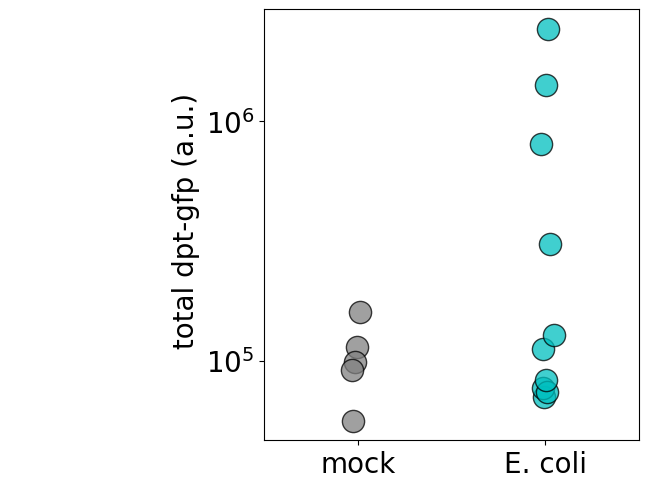

In [9]:
# scatter plot of total intensities
plt.figure()
fontsize = 20

ctl_tot_intens = df_eL3_ctl.groupby(by='experiment_id').sum().dpt_gfp.values
eL3_24_tot_intens = df_eL3_24.groupby(by='experiment_id').sum().dpt_gfp.values
sigma_x = 0.02
plt.plot(np.ones(len(ctl_tot_intens)) + sigma_x * np.random.normal(size=len(ctl_tot_intens)), ctl_tot_intens, 'ko',
        markerfacecolor=[0.5, 0.5, 0.5], markersize=16, alpha=0.75)
plt.plot(1 + np.ones(len(eL3_24_tot_intens)) + sigma_x * np.random.normal(size=len(eL3_24_tot_intens)), 
         eL3_24_tot_intens, 'ko', markerfacecolor='c', markersize=16, alpha=0.75)

plt.xticks([1, 2], labels=['mock', 'E. coli'], fontsize=fontsize)
plt.xlim([0.5, 2.5])
plt.ylabel('\n \n \n \n \n total dpt-gfp (a.u.)', fontsize=fontsize)
plt.yscale('log')
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/tot_inten_dot_plot.pdf')


In [222]:
# add manual background offsets

# eL3-24
df = df_eL3_24
larvae_number = [1, 5, 3, 2, 1, 5, 3, 2, 6, 4]
ids = np.array([1, 4, 3, 2, 5, 9, 7, 6, 10, 8]) - 1
shifts = [1000, 400, 300, 730, 300, 890, 300, 300, 350, 300]
df['bkg'] = 0
for i in range(len(df)):
    this_id = ids[df.iloc[i].experiment_id]
    df.at[df.index[i], 'bkg'] = shifts[this_id]
    
# mod_eL3-24
df = df_mod_eL3_24
ids = np.array([4, 1, 5, 7, 2, 3, 6]) - 1
shifts = [700, 1300, 430, 450, 580, 1200, 580]
df['bkg'] = 0
for i in range(len(df)):
    this_id = ids[df.iloc[i].experiment_id]
    df.at[df.index[i], 'bkg'] = shifts[this_id]

# mL3-24
df = df_mL3_24
ids = np.array([1, 5, 3, 2, 6, 4]) - 1
shifts = [1900, 2100, 6000, 3400, 4000, 2300]
df['bkg'] = 0
for i in range(len(df)):
    this_id = ids[df.iloc[i].experiment_id]
    df.at[df.index[i], 'bkg'] = shifts[this_id]

In [205]:
df_mod_eL3_24

experiment_id            y            x       dpt_gfp       mem_mch   bkg
0                0  1342.881222    706.17441    3060.60541   8016.826571   450
1                0  1459.702117   720.249217   3392.995227  10530.707239   450
2                0  1393.550526   758.251195     2345.4821   10741.83214   450
3                0  1231.690249   749.806311   2214.930788   5803.951472   450
4                0  1265.469785   897.591781   2991.099443   7531.869531   450
...            ...          ...          ...           ...           ...   ...
1723             6  3796.321976  2006.676308  14208.482896   2981.874304  1200
1724             6  3609.466474  1850.729235  16938.789976   5657.010342  1200
1725             6   2780.55861  2041.799522  18261.720764   8540.368337  1200
1726             6  2715.931895  1957.503807  18804.806683   7353.918854  1200
1727             6  2300.073034  2024.940379   9324.031026   4249.316627  1200

[1728 rows x 6 columns]

In [168]:
df['bkg'] = 0
for i in range(len(df)):
    this_id = ids[ids == df.iloc[i].experiment_id][0]
    df.at[df.index[i], 'bkg'] = shifts[this_id]

In [220]:
path =r'/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_07_dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_earlyL3_24hrs'
files = glob(path + '/larvae*')
files

['/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_07_dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_earlyL3_24hrs/larvae_1',
 '/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_07_dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_earlyL3_24hrs/larvae_5',
 '/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_07_dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_earlyL3_24hrs/larvae_3',
 '/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_07_dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_earlyL3_24hrs/larvae_2',
 '/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_07_dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_earlyL3_24hrs/larvae_4']

In [221]:
np.min(df[df.experiment_id==0].dpt_gfp)

1145.0739856801908

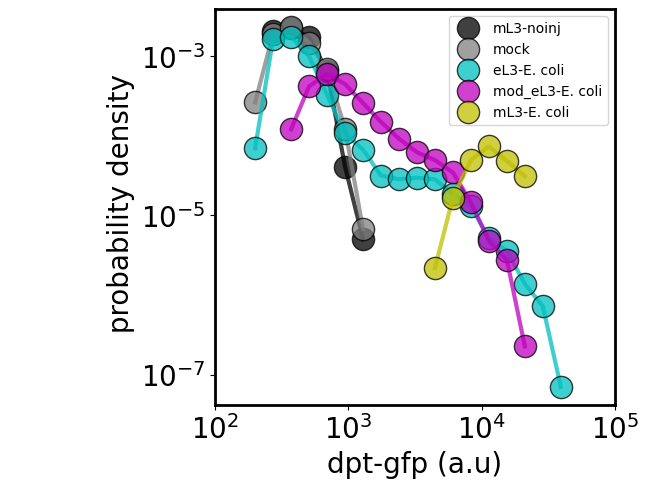

In [214]:
# probability densities of all cell levels

plt.figure()
num_bins = 20
bins = np.logspace(2.3, 5, num_bins+1)

# ml3_24_no_inj
df = df_mL3_24_noinj
intens = df.dpt_gfp
counts, _bins = np.histogram(intens, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths

plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'k-', linewidth=3, label='_no_label_', alpha=0.75)
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'ko', markersize=16, markerfacecolor='k', label='mL3-noinj', alpha=0.75)

# el3_ctl
df = df_eL3_ctl
intens = df.dpt_gfp
counts, _bins = np.histogram(intens, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths
bins_ctl = bins
prob_dens_ctl = prob_dens

plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], '-', linewidth=3, color=[0.5, 0.5, 0.5], label='_no_label_', alpha=0.75)
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'ko', markersize=16, markerfacecolor=[0.5, 0.5, 0.5], label='mock', alpha=0.75)

# el3_24
df = df_eL3_24
intens = df.dpt_gfp - 0*(df.bkg - 300)
counts, _bins = np.histogram(intens, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths

plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'c-', linewidth=3, label='_no_label_', alpha=0.75)
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'ko', markersize=16, markerfacecolor='c', label='eL3-E. coli', alpha=0.75)

# mod_el3_24
df = df_mod_eL3_24
intens = df.dpt_gfp - 0*(df.bkg - 300)
counts, _bins = np.histogram(intens, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths

plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'm-', linewidth=3, label='_no_label_', alpha=0.75)
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'ko', markersize=16, markerfacecolor='m', label='mod_eL3-E. coli', alpha=0.75)


# ml3_24
df = df_mL3_24
intens = df.dpt_gfp - 0*(df.bkg - 300)
counts, _bins = np.histogram(intens, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths

plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'y-', linewidth=3, label='_no_label_', alpha=0.75)
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'ko', markersize=16, markerfacecolor='y', label='mL3-E. coli', alpha=0.75)





plt.yscale('log')
plt.xscale('log')
plt.xlim([1e2, 1e5])
plt.xlabel('dpt-gfp (a.u)', fontsize=fontsize)
plt.ylabel('\n \n \n probability density', fontsize=fontsize)
plt.yticks([1e-7, 1e-5, 1e-3])
plt.xticks([1e2, 1e3, 1e4, 1e5])
#plt.title('raw distributions, E. coli vs mock, 24hrs')
plt.legend()
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

#plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/raw_dists.pdf')




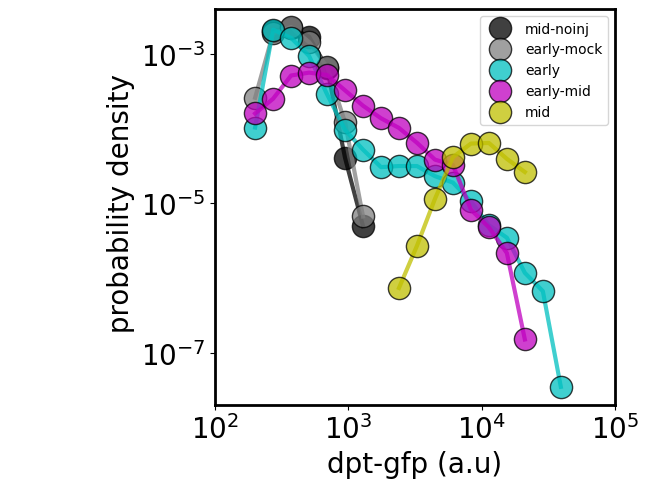

In [255]:
# probability densities of all cell levels

plt.figure()
num_bins = 20
bins = np.logspace(2.3, 5, num_bins+1)

# ml3_24_no_inj
df = df_mL3_24_noinj
intens = df.dpt_gfp
counts, _bins = np.histogram(intens, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths

plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'k-', linewidth=3, label='_no_label_', alpha=0.75)
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'ko', markersize=16, markerfacecolor='k', label='mid-noinj', alpha=0.75)

# el3_ctl
df = df_eL3_ctl
intens = df.dpt_gfp
counts, _bins = np.histogram(intens, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths
bins_ctl = bins
prob_dens_ctl = prob_dens

plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], '-', linewidth=3, color=[0.5, 0.5, 0.5], label='_no_label_', alpha=0.75)
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'ko', markersize=16, markerfacecolor=[0.5, 0.5, 0.5], label='early-mock', alpha=0.75)

# el3_24
df = df_eL3_24
intens = df.dpt_gfp - (df.bkg - 300)
counts, _bins = np.histogram(intens, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths

plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'c-', linewidth=3, label='_no_label_', alpha=0.75)
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'ko', markersize=16, markerfacecolor='c', label='early', alpha=0.75)

# mod_el3_24
df = df_mod_eL3_24
intens = df.dpt_gfp - (df.bkg - 300)
counts, _bins = np.histogram(intens, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths

plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'm-', linewidth=3, label='_no_label_', alpha=0.75)
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'ko', markersize=16, markerfacecolor='m', label='early-mid', alpha=0.75)


# ml3_24
df = df_mL3_24
intens = df.dpt_gfp - (df.bkg - 300)
counts, _bins = np.histogram(intens, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths

plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'y-', linewidth=3, label='_no_label_', alpha=0.75)
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'ko', markersize=16, markerfacecolor='y', label='mid', alpha=0.75)





plt.yscale('log')
plt.xscale('log')
plt.xlim([1e2, 1e5])
plt.xlabel('dpt-gfp (a.u)', fontsize=fontsize)
plt.ylabel('\n \n \n probability density', fontsize=fontsize)
plt.yticks([1e-7, 1e-5, 1e-3])
plt.xticks([1e2, 1e3, 1e4, 1e5])
#plt.title('raw distributions, E. coli vs mock, 24hrs')
plt.legend()
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/bkg_subtracted_dists.pdf')




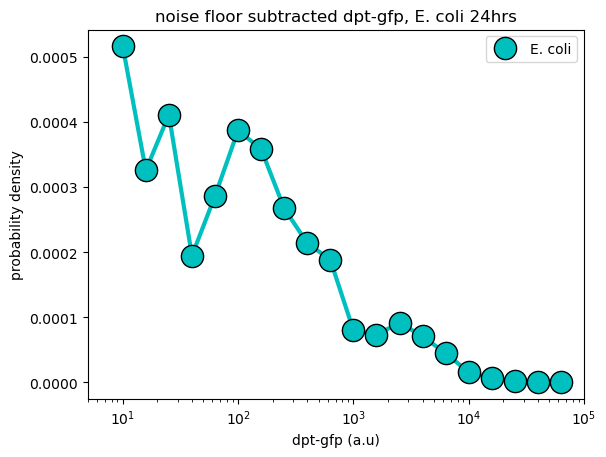

In [342]:
# noise subtracted
thresh = np.quantile(df_eL3_ctl.dpt_gfp, q=0.95)
intens = df_eL3_24.dpt_gfp - thresh
intens = intens[intens > 0]

num_bins = 20
bins = np.logspace(1, 5, num_bins+1)
plt.figure()
counts, _bins = np.histogram(intens, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths

plt.plot(bins, prob_dens, 'c-', linewidth=3, label='_no_label_')
plt.plot(bins, prob_dens, 'ko', markersize=16, markerfacecolor='c', label='E. coli')

plt.yscale('linear')
plt.xscale('log')
plt.xlim([5, 1e5])
plt.xlabel('dpt-gfp (a.u)')
plt.ylabel('probability density')
plt.title('noise floor subtracted dpt-gfp, E. coli 24hrs')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


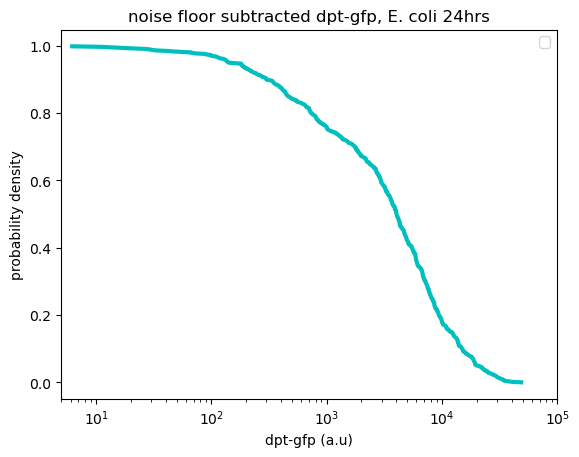

In [343]:
"""noise substracted pool cum dist"""
thresh = np.quantile(df_eL3_ctl.dpt_gfp, q=0.95)
intens = df_eL3_24.dpt_gfp - thresh
intens = intens[intens > 0]

intens = np.sort(intens)
cum_dist = np.zeros_like(intens)
for i in range(len(intens)):
    cum_dist[i] = np.sum(intens > intens[i]) / len(intens)
    
plt.plot(intens, cum_dist, 'c-', linewidth=3, label='_no_label_')
#plt.plot(intens, cum_dist, 'ko', markersize=16, markerfacecolor='c', label='E. coli')

plt.yscale('linear')
plt.xscale('log')
plt.xlim([5, 1e5])
plt.xlabel('dpt-gfp (a.u)')
plt.ylabel('probability density')
plt.title('noise floor subtracted dpt-gfp, E. coli 24hrs')
plt.legend()

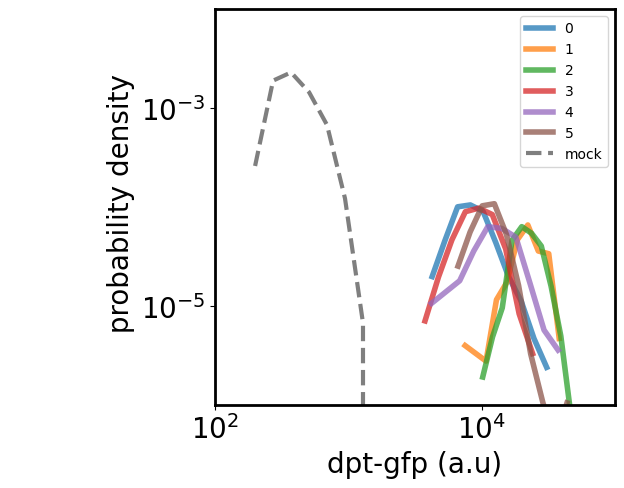

In [254]:
"""noise floor subtracted dist, plot every dist individually"""
thresh = 0 * np.quantile(df_eL3_ctl.dpt_gfp, q=0.95)
num_bins = 10
bins = np.logspace(1, 5, num_bins+1)
df = df_mL3_24 # df_eL4_24
plt.figure()

for larvae in np.unique(df.experiment_id):
    sub_df = df[df.experiment_id == larvae]
    intens = sub_df.dpt_gfp - (sub_df.bkg - 300)
    bins = np.logspace(np.log10(np.min(intens)), np.log10(np.max(intens)), num_bins+ 1 )
    counts, _bins = np.histogram(intens, bins)
    bin_widths = np.diff(bins)
    bins = bins[:-1]
    prob_dens = counts / np.sum(counts) / bin_widths
    plot_bins = bins[prob_dens > 0]
    prob_dens = prob_dens[prob_dens > 0]
    
    #plt.plot(bins, prob_dens, 'c-', linewidth=3, alpha=0.5, label='_no_label_')
    plt.plot(plot_bins, prob_dens, '-', linewidth=4, alpha=0.75, label=str(larvae))
    #plt.plot(plot_bins, prob_dens, 'o', linewidth=3, alpha=0.5, label='_no_label_')
plt.plot(bins_ctl, prob_dens_ctl, 'k--', alpha=0.5, label='mock', linewidth=3)    

#
# num_bins = 20
# bins = np.logspace(2.3, 5, num_bins+1)
# intens = df.dpt_gfp - (df.bkg - 300)
# counts, _bins = np.histogram(intens, bins)
# bin_widths = np.diff(bins)
# bins = bins[:-1]
# prob_dens = counts / np.sum(counts) / bin_widths
# #plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'k--', linewidth=6, label='pooled', alpha=0.75)
#plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'ko', markersize=16, markerfacecolor='m', label='mod_eL3-E. coli', alpha=0.75)

plt.yscale('log')
plt.xscale('log')
plt.xlim([1e2, 1e5])
plt.xlabel('dpt-gfp (a.u)', fontsize=fontsize)
plt.ylabel('\n \n \n probability density', fontsize=fontsize)
plt.ylim([1e-6, 1e-2])
plt.yticks([1e-5, 1e-3])
#plt.title('raw distributions, E. coli vs mock, 24hrs')
plt.legend()
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/mL3_24_bkg_sub_dists_individuals.pdf')

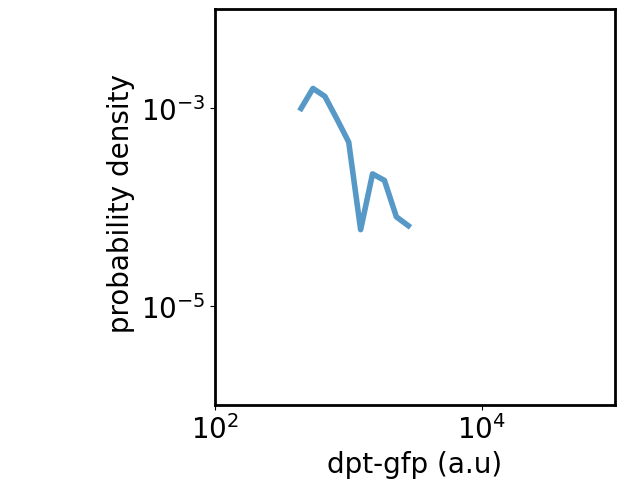

In [185]:
df = df_mod_eL3_24 # df_eL4_24
sub_df = df[df.experiment_id==0]
num_bins = 10
bins = np.logspace(1, 5, num_bins+1)
intens = sub_df.dpt_gfp - 0 * (sub_df.bkg - 300)
bins = np.logspace(np.log10(np.min(intens)), np.log10(np.max(intens)), num_bins+ 1 )
counts, _bins = np.histogram(intens, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths
plot_bins = bins[prob_dens > 0]
prob_dens = prob_dens[prob_dens > 0]
plt.figure()
plt.plot(plot_bins, prob_dens, '-', linewidth=4, alpha=0.75, label=str(larvae))
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e2, 1e5])
plt.xlabel('dpt-gfp (a.u)', fontsize=fontsize)
plt.ylabel('\n \n \n probability density', fontsize=fontsize)
plt.ylim([1e-6, 1e-2])
plt.yticks([1e-5, 1e-3])
#plt.title('raw distributions, E. coli vs mock, 24hrs')
#plt.legend()
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

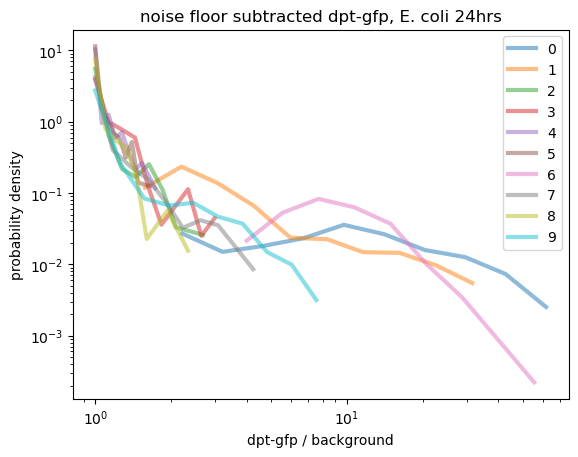

In [404]:
"""noise floor subtracted dist, plot every dist individually"""
thresh = np.quantile(df_eL3_ctl.dpt_gfp, q=0.5)
num_bins = 10
bins = np.logspace(1, 5, num_bins+1)

plt.figure()
for larvae in np.unique(df_eL3_24.experiment_id):
    sub_df = df_eL3_24[df_eL3_24.experiment_id == larvae]
    #intens = sub_df.dpt_gfp - thresh
    #intens = intens[intens > 0]
    intens = sub_df.dpt_gfp.copy()
    intens[intens < thresh] = thresh
    intens = intens / thresh
    bins = np.logspace(np.log10(np.min(intens)), np.log10(np.max(intens)), num_bins+ 1 )
    counts, _bins = np.histogram(intens, bins)
    bin_widths = np.diff(bins)
    bins = bins[:-1]
    prob_dens = counts / np.sum(counts) / bin_widths
    plot_bins = bins[prob_dens > 0]
    prob_dens = prob_dens[prob_dens > 0]
    
    #plt.plot(bins, prob_dens, 'c-', linewidth=3, alpha=0.5, label='_no_label_')
    plt.plot(plot_bins, prob_dens, '-', linewidth=3, alpha=0.5, label=str(larvae))
    #plt.plot(plot_bins, prob_dens, 'o', linewidth=3, alpha=0.5, label='_no_label_')

    
plt.yscale('log')
plt.xscale('log')
#plt.xlim([5, 1e5])
#plt.ylim([0, 0.01])
plt.xlabel('dpt-gfp / background')
plt.ylabel('probability density')
plt.title('noise floor subtracted dpt-gfp, E. coli 24hrs')
plt.legend()

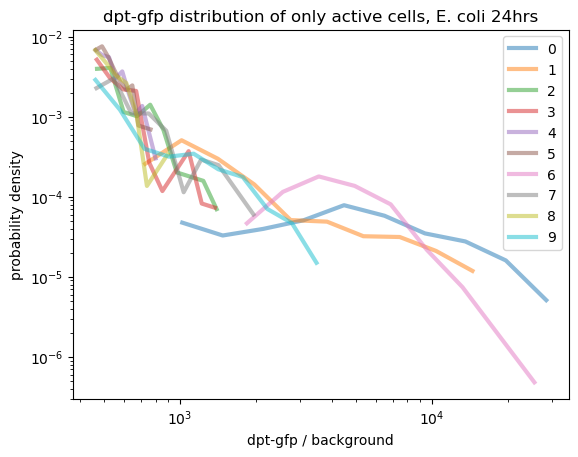

In [405]:
"""only active cells. plot every dist individually"""
thresh = np.quantile(df_eL3_ctl.dpt_gfp, q=0.50)
num_bins = 10
bins = np.logspace(1, 5, num_bins+1)

plt.figure()
for larvae in np.unique(df_eL3_24.experiment_id):
    sub_df = df_eL3_24[df_eL3_24.experiment_id == larvae]
    #intens = sub_df.dpt_gfp - thresh
    #intens = intens[intens > 0]
    intens = sub_df.dpt_gfp.copy()
    intens = intens[intens > thresh]
    bins = np.logspace(np.log10(np.min(intens)), np.log10(np.max(intens)), num_bins+ 1 )
    counts, _bins = np.histogram(intens, bins)
    bin_widths = np.diff(bins)
    bins = bins[:-1]
    prob_dens = counts / np.sum(counts) / bin_widths
    plot_bins = bins[prob_dens > 0]
    prob_dens = prob_dens[prob_dens > 0]
    
    #plt.plot(bins, prob_dens, 'c-', linewidth=3, alpha=0.5, label='_no_label_')
    plt.plot(plot_bins, prob_dens, '-', linewidth=3, alpha=0.5, label=str(larvae))
    #plt.plot(plot_bins, prob_dens, 'o', linewidth=3, alpha=0.5, label='_no_label_')

    
plt.yscale('log')
plt.xscale('log')
#plt.xlim([5, 1e5])
#plt.ylim([0, 0.01])
plt.xlabel('dpt-gfp / background')
plt.ylabel('probability density')
plt.title('dpt-gfp distribution of only active cells, E. coli 24hrs')
plt.legend()

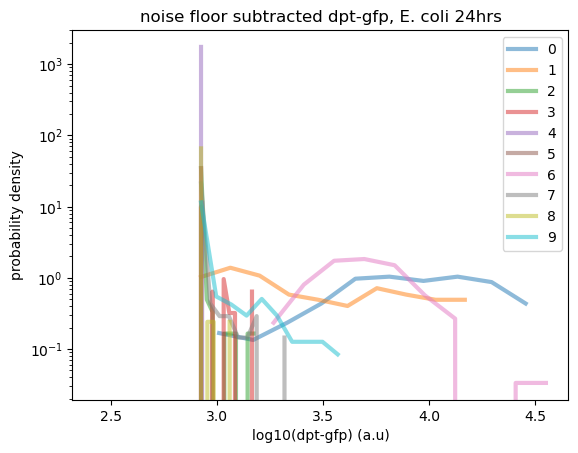

In [345]:
"""noise floor subtracted dist, plot every dist individually. log intens, bins picked for each larvae"""
thresh = np.quantile(df_eL3_ctl.dpt_gfp, q=0.95)
num_bins = 20
bins = np.logspace(1, 5, num_bins+1)

plt.figure()
for larvae in np.unique(df_eL3_24.experiment_id):
    sub_df = df_eL3_24[df_eL3_24.experiment_id == larvae]
#     intens = sub_df.dpt_gfp - thresh
#     intens = np.log10(intens[intens > 0].astype('float64'))
    intens = sub_df.dpt_gfp.copy()
    intens[intens < thresh] = thresh
    intens = np.log10(intens.astype('float64'))

    counts, bins = np.histogram(intens, bins=10)
    bin_widths = np.diff(bins)
    bins = bins[:-1]
    prob_dens = counts / np.sum(counts) / bin_widths
    #plot_bins = bins[prob_dens > 0]
    #prob_dens = prob_dens[prob_dens > 0]
    
    #plt.plot(bins, prob_dens, 'c-', linewidth=3, alpha=0.5, label='_no_label_')
    plt.plot(bins, prob_dens, '-', linewidth=3, alpha=0.5, label=str(larvae))
    #plt.plot(plot_bins, prob_dens, 'o', linewidth=3, alpha=0.5, label='_no_label_')

    
plt.yscale('log')
plt.xscale('linear')
#plt.xlim([5, 1e5])
#plt.ylim([0, 0.01])
plt.xlabel('log10(dpt-gfp) (a.u)')
plt.ylabel('probability density')
plt.title('noise floor subtracted dpt-gfp, E. coli 24hrs')
plt.legend()

/tmp/ipykernel_2044464/4130059506.py:15: RuntimeWarning: invalid value encountered in true_divide
  prob_dens = counts / np.sum(counts) / bin_widths


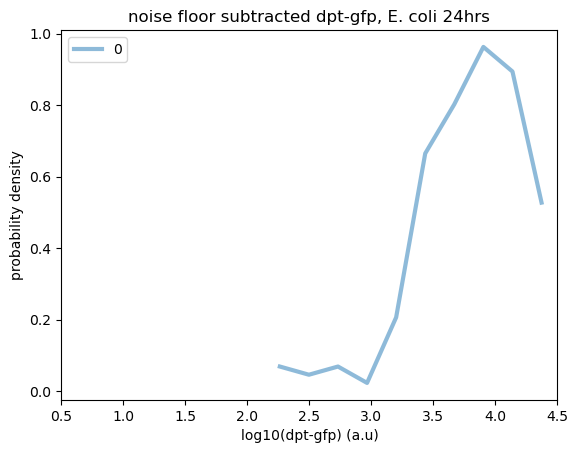

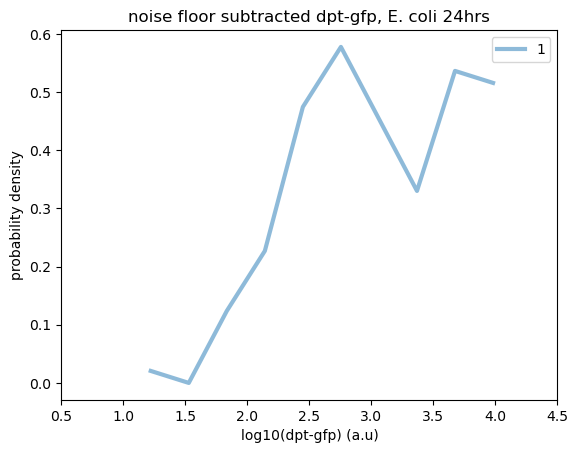

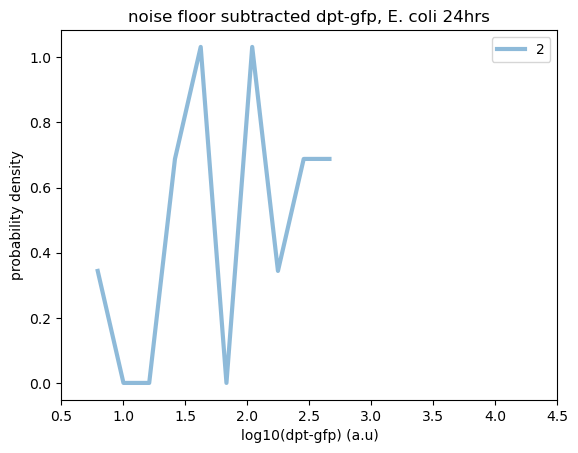

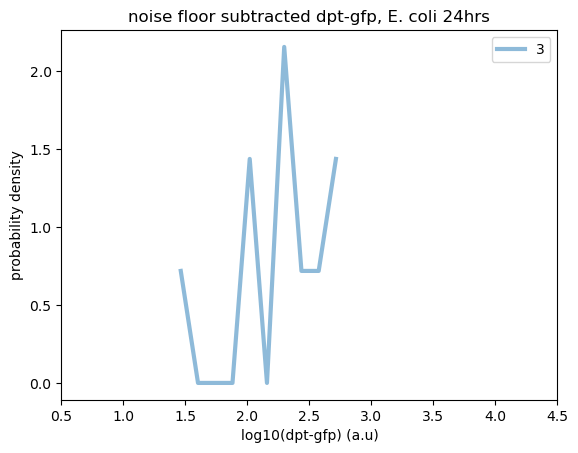

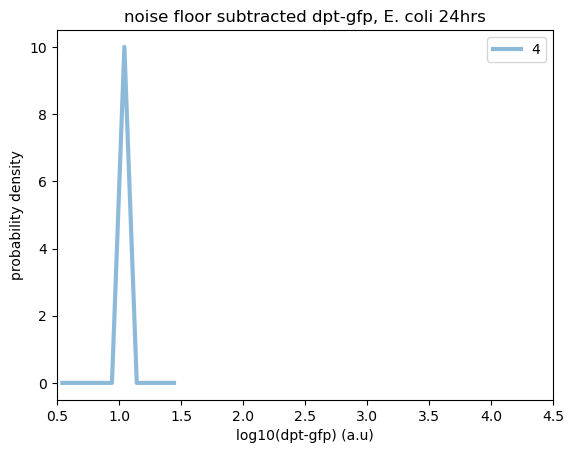

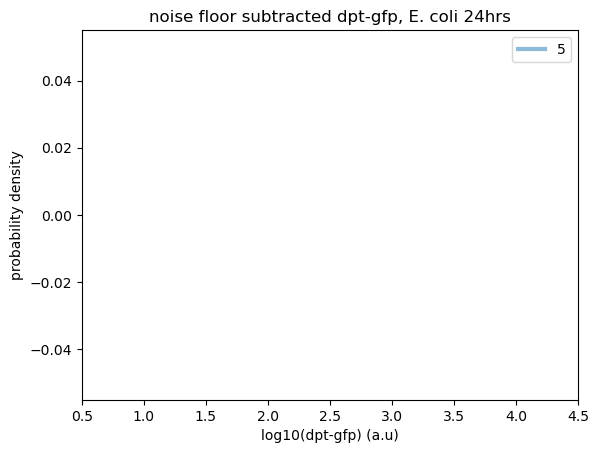

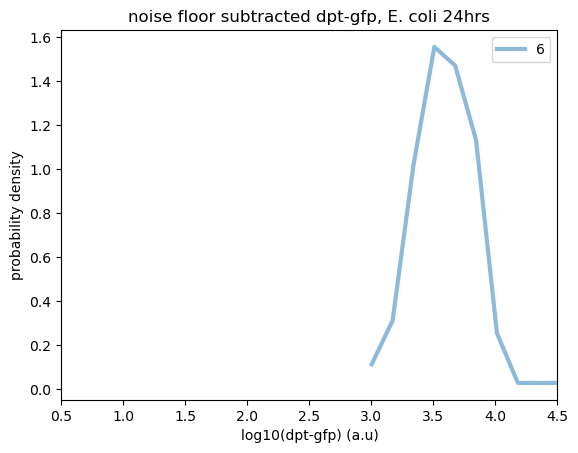

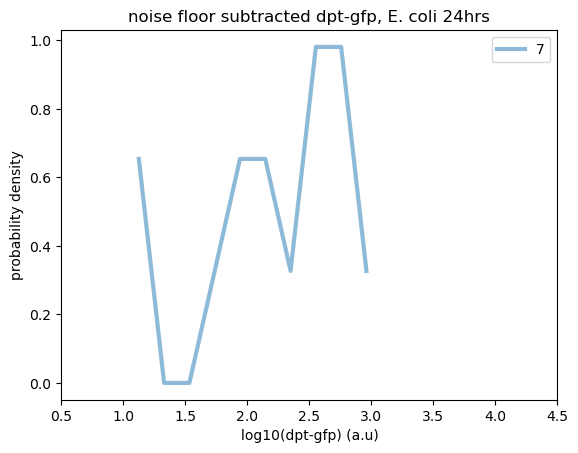

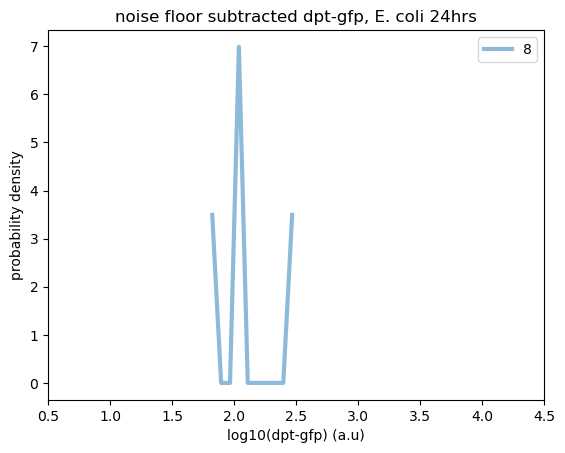

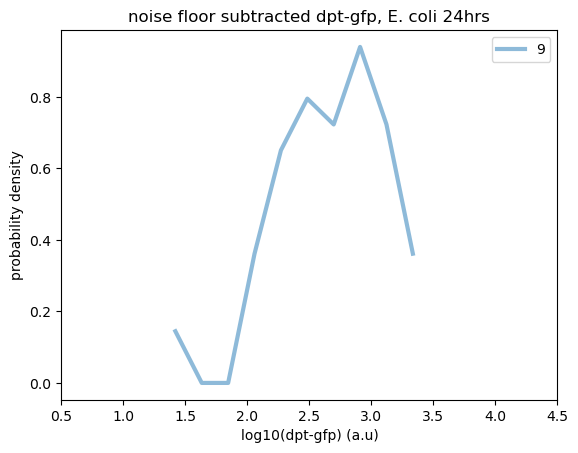

In [346]:
"""noise floor subtracted dist, plot every dist individually. log intens, bins picked for each larvae"""
thresh = np.quantile(df_eL3_ctl.dpt_gfp, q=0.95)
num_bins = 20
bins = np.logspace(1, 5, num_bins+1)

for larvae in np.unique(df_eL3_24.experiment_id):
    plt.figure()
    sub_df = df_eL3_24[df_eL3_24.experiment_id == larvae]
    intens = sub_df.dpt_gfp - thresh
    intens = np.log10(intens[intens > 0].astype('float64'))

    counts, bins = np.histogram(intens, bins=10)
    bin_widths = np.diff(bins)
    bins = bins[:-1]
    prob_dens = counts / np.sum(counts) / bin_widths
    #plot_bins = bins[prob_dens > 0]
    #prob_dens = prob_dens[prob_dens > 0]
    
    #plt.plot(bins, prob_dens, 'c-', linewidth=3, alpha=0.5, label='_no_label_')
    plt.plot(bins, prob_dens, '-', linewidth=3, alpha=0.5, label=str(larvae))
    #plt.plot(plot_bins, prob_dens, 'o', linewidth=3, alpha=0.5, label='_no_label_')
    
    plt.yscale('linear')
    plt.xscale('linear')
    plt.xlim([0.5, 4.5])
    #plt.ylim([0, 0.01])
    plt.xlabel('log10(dpt-gfp) (a.u)')
    plt.ylabel('probability density')
    plt.title('noise floor subtracted dpt-gfp, E. coli 24hrs')
    plt.legend()



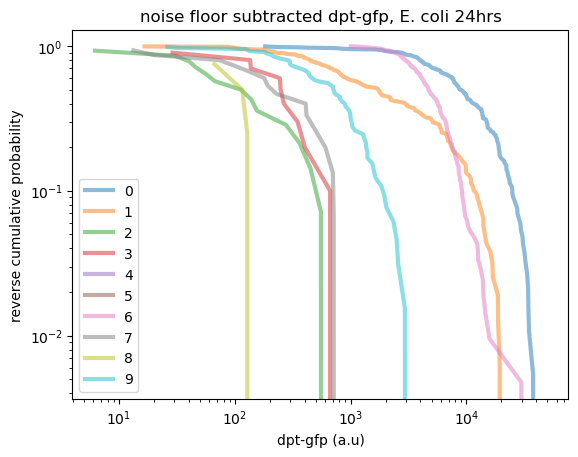

In [353]:
"""noise floor subtracted dist, plot every dist individually, reverse cumulative dist"""
thresh = np.quantile(df_eL3_ctl.dpt_gfp, q=0.95)
num_bins = 20
bins = np.logspace(1, 5, num_bins+1)

plt.figure()
for larvae in np.unique(df_eL3_24.experiment_id):
    sub_df = df_eL3_24[df_eL3_24.experiment_id == larvae]
    intens = sub_df.dpt_gfp - thresh
    intens = intens[intens > 0]
    #intens = intens / np.sum(intens)
    #print(len(intens))

    intens = np.sort(intens)
    cum_dist = np.zeros_like(intens)
    for i in range(len(intens)):
        cum_dist[i] = np.sum(intens > intens[i]) / len(intens)
    
    plt.plot(intens, cum_dist, '-', linewidth=3, alpha=0.5, label=str(larvae))

    
plt.yscale('log')
plt.xscale('log')
#plt.xlim([5, 1e5])
#plt.ylim([0, 0.01])
plt.xlabel('dpt-gfp (a.u)')
plt.ylabel('reverse cumulative probability')
plt.title('noise floor subtracted dpt-gfp, E. coli 24hrs')
plt.legend()

/tmp/ipykernel_2044464/2471980691.py:20: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


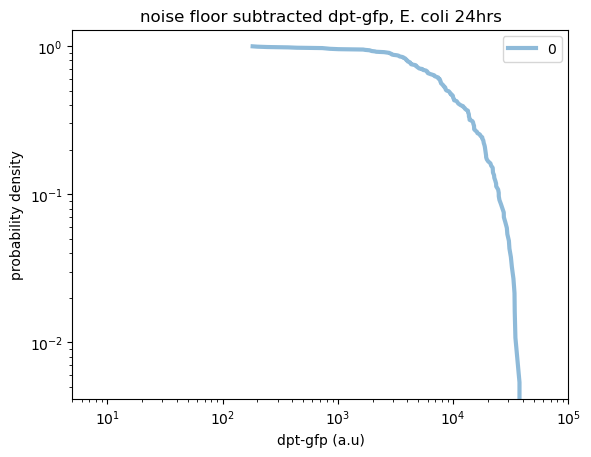

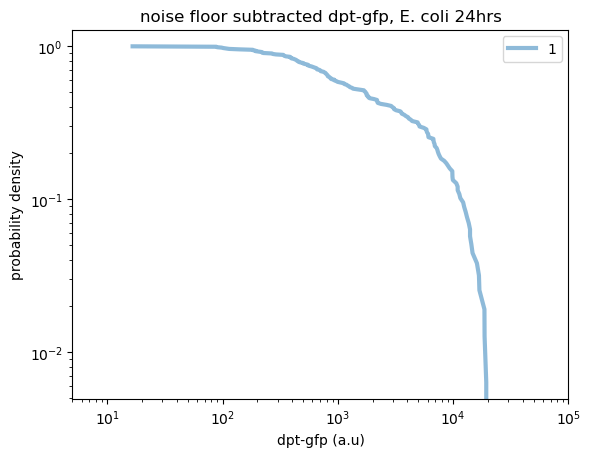

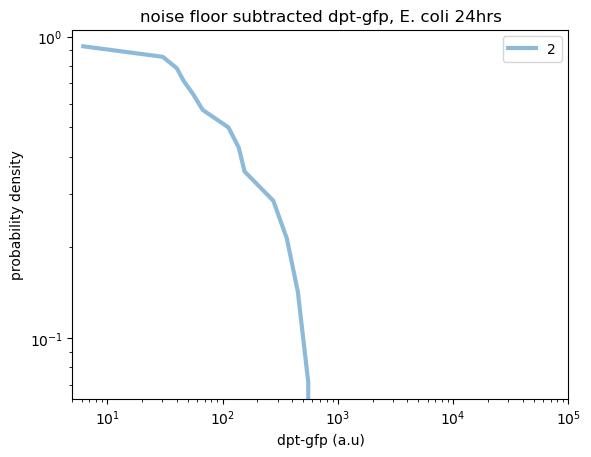

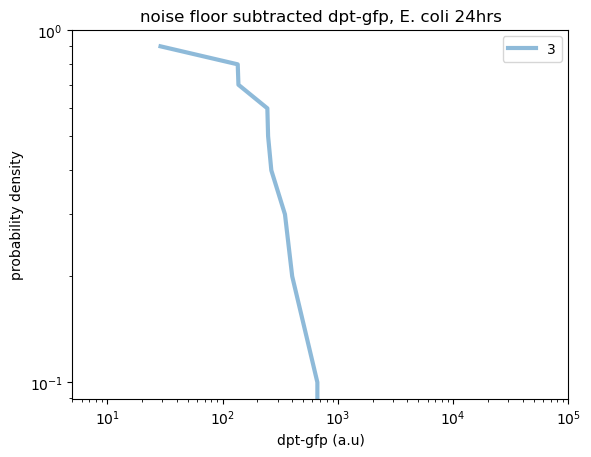

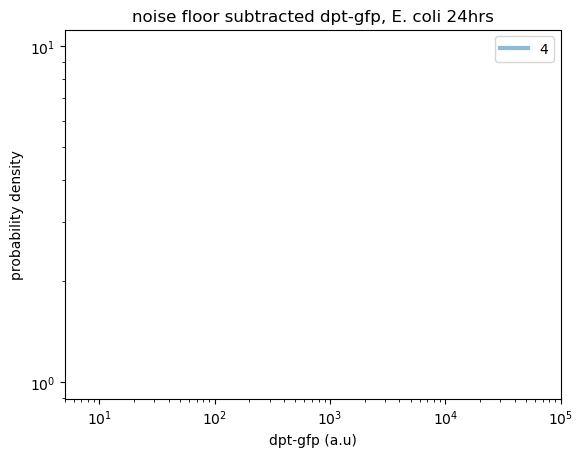

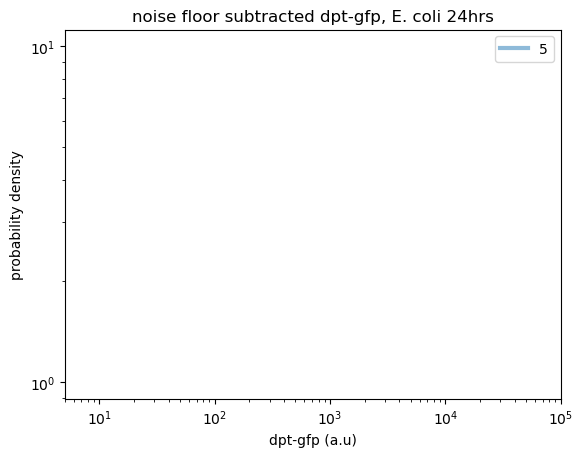

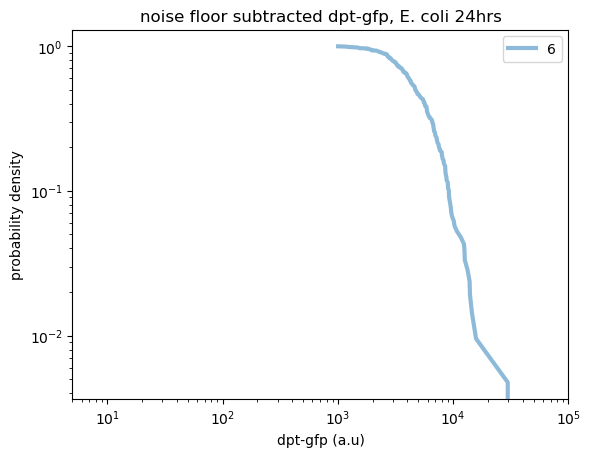

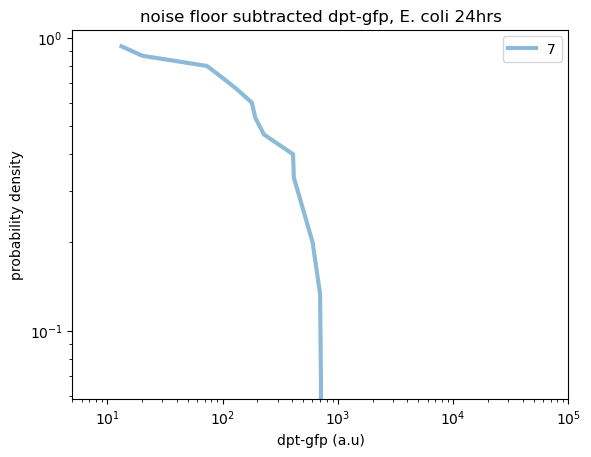

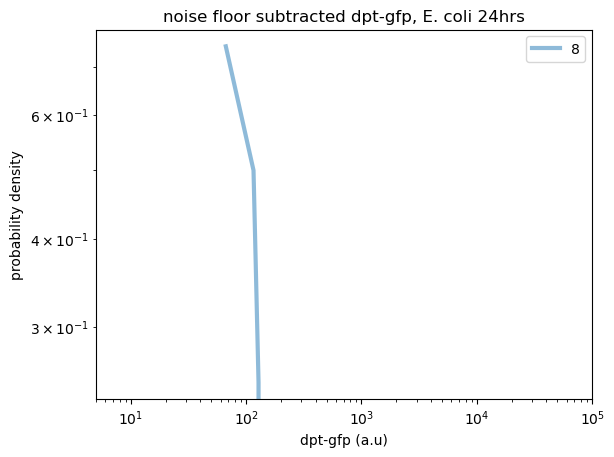

In [221]:
"""noise floor subtracted dist, plot every dist individually, reverse cumulative dist"""
thresh = np.quantile(df_eL3_ctl.dpt_gfp, q=0.95)
num_bins = 20
bins = np.logspace(1, 5, num_bins+1)

for larvae in np.unique(df_eL3_24.experiment_id):
    plt.figure()
    sub_df = df_eL3_24[df_eL3_24.experiment_id == larvae]
    intens = sub_df.dpt_gfp - thresh
    intens = intens[intens > 0]

    intens = np.sort(intens)
    cum_dist = np.zeros_like(intens)
    for i in range(len(intens)):
        cum_dist[i] = np.sum(intens > intens[i]) / len(intens)
    
    plt.plot(intens, cum_dist, '-', linewidth=3, alpha=0.5, label=str(larvae))

    
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim([5, 1e5])
    #plt.ylim([0, 0.01])
    plt.xlabel('dpt-gfp (a.u)')
    plt.ylabel('probability density')
    plt.title('noise floor subtracted dpt-gfp, E. coli 24hrs')
    plt.legend()

186
162
221
117
156
167
210
158
277
332


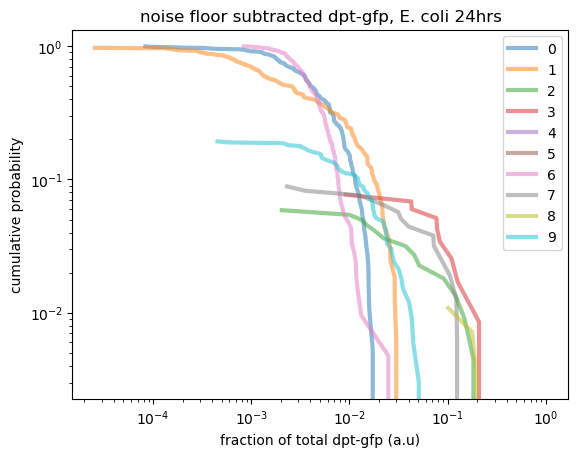

In [348]:
"""noise floor subtracted dist, plot every dist individually,  cumulative dist"""
thresh = np.quantile(df_eL3_ctl.dpt_gfp, q=0.95)
num_bins = 20
bins = np.logspace(1, 5, num_bins+1)

plt.figure()
for larvae in np.unique(df_eL3_24.experiment_id):
    sub_df = df_eL3_24[df_eL3_24.experiment_id == larvae]
    intens = sub_df.dpt_gfp - thresh
    total_num_cells = len(intens)
    print(total_num_cells)
    intens = intens[intens > 0]
    intens = intens / np.sum(intens)

    intens = np.sort(intens)
    cum_dist = np.zeros_like(intens)
    for i in range(len(intens)):
        cum_dist[i] = np.sum(intens > intens[i]) / total_num_cells #len(intens)
    
    plt.plot(intens, cum_dist, '-', linewidth=3, alpha=0.5, label=str(larvae))

    
plt.yscale('log')
plt.xscale('log')
#plt.xlim([5, 1e5])
#plt.ylim([0, 0.01])
plt.xlabel('fraction of total dpt-gfp (a.u)')
plt.ylabel('cumulative probability')
plt.title('noise floor subtracted dpt-gfp, E. coli 24hrs')
plt.legend()

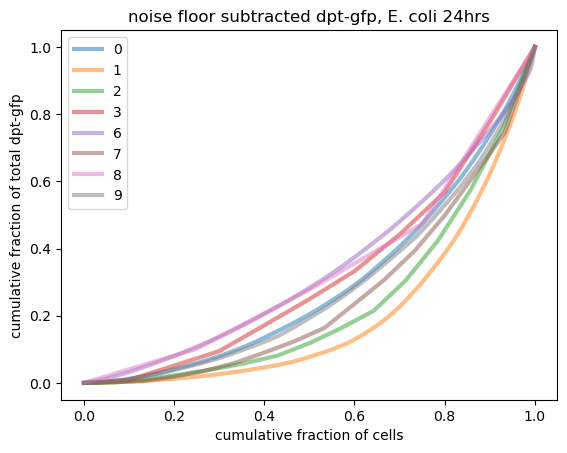

In [349]:
"""noise floor subtracted lorenz curve, plot every larvae individually"""
thresh = np.quantile(df_eL3_ctl.dpt_gfp, q=0.95)
num_bins = 20
bins = np.logspace(1, 5, num_bins+1)

plt.figure()
for larvae in np.unique(df_eL3_24.experiment_id):
    sub_df = df_eL3_24[df_eL3_24.experiment_id == larvae]
    intens = sub_df.dpt_gfp.values.astype('float64') - thresh
    intens = intens[intens > 0]
    intens = np.sort(intens)
    lorenz = np.cumsum(intens) / np.sum(intens)
    lorenz = np.insert(lorenz, 0, 0)
    if len(lorenz) < 3:
        continue
    
    cell_fraction = np.arange(len(lorenz)) / (len(lorenz) - 1)
#     cell_fraction = cell_fraction[intens > 0]
#     intens = intens[intens > 0]
    
    plt.plot(cell_fraction, lorenz, '-', linewidth=3, alpha=0.5, label=str(larvae))

    
plt.yscale('linear')
plt.xscale('linear')
#plt.xlim([5, 1e5])
#plt.ylim([0, 0.01])
plt.xlabel('cumulative fraction of cells')
plt.ylabel('cumulative fraction of total dpt-gfp')
plt.title('noise floor subtracted dpt-gfp, E. coli 24hrs')
plt.legend()

In [321]:
intens = sub_df.dpt_gfp.values.astype('float64') - thresh
intens = intens[intens > 0]
intens = intens / np.sum(intens)
print(intens)

[0.17638776 0.10143707 0.19496244 0.52721274]


/tmp/ipykernel_2044464/639557284.py:15: RuntimeWarning: invalid value encountered in true_divide
  prob_dens = counts / np.sum(counts) / bin_widths


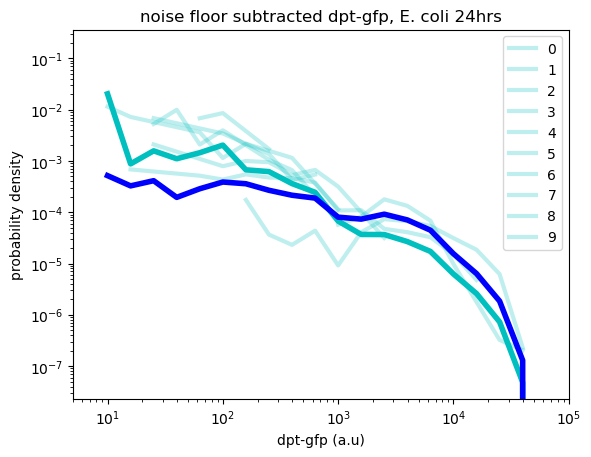

In [350]:
"""noise floor subtracted dist, average individual dists"""
thresh = np.quantile(df_eL3_ctl.dpt_gfp, q=0.95)
num_bins = 20
all_dists = np.zeros((len(np.unique(df_eL3_24.experiment_id)), num_bins))
plt.figure()
for larvae in np.unique(df_eL3_24.experiment_id):
    bins = np.logspace(1, 5, num_bins+1)
    sub_df = df_eL3_24[df_eL3_24.experiment_id == larvae]
    intens = sub_df.dpt_gfp - thresh
    intens = intens[intens > 0]

    counts, _bins = np.histogram(intens, bins)
    bin_widths = np.diff(bins)
    bins = bins[:-1]
    prob_dens = counts / np.sum(counts) / bin_widths
    all_dists[larvae] = prob_dens
    plot_bins = bins[prob_dens > 0]
    prob_dens = prob_dens[prob_dens > 0]
    
    #plt.plot(bins, prob_dens, 'c-', linewidth=3, alpha=0.5, label='_no_label_')
    plt.plot(plot_bins, prob_dens, '-', linewidth=3, alpha=0.25, label=str(larvae), color='c')
    #plt.plot(plot_bins, prob_dens, 'o', linewidth=3, alpha=0.5, label='_no_label_')


plt.plot(bins, np.nanmean(all_dists, axis=0), linewidth=4, color='c')  
intens = df_eL3_24.dpt_gfp - thresh
intens = intens[intens > 0]

num_bins = 20
bins = np.logspace(1, 5, num_bins+1)
counts, _bins = np.histogram(intens, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths
plt.plot(bins, prob_dens, linewidth=4, color='b')  

plt.yscale('log')
plt.xscale('log')
plt.xlim([5, 1e5])
#plt.ylim([0, 0.01])
plt.xlabel('dpt-gfp (a.u)')
plt.ylabel('probability density')
plt.title('noise floor subtracted dpt-gfp, E. coli 24hrs')
plt.legend()

(array([ 7., 24., 52., 55., 45., 17.,  8.,  0.,  1.,  1.]),
 array([3.26594993, 3.40868017, 3.55141041, 3.69414065, 3.83687089,
        3.97960113, 4.12233137, 4.26506161, 4.40779185, 4.55052209,
        4.69325233]),
 <BarContainer object of 10 artists>)

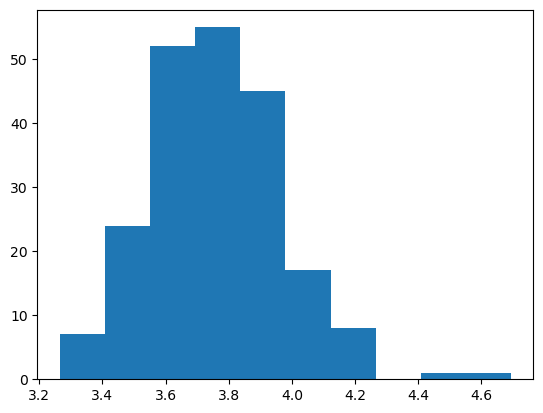

In [176]:
plt.hist(np.log10(df_eL3_24[df_eL3_24.experiment_id==6].dpt_gfp.astype('float64')))

In [139]:
larvae=0
sub_df = df_eL3_24[df_eL3_24.experiment_id == larvae]
intens = sub_df.dpt_gfp - thresh
intens = intens[intens > 0]
bins = np.logspace(1, 5, num_bins+1)
counts, _bins = np.histogram(intens, bins)
print(counts)
print()
sub_df

[ 0  0  0  0  0  0  3  1  1  3  1  7 20 29 37 34 32 17  1  0]



experiment_id            y            x       dpt_gfp      mem_mch
0               0  2148.644674   608.620132  29201.995227   7301.75895
1               0  2269.900387   587.429813  38447.618934  8533.741448
2               0    2408.8147   590.961533  31592.720764  7960.165473
3               0  2497.107695   553.289855  25381.107399  8997.516309
4               0  2578.337251   541.517456  22872.779634  9593.929196
..            ...          ...          ...           ...          ...
181             0  9020.909285  1433.206002   1642.725537  4755.253779
182             0  9582.551917  2379.435966   1021.729515  5693.501193
183             0  9521.598453  2524.563261   1039.701671  4512.327765
184             0  8758.228881  2485.378891   2803.456643  4235.325378
185             0  9376.471158  1327.263077   1210.494829  7928.348449

[186 rows x 5 columns]

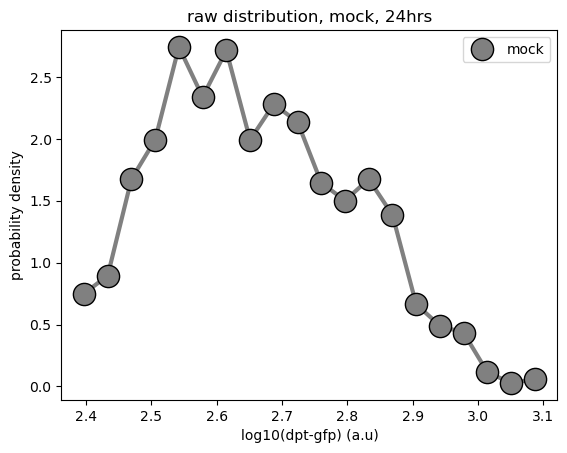

In [125]:
plt.figure()
counts, bins = np.histogram(np.log10(df_eL3_ctl.dpt_gfp.astype('float64')), bins=20)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths

plt.plot(bins, prob_dens, '-', linewidth=3, color=[0.5, 0.5, 0.5], label='_no_label_')
plt.plot(bins, prob_dens, 'ko', markersize=16, markerfacecolor=[0.5, 0.5, 0.5], label='mock')
plt.xlabel('log10(dpt-gfp) (a.u)')
plt.ylabel('probability density')
plt.title('raw distribution, mock, 24hrs')
plt.legend()

In [445]:
# red channel
# probability densities of all cell levels

plt.figure()
num_bins = 20
bins = np.logspace(3.2, 4.2, num_bins+1)

# el3_ctl
counts, _bins = np.histogram(df_eL3_ctl.mem_mch, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths

plt.plot(bins, prob_dens, '-', linewidth=3, color=[0.5, 0.5, 0.5], label='_no_label_', alpha=0.75)
plt.plot(bins, prob_dens, 'ko', markersize=16, markerfacecolor=[0.5, 0.5, 0.5], label='mock', alpha=0.75)

# el3_24
counts, _bins = np.histogram(df_eL3_24.mem_mch, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths

plt.plot(bins, prob_dens, 'm-', linewidth=3, label='_no_label_', alpha=0.75)
plt.plot(bins, prob_dens, 'ko', markersize=16, markerfacecolor='m', label='E. coli', alpha=0.75)

plt.yscale('log')
plt.xscale('log')
plt.xlim([1e2, 1e5])
plt.xlabel('membrane-mcherry (a.u)', fontsize=fontsize)
plt.ylabel('\n \n \n probability density', fontsize=fontsize)
plt.yticks([1e-7, 1e-5, 1e-3])
#plt.title('raw distributions, E. coli vs mock, 24hrs')
plt.legend()
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/raw_dists_membrane.pdf')

In [110]:
np.max(df_eL3_ctl.mem_mch)

10627.080350039778

In [127]:
df_eL3_24

experiment_id            y            x       dpt_gfp      mem_mch
0                0  2148.644674   608.620132  29201.995227   7301.75895
1                0  2269.900387   587.429813  38447.618934  8533.741448
2                0    2408.8147   590.961533  31592.720764  7960.165473
3                0  2497.107695   553.289855  25381.107399  8997.516309
4                0  2578.337251   541.517456  22872.779634  9593.929196
...            ...          ...          ...           ...          ...
1649             8  3781.616622  1222.672107    324.784407  5695.793158
1650             8  3456.915278    967.70528    427.320605  5704.381862
1651             8   3607.28033  1148.579183    297.626889  6258.505967
1652             8  3456.915278  1043.977408    357.172633  6085.084328
1653             8  3428.295658  1167.509869    354.435959  6473.198091

[1654 rows x 5 columns]

In [189]:
experiment_paths = eL3_24_experiment_paths
for experiment_path in experiment_paths:
        larvae_dirs = glob(experiment_path + '/larvae*')
        for larvae_dir in larvae_dirs:
            if Path(larvae_dir + '/manual_df.pkl').is_file():
                print(larvae_dir)

/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_07_dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_earlyL3_24hrs/larvae_1
/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_07_dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_earlyL3_24hrs/larvae_5
/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_07_dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_earlyL3_24hrs/larvae_3
/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_10_dpt-gfp_4r-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_24hrs/larvae_1
/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_10_dpt-gfp_4r-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_24hrs/larvae_5
/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_10_dpt-gfp_4r-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_24hrs/larvae_3
/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_10_dpt-gfp_4r-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_24hrs/larvae_2
/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_10_dpt-gfp_4r-gal4_uas-mc

# Spatial correlation analysis

In [270]:
def build_distance_matrix(x, y, scale=0.3295):
    """x, y = arrays of x and y coordinates. scale = microns / pixel"""
    assert len(x) == len(y)
    num_cells = len(x)
    distance_matrix = np.zeros((num_cells, num_cells))
    for i in range(num_cells):
        for j in range(i):
            distance_matrix[i, j] = scale * np.sqrt((x[i] - x[j]) ** 2 + (y[i] - y[j]) **2)
            
    return distance_matrix


def build_distance_matrix_from_df(df):
    x = df.x.values.astype('float64')
    y = df.y.values.astype('float64')
    
    return build_distance_matrix(x, y)
    
    
def spatial_correlation(intens, distance_matrix, distance_bin_edges=None):
    if distance_bin_edges is None:
        _, distance_bin_edges = np.histogram(distance_matrix[distance_matrix > 0])
    intens = intens - np.mean(intens)
    total_var = np.var(intens)
    intens_product_matrix = np.outer(intens, intens)
    correlations = np.zeros(len(distance_bin_edges) - 1)
    for i in range(len(distance_bin_edges) - 1):
        sel = (distance_matrix >= distance_bin_edges[i]) * (distance_matrix < distance_bin_edges[i+1])
        these_intens = intens_product_matrix[sel]
        correlations[i] = np.mean(these_intens) / total_var
        
    return correlations, distance_bin_edges
               
        
def get_all_spatial_correlations(df, thresh, distance_bin_edges=None):
    if distance_bin_edges is None:
        _, distance_bin_edges = np.histogram(distance_matrix[distance_matrix > 0])
        
    all_correlations = np.zeros((len(np.unique(df.experiment_id)), len(distance_bin_edges) - 1))
    for i, larvae in enumerate(np.unique(df.experiment_id)):
        sub_df = df[df.experiment_id == larvae]
        distance_matrix = build_distance_matrix_from_df(sub_df)
        intens = sub_df.dpt_gfp.values.astype('float64') - (sub_df.bkg - 300)
        intens = intens - thresh
        intens[intens < 0] = 0
        correlations, _ = spatial_correlation(intens, distance_matrix, distance_bin_edges)
        all_correlations[i] = correlations
    
    return all_correlations


def spatial_correlation_uncertainties(intens, distance_matrix, distance_bin_edges=None, num_scrambles=10):
    if distance_bin_edges is None:
        _, distance_bin_edges = np.histogram(distance_matrix[distance_matrix > 0])
    all_scrambled_correlations = np.zeros((num_scrambles, len(distance_bin_edges) - 1))
    for i in range(num_scrambles):
        np.random.shuffle(intens)
        all_scrambled_correlations[i], _ = spatial_correlation(intens, distance_matrix, distance_bin_edges)
    
    lower_limit, upper_limit = np.nanquantile(all_scrambled_correlations, q=[0.05, 0.95], axis=0)
        
    return lower_limit, upper_limit, distance_bin_edges


def get_all_spatial_correlation_uncertainties(df, thresh, distance_bin_edges=None, num_scrambles=10):
    if distance_bin_edges is None:
        _, distance_bin_edges = np.histogram(distance_matrix[distance_matrix > 0])
        
    all_lower_limits = np.zeros((len(np.unique(df.experiment_id)), len(distance_bin_edges) - 1))
    all_upper_limits = np.zeros((len(np.unique(df.experiment_id)), len(distance_bin_edges) - 1))

    for i, larvae in enumerate(np.unique(df.experiment_id)):
        sub_df = df[df.experiment_id == larvae]
        distance_matrix = build_distance_matrix_from_df(sub_df)
        intens = sub_df.dpt_gfp.values.astype('float64')
        intens = intens - thresh
        intens[intens < 0] = 0
        lower_limit, upper_limit, _ = spatial_correlation_uncertainties(intens, distance_matrix, distance_bin_edges=distance_bin_edges, num_scrambles=num_scrambles)
        all_lower_limits[i] = lower_limit
        all_upper_limits[i] = upper_limit
    
    final_lower_limit = np.nanquantile(all_lower_limits, q=0.05, axis=0)
    final_upper_limit = np.nanquantile(all_upper_limits, q=0.95, axis=0)
    
    return final_lower_limit, final_upper_limit, distance_bin_edges

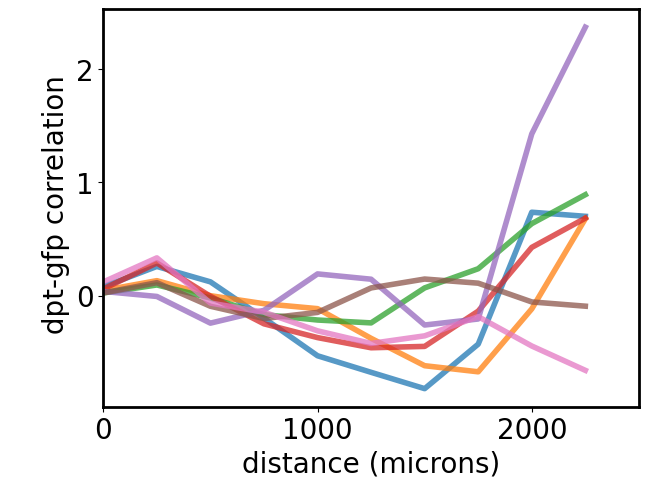

In [277]:
# spatial autocorrelation for E coli group
df = df_mod_eL3_24
thresh = np.quantile(df_eL3_ctl.dpt_gfp, q=0.95)
distance_bin_edges = np.linspace(0, 2500, 11)
plt.figure()
all_correlations = get_all_spatial_correlations(df, thresh, distance_bin_edges)
for correlations in all_correlations:
    plt.plot(distance_bin_edges[:-1], correlations, label=str(larvae), linewidth=4, alpha=0.75)

#plt.legend(loc=3)
plt.xlim([0, 2500])
#plt.ylim([-1, 1])
plt.xlabel('distance (microns)', fontsize=fontsize)
plt.ylabel('\n dpt-gfp correlation', fontsize=fontsize)
plt.xticks([0, 1000, 2000])
#plt.yticks([-1, 0, 1])
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/spatial_correlation_individuals.pdf')

In [71]:
sub_df = df[df.experiment_id == 0]
distance_matrix = build_distance_matrix_from_df(sub_df)
intens = sub_df.dpt_gfp.values.astype('float64')
intens = intens - thresh
intens[intens < 0] = 0
np.random.shuffle(intens)


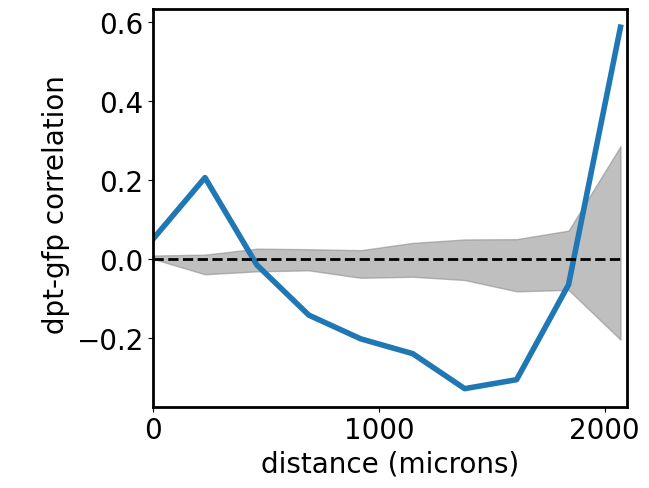

In [272]:
# spatial autocorrelations with uncertainties
df = df_mod_eL3_24
thresh = np.quantile(df_eL3_ctl.dpt_gfp, q=0.95)
distance_bin_edges = np.linspace(0, 2300, 11)
plt.figure()
all_correlations = get_all_spatial_correlations(df, thresh, distance_bin_edges)
lower, upper, _ = get_all_spatial_correlation_uncertainties(df, thresh, distance_bin_edges, num_scrambles=10)
plt.fill_between(distance_bin_edges[:-1], lower, upper, color=[0.5, 0.5, 0.5], alpha=0.5)
plt.plot(distance_bin_edges[:-1], np.nanmean(all_correlations, axis=0), linewidth=4)
plt.plot(distance_bin_edges[:-1], np.zeros(distance_bin_edges[:-1].shape), 'k--', linewidth=2)

# style
plt.xlim([0, 2100])
#plt.ylim([-1, 1])
plt.xlabel('distance (microns)', fontsize=fontsize)
plt.ylabel('\n dpt-gfp correlation', fontsize=fontsize)
plt.xticks([0, 1000, 2000])
#plt.yticks([-1, 0, 1])
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)



/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-pac

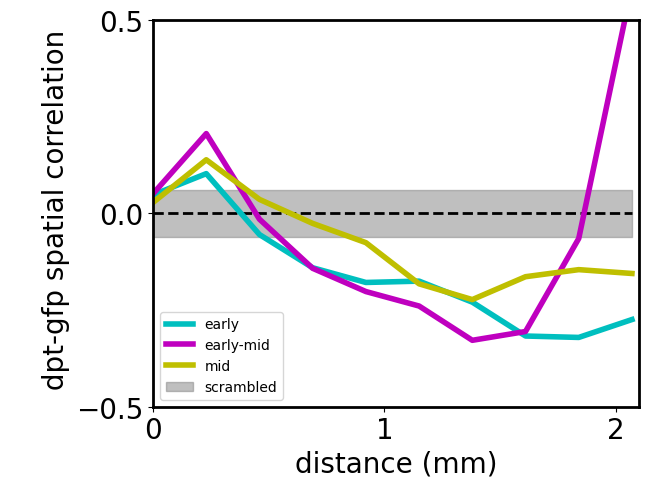

In [280]:
# spatial autocorrelations with uncertainties for all groups
thresh = np.quantile(df_eL3_ctl.dpt_gfp, q=0.95)
distance_bin_edges = np.linspace(0, 2300, 11)
plt.figure()
plt.plot(distance_bin_edges[:-1], np.zeros(distance_bin_edges[:-1].shape), 'k--', linewidth=2, label='_nolabel_')

lowers = np.zeros((3, len(distance_bin_edges) - 1))
uppers = np.zeros((3, len(distance_bin_edges) - 1))

# eL3_24
df = df_eL3_24
counter = 0
all_correlations = get_all_spatial_correlations(df, thresh, distance_bin_edges)
lowers[counter], uppers[counter], _ = get_all_spatial_correlation_uncertainties(df, thresh, distance_bin_edges, num_scrambles=10)
#plt.fill_between(distance_bin_edges[:-1], lower, upper, color=[0.5, 0.5, 0.5], alpha=0.5)
plt.plot(distance_bin_edges[:-1], np.nanmean(all_correlations, axis=0), linewidth=4, color='c', alpha=1, label='early')

# mod_eL3_24
df = df_mod_eL3_24
counter = 1
all_correlations = get_all_spatial_correlations(df, thresh, distance_bin_edges)
lowers[counter], uppers[counter], _ = get_all_spatial_correlation_uncertainties(df, thresh, distance_bin_edges, num_scrambles=10)
#plt.fill_between(distance_bin_edges[:-1], lower, upper, color=[0.5, 0.5, 0.5], alpha=0.5)
plt.plot(distance_bin_edges[:-1], np.nanmean(all_correlations, axis=0), linewidth=4, color='m', alpha=1, label='early-mid')

# mL3_24
df = df_mL3_24
counter = 2
all_correlations = get_all_spatial_correlations(df, thresh, distance_bin_edges)
lowers[counter], uppers[counter], _ = get_all_spatial_correlation_uncertainties(df, thresh, distance_bin_edges, num_scrambles=10)
#plt.fill_between(distance_bin_edges[:-1], lower, upper, color=[0.5, 0.5, 0.5], alpha=0.5)
plt.plot(distance_bin_edges[:-1], np.nanmean(all_correlations, axis=0), linewidth=4, color='y', alpha=1, label='mid')

#uncertainty
plt.fill_between(distance_bin_edges[:-1], np.nanmean(lower, axis=0), np.nanmean(upper, axis=0), color=[0.5, 0.5, 0.5], alpha=0.5, label='scrambled')

# style
plt.xlim([0, 2100])
plt.ylim([-0.5, 0.5])
plt.xlabel('distance (mm)', fontsize=fontsize)
plt.ylabel('\n dpt-gfp spatial correlation', fontsize=fontsize)
plt.xticks([0, 1000, 2000], labels=[0, 1, 2])
plt.yticks([-0.5, 0, 0.5])
plt.minorticks_off()
plt.legend(loc=3)

ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/spatial_correlations_3colors.pdf')

In [102]:
lowers[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [43]:
for i , val in enumerate(np.unique(df.experiment_id)):
    print(i)

0
1
2
3
4
5
6


(array([6296., 9256., 8207., 5424., 3992., 2460., 1473.,  781.,  268.,
          69.]),
 array([  16.1475419 ,  218.36996541,  420.59238892,  622.81481243,
         825.03723594, 1027.25965945, 1229.48208296, 1431.70450647,
        1633.92692998, 1836.14935348, 2038.37177699]),
 <BarContainer object of 10 artists>)

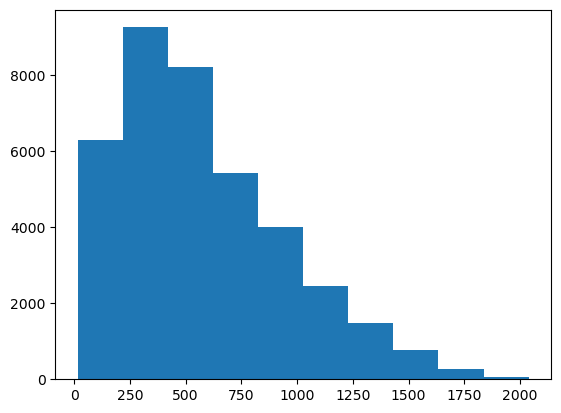

In [275]:
plt.hist(distance_matrix[distance_matrix > 0])

In [465]:
# spatial autocorrelation for mock group
df = df_eL3_ctl
distance_bin_edges = np.linspace(0, 2500, 11)
thresh = np.quantile(df_eL3_ctl.dpt_gfp, q=0.95)
plt.figure()
for larvae in np.unique(df.experiment_id):
    sub_df = df[df.experiment_id == larvae]
    distance_matrix = build_distance_matrix_from_df(sub_df)
    intens = sub_df.dpt_gfp.values.astype('float64')
    intens = intens - thresh
    intens[intens < 0] = 0
    correlations, _ = spatial_correlation(intens, distance_matrix, distance_bin_edges)
    #plt.figure()
    plt.plot(distance_bin_edges[:-1], correlations, label=str(larvae), linewidth=4, alpha=0.75)
    #plt.xlim([0, 2500])
plt.xlim([0, 2500])
plt.ylim([-1, 0.5])
plt.xlabel('distance (microns)', fontsize=fontsize)
plt.ylabel('\n dpt-gfp correlation', fontsize=fontsize)
plt.xticks([0, 1000, 2000])
plt.yticks([-1, -0.5, 0, 0.5])
#plt.legend()
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/spatial_correlation_individuals_ctl.pdf')

/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2044464/3991071894.py:30: RuntimeWarning: invalid value encountered in double_scalars
  correlations[i] = np.mean(these_intens) / total_var
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py

# Testing simple mip vs cell seg quantification

In [128]:
df = pd.read_pickle(r'/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2022_02_24_uas-mcd8-gfp_r4-gal4_x_dipt_dtom2/ecoli_hs_gfp/larvae_4/manual_df.pkl')

In [129]:
df

y            x
0     367.004632  1293.539077
1     472.257853  1305.818619
2     545.935107  1260.208890
3     602.070158  1263.717331
4     675.747412  1235.649805
..           ...          ...
343  3373.255858  1019.469261
344  3525.622483  1004.463458
345  4730.734403  1649.452577
346  4824.232104  1588.275069
347  6501.997998   828.806583

[348 rows x 2 columns]

In [130]:
green_mip = np.array(Image.open(r'/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2022_02_24_uas-mcd8-gfp_r4-gal4_x_dipt_dtom2/ecoli_hs_gfp/larvae_4/mips/mip_green_0.tif'))
red_mip = np.array(Image.open(r'/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2022_02_24_uas-mcd8-gfp_r4-gal4_x_dipt_dtom2/ecoli_hs_gfp/larvae_4/mips/mip_red_0.tif'))

In [131]:
df = quantify_cells(df, green_mip, red_mip, r)

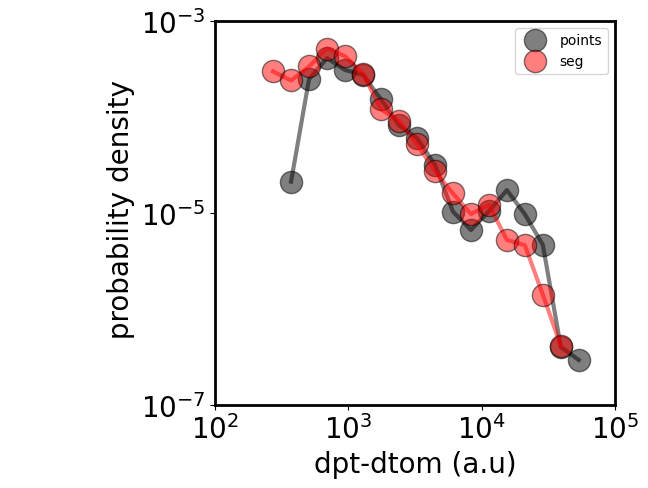

In [142]:
plt.figure()
num_bins = 20
bins = np.logspace(2.3, 5, num_bins+1)

# simple mip
counts, _bins = np.histogram(df.mem_mch, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'k-', linewidth=3, label='_no_label_', alpha=0.5)
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'ko', markersize=16, markerfacecolor='k', label='points', alpha=0.5)

# seg
counts, _bins = np.histogram(og_df.intensity_mean, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'r-', linewidth=3, label='_no_label_', alpha=0.5)
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'ko', markersize=16, markerfacecolor='r', label='seg', alpha=0.5)

plt.yscale('log')
plt.xscale('log')
plt.xlim([1e2, 1e5])
plt.xlabel('dpt-dtom (a.u)', fontsize=fontsize)
plt.ylabel('\n \n \n probability density', fontsize=fontsize)
plt.yticks([1e-7, 1e-5, 1e-3])
plt.xticks([1e2, 1e3, 1e4, 1e5])
#plt.title('raw distributions, E. coli vs mock, 24hrs')
plt.legend()
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [134]:
og_df = pd.read_pickle(r'/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2022_02_24_uas-mcd8-gfp_r4-gal4_x_dipt_dtom2/ecoli_hs_gfp/larvae_4/df.pkl')

In [140]:
og_df

label                                 centroid  intensity_mean
0       75   (956.2481560789912, 919.1425172495836)     2468.953605
1       76  (986.9685372585096, 1398.8502299908005)    34103.805244
2       77  (987.8418444481774, 1599.0865110028558)    23100.602217
3       81   (998.8694088882497, 865.8868114482957)     2027.557601
4       82  (1001.893815370623, 1793.2457177504928)    17840.501440
..     ...                                      ...             ...
333    809   (7200.742272502473, 584.3401953511375)      357.802423
334    814             (7201.62, 961.3719047619047)      646.765238
335    816   (7208.971252204586, 1215.068959435626)      547.215168
336    817   (7243.874541284404, 739.4926605504587)      355.424771
337    821  (7307.957225978927, 1118.9392986318603)      424.983802

[338 rows x 3 columns]

# Compare mip masked to raw mip for control larvae

In [5]:
larvae_dir = r'/media/brandon/Data1/Brandon/fly_immune/Lightsheet_Z1/2023_02_21-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ctl-inj_earlyL3_24hrs/larvae_1'


In [12]:
# raw mip
green_mip_raw = np.array(Image.open(larvae_dir + '/mips/mip_green_0.tif'))
red_mip_raw = np.array(Image.open(larvae_dir + '/mips/mip_red_0.tif'))

# masked mip
green_mip_masked = np.array(Image.open(larvae_dir + '/mips_masked/mip_masked_green_0.tif'))
red_mip_masked = np.array(Image.open(larvae_dir + '/mips_masked/mip_masked_red_0.tif'))

df = pd.read_pickle(larvae_dir + '/manual_df.pkl')
df = quantify_cells(df, green_mip_raw, red_mip_raw, r=r)
df_raw = df.copy()
print('done with raw')

df = pd.read_pickle(larvae_dir + '/manual_df.pkl')
df = quantify_cells(df, green_mip_masked, red_mip_masked, r=r)
df_masked = df.copy()


done with raw


In [13]:
df_raw

y            x     dpt_gfp      mem_mch
0    1467.470332  1540.584049  366.828958  3536.235481
1    1572.019764  1424.230649  463.281623  4521.182180
2    1339.312964  1371.955933  361.726333  3672.690533
3    1320.763871  1449.524867  336.473349  4465.669849
4    1354.489494  1616.466702  314.275259  3657.501193
..           ...          ...         ...          ...
182  4440.566539  1874.219923  710.878282  4102.375497
183  4170.321657  1849.274242  503.295147  4640.590294
184  4124.587907  1922.032480  480.730310  4099.693715
185  4299.207678  1932.426514  550.021480  3983.813047
186  4304.756914  1755.191931  596.880668  4733.310263

[187 rows x 4 columns]

In [14]:
df_masked

y            x     dpt_gfp      mem_mch
0    1467.470332  1540.584049  321.686555  2666.053302
1    1572.019764  1424.230649  376.736675  3676.362768
2    1339.312964  1371.955933  326.540175  3672.518695
3    1320.763871  1449.524867  304.027049  4465.657120
4    1354.489494  1616.466702  290.206842  3383.957041
..           ...          ...         ...          ...
182  4440.566539  1874.219923  509.105012  4102.375497
183  4170.321657  1849.274242  427.851233  3915.227526
184  4124.587907  1922.032480  438.582339  3998.819411
185  4299.207678  1932.426514  473.618138  3967.334924
186  4304.756914  1755.191931  422.442323  4526.381862

[187 rows x 4 columns]

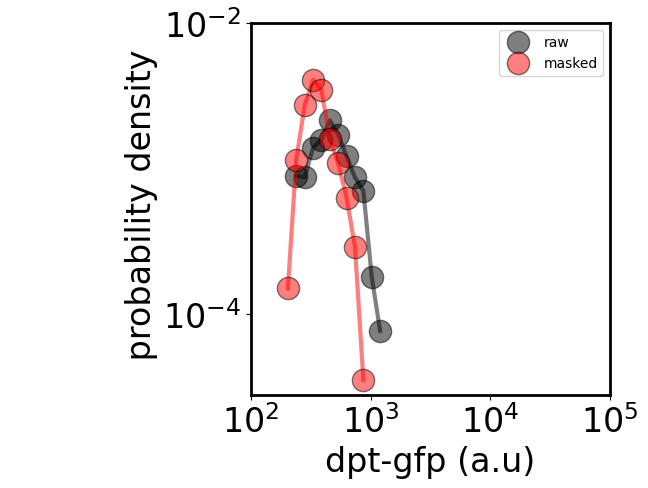

In [25]:
plt.figure()
num_bins = 20
bins = np.logspace(2.1, 3.5, num_bins+1)
fontsize = 24

# raw
counts, _bins = np.histogram(df_raw.dpt_gfp, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'k-', linewidth=3, label='_no_label_', alpha=0.5)
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'ko', markersize=16, markerfacecolor='k', label='raw', alpha=0.5)

# masked
counts, _bins = np.histogram(df_masked.dpt_gfp, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'r-', linewidth=3, label='_no_label_', alpha=0.5)
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'ko', markersize=16, markerfacecolor='r', label='masked', alpha=0.5)

plt.yscale('log')
plt.xscale('log')
plt.xlim([1e2, 1e5])
plt.xticks([1e2, 1e3, 1e4, 1e5])
plt.xlabel('dpt-gfp (a.u)', fontsize=fontsize)
plt.ylabel('\n \n \n probability density', fontsize=fontsize)
plt.yticks([1e-4, 1e-2])
#plt.title('raw distributions, E. coli vs mock, 24hrs')
plt.legend()
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Arial'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# High Dose Analysis

Early-Mid, High does, 24 hours.

In [3]:
emL3_24_experiment_paths = [r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_05_03-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose', 
                            r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_06_01-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose',
                            r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_06_07-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose']


In [13]:
df_emL3_24 = quantify_experiments(emL3_24_experiment_paths, r=r)

/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_05_03-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_4
/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_05_03-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_1
/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_05_03-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_5
/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_05_03-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_2
/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_05_03-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_6
/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_06_01-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_4
/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_06_01-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-

In [15]:
df_emL3_24 = quantify_experiments(emL3_24_experiment_paths, r=r)

/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_05_03-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_4
/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_05_03-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_1
/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_05_03-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_5
/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_05_03-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_2
/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_05_03-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_3
/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_05_03-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_6
/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_06_01-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-

In [31]:
#df_emL3_24.to_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/df_emL3_24.pkl')

In [32]:
df_emL3_24

experiment_id            y            x      dpt_gfp      mem_mch
0                0    240.70486  1269.328656  5927.750994  9018.343675
1                0   396.410604  1258.712355  4821.583134  8898.338107
2                0   592.812167  1260.481739  6446.630867  8355.653142
3                0   713.130241   634.119998  2272.979316  8869.243437
4                0   859.989067   605.809863  2142.789181  9112.609387
...            ...          ...          ...          ...          ...
6126            19  4787.100318  1505.411505  1899.669849  8088.492442
6127            19  4660.289762  1561.294123  2062.060461  9410.208433
6128            19  4838.684273  1720.344651   930.402546  6819.805887
6129            19  4666.737756  1165.817135   879.618934  7400.588703
6130            19  9859.153395  2905.878809  3715.413683  9748.448687

[6131 rows x 5 columns]

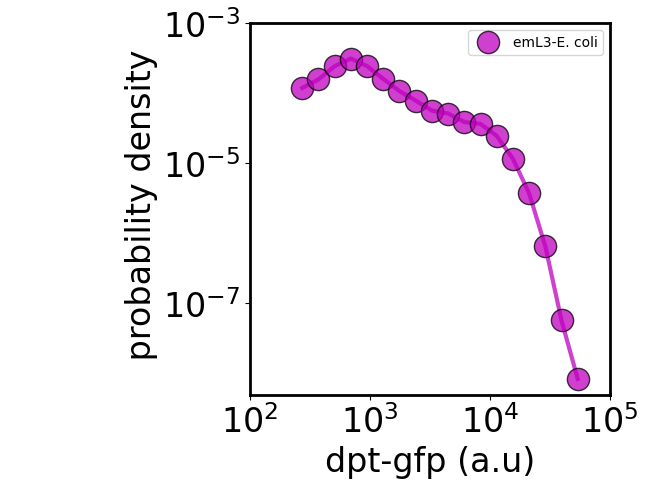

In [36]:
num_bins = 20
bins = np.logspace(2.3, 5, num_bins+1)

# ml3_24
df = df_emL3_24
intens = df.dpt_gfp 
counts, _bins = np.histogram(intens, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths

plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'm-', linewidth=3, label='_no_label_', alpha=0.75)
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'ko', markersize=16, markerfacecolor='m', label='emL3-E. coli', alpha=0.75)





plt.yscale('log')
plt.xscale('log')
plt.xlim([1e2, 1e5])
plt.xlabel('dpt-gfp (a.u)', fontsize=fontsize)
plt.ylabel('\n \n \n probability density', fontsize=fontsize)
plt.yticks([1e-7, 1e-5, 1e-3])
plt.xticks([1e2, 1e3, 1e4, 1e5])
#plt.title('raw distributions, E. coli vs mock, 24hrs')
plt.legend()
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


In [34]:
bins

array([ 125.89254118,  147.91083882,  173.78008287,  204.17379447,
        239.8832919 ,  281.83829313,  331.13112148,  389.04514499,
        457.08818961,  537.03179637,  630.95734448,  741.3102413 ,
        870.96358996, 1023.29299228, 1202.26443462, 1412.53754462,
       1659.58690744, 1949.84459976])

In [67]:
"""noise floor subtracted dist, plot every dist individually"""
thresh = 0 #* np.quantile(df_eL3_ctl.dpt_gfp, q=0.95)
num_bins = 10
bins = np.logspace(1, 5, num_bins+1)
df = df_emL3_24 # df_eL4_24
plt.figure()
counter = 1

for i, larvae in enumerate(np.unique(df.experiment_id)):
    plt.subplot(2, 6, counter)
    sub_df = df[df.experiment_id == larvae]
    intens = sub_df.dpt_gfp #- (sub_df.bkg - 300)
    if np.median(intens < 4000):
        continue
    bins = np.logspace(np.log10(np.min(intens)), np.log10(np.max(intens)), num_bins+ 1 )
    counts, _bins = np.histogram(intens, bins)
    bin_widths = np.diff(bins)
    bins = bins[:-1]
    prob_dens = counts / np.sum(counts) / bin_widths
    plot_bins = bins[prob_dens > 0]
    prob_dens = prob_dens[prob_dens > 0]
    
    #plt.plot(bins, prob_dens, 'c-', linewidth=3, alpha=0.5, label='_no_label_')
    plt.plot(plot_bins, prob_dens, '-', linewidth=4, alpha=1, label=str(larvae))
    #plt.plot(plot_bins, prob_dens, 'o', linewidth=3, alpha=0.5, label='_no_label_')
#plt.plot(bins_ctl, prob_dens_ctl, 'k--', alpha=0.5, label='mock', linewidth=3)    

    plt.yscale('log')
    plt.xscale('log')
    plt.xlim([1e2, 1e5])
#     #plt.xlabel('dpt-gfp (a.u)', fontsize=fontsize)
#     #plt.ylabel('\n \n \n probability density', fontsize=fontsize)
    plt.ylim([1e-6, 1e-2])
    #plt.ylim([1e-6, 2e-3])

    plt.yticks([1e-5, 1e-3])
#     #plt.title('raw distributions, E. coli vs mock, 24hrs')
#     #plt.legend()
#     plt.minorticks_off()
#     ax = plt.gca()
#     fontweight = 'bold'
#     fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#     ax.xaxis.set_tick_params(labelsize=20)
#     ax.yaxis.set_tick_params(labelsize=20)
#     for tick in ax.xaxis.get_major_ticks():
#         tick.label1.set_fontsize(fontsize)
#     for tick in ax.yaxis.get_major_ticks():
#         tick.label1.set_fontsize(fontsize)

#     plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    counter += 1 
#
# num_bins = 20
# bins = np.logspace(2.3, 5, num_bins+1)
# intens = df.dpt_gfp - (df.bkg - 300)
# counts, _bins = np.histogram(intens, bins)
# bin_widths = np.diff(bins)
# bins = bins[:-1]
# prob_dens = counts / np.sum(counts) / bin_widths
# #plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'k--', linewidth=6, label='pooled', alpha=0.75)
#plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'ko', markersize=16, markerfacecolor='m', label='mod_eL3-E. coli', alpha=0.75)

# plt.yscale('log')
# plt.xscale('log')
# plt.xlim([1e2, 1e5])
# plt.xlabel('dpt-gfp (a.u)', fontsize=fontsize)
# plt.ylabel('\n \n \n probability density', fontsize=fontsize)
# plt.ylim([1e-6, 1e-2])
# plt.yticks([1e-5, 1e-3])
# #plt.title('raw distributions, E. coli vs mock, 24hrs')
# plt.legend()
# plt.minorticks_off()
# ax = plt.gca()
# fontweight = 'bold'
# fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
# ax.xaxis.set_tick_params(labelsize=20)
# ax.yaxis.set_tick_params(labelsize=20)
# for tick in ax.xaxis.get_major_ticks():
#     tick.label1.set_fontsize(fontsize)
# for tick in ax.yaxis.get_major_ticks():
#     tick.label1.set_fontsize(fontsize)
    
# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/mL3_24_bkg_sub_dists_individuals.pdf')

In [40]:
%matplotlib qt

In [653]:
# scatter plot of total intensities
plt.figure()
fontsize = 20

all_intens = df_emL3_24.groupby(by='experiment_id').median().dpt_gfp.values
sigma_x = 0.02

# plot mock here

# partial
intens = all_intens[partial_ids]
plt.plot(np.ones(len(intens)) + sigma_x * np.random.normal(size=len(intens)), 
         intens, 'ko', markerfacecolor='g', markersize=16, alpha=0.75)

# complete
intens = all_intens[complete_ids]
plt.plot(np.ones(len(intens)) + sigma_x * np.random.normal(size=len(intens)), 
         intens, 'ko', markerfacecolor='c', markersize=16, alpha=0.75)

plt.xticks([0, 1], labels=['mock', 'E. coli'], fontsize=fontsize)
plt.xlim([-0.5, 1.5])
plt.yticks([1e2, 1e3, 1e4])
plt.ylim([1e2, 2e4])
plt.ylabel('\n \n \n \n \n median dpt-gfp per cell (a.u.)', fontsize=fontsize)
plt.yscale('log')
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Arial'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/tot_inten_dot_plot.pdf')


In [654]:
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/median_inten_dot_plot.pdf')

In [70]:
# scatter plot of skew
plt.figure()
fontsize = 20

intens = df_emL3_24.groupby(by='experiment_id').skew().dpt_gfp.values
sigma_x = 0.02

plt.plot(np.ones(len(intens)) + sigma_x * np.random.normal(size=len(intens)), 
         intens, 'ko', markerfacecolor='c', markersize=16, alpha=0.75)

plt.xticks([1], labels=['E. coli'], fontsize=fontsize)
plt.xlim([0.5, 1.5])
#plt.yticks([1e2, 1e3, 1e4])
#plt.ylim([1e2, 6e4])
plt.ylabel('\n \n \n \n \n skew dpt-gfp per cell (a.u.)', fontsize=fontsize)
#plt.yscale('log')
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Arial'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/tot_inten_dot_plot.pdf')


In [71]:
plt.close('all')

## plot pooled dists for 'partial' and 'complete' subsets

In [46]:
df_emL3_24 = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/df_emL3_24.pkl')

In [56]:
bkg = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/emL3_24_backgrounds.pkl')

In [72]:
df_emL3_mock = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/df_emL3_mock.pkl')

In [74]:
all_mock_intens = df_emL3_mock.dpt_gfp.values
num_bins = 30
bins = np.logspace(1, 5, num_bins+1)
counts, _bins = np.histogram(all_mock_intens, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths

plt.figure()
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'k-', linewidth=3, label='_no_label_', alpha=0.75)
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'ko', markersize=16, markerfacecolor=(0.5,0.5,0.5), label='emL3-mock', alpha=0.75)
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e2, 1e5])
plt.xlabel('dpt-gfp (a.u)', fontsize=24)
plt.ylabel('\n \n \n probability density', fontsize=24)
plt.yticks([1e-7, 1e-5, 1e-3])
plt.xticks([1e2, 1e3, 1e4, 1e5])
#plt.title('raw distributions, E. coli vs mock, 24hrs')
#plt.legend()
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [99]:
# partial
"""noise floor subtracted dist, plot every dist individually"""
thresh = 0 #* np.quantile(df_eL3_ctl.dpt_gfp, q=0.95)
num_bins = 10
df = df_emL3_24 # df_eL4_24

all_intens = [] 
partial_ids = []
plt.figure()
# plot mock
all_mock_intens = df_emL3_mock.dpt_gfp.values
bins = np.logspace(np.log10(np.min(all_mock_intens)), np.log10(np.max(all_mock_intens)), num_bins+1)
counts, _bins = np.histogram(all_mock_intens, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths

plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], '--', color=(0.0,0.0,0.0), linewidth=4, label='mock', alpha=0.75)

for i, larvae in enumerate(np.unique(df.experiment_id)):
    sub_df = df[df.experiment_id == larvae]
    intens = sub_df.dpt_gfp.values 
    if np.median(intens <= 4000):
        continue
    #intens = intens - (bkg.iloc[i].background - 300)
    intens[intens < 0] = 0
    #all_intens.extend(intens.to_list())
    all_intens.extend(intens)
    
    # plot this larvae
    #bins = np.logspace(np.log10(np.min(intens)), np.log10(np.max(intens)), num_bins+ 1 )
    bins = np.logspace(np.log10(300), np.log10(np.max(intens)), num_bins+ 1 )

    #bins = np.logspace(1, 5, num_bins+1)

    counts, _bins = np.histogram(intens, bins)
    bin_widths = np.diff(bins)
    bins = bins[:-1]
    prob_dens = counts / np.sum(counts) / bin_widths
    plot_bins = bins[prob_dens > 0]
    prob_dens = prob_dens[prob_dens > 0]
    
    plt.plot(plot_bins, prob_dens, '-', color='g', linewidth=4, alpha=0.25, label='_no_label_')
    #plt.plot(plot_bins, prob_dens, '-', linewidth=4, alpha=0.85, label=str(larvae))

    partial_ids.append(i)
    
num_bins = 30
bins = np.logspace(np.log10(300), 5, num_bins+1)
counts, _bins = np.histogram(all_intens, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths


plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'g-', linewidth=3, label='_no_label_', alpha=0.75)
plt.plot(bins[prob_dens > 0], prob_dens[prob_dens > 0], 'ko', markersize=16, markerfacecolor='g', label='E. coli', alpha=0.75)


# # lognormal fit
# fit = powerlaw.Fit(all_intens, xmin=1)
# R, p = fit.distribution_compare('power_law', 'lognormal')
# fit.lognormal.plot_pdf()

# # power law fit
# fit = powerlaw.Fit(all_intens)
# fit.power_law.plot_pdf()

plt.yscale('log')
plt.xscale('log')
plt.xlim([1e2, 1e5])
plt.xlabel('dpt-gfp (a.u)', fontsize=24)
plt.ylabel('\n \n \n probability density', fontsize=24)
plt.yticks([1e-7, 1e-5, 1e-3])
plt.xticks([1e2, 1e3, 1e4, 1e5])
#plt.title('raw distributions, E. coli vs mock, 24hrs')
plt.legend()
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


In [68]:
all_intens

[5527.750994431185,
 4421.583134447096,
 6046.630867143994,
 1872.9793158313446,
 1742.7891805887034,
 2221.3914081145585,
 3791.431185361973,
 4133.382657120127,
 3674.2307080350038,
 5342.32060461416,
 2661.9992044550518,
 2393.441527446301,
 3256.431185361973,
 3345.011137629276,
 4926.0087509944315,
 4285.886237072395,
 3788.5696101829753,
 3409.275258552108,
 3557.1471758154335,
 2308.4574383452664,
 4921.996022275259,
 4383.5815433572,
 2357.416865552904,
 3321.194908512331,
 4319.259347653142,
 2534.510739856802,
 1619.6149562450278,
 1684.09307875895,
 1751.736674622116,
 2415.8695306284803,
 2708.8042959427207,
 3638.8973747016707,
 4088.178997613365,
 2064.2943516308674,
 1834.1678599840893,
 3450.728719172633,
 3492.684168655529,
 3923.1392203659507,
 3706.101034208433,
 3671.9681782020684,
 4251.914876690533,
 3644.146380270485,
 3824.2322991249002,
 1385.9307875894988,
 2079.907716785998,
 2951.785202863962,
 3061.365155131265,
 3614.494828957836,
 1540.3914081145585,
 202

In [61]:
plt.close('all')

In [100]:
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/complete_pdfs_mock_and_indivs.pdf')

In [578]:
partial_ids

[0, 1, 2, 3, 5, 6, 8, 11, 13, 16, 18, 19]

In [8]:
partial_ids = [0, 1, 2, 3, 5, 6, 8, 11, 13, 16, 18, 19]

In [110]:
m = np.mean(all_intens)
s = np.std(all_intens)
np.sum(all_intens > m + 2 * s) / len(all_intens)

0.045216741405082216

In [112]:
%pip install powerlaw

  Using cached powerlaw-1.5-py3-none-any.whl (24 kB)
     |████████████████████████████████| 536 kB 5.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [113]:
import powerlaw

In [115]:
fit = powerlaw.Fit(all_intens)

Calculating best minimal value for power law fit


In [116]:
R, p = fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)

In [117]:
fit.lognormal.mu

7.225523237412018

In [118]:
fit.lognormal.sigma

1.068881241647688

In [119]:
plt.figure()
fit.lognormal.plot_pdf()

<AxesSubplot:>

In [129]:
np.exp(7.2255)

1374.025456632947

In [130]:
np.log10(np.exp(7.22))

3.135606159341478

In [133]:
fit.alpha

2.3139316838326867

In [142]:
fig = fit.plot_ccdf()
fit.power_law.plot_ccdf(color='r', ax=fig)
fit.lognormal.plot_ccdf(color='b', ax=fig)

<AxesSubplot:>

In [143]:
plt.close('all')

In [407]:
def bta_pdf(a, l, L, mu, sigma):
    b_min = np.exp(-L / l)
    normalization = bta_normalization(a, l, L, mu, sigma)
    return normalization * (1 / a) * (lognorm_cdf(1 / a, -mu, sigma) - lognorm_cdf(b_min / a, -mu, sigma))

def lognorm_cdf(x, mu, sigma):
    return 0.5 * (1 + erf((np.log(x) - mu) / np.sqrt(2) / sigma))

def bta_normalization(a, l, L, mu, sigma):
    #     big_a_arr = np.linspace(0.01, 1e5, int(1e7))
#     da = np.diff(big_a_arr)[0]
#     normalization = 1 / np.sum((1 / big_a_arr) 
#                                * (lognorm_cdf(1 / big_a_arr, -mu, sigma) 
#                                   - lognorm_cdf(b_min / big_a_arr, -mu, sigma)) * da)
#    normalization = (1 / (L/l)/ sigma / np.sqrt(2 * np.pi) / 2)
    normalization = 1 / (mu * erf(mu / np.sqrt(2) / sigma) 
                         - (mu - L/l) * erf((mu - L/l) / np.sqrt(2) / sigma)
                        + (np.exp(-mu ** 2 / 2 / sigma / sigma) 
                           - np.exp(-(mu - L/l) ** 2 / 2 / sigma / sigma)) / np.sqrt(np.pi))
    return normalization

In [408]:
num_samples = int(1e6)
mu = 8.2
sigma = 0.25
L = 1
T = np.random.lognormal(mu, sigma, size=num_samples)
x = L * np.random.uniform(size=num_samples)
l = 0.5
B = np.exp(-x / l)
A = B * T

num_bins = 100
bins = np.logspace(2, 5, num_bins+1)
counts, _bins = np.histogram(A, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths

plt.figure()
plt.plot(bins, prob_dens)

a_arr = np.logspace(2, 5, 1000)
theory = bta_pdf(a_arr, l, L, mu, sigma)
plt.plot(a_arr, theory)

plt.yscale('log')
plt.xscale('log')
plt.xlim([1e2, 1e5])
plt.ylim([1e-8, 1e-2])
plt.yticks([1e-7, 1e-5, 1e-3])
plt.xticks([1e2, 1e3, 1e4, 1e5])
#plt.title('raw distributions, E. coli vs mock, 24hrs')
#plt.legend()
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [389]:
plt.close('all')

In [370]:
def normalization(a, l, L, mu, sigma):
    return 1 / (mu * erf(mu / np.sqrt(2) / sigma) 
                         - (mu - L/l) * erf((mu - L/l) / np.sqrt(2) / sigma)
                        + (np.exp(-mu ** 2 / 2 / sigma / sigma) 
                           - np.exp(-(mu - L/l) ** 2 / 2 / sigma / sigma)) / np.sqrt(np.pi))

In [402]:
a = 100
l_arr = np.linspace(0.04, 0.09, 100)
Z = normalization(a, l_arr, L, mu, sigma)
plt.figure()
plt.plot(l_arr, 1 / Z)


In [309]:
l = 1
L = 1
mu = 7.2
sigma = 0.5
a_arr = np.logspace(2, 5, 1000)
theory = bta_pdf(a_arr, l, L, mu, sigma)

plt.figure()
plt.plot(a_arr, theory)
plt.xscale('log')
plt.yscale('log')

In [369]:
theory

array([8.70859598e-02, 8.64775198e-02, 8.58731803e-02, 8.52729124e-02,
       8.46766875e-02, 8.40844771e-02, 8.34962530e-02, 8.29119870e-02,
       8.23316513e-02, 8.17552183e-02, 8.11826604e-02, 8.06139503e-02,
       8.00490610e-02, 7.94879656e-02, 7.89306372e-02, 7.83770495e-02,
       7.78271760e-02, 7.72809905e-02, 7.67384672e-02, 7.61995801e-02,
       7.56643037e-02, 7.51326126e-02, 7.46044815e-02, 7.40798854e-02,
       7.35587992e-02, 7.30411984e-02, 7.25270583e-02, 7.20163547e-02,
       7.15090632e-02, 7.10051599e-02, 7.05046209e-02, 7.00074225e-02,
       6.95135413e-02, 6.90229538e-02, 6.85356369e-02, 6.80515676e-02,
       6.75707229e-02, 6.70930803e-02, 6.66186172e-02, 6.61473112e-02,
       6.56791402e-02, 6.52140820e-02, 6.47521149e-02, 6.42932170e-02,
       6.38373668e-02, 6.33845429e-02, 6.29347240e-02, 6.24878891e-02,
       6.20440171e-02, 6.16030873e-02, 6.11650790e-02, 6.07299718e-02,
       6.02977452e-02, 5.98683790e-02, 5.94418533e-02, 5.90181482e-02,
      

In [150]:
np.max(np.log10(A))

4.0099952128092475

In [156]:
B

array([0.73417023, 0.57757965, 0.47148867, ..., 0.63690428, 0.51127856,
       0.44210138])

In [159]:
counts

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,  78917, 306942, 306453, 307688,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0])

In [178]:
plt.figure()
bins = np.logspace(np.log(0.36788), 0, 30)
counts, _bins = np.histogram(B, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths
plt.plot(bins, prob_dens)
plt.plot(bins, 1 / bins)

In [165]:
np.min(B)

0.3678801268991147

In [162]:
np.max(B)

0.9999979679656116

In [171]:
plt.figure()
plt.hist(B)

(array([100828., 100327., 100136., 100264.,  99995.,  99594., 100262.,
         99979.,  99462.,  99153.]),
 array([0.99004983, 0.99104485, 0.99203987, 0.99303488, 0.9940299 ,
        0.99502492, 0.99601993, 0.99701495, 0.99800996, 0.99900498,
        1.        ]),
 <BarContainer object of 10 artists>)

In [169]:
np.exp(-np.max(x))

0.3678801268991147

## 2d model

In [448]:
sx = 40 + 1
sy = sx // 4
l = 0.5 * sx
L = sx
sigma = 0.25
mu = 8.2
Y, X = np.indices((sy, sx))
B = np.exp(-X / l) #+ np.exp((X - sx) / l)
T = np.random.lognormal(mu, sigma, size=X.shape)
bkg = np.random.lognormal(np.log(500), 0.5, size=X.shape)
A = B * T  + 0* bkg

In [449]:
plt.figure()
plt.subplot(311)
plt.title('bacterial density, B', fontsize=24)
plt.xticks([0, sx // 2, sx // 1 - 1], fontsize=16)
plt.yticks([0, sy // 2, sy // 1 - 1], fontsize=16)

plt.imshow(B)

plt.subplot(312)
plt.title('receptor density, R', fontsize=24)
plt.xticks([0, sx // 2, sx // 1 - 1], fontsize=16)
plt.yticks([0, sy // 2, sy // 1 - 1], fontsize=16)
plt.ylabel('y', fontsize=24)
plt.imshow(np.log10(T))

plt.subplot(313)
plt.title('AMP concentration, A', fontsize=24)
plt.xticks([0, sx // 2, sx // 1 - 1], fontsize=16)
plt.yticks([0, sy // 2, sy // 1 - 1], fontsize=16)
plt.xlabel('x', fontsize=24)
plt.imshow(np.log10(A))


/tmp/ipykernel_2089289/3808348666.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


In [445]:
num_bins = 500
bins = np.logspace(1, 5, num_bins+1)
counts, _bins = np.histogram(A, bins)
bin_widths = np.diff(bins)
bins = bins[:-1]
prob_dens = counts / np.sum(counts) / bin_widths

plt.figure()
plt.plot(bins, prob_dens, linewidth=6, label='2D numerics')


a_arr = np.logspace(2, 5, 1000)
theory = bta_pdf(a_arr, l, L, mu, sigma)
plt.plot(a_arr, theory, '--', linewidth=4, label='theory')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e2, 1e4])
plt.ylim([1e-8, 1e-2])
plt.yticks([1e-7, 1e-5, 1e-3])
plt.xticks([1e2, 1e3, 1e4])
#plt.title('raw distributions, E. coli vs mock, 24hrs')
plt.xlabel('A (a.u)', fontsize=24)
plt.ylabel("probability density (1/a.u)", fontsize=24)
plt.legend(fontsize=16)
plt.minorticks_off()
ax = plt.gca()
fontweight = 'bold'
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

AttributeError: 'Figure' object has no property 'size'

In [450]:
plt.savefig(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/plots/theory/space_plus_noise_2d_3panel_example.png')

In [265]:
plt.figure()
plt.hist(np.log10(bkg.flatten()))

(array([16., 43., 54., 76., 95., 60., 31., 23.,  0.,  2.]),
 array([2.22435175, 2.3412224 , 2.45809306, 2.57496372, 2.69183437,
        2.80870503, 2.92557569, 3.04244634, 3.159317  , 3.27618765,
        3.39305831]),
 <BarContainer object of 10 artists>)

In [451]:
plt.close('all')

# AP analysis

In [5]:
def get_ap(loc, ap):
    """loc = (y,x) of interest, ap = ap DF"""
    distances = distance(loc, ap.values)
    ap_value = np.argwhere(distances == np.nanmin(distances))
    if len(ap_value) > 1:
        ap_value = ap_value[0]
    
    return ap_value
    

def distance(x, y):
    """ x = 1xd, y = Nxd"""
    return np.sqrt(np.sum((x - y) ** 2, axis=1))



def get_ap_for_cells(df, ap):
    """df = spots df, ap = ap df"""
    aps = np.zeros(len(df))
    locs = df.loc[:, ['y', 'x']].values.tolist()
    for i in range(len(locs)):
        aps[i] = get_ap(locs[i], ap)
    
    return aps

def bin_aps(df, bins):
    _counts, bins = np.histogram(df.ap, bins)
    bins = bins[1:]
    partial_func = partial(get_ap_bin, bins=bins)
    binned_aps = df.ap.apply(partial_func)
    df['binned_ap'] = binned_aps.values
    
    return df


def get_ap_bin(this_ap, bins):
    this_bin = np.where(np.abs(this_ap - bins) == np.nanmin(np.abs(this_ap - bins)))[0][0]

    return this_bin

def get_line_dist_from_mip(mip, ap, bkg=0, mask=None, n_bootstraps=None):
    # apply optional mask
    if mask is not None:
        mip *= mask
        
    # subtract background
    mip = mip.astype('float32')
    mip -= bkg
    mip[mip < 0] = 0
    intens = mip[mip > 0]
    Y, X = np.indices(mip.shape)
    good_Y = Y[mip > 0]
    good_X = X[mip > 0]
    
    line_dist = np.zeros(len(ap))
    
    for i in range(len(intens)):
        loc = (good_Y[i], good_X[i])
        inten = intens[i]
        this_ap = get_ap(loc, ap)
        line_dist[int(this_ap)] += inten
    
    if n_bootstraps is not None:
        line_dist_boot_strap = np.zeros((int(n_bootstraps), len(ap)))
        for n in range(int(n_bootstraps)):
            print(f'{n} of {n_bootstraps}')
            inds = np.random.randint(0, len(intens), len(intens))
            these_intens = intens[inds]
            these_Y = good_Y[inds]
            these_X = good_X[inds]
            for i in range(len(these_intens)):
                loc = (these_Y[i], these_X[i])
                inten = these_intens[i]
                this_ap = get_ap(loc, ap)
                line_dist_boot_strap[n, int(this_ap)] += inten
        
        std_line_dist = np.nanstd(line_dist_boot_strap, axis=0)
        
        return line_dist, std_line_dist

    else:
        return line_dist
                
    

In [79]:
np.random.randint(0, 5, 5)

array([1, 1, 2, 2, 4])

In [467]:
df = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/df_emL3_24.pkl')
experiment_paths = emL3_24_experiment_paths
df['ap'] = 0
counter = 0
for experiment_path in experiment_paths:
    larvae_dirs = glob(experiment_path + '/larvae*')
    for larvae_dir in larvae_dirs:
        if Path(larvae_dir + '/ap/ap.pkl').is_file():
            ap = pd.read_pickle(larvae_dir + '/ap/ap.pkl')
            sub_df = df[df.experiment_id == counter]
            aps = get_ap_for_cells(sub_df, ap)
            df.loc[sub_df.index, 'ap'] = aps
            print(counter)
            counter += 1

/tmp/ipykernel_2089289/3081587654.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ap'] = aps
/tmp/ipykernel_2089289/3081587654.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ap'] = aps
/tmp/ipykernel_2089289/3081587654.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


/tmp/ipykernel_2089289/3081587654.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ap'] = aps


In [494]:
bins = np.linspace(0, 99, 10)
df = bin_aps(df, bins)

In [505]:
df.dpt_gfp = df.dpt_gfp.astype('float64')

In [470]:
plt.figure()
plt.hist(df.ap)

(array([531., 750., 543., 668., 943., 925., 716., 552., 358., 145.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <BarContainer object of 10 artists>)

In [498]:
sub_df

experiment_id            y           x      dpt_gfp      mem_mch  ap  \
865              3   557.366753  644.298518  4066.346062  9884.771679   2   
866              3   697.974528   674.12441  3577.418457  8412.586317   4   
867              3   945.103344  601.690101  2188.642005  7186.396977   6   
868              3   855.625669  696.848898  1847.040573  7561.470167   5   
869              3   757.626311  576.125051   3524.61257  9215.061257   4   
...            ...          ...         ...          ...          ...  ..   
1231             3  6662.306519  480.613813  2717.732697  5631.961018  62   
1232             3  6839.146157  734.492502  2000.069212  3085.603023  64   
1233             3  6313.879904  547.147539    2032.6428  4854.530628  58   
1234             3  8835.545203  733.052434  2739.859189  5140.659507  83   
1235             3  9050.904367  696.283796   3676.70008   6865.11615  85   

      binned_ap  
865           0  
866           0  
867           0  
868           0  
869           0  
...         ...  
1231          5  
1232          5  
1233          4  
1234          7  
1235          7  

[371 rows x 7 columns]

In [504]:
sub_df.dpt_gfp.dtype

dtype('O')

In [514]:
sub_df = df[df.experiment_id == 8]
line_dist = sub_df.groupby('binned_ap').sum().dpt_gfp
plt.figure()
plt.plot(line_dist)

In [509]:
line_dist

binned_ap
0    182533.766110
1    126566.451074
2     74501.079554
3     85284.498011
4     92185.349244
5     72730.702466
6    122526.513126
7     96746.120923
8     16360.273667
Name: dpt_gfp, dtype: float64

In [510]:
plt.figure()
plt.plot(line_dist)

In [515]:
plt.close('all')

In [517]:
a = np.zeros(5, dtype='uint16')

In [518]:
a.astype('float32')

array([0., 0., 0., 0., 0.], dtype=float32)

In [534]:
test_dir = r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_05_03-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_1'
mip = np.array(Image.open(test_dir + '/mips/mip_red_0.tif'))
ap = pd.read_pickle(test_dir + '/ap/ap.pkl')
line_dist = get_line_dist_from_mip(mip, ap, bkg=300)

0 of 21488640
100 of 21488640
200 of 21488640
300 of 21488640
400 of 21488640
500 of 21488640
600 of 21488640
700 of 21488640
800 of 21488640
900 of 21488640
1000 of 21488640
1100 of 21488640
1200 of 21488640
1300 of 21488640
1400 of 21488640
1500 of 21488640
1600 of 21488640
1700 of 21488640
1800 of 21488640
1900 of 21488640
2000 of 21488640
2100 of 21488640
2200 of 21488640
2300 of 21488640
2400 of 21488640
2500 of 21488640
2600 of 21488640
2700 of 21488640
2800 of 21488640
2900 of 21488640
3000 of 21488640
3100 of 21488640
3200 of 21488640
3300 of 21488640
3400 of 21488640
3500 of 21488640
3600 of 21488640
3700 of 21488640
3800 of 21488640
3900 of 21488640
4000 of 21488640
4100 of 21488640
4200 of 21488640
4300 of 21488640
4400 of 21488640
4500 of 21488640
4600 of 21488640
4700 of 21488640
4800 of 21488640
4900 of 21488640
5000 of 21488640
5100 of 21488640
5200 of 21488640
5300 of 21488640
5400 of 21488640
5500 of 21488640
5600 of 21488640
5700 of 21488640
5800 of 21488640
5900 of 2

55200 of 21488640
55300 of 21488640
55400 of 21488640
55500 of 21488640
55600 of 21488640
55700 of 21488640
55800 of 21488640
55900 of 21488640
56000 of 21488640
56100 of 21488640
56200 of 21488640
56300 of 21488640
56400 of 21488640
56500 of 21488640
56600 of 21488640
56700 of 21488640
56800 of 21488640
56900 of 21488640
57000 of 21488640
57100 of 21488640
57200 of 21488640
57300 of 21488640
57400 of 21488640
57500 of 21488640
57600 of 21488640
57700 of 21488640
57800 of 21488640
57900 of 21488640
58000 of 21488640
58100 of 21488640
58200 of 21488640
58300 of 21488640
58400 of 21488640
58500 of 21488640
58600 of 21488640
58700 of 21488640
58800 of 21488640
58900 of 21488640
59000 of 21488640
59100 of 21488640
59200 of 21488640
59300 of 21488640
59400 of 21488640
59500 of 21488640
59600 of 21488640
59700 of 21488640
59800 of 21488640
59900 of 21488640
60000 of 21488640
60100 of 21488640
60200 of 21488640
60300 of 21488640
60400 of 21488640
60500 of 21488640
60600 of 21488640
60700 of 2

102800 of 21488640
102900 of 21488640
103000 of 21488640
103100 of 21488640
103200 of 21488640
103300 of 21488640
103400 of 21488640
103500 of 21488640
103600 of 21488640
103700 of 21488640
103800 of 21488640
103900 of 21488640
104000 of 21488640
104100 of 21488640
104200 of 21488640
104300 of 21488640
104400 of 21488640
104500 of 21488640
104600 of 21488640
104700 of 21488640
104800 of 21488640
104900 of 21488640
105000 of 21488640
105100 of 21488640
105200 of 21488640
105300 of 21488640
105400 of 21488640
105500 of 21488640
105600 of 21488640
105700 of 21488640
105800 of 21488640
105900 of 21488640
106000 of 21488640
106100 of 21488640
106200 of 21488640
106300 of 21488640
106400 of 21488640
106500 of 21488640
106600 of 21488640
106700 of 21488640
106800 of 21488640
106900 of 21488640
107000 of 21488640
107100 of 21488640
107200 of 21488640
107300 of 21488640
107400 of 21488640
107500 of 21488640
107600 of 21488640
107700 of 21488640
107800 of 21488640
107900 of 21488640
108000 of 21

152600 of 21488640
152700 of 21488640
152800 of 21488640
152900 of 21488640
153000 of 21488640
153100 of 21488640
153200 of 21488640
153300 of 21488640
153400 of 21488640
153500 of 21488640
153600 of 21488640
153700 of 21488640
153800 of 21488640
153900 of 21488640
154000 of 21488640
154100 of 21488640
154200 of 21488640
154300 of 21488640
154400 of 21488640
154500 of 21488640
154600 of 21488640
154700 of 21488640
154800 of 21488640
154900 of 21488640
155000 of 21488640
155100 of 21488640
155200 of 21488640
155300 of 21488640
155400 of 21488640
155500 of 21488640
155600 of 21488640
155700 of 21488640
155800 of 21488640
155900 of 21488640
156000 of 21488640
156100 of 21488640
156200 of 21488640
156300 of 21488640
156400 of 21488640
156500 of 21488640
156600 of 21488640
156700 of 21488640
156800 of 21488640
156900 of 21488640
157000 of 21488640
157100 of 21488640
157200 of 21488640
157300 of 21488640
157400 of 21488640
157500 of 21488640
157600 of 21488640
157700 of 21488640
157800 of 21

198300 of 21488640
198400 of 21488640
198500 of 21488640
198600 of 21488640
198700 of 21488640
198800 of 21488640
198900 of 21488640
199000 of 21488640
199100 of 21488640
199200 of 21488640
199300 of 21488640
199400 of 21488640
199500 of 21488640
199600 of 21488640
199700 of 21488640
199800 of 21488640
199900 of 21488640
200000 of 21488640
200100 of 21488640
200200 of 21488640
200300 of 21488640
200400 of 21488640
200500 of 21488640
200600 of 21488640
200700 of 21488640
200800 of 21488640
200900 of 21488640
201000 of 21488640
201100 of 21488640
201200 of 21488640
201300 of 21488640
201400 of 21488640
201500 of 21488640
201600 of 21488640
201700 of 21488640
201800 of 21488640
201900 of 21488640
202000 of 21488640
202100 of 21488640
202200 of 21488640
202300 of 21488640
202400 of 21488640
202500 of 21488640
202600 of 21488640
202700 of 21488640
202800 of 21488640
202900 of 21488640
203000 of 21488640
203100 of 21488640
203200 of 21488640
203300 of 21488640
203400 of 21488640
203500 of 21

249900 of 21488640
250000 of 21488640
250100 of 21488640
250200 of 21488640
250300 of 21488640
250400 of 21488640
250500 of 21488640
250600 of 21488640
250700 of 21488640
250800 of 21488640
250900 of 21488640
251000 of 21488640
251100 of 21488640
251200 of 21488640
251300 of 21488640
251400 of 21488640
251500 of 21488640
251600 of 21488640
251700 of 21488640
251800 of 21488640
251900 of 21488640
252000 of 21488640
252100 of 21488640
252200 of 21488640
252300 of 21488640
252400 of 21488640
252500 of 21488640
252600 of 21488640
252700 of 21488640
252800 of 21488640
252900 of 21488640
253000 of 21488640
253100 of 21488640
253200 of 21488640
253300 of 21488640
253400 of 21488640
253500 of 21488640
253600 of 21488640
253700 of 21488640
253800 of 21488640
253900 of 21488640
254000 of 21488640
254100 of 21488640
254200 of 21488640
254300 of 21488640
254400 of 21488640
254500 of 21488640
254600 of 21488640
254700 of 21488640
254800 of 21488640
254900 of 21488640
255000 of 21488640
255100 of 21

299100 of 21488640
299200 of 21488640
299300 of 21488640
299400 of 21488640
299500 of 21488640
299600 of 21488640
299700 of 21488640
299800 of 21488640
299900 of 21488640
300000 of 21488640
300100 of 21488640
300200 of 21488640
300300 of 21488640
300400 of 21488640
300500 of 21488640
300600 of 21488640
300700 of 21488640
300800 of 21488640
300900 of 21488640
301000 of 21488640
301100 of 21488640
301200 of 21488640
301300 of 21488640
301400 of 21488640
301500 of 21488640
301600 of 21488640
301700 of 21488640
301800 of 21488640
301900 of 21488640
302000 of 21488640
302100 of 21488640
302200 of 21488640
302300 of 21488640
302400 of 21488640
302500 of 21488640
302600 of 21488640
302700 of 21488640
302800 of 21488640
302900 of 21488640
303000 of 21488640
303100 of 21488640
303200 of 21488640
303300 of 21488640
303400 of 21488640
303500 of 21488640
303600 of 21488640
303700 of 21488640
303800 of 21488640
303900 of 21488640
304000 of 21488640
304100 of 21488640
304200 of 21488640
304300 of 21

354800 of 21488640
354900 of 21488640
355000 of 21488640
355100 of 21488640
355200 of 21488640
355300 of 21488640
355400 of 21488640
355500 of 21488640
355600 of 21488640
355700 of 21488640
355800 of 21488640
355900 of 21488640
356000 of 21488640
356100 of 21488640
356200 of 21488640
356300 of 21488640
356400 of 21488640
356500 of 21488640
356600 of 21488640
356700 of 21488640
356800 of 21488640
356900 of 21488640
357000 of 21488640
357100 of 21488640
357200 of 21488640
357300 of 21488640
357400 of 21488640
357500 of 21488640
357600 of 21488640
357700 of 21488640
357800 of 21488640
357900 of 21488640
358000 of 21488640
358100 of 21488640
358200 of 21488640
358300 of 21488640
358400 of 21488640
358500 of 21488640
358600 of 21488640
358700 of 21488640
358800 of 21488640
358900 of 21488640
359000 of 21488640
359100 of 21488640
359200 of 21488640
359300 of 21488640
359400 of 21488640
359500 of 21488640
359600 of 21488640
359700 of 21488640
359800 of 21488640
359900 of 21488640
360000 of 21

403300 of 21488640
403400 of 21488640
403500 of 21488640
403600 of 21488640
403700 of 21488640
403800 of 21488640
403900 of 21488640
404000 of 21488640
404100 of 21488640
404200 of 21488640
404300 of 21488640
404400 of 21488640
404500 of 21488640
404600 of 21488640
404700 of 21488640
404800 of 21488640
404900 of 21488640
405000 of 21488640
405100 of 21488640
405200 of 21488640
405300 of 21488640
405400 of 21488640
405500 of 21488640
405600 of 21488640
405700 of 21488640
405800 of 21488640
405900 of 21488640
406000 of 21488640
406100 of 21488640
406200 of 21488640
406300 of 21488640
406400 of 21488640
406500 of 21488640
406600 of 21488640
406700 of 21488640
406800 of 21488640
406900 of 21488640
407000 of 21488640
407100 of 21488640
407200 of 21488640
407300 of 21488640
407400 of 21488640
407500 of 21488640
407600 of 21488640
407700 of 21488640
407800 of 21488640
407900 of 21488640
408000 of 21488640
408100 of 21488640
408200 of 21488640
408300 of 21488640
408400 of 21488640
408500 of 21

463000 of 21488640
463100 of 21488640
463200 of 21488640
463300 of 21488640
463400 of 21488640
463500 of 21488640
463600 of 21488640
463700 of 21488640
463800 of 21488640
463900 of 21488640
464000 of 21488640
464100 of 21488640
464200 of 21488640
464300 of 21488640
464400 of 21488640
464500 of 21488640
464600 of 21488640
464700 of 21488640
464800 of 21488640
464900 of 21488640
465000 of 21488640
465100 of 21488640
465200 of 21488640
465300 of 21488640
465400 of 21488640
465500 of 21488640
465600 of 21488640
465700 of 21488640
465800 of 21488640
465900 of 21488640
466000 of 21488640
466100 of 21488640
466200 of 21488640
466300 of 21488640
466400 of 21488640
466500 of 21488640
466600 of 21488640
466700 of 21488640
466800 of 21488640
466900 of 21488640
467000 of 21488640
467100 of 21488640
467200 of 21488640
467300 of 21488640
467400 of 21488640
467500 of 21488640
467600 of 21488640
467700 of 21488640
467800 of 21488640
467900 of 21488640
468000 of 21488640
468100 of 21488640
468200 of 21

509100 of 21488640
509200 of 21488640
509300 of 21488640
509400 of 21488640
509500 of 21488640
509600 of 21488640
509700 of 21488640
509800 of 21488640
509900 of 21488640
510000 of 21488640
510100 of 21488640
510200 of 21488640
510300 of 21488640
510400 of 21488640
510500 of 21488640
510600 of 21488640
510700 of 21488640
510800 of 21488640
510900 of 21488640
511000 of 21488640
511100 of 21488640
511200 of 21488640
511300 of 21488640
511400 of 21488640
511500 of 21488640
511600 of 21488640
511700 of 21488640
511800 of 21488640
511900 of 21488640
512000 of 21488640
512100 of 21488640
512200 of 21488640
512300 of 21488640
512400 of 21488640
512500 of 21488640
512600 of 21488640
512700 of 21488640
512800 of 21488640
512900 of 21488640
513000 of 21488640
513100 of 21488640
513200 of 21488640
513300 of 21488640
513400 of 21488640
513500 of 21488640
513600 of 21488640
513700 of 21488640
513800 of 21488640
513900 of 21488640
514000 of 21488640
514100 of 21488640
514200 of 21488640
514300 of 21

558700 of 21488640
558800 of 21488640
558900 of 21488640
559000 of 21488640
559100 of 21488640
559200 of 21488640
559300 of 21488640
559400 of 21488640
559500 of 21488640
559600 of 21488640
559700 of 21488640
559800 of 21488640
559900 of 21488640
560000 of 21488640
560100 of 21488640
560200 of 21488640
560300 of 21488640
560400 of 21488640
560500 of 21488640
560600 of 21488640
560700 of 21488640
560800 of 21488640
560900 of 21488640
561000 of 21488640
561100 of 21488640
561200 of 21488640
561300 of 21488640
561400 of 21488640
561500 of 21488640
561600 of 21488640
561700 of 21488640
561800 of 21488640
561900 of 21488640
562000 of 21488640
562100 of 21488640
562200 of 21488640
562300 of 21488640
562400 of 21488640
562500 of 21488640
562600 of 21488640
562700 of 21488640
562800 of 21488640
562900 of 21488640
563000 of 21488640
563100 of 21488640
563200 of 21488640
563300 of 21488640
563400 of 21488640
563500 of 21488640
563600 of 21488640
563700 of 21488640
563800 of 21488640
563900 of 21

618600 of 21488640
618700 of 21488640
618800 of 21488640
618900 of 21488640
619000 of 21488640
619100 of 21488640
619200 of 21488640
619300 of 21488640
619400 of 21488640
619500 of 21488640
619600 of 21488640
619700 of 21488640
619800 of 21488640
619900 of 21488640
620000 of 21488640
620100 of 21488640
620200 of 21488640
620300 of 21488640
620400 of 21488640
620500 of 21488640
620600 of 21488640
620700 of 21488640
620800 of 21488640
620900 of 21488640
621000 of 21488640
621100 of 21488640
621200 of 21488640
621300 of 21488640
621400 of 21488640
621500 of 21488640
621600 of 21488640
621700 of 21488640
621800 of 21488640
621900 of 21488640
622000 of 21488640
622100 of 21488640
622200 of 21488640
622300 of 21488640
622400 of 21488640
622500 of 21488640
622600 of 21488640
622700 of 21488640
622800 of 21488640
622900 of 21488640
623000 of 21488640
623100 of 21488640
623200 of 21488640
623300 of 21488640
623400 of 21488640
623500 of 21488640
623600 of 21488640
623700 of 21488640
623800 of 21

667400 of 21488640
667500 of 21488640
667600 of 21488640
667700 of 21488640
667800 of 21488640
667900 of 21488640
668000 of 21488640
668100 of 21488640
668200 of 21488640
668300 of 21488640
668400 of 21488640
668500 of 21488640
668600 of 21488640
668700 of 21488640
668800 of 21488640
668900 of 21488640
669000 of 21488640
669100 of 21488640
669200 of 21488640
669300 of 21488640
669400 of 21488640
669500 of 21488640
669600 of 21488640
669700 of 21488640
669800 of 21488640
669900 of 21488640
670000 of 21488640
670100 of 21488640
670200 of 21488640
670300 of 21488640
670400 of 21488640
670500 of 21488640
670600 of 21488640
670700 of 21488640
670800 of 21488640
670900 of 21488640
671000 of 21488640
671100 of 21488640
671200 of 21488640
671300 of 21488640
671400 of 21488640
671500 of 21488640
671600 of 21488640
671700 of 21488640
671800 of 21488640
671900 of 21488640
672000 of 21488640
672100 of 21488640
672200 of 21488640
672300 of 21488640
672400 of 21488640
672500 of 21488640
672600 of 21

742900 of 21488640
743000 of 21488640
743100 of 21488640
743200 of 21488640
743300 of 21488640
743400 of 21488640
743500 of 21488640
743600 of 21488640
743700 of 21488640
743800 of 21488640
743900 of 21488640
744000 of 21488640
744100 of 21488640
744200 of 21488640
744300 of 21488640
744400 of 21488640
744500 of 21488640
744600 of 21488640
744700 of 21488640
744800 of 21488640
744900 of 21488640
745000 of 21488640
745100 of 21488640
745200 of 21488640
745300 of 21488640
745400 of 21488640
745500 of 21488640
745600 of 21488640
745700 of 21488640
745800 of 21488640
745900 of 21488640
746000 of 21488640
746100 of 21488640
746200 of 21488640
746300 of 21488640
746400 of 21488640
746500 of 21488640
746600 of 21488640
746700 of 21488640
746800 of 21488640
746900 of 21488640
747000 of 21488640
747100 of 21488640
747200 of 21488640
747300 of 21488640
747400 of 21488640
747500 of 21488640
747600 of 21488640
747700 of 21488640
747800 of 21488640
747900 of 21488640
748000 of 21488640
748100 of 21

794100 of 21488640
794200 of 21488640
794300 of 21488640
794400 of 21488640
794500 of 21488640
794600 of 21488640
794700 of 21488640
794800 of 21488640
794900 of 21488640
795000 of 21488640
795100 of 21488640
795200 of 21488640
795300 of 21488640
795400 of 21488640
795500 of 21488640
795600 of 21488640
795700 of 21488640
795800 of 21488640
795900 of 21488640
796000 of 21488640
796100 of 21488640
796200 of 21488640
796300 of 21488640
796400 of 21488640
796500 of 21488640
796600 of 21488640
796700 of 21488640
796800 of 21488640
796900 of 21488640
797000 of 21488640
797100 of 21488640
797200 of 21488640
797300 of 21488640
797400 of 21488640
797500 of 21488640
797600 of 21488640
797700 of 21488640
797800 of 21488640
797900 of 21488640
798000 of 21488640
798100 of 21488640
798200 of 21488640
798300 of 21488640
798400 of 21488640
798500 of 21488640
798600 of 21488640
798700 of 21488640
798800 of 21488640
798900 of 21488640
799000 of 21488640
799100 of 21488640
799200 of 21488640
799300 of 21

842600 of 21488640
842700 of 21488640
842800 of 21488640
842900 of 21488640
843000 of 21488640
843100 of 21488640
843200 of 21488640
843300 of 21488640
843400 of 21488640
843500 of 21488640
843600 of 21488640
843700 of 21488640
843800 of 21488640
843900 of 21488640
844000 of 21488640
844100 of 21488640
844200 of 21488640
844300 of 21488640
844400 of 21488640
844500 of 21488640
844600 of 21488640
844700 of 21488640
844800 of 21488640
844900 of 21488640
845000 of 21488640
845100 of 21488640
845200 of 21488640
845300 of 21488640
845400 of 21488640
845500 of 21488640
845600 of 21488640
845700 of 21488640
845800 of 21488640
845900 of 21488640
846000 of 21488640
846100 of 21488640
846200 of 21488640
846300 of 21488640
846400 of 21488640
846500 of 21488640
846600 of 21488640
846700 of 21488640
846800 of 21488640
846900 of 21488640
847000 of 21488640
847100 of 21488640
847200 of 21488640
847300 of 21488640
847400 of 21488640
847500 of 21488640
847600 of 21488640
847700 of 21488640
847800 of 21

894300 of 21488640
894400 of 21488640
894500 of 21488640
894600 of 21488640
894700 of 21488640
894800 of 21488640
894900 of 21488640
895000 of 21488640
895100 of 21488640
895200 of 21488640
895300 of 21488640
895400 of 21488640
895500 of 21488640
895600 of 21488640
895700 of 21488640
895800 of 21488640
895900 of 21488640
896000 of 21488640
896100 of 21488640
896200 of 21488640
896300 of 21488640
896400 of 21488640
896500 of 21488640
896600 of 21488640
896700 of 21488640
896800 of 21488640
896900 of 21488640
897000 of 21488640
897100 of 21488640
897200 of 21488640
897300 of 21488640
897400 of 21488640
897500 of 21488640
897600 of 21488640
897700 of 21488640
897800 of 21488640
897900 of 21488640
898000 of 21488640
898100 of 21488640
898200 of 21488640
898300 of 21488640
898400 of 21488640
898500 of 21488640
898600 of 21488640
898700 of 21488640
898800 of 21488640
898900 of 21488640
899000 of 21488640
899100 of 21488640
899200 of 21488640
899300 of 21488640
899400 of 21488640
899500 of 21

945300 of 21488640
945400 of 21488640
945500 of 21488640
945600 of 21488640
945700 of 21488640
945800 of 21488640
945900 of 21488640
946000 of 21488640
946100 of 21488640
946200 of 21488640
946300 of 21488640
946400 of 21488640
946500 of 21488640
946600 of 21488640
946700 of 21488640
946800 of 21488640
946900 of 21488640
947000 of 21488640
947100 of 21488640
947200 of 21488640
947300 of 21488640
947400 of 21488640
947500 of 21488640
947600 of 21488640
947700 of 21488640
947800 of 21488640
947900 of 21488640
948000 of 21488640
948100 of 21488640
948200 of 21488640
948300 of 21488640
948400 of 21488640
948500 of 21488640
948600 of 21488640
948700 of 21488640
948800 of 21488640
948900 of 21488640
949000 of 21488640
949100 of 21488640
949200 of 21488640
949300 of 21488640
949400 of 21488640
949500 of 21488640
949600 of 21488640
949700 of 21488640
949800 of 21488640
949900 of 21488640
950000 of 21488640
950100 of 21488640
950200 of 21488640
950300 of 21488640
950400 of 21488640
950500 of 21

1001400 of 21488640
1001500 of 21488640
1001600 of 21488640
1001700 of 21488640
1001800 of 21488640
1001900 of 21488640
1002000 of 21488640
1002100 of 21488640
1002200 of 21488640
1002300 of 21488640
1002400 of 21488640
1002500 of 21488640
1002600 of 21488640
1002700 of 21488640
1002800 of 21488640
1002900 of 21488640
1003000 of 21488640
1003100 of 21488640
1003200 of 21488640
1003300 of 21488640
1003400 of 21488640
1003500 of 21488640
1003600 of 21488640
1003700 of 21488640
1003800 of 21488640
1003900 of 21488640
1004000 of 21488640
1004100 of 21488640
1004200 of 21488640
1004300 of 21488640
1004400 of 21488640
1004500 of 21488640
1004600 of 21488640
1004700 of 21488640
1004800 of 21488640
1004900 of 21488640
1005000 of 21488640
1005100 of 21488640
1005200 of 21488640
1005300 of 21488640
1005400 of 21488640
1005500 of 21488640
1005600 of 21488640
1005700 of 21488640
1005800 of 21488640
1005900 of 21488640
1006000 of 21488640
1006100 of 21488640
1006200 of 21488640
1006300 of 21488640


1046500 of 21488640
1046600 of 21488640
1046700 of 21488640
1046800 of 21488640
1046900 of 21488640
1047000 of 21488640
1047100 of 21488640
1047200 of 21488640
1047300 of 21488640
1047400 of 21488640
1047500 of 21488640
1047600 of 21488640
1047700 of 21488640
1047800 of 21488640
1047900 of 21488640
1048000 of 21488640
1048100 of 21488640
1048200 of 21488640
1048300 of 21488640
1048400 of 21488640
1048500 of 21488640
1048600 of 21488640
1048700 of 21488640
1048800 of 21488640
1048900 of 21488640
1049000 of 21488640
1049100 of 21488640
1049200 of 21488640
1049300 of 21488640
1049400 of 21488640
1049500 of 21488640
1049600 of 21488640
1049700 of 21488640
1049800 of 21488640
1049900 of 21488640
1050000 of 21488640
1050100 of 21488640
1050200 of 21488640
1050300 of 21488640
1050400 of 21488640
1050500 of 21488640
1050600 of 21488640
1050700 of 21488640
1050800 of 21488640
1050900 of 21488640
1051000 of 21488640
1051100 of 21488640
1051200 of 21488640
1051300 of 21488640
1051400 of 21488640


1094900 of 21488640
1095000 of 21488640
1095100 of 21488640
1095200 of 21488640
1095300 of 21488640
1095400 of 21488640
1095500 of 21488640
1095600 of 21488640
1095700 of 21488640
1095800 of 21488640
1095900 of 21488640
1096000 of 21488640
1096100 of 21488640
1096200 of 21488640
1096300 of 21488640
1096400 of 21488640
1096500 of 21488640
1096600 of 21488640
1096700 of 21488640
1096800 of 21488640
1096900 of 21488640
1097000 of 21488640
1097100 of 21488640
1097200 of 21488640
1097300 of 21488640
1097400 of 21488640
1097500 of 21488640
1097600 of 21488640
1097700 of 21488640
1097800 of 21488640
1097900 of 21488640
1098000 of 21488640
1098100 of 21488640
1098200 of 21488640
1098300 of 21488640
1098400 of 21488640
1098500 of 21488640
1098600 of 21488640
1098700 of 21488640
1098800 of 21488640
1098900 of 21488640
1099000 of 21488640
1099100 of 21488640
1099200 of 21488640
1099300 of 21488640
1099400 of 21488640
1099500 of 21488640
1099600 of 21488640
1099700 of 21488640
1099800 of 21488640


1146800 of 21488640
1146900 of 21488640
1147000 of 21488640
1147100 of 21488640
1147200 of 21488640
1147300 of 21488640
1147400 of 21488640
1147500 of 21488640
1147600 of 21488640
1147700 of 21488640
1147800 of 21488640
1147900 of 21488640
1148000 of 21488640
1148100 of 21488640
1148200 of 21488640
1148300 of 21488640
1148400 of 21488640
1148500 of 21488640
1148600 of 21488640
1148700 of 21488640
1148800 of 21488640
1148900 of 21488640
1149000 of 21488640
1149100 of 21488640
1149200 of 21488640
1149300 of 21488640
1149400 of 21488640
1149500 of 21488640
1149600 of 21488640
1149700 of 21488640
1149800 of 21488640
1149900 of 21488640
1150000 of 21488640
1150100 of 21488640
1150200 of 21488640
1150300 of 21488640
1150400 of 21488640
1150500 of 21488640
1150600 of 21488640
1150700 of 21488640
1150800 of 21488640
1150900 of 21488640
1151000 of 21488640
1151100 of 21488640
1151200 of 21488640
1151300 of 21488640
1151400 of 21488640
1151500 of 21488640
1151600 of 21488640
1151700 of 21488640


1189400 of 21488640
1189500 of 21488640
1189600 of 21488640
1189700 of 21488640
1189800 of 21488640
1189900 of 21488640
1190000 of 21488640
1190100 of 21488640
1190200 of 21488640
1190300 of 21488640
1190400 of 21488640
1190500 of 21488640
1190600 of 21488640
1190700 of 21488640
1190800 of 21488640
1190900 of 21488640
1191000 of 21488640
1191100 of 21488640
1191200 of 21488640
1191300 of 21488640
1191400 of 21488640
1191500 of 21488640
1191600 of 21488640
1191700 of 21488640
1191800 of 21488640
1191900 of 21488640
1192000 of 21488640
1192100 of 21488640
1192200 of 21488640
1192300 of 21488640
1192400 of 21488640
1192500 of 21488640
1192600 of 21488640
1192700 of 21488640
1192800 of 21488640
1192900 of 21488640
1193000 of 21488640
1193100 of 21488640
1193200 of 21488640
1193300 of 21488640
1193400 of 21488640
1193500 of 21488640
1193600 of 21488640
1193700 of 21488640
1193800 of 21488640
1193900 of 21488640
1194000 of 21488640
1194100 of 21488640
1194200 of 21488640
1194300 of 21488640


1241000 of 21488640
1241100 of 21488640
1241200 of 21488640
1241300 of 21488640
1241400 of 21488640
1241500 of 21488640
1241600 of 21488640
1241700 of 21488640
1241800 of 21488640
1241900 of 21488640
1242000 of 21488640
1242100 of 21488640
1242200 of 21488640
1242300 of 21488640
1242400 of 21488640
1242500 of 21488640
1242600 of 21488640
1242700 of 21488640
1242800 of 21488640
1242900 of 21488640
1243000 of 21488640
1243100 of 21488640
1243200 of 21488640
1243300 of 21488640
1243400 of 21488640
1243500 of 21488640
1243600 of 21488640
1243700 of 21488640
1243800 of 21488640
1243900 of 21488640
1244000 of 21488640
1244100 of 21488640
1244200 of 21488640
1244300 of 21488640
1244400 of 21488640
1244500 of 21488640
1244600 of 21488640
1244700 of 21488640
1244800 of 21488640
1244900 of 21488640
1245000 of 21488640
1245100 of 21488640
1245200 of 21488640
1245300 of 21488640
1245400 of 21488640
1245500 of 21488640
1245600 of 21488640
1245700 of 21488640
1245800 of 21488640
1245900 of 21488640


1284300 of 21488640
1284400 of 21488640
1284500 of 21488640
1284600 of 21488640
1284700 of 21488640
1284800 of 21488640
1284900 of 21488640
1285000 of 21488640
1285100 of 21488640
1285200 of 21488640
1285300 of 21488640
1285400 of 21488640
1285500 of 21488640
1285600 of 21488640
1285700 of 21488640
1285800 of 21488640
1285900 of 21488640
1286000 of 21488640
1286100 of 21488640
1286200 of 21488640
1286300 of 21488640
1286400 of 21488640
1286500 of 21488640
1286600 of 21488640
1286700 of 21488640
1286800 of 21488640
1286900 of 21488640
1287000 of 21488640
1287100 of 21488640
1287200 of 21488640
1287300 of 21488640
1287400 of 21488640
1287500 of 21488640
1287600 of 21488640
1287700 of 21488640
1287800 of 21488640
1287900 of 21488640
1288000 of 21488640
1288100 of 21488640
1288200 of 21488640
1288300 of 21488640
1288400 of 21488640
1288500 of 21488640
1288600 of 21488640
1288700 of 21488640
1288800 of 21488640
1288900 of 21488640
1289000 of 21488640
1289100 of 21488640
1289200 of 21488640


1329200 of 21488640
1329300 of 21488640
1329400 of 21488640
1329500 of 21488640
1329600 of 21488640
1329700 of 21488640
1329800 of 21488640
1329900 of 21488640
1330000 of 21488640
1330100 of 21488640
1330200 of 21488640
1330300 of 21488640
1330400 of 21488640
1330500 of 21488640
1330600 of 21488640
1330700 of 21488640
1330800 of 21488640
1330900 of 21488640
1331000 of 21488640
1331100 of 21488640
1331200 of 21488640
1331300 of 21488640
1331400 of 21488640
1331500 of 21488640
1331600 of 21488640
1331700 of 21488640
1331800 of 21488640
1331900 of 21488640
1332000 of 21488640
1332100 of 21488640
1332200 of 21488640
1332300 of 21488640
1332400 of 21488640
1332500 of 21488640
1332600 of 21488640
1332700 of 21488640
1332800 of 21488640
1332900 of 21488640
1333000 of 21488640
1333100 of 21488640
1333200 of 21488640
1333300 of 21488640
1333400 of 21488640
1333500 of 21488640
1333600 of 21488640
1333700 of 21488640
1333800 of 21488640
1333900 of 21488640
1334000 of 21488640
1334100 of 21488640


1378100 of 21488640
1378200 of 21488640
1378300 of 21488640
1378400 of 21488640
1378500 of 21488640
1378600 of 21488640
1378700 of 21488640
1378800 of 21488640
1378900 of 21488640
1379000 of 21488640
1379100 of 21488640
1379200 of 21488640
1379300 of 21488640
1379400 of 21488640
1379500 of 21488640
1379600 of 21488640
1379700 of 21488640
1379800 of 21488640
1379900 of 21488640
1380000 of 21488640
1380100 of 21488640
1380200 of 21488640
1380300 of 21488640
1380400 of 21488640
1380500 of 21488640
1380600 of 21488640
1380700 of 21488640
1380800 of 21488640
1380900 of 21488640
1381000 of 21488640
1381100 of 21488640
1381200 of 21488640
1381300 of 21488640
1381400 of 21488640
1381500 of 21488640
1381600 of 21488640
1381700 of 21488640
1381800 of 21488640
1381900 of 21488640
1382000 of 21488640
1382100 of 21488640
1382200 of 21488640
1382300 of 21488640
1382400 of 21488640
1382500 of 21488640
1382600 of 21488640
1382700 of 21488640
1382800 of 21488640
1382900 of 21488640
1383000 of 21488640


1422000 of 21488640
1422100 of 21488640
1422200 of 21488640
1422300 of 21488640
1422400 of 21488640
1422500 of 21488640
1422600 of 21488640
1422700 of 21488640
1422800 of 21488640
1422900 of 21488640
1423000 of 21488640
1423100 of 21488640
1423200 of 21488640
1423300 of 21488640
1423400 of 21488640
1423500 of 21488640
1423600 of 21488640
1423700 of 21488640
1423800 of 21488640
1423900 of 21488640
1424000 of 21488640
1424100 of 21488640
1424200 of 21488640
1424300 of 21488640
1424400 of 21488640
1424500 of 21488640
1424600 of 21488640
1424700 of 21488640
1424800 of 21488640
1424900 of 21488640
1425000 of 21488640
1425100 of 21488640
1425200 of 21488640
1425300 of 21488640
1425400 of 21488640
1425500 of 21488640
1425600 of 21488640
1425700 of 21488640
1425800 of 21488640
1425900 of 21488640
1426000 of 21488640
1426100 of 21488640
1426200 of 21488640
1426300 of 21488640
1426400 of 21488640
1426500 of 21488640
1426600 of 21488640
1426700 of 21488640
1426800 of 21488640
1426900 of 21488640


1483000 of 21488640
1483100 of 21488640
1483200 of 21488640
1483300 of 21488640
1483400 of 21488640
1483500 of 21488640
1483600 of 21488640
1483700 of 21488640
1483800 of 21488640
1483900 of 21488640
1484000 of 21488640
1484100 of 21488640
1484200 of 21488640
1484300 of 21488640
1484400 of 21488640
1484500 of 21488640
1484600 of 21488640
1484700 of 21488640
1484800 of 21488640
1484900 of 21488640
1485000 of 21488640
1485100 of 21488640
1485200 of 21488640
1485300 of 21488640
1485400 of 21488640
1485500 of 21488640
1485600 of 21488640
1485700 of 21488640
1485800 of 21488640
1485900 of 21488640
1486000 of 21488640
1486100 of 21488640
1486200 of 21488640
1486300 of 21488640
1486400 of 21488640
1486500 of 21488640
1486600 of 21488640
1486700 of 21488640
1486800 of 21488640
1486900 of 21488640
1487000 of 21488640
1487100 of 21488640
1487200 of 21488640
1487300 of 21488640
1487400 of 21488640
1487500 of 21488640
1487600 of 21488640
1487700 of 21488640
1487800 of 21488640
1487900 of 21488640


1525500 of 21488640
1525600 of 21488640
1525700 of 21488640
1525800 of 21488640
1525900 of 21488640
1526000 of 21488640
1526100 of 21488640
1526200 of 21488640
1526300 of 21488640
1526400 of 21488640
1526500 of 21488640
1526600 of 21488640
1526700 of 21488640
1526800 of 21488640
1526900 of 21488640
1527000 of 21488640
1527100 of 21488640
1527200 of 21488640
1527300 of 21488640
1527400 of 21488640
1527500 of 21488640
1527600 of 21488640
1527700 of 21488640
1527800 of 21488640
1527900 of 21488640
1528000 of 21488640
1528100 of 21488640
1528200 of 21488640
1528300 of 21488640
1528400 of 21488640
1528500 of 21488640
1528600 of 21488640
1528700 of 21488640
1528800 of 21488640
1528900 of 21488640
1529000 of 21488640
1529100 of 21488640
1529200 of 21488640
1529300 of 21488640
1529400 of 21488640
1529500 of 21488640
1529600 of 21488640
1529700 of 21488640
1529800 of 21488640
1529900 of 21488640
1530000 of 21488640
1530100 of 21488640
1530200 of 21488640
1530300 of 21488640
1530400 of 21488640


1573100 of 21488640
1573200 of 21488640
1573300 of 21488640
1573400 of 21488640
1573500 of 21488640
1573600 of 21488640
1573700 of 21488640
1573800 of 21488640
1573900 of 21488640
1574000 of 21488640
1574100 of 21488640
1574200 of 21488640
1574300 of 21488640
1574400 of 21488640
1574500 of 21488640
1574600 of 21488640
1574700 of 21488640
1574800 of 21488640
1574900 of 21488640
1575000 of 21488640
1575100 of 21488640
1575200 of 21488640
1575300 of 21488640
1575400 of 21488640
1575500 of 21488640
1575600 of 21488640
1575700 of 21488640
1575800 of 21488640
1575900 of 21488640
1576000 of 21488640
1576100 of 21488640
1576200 of 21488640
1576300 of 21488640
1576400 of 21488640
1576500 of 21488640
1576600 of 21488640
1576700 of 21488640
1576800 of 21488640
1576900 of 21488640
1577000 of 21488640
1577100 of 21488640
1577200 of 21488640
1577300 of 21488640
1577400 of 21488640
1577500 of 21488640
1577600 of 21488640
1577700 of 21488640
1577800 of 21488640
1577900 of 21488640
1578000 of 21488640


1625300 of 21488640
1625400 of 21488640
1625500 of 21488640
1625600 of 21488640
1625700 of 21488640
1625800 of 21488640
1625900 of 21488640
1626000 of 21488640
1626100 of 21488640
1626200 of 21488640
1626300 of 21488640
1626400 of 21488640
1626500 of 21488640
1626600 of 21488640
1626700 of 21488640
1626800 of 21488640
1626900 of 21488640
1627000 of 21488640
1627100 of 21488640
1627200 of 21488640
1627300 of 21488640
1627400 of 21488640
1627500 of 21488640
1627600 of 21488640
1627700 of 21488640
1627800 of 21488640
1627900 of 21488640
1628000 of 21488640
1628100 of 21488640
1628200 of 21488640
1628300 of 21488640
1628400 of 21488640
1628500 of 21488640
1628600 of 21488640
1628700 of 21488640
1628800 of 21488640
1628900 of 21488640
1629000 of 21488640
1629100 of 21488640
1629200 of 21488640
1629300 of 21488640
1629400 of 21488640
1629500 of 21488640
1629600 of 21488640
1629700 of 21488640
1629800 of 21488640
1629900 of 21488640
1630000 of 21488640
1630100 of 21488640
1630200 of 21488640


1670200 of 21488640
1670300 of 21488640
1670400 of 21488640
1670500 of 21488640
1670600 of 21488640
1670700 of 21488640
1670800 of 21488640
1670900 of 21488640
1671000 of 21488640
1671100 of 21488640
1671200 of 21488640
1671300 of 21488640
1671400 of 21488640
1671500 of 21488640
1671600 of 21488640
1671700 of 21488640
1671800 of 21488640
1671900 of 21488640
1672000 of 21488640
1672100 of 21488640
1672200 of 21488640
1672300 of 21488640
1672400 of 21488640
1672500 of 21488640
1672600 of 21488640
1672700 of 21488640
1672800 of 21488640
1672900 of 21488640
1673000 of 21488640
1673100 of 21488640
1673200 of 21488640
1673300 of 21488640
1673400 of 21488640
1673500 of 21488640
1673600 of 21488640
1673700 of 21488640
1673800 of 21488640
1673900 of 21488640
1674000 of 21488640
1674100 of 21488640
1674200 of 21488640
1674300 of 21488640
1674400 of 21488640
1674500 of 21488640
1674600 of 21488640
1674700 of 21488640
1674800 of 21488640
1674900 of 21488640
1675000 of 21488640
1675100 of 21488640


1712900 of 21488640
1713000 of 21488640
1713100 of 21488640
1713200 of 21488640
1713300 of 21488640
1713400 of 21488640
1713500 of 21488640
1713600 of 21488640
1713700 of 21488640
1713800 of 21488640
1713900 of 21488640
1714000 of 21488640
1714100 of 21488640
1714200 of 21488640
1714300 of 21488640
1714400 of 21488640
1714500 of 21488640
1714600 of 21488640
1714700 of 21488640
1714800 of 21488640
1714900 of 21488640
1715000 of 21488640
1715100 of 21488640
1715200 of 21488640
1715300 of 21488640
1715400 of 21488640
1715500 of 21488640
1715600 of 21488640
1715700 of 21488640
1715800 of 21488640
1715900 of 21488640
1716000 of 21488640
1716100 of 21488640
1716200 of 21488640
1716300 of 21488640
1716400 of 21488640
1716500 of 21488640
1716600 of 21488640
1716700 of 21488640
1716800 of 21488640
1716900 of 21488640
1717000 of 21488640
1717100 of 21488640
1717200 of 21488640
1717300 of 21488640
1717400 of 21488640
1717500 of 21488640
1717600 of 21488640
1717700 of 21488640
1717800 of 21488640


1765900 of 21488640
1766000 of 21488640
1766100 of 21488640
1766200 of 21488640
1766300 of 21488640
1766400 of 21488640
1766500 of 21488640
1766600 of 21488640
1766700 of 21488640
1766800 of 21488640
1766900 of 21488640
1767000 of 21488640
1767100 of 21488640
1767200 of 21488640
1767300 of 21488640
1767400 of 21488640
1767500 of 21488640
1767600 of 21488640
1767700 of 21488640
1767800 of 21488640
1767900 of 21488640
1768000 of 21488640
1768100 of 21488640
1768200 of 21488640
1768300 of 21488640
1768400 of 21488640
1768500 of 21488640
1768600 of 21488640
1768700 of 21488640
1768800 of 21488640
1768900 of 21488640
1769000 of 21488640
1769100 of 21488640
1769200 of 21488640
1769300 of 21488640
1769400 of 21488640
1769500 of 21488640
1769600 of 21488640
1769700 of 21488640
1769800 of 21488640
1769900 of 21488640
1770000 of 21488640
1770100 of 21488640
1770200 of 21488640
1770300 of 21488640
1770400 of 21488640
1770500 of 21488640
1770600 of 21488640
1770700 of 21488640
1770800 of 21488640


1813100 of 21488640
1813200 of 21488640
1813300 of 21488640
1813400 of 21488640
1813500 of 21488640
1813600 of 21488640
1813700 of 21488640
1813800 of 21488640
1813900 of 21488640
1814000 of 21488640
1814100 of 21488640
1814200 of 21488640
1814300 of 21488640
1814400 of 21488640
1814500 of 21488640
1814600 of 21488640
1814700 of 21488640
1814800 of 21488640
1814900 of 21488640
1815000 of 21488640
1815100 of 21488640
1815200 of 21488640
1815300 of 21488640
1815400 of 21488640
1815500 of 21488640
1815600 of 21488640
1815700 of 21488640
1815800 of 21488640
1815900 of 21488640
1816000 of 21488640
1816100 of 21488640
1816200 of 21488640
1816300 of 21488640
1816400 of 21488640
1816500 of 21488640
1816600 of 21488640
1816700 of 21488640
1816800 of 21488640
1816900 of 21488640
1817000 of 21488640
1817100 of 21488640
1817200 of 21488640
1817300 of 21488640
1817400 of 21488640
1817500 of 21488640
1817600 of 21488640
1817700 of 21488640
1817800 of 21488640
1817900 of 21488640
1818000 of 21488640


1859300 of 21488640
1859400 of 21488640
1859500 of 21488640
1859600 of 21488640
1859700 of 21488640
1859800 of 21488640
1859900 of 21488640
1860000 of 21488640
1860100 of 21488640
1860200 of 21488640
1860300 of 21488640
1860400 of 21488640
1860500 of 21488640
1860600 of 21488640
1860700 of 21488640
1860800 of 21488640
1860900 of 21488640
1861000 of 21488640
1861100 of 21488640
1861200 of 21488640
1861300 of 21488640
1861400 of 21488640
1861500 of 21488640
1861600 of 21488640
1861700 of 21488640
1861800 of 21488640
1861900 of 21488640
1862000 of 21488640
1862100 of 21488640
1862200 of 21488640
1862300 of 21488640
1862400 of 21488640
1862500 of 21488640
1862600 of 21488640
1862700 of 21488640
1862800 of 21488640
1862900 of 21488640
1863000 of 21488640
1863100 of 21488640
1863200 of 21488640
1863300 of 21488640
1863400 of 21488640
1863500 of 21488640
1863600 of 21488640
1863700 of 21488640
1863800 of 21488640
1863900 of 21488640
1864000 of 21488640
1864100 of 21488640
1864200 of 21488640


1907400 of 21488640
1907500 of 21488640
1907600 of 21488640
1907700 of 21488640
1907800 of 21488640
1907900 of 21488640
1908000 of 21488640
1908100 of 21488640
1908200 of 21488640
1908300 of 21488640
1908400 of 21488640
1908500 of 21488640
1908600 of 21488640
1908700 of 21488640
1908800 of 21488640
1908900 of 21488640
1909000 of 21488640
1909100 of 21488640
1909200 of 21488640
1909300 of 21488640
1909400 of 21488640
1909500 of 21488640
1909600 of 21488640
1909700 of 21488640
1909800 of 21488640
1909900 of 21488640
1910000 of 21488640
1910100 of 21488640
1910200 of 21488640
1910300 of 21488640
1910400 of 21488640
1910500 of 21488640
1910600 of 21488640
1910700 of 21488640
1910800 of 21488640
1910900 of 21488640
1911000 of 21488640
1911100 of 21488640
1911200 of 21488640
1911300 of 21488640
1911400 of 21488640
1911500 of 21488640
1911600 of 21488640
1911700 of 21488640
1911800 of 21488640
1911900 of 21488640
1912000 of 21488640
1912100 of 21488640
1912200 of 21488640
1912300 of 21488640


1958100 of 21488640
1958200 of 21488640
1958300 of 21488640
1958400 of 21488640
1958500 of 21488640
1958600 of 21488640
1958700 of 21488640
1958800 of 21488640
1958900 of 21488640
1959000 of 21488640
1959100 of 21488640
1959200 of 21488640
1959300 of 21488640
1959400 of 21488640
1959500 of 21488640
1959600 of 21488640
1959700 of 21488640
1959800 of 21488640
1959900 of 21488640
1960000 of 21488640
1960100 of 21488640
1960200 of 21488640
1960300 of 21488640
1960400 of 21488640
1960500 of 21488640
1960600 of 21488640
1960700 of 21488640
1960800 of 21488640
1960900 of 21488640
1961000 of 21488640
1961100 of 21488640
1961200 of 21488640
1961300 of 21488640
1961400 of 21488640
1961500 of 21488640
1961600 of 21488640
1961700 of 21488640
1961800 of 21488640
1961900 of 21488640
1962000 of 21488640
1962100 of 21488640
1962200 of 21488640
1962300 of 21488640
1962400 of 21488640
1962500 of 21488640
1962600 of 21488640
1962700 of 21488640
1962800 of 21488640
1962900 of 21488640
1963000 of 21488640


1999700 of 21488640
1999800 of 21488640
1999900 of 21488640
2000000 of 21488640
2000100 of 21488640
2000200 of 21488640
2000300 of 21488640
2000400 of 21488640
2000500 of 21488640
2000600 of 21488640
2000700 of 21488640
2000800 of 21488640
2000900 of 21488640
2001000 of 21488640
2001100 of 21488640
2001200 of 21488640
2001300 of 21488640
2001400 of 21488640
2001500 of 21488640
2001600 of 21488640
2001700 of 21488640
2001800 of 21488640
2001900 of 21488640
2002000 of 21488640
2002100 of 21488640
2002200 of 21488640
2002300 of 21488640
2002400 of 21488640
2002500 of 21488640
2002600 of 21488640
2002700 of 21488640
2002800 of 21488640
2002900 of 21488640
2003000 of 21488640
2003100 of 21488640
2003200 of 21488640
2003300 of 21488640
2003400 of 21488640
2003500 of 21488640
2003600 of 21488640
2003700 of 21488640
2003800 of 21488640
2003900 of 21488640
2004000 of 21488640
2004100 of 21488640
2004200 of 21488640
2004300 of 21488640
2004400 of 21488640
2004500 of 21488640
2004600 of 21488640


2053900 of 21488640
2054000 of 21488640
2054100 of 21488640
2054200 of 21488640
2054300 of 21488640
2054400 of 21488640
2054500 of 21488640
2054600 of 21488640
2054700 of 21488640
2054800 of 21488640
2054900 of 21488640
2055000 of 21488640
2055100 of 21488640
2055200 of 21488640
2055300 of 21488640
2055400 of 21488640
2055500 of 21488640
2055600 of 21488640
2055700 of 21488640
2055800 of 21488640
2055900 of 21488640
2056000 of 21488640
2056100 of 21488640
2056200 of 21488640
2056300 of 21488640
2056400 of 21488640
2056500 of 21488640
2056600 of 21488640
2056700 of 21488640
2056800 of 21488640
2056900 of 21488640
2057000 of 21488640
2057100 of 21488640
2057200 of 21488640
2057300 of 21488640
2057400 of 21488640
2057500 of 21488640
2057600 of 21488640
2057700 of 21488640
2057800 of 21488640
2057900 of 21488640
2058000 of 21488640
2058100 of 21488640
2058200 of 21488640
2058300 of 21488640
2058400 of 21488640
2058500 of 21488640
2058600 of 21488640
2058700 of 21488640
2058800 of 21488640


2111100 of 21488640
2111200 of 21488640
2111300 of 21488640
2111400 of 21488640
2111500 of 21488640
2111600 of 21488640
2111700 of 21488640
2111800 of 21488640
2111900 of 21488640
2112000 of 21488640
2112100 of 21488640
2112200 of 21488640
2112300 of 21488640
2112400 of 21488640
2112500 of 21488640
2112600 of 21488640
2112700 of 21488640
2112800 of 21488640
2112900 of 21488640
2113000 of 21488640
2113100 of 21488640
2113200 of 21488640
2113300 of 21488640
2113400 of 21488640
2113500 of 21488640
2113600 of 21488640
2113700 of 21488640
2113800 of 21488640
2113900 of 21488640
2114000 of 21488640
2114100 of 21488640
2114200 of 21488640
2114300 of 21488640
2114400 of 21488640
2114500 of 21488640
2114600 of 21488640
2114700 of 21488640
2114800 of 21488640
2114900 of 21488640
2115000 of 21488640
2115100 of 21488640
2115200 of 21488640
2115300 of 21488640
2115400 of 21488640
2115500 of 21488640
2115600 of 21488640
2115700 of 21488640
2115800 of 21488640
2115900 of 21488640
2116000 of 21488640


2160000 of 21488640
2160100 of 21488640
2160200 of 21488640
2160300 of 21488640
2160400 of 21488640
2160500 of 21488640
2160600 of 21488640
2160700 of 21488640
2160800 of 21488640
2160900 of 21488640
2161000 of 21488640
2161100 of 21488640
2161200 of 21488640
2161300 of 21488640
2161400 of 21488640
2161500 of 21488640
2161600 of 21488640
2161700 of 21488640
2161800 of 21488640
2161900 of 21488640
2162000 of 21488640
2162100 of 21488640
2162200 of 21488640
2162300 of 21488640
2162400 of 21488640
2162500 of 21488640
2162600 of 21488640
2162700 of 21488640
2162800 of 21488640
2162900 of 21488640
2163000 of 21488640
2163100 of 21488640
2163200 of 21488640
2163300 of 21488640
2163400 of 21488640
2163500 of 21488640
2163600 of 21488640
2163700 of 21488640
2163800 of 21488640
2163900 of 21488640
2164000 of 21488640
2164100 of 21488640
2164200 of 21488640
2164300 of 21488640
2164400 of 21488640
2164500 of 21488640
2164600 of 21488640
2164700 of 21488640
2164800 of 21488640
2164900 of 21488640


2206500 of 21488640
2206600 of 21488640
2206700 of 21488640
2206800 of 21488640
2206900 of 21488640
2207000 of 21488640
2207100 of 21488640
2207200 of 21488640
2207300 of 21488640
2207400 of 21488640
2207500 of 21488640
2207600 of 21488640
2207700 of 21488640
2207800 of 21488640
2207900 of 21488640
2208000 of 21488640
2208100 of 21488640
2208200 of 21488640
2208300 of 21488640
2208400 of 21488640
2208500 of 21488640
2208600 of 21488640
2208700 of 21488640
2208800 of 21488640
2208900 of 21488640
2209000 of 21488640
2209100 of 21488640
2209200 of 21488640
2209300 of 21488640
2209400 of 21488640
2209500 of 21488640
2209600 of 21488640
2209700 of 21488640
2209800 of 21488640
2209900 of 21488640
2210000 of 21488640
2210100 of 21488640
2210200 of 21488640
2210300 of 21488640
2210400 of 21488640
2210500 of 21488640
2210600 of 21488640
2210700 of 21488640
2210800 of 21488640
2210900 of 21488640
2211000 of 21488640
2211100 of 21488640
2211200 of 21488640
2211300 of 21488640
2211400 of 21488640


2251600 of 21488640
2251700 of 21488640
2251800 of 21488640
2251900 of 21488640
2252000 of 21488640
2252100 of 21488640
2252200 of 21488640
2252300 of 21488640
2252400 of 21488640
2252500 of 21488640
2252600 of 21488640
2252700 of 21488640
2252800 of 21488640
2252900 of 21488640
2253000 of 21488640
2253100 of 21488640
2253200 of 21488640
2253300 of 21488640
2253400 of 21488640
2253500 of 21488640
2253600 of 21488640
2253700 of 21488640
2253800 of 21488640
2253900 of 21488640
2254000 of 21488640
2254100 of 21488640
2254200 of 21488640
2254300 of 21488640
2254400 of 21488640
2254500 of 21488640
2254600 of 21488640
2254700 of 21488640
2254800 of 21488640
2254900 of 21488640
2255000 of 21488640
2255100 of 21488640
2255200 of 21488640
2255300 of 21488640
2255400 of 21488640
2255500 of 21488640
2255600 of 21488640
2255700 of 21488640
2255800 of 21488640
2255900 of 21488640
2256000 of 21488640
2256100 of 21488640
2256200 of 21488640
2256300 of 21488640
2256400 of 21488640
2256500 of 21488640


2295200 of 21488640
2295300 of 21488640
2295400 of 21488640
2295500 of 21488640
2295600 of 21488640
2295700 of 21488640
2295800 of 21488640
2295900 of 21488640
2296000 of 21488640
2296100 of 21488640
2296200 of 21488640
2296300 of 21488640
2296400 of 21488640
2296500 of 21488640
2296600 of 21488640
2296700 of 21488640
2296800 of 21488640
2296900 of 21488640
2297000 of 21488640
2297100 of 21488640
2297200 of 21488640
2297300 of 21488640
2297400 of 21488640
2297500 of 21488640
2297600 of 21488640
2297700 of 21488640
2297800 of 21488640
2297900 of 21488640
2298000 of 21488640
2298100 of 21488640
2298200 of 21488640
2298300 of 21488640
2298400 of 21488640
2298500 of 21488640
2298600 of 21488640
2298700 of 21488640
2298800 of 21488640
2298900 of 21488640
2299000 of 21488640
2299100 of 21488640
2299200 of 21488640
2299300 of 21488640
2299400 of 21488640
2299500 of 21488640
2299600 of 21488640
2299700 of 21488640
2299800 of 21488640
2299900 of 21488640
2300000 of 21488640
2300100 of 21488640


2345100 of 21488640
2345200 of 21488640
2345300 of 21488640
2345400 of 21488640
2345500 of 21488640
2345600 of 21488640
2345700 of 21488640
2345800 of 21488640
2345900 of 21488640
2346000 of 21488640
2346100 of 21488640
2346200 of 21488640
2346300 of 21488640
2346400 of 21488640
2346500 of 21488640
2346600 of 21488640
2346700 of 21488640
2346800 of 21488640
2346900 of 21488640
2347000 of 21488640
2347100 of 21488640
2347200 of 21488640
2347300 of 21488640
2347400 of 21488640
2347500 of 21488640
2347600 of 21488640
2347700 of 21488640
2347800 of 21488640
2347900 of 21488640
2348000 of 21488640
2348100 of 21488640
2348200 of 21488640
2348300 of 21488640
2348400 of 21488640
2348500 of 21488640
2348600 of 21488640
2348700 of 21488640
2348800 of 21488640
2348900 of 21488640
2349000 of 21488640
2349100 of 21488640
2349200 of 21488640
2349300 of 21488640
2349400 of 21488640
2349500 of 21488640
2349600 of 21488640
2349700 of 21488640
2349800 of 21488640
2349900 of 21488640
2350000 of 21488640


2392100 of 21488640
2392200 of 21488640
2392300 of 21488640
2392400 of 21488640
2392500 of 21488640
2392600 of 21488640
2392700 of 21488640
2392800 of 21488640
2392900 of 21488640
2393000 of 21488640
2393100 of 21488640
2393200 of 21488640
2393300 of 21488640
2393400 of 21488640
2393500 of 21488640
2393600 of 21488640
2393700 of 21488640
2393800 of 21488640
2393900 of 21488640
2394000 of 21488640
2394100 of 21488640
2394200 of 21488640
2394300 of 21488640
2394400 of 21488640
2394500 of 21488640
2394600 of 21488640
2394700 of 21488640
2394800 of 21488640
2394900 of 21488640
2395000 of 21488640
2395100 of 21488640
2395200 of 21488640
2395300 of 21488640
2395400 of 21488640
2395500 of 21488640
2395600 of 21488640
2395700 of 21488640
2395800 of 21488640
2395900 of 21488640
2396000 of 21488640
2396100 of 21488640
2396200 of 21488640
2396300 of 21488640
2396400 of 21488640
2396500 of 21488640
2396600 of 21488640
2396700 of 21488640
2396800 of 21488640
2396900 of 21488640
2397000 of 21488640


2434000 of 21488640
2434100 of 21488640
2434200 of 21488640
2434300 of 21488640
2434400 of 21488640
2434500 of 21488640
2434600 of 21488640
2434700 of 21488640
2434800 of 21488640
2434900 of 21488640
2435000 of 21488640
2435100 of 21488640
2435200 of 21488640
2435300 of 21488640
2435400 of 21488640
2435500 of 21488640
2435600 of 21488640
2435700 of 21488640
2435800 of 21488640
2435900 of 21488640
2436000 of 21488640
2436100 of 21488640
2436200 of 21488640
2436300 of 21488640
2436400 of 21488640
2436500 of 21488640
2436600 of 21488640
2436700 of 21488640
2436800 of 21488640
2436900 of 21488640
2437000 of 21488640
2437100 of 21488640
2437200 of 21488640
2437300 of 21488640
2437400 of 21488640
2437500 of 21488640
2437600 of 21488640
2437700 of 21488640
2437800 of 21488640
2437900 of 21488640
2438000 of 21488640
2438100 of 21488640
2438200 of 21488640
2438300 of 21488640
2438400 of 21488640
2438500 of 21488640
2438600 of 21488640
2438700 of 21488640
2438800 of 21488640
2438900 of 21488640


2477300 of 21488640
2477400 of 21488640
2477500 of 21488640
2477600 of 21488640
2477700 of 21488640
2477800 of 21488640
2477900 of 21488640
2478000 of 21488640
2478100 of 21488640
2478200 of 21488640
2478300 of 21488640
2478400 of 21488640
2478500 of 21488640
2478600 of 21488640
2478700 of 21488640
2478800 of 21488640
2478900 of 21488640
2479000 of 21488640
2479100 of 21488640
2479200 of 21488640
2479300 of 21488640
2479400 of 21488640
2479500 of 21488640
2479600 of 21488640
2479700 of 21488640
2479800 of 21488640
2479900 of 21488640
2480000 of 21488640
2480100 of 21488640
2480200 of 21488640
2480300 of 21488640
2480400 of 21488640
2480500 of 21488640
2480600 of 21488640
2480700 of 21488640
2480800 of 21488640
2480900 of 21488640
2481000 of 21488640
2481100 of 21488640
2481200 of 21488640
2481300 of 21488640
2481400 of 21488640
2481500 of 21488640
2481600 of 21488640
2481700 of 21488640
2481800 of 21488640
2481900 of 21488640
2482000 of 21488640
2482100 of 21488640
2482200 of 21488640


2523300 of 21488640
2523400 of 21488640
2523500 of 21488640
2523600 of 21488640
2523700 of 21488640
2523800 of 21488640
2523900 of 21488640
2524000 of 21488640
2524100 of 21488640
2524200 of 21488640
2524300 of 21488640
2524400 of 21488640
2524500 of 21488640
2524600 of 21488640
2524700 of 21488640
2524800 of 21488640
2524900 of 21488640
2525000 of 21488640
2525100 of 21488640
2525200 of 21488640
2525300 of 21488640
2525400 of 21488640
2525500 of 21488640
2525600 of 21488640
2525700 of 21488640
2525800 of 21488640
2525900 of 21488640
2526000 of 21488640
2526100 of 21488640
2526200 of 21488640
2526300 of 21488640
2526400 of 21488640
2526500 of 21488640
2526600 of 21488640
2526700 of 21488640
2526800 of 21488640
2526900 of 21488640
2527000 of 21488640
2527100 of 21488640
2527200 of 21488640
2527300 of 21488640
2527400 of 21488640
2527500 of 21488640
2527600 of 21488640
2527700 of 21488640
2527800 of 21488640
2527900 of 21488640
2528000 of 21488640
2528100 of 21488640
2528200 of 21488640


2572300 of 21488640
2572400 of 21488640
2572500 of 21488640
2572600 of 21488640
2572700 of 21488640
2572800 of 21488640
2572900 of 21488640
2573000 of 21488640
2573100 of 21488640
2573200 of 21488640
2573300 of 21488640
2573400 of 21488640
2573500 of 21488640
2573600 of 21488640
2573700 of 21488640
2573800 of 21488640
2573900 of 21488640
2574000 of 21488640
2574100 of 21488640
2574200 of 21488640
2574300 of 21488640
2574400 of 21488640
2574500 of 21488640
2574600 of 21488640
2574700 of 21488640
2574800 of 21488640
2574900 of 21488640
2575000 of 21488640
2575100 of 21488640
2575200 of 21488640
2575300 of 21488640
2575400 of 21488640
2575500 of 21488640
2575600 of 21488640
2575700 of 21488640
2575800 of 21488640
2575900 of 21488640
2576000 of 21488640
2576100 of 21488640
2576200 of 21488640
2576300 of 21488640
2576400 of 21488640
2576500 of 21488640
2576600 of 21488640
2576700 of 21488640
2576800 of 21488640
2576900 of 21488640
2577000 of 21488640
2577100 of 21488640
2577200 of 21488640


2615900 of 21488640
2616000 of 21488640
2616100 of 21488640
2616200 of 21488640
2616300 of 21488640
2616400 of 21488640
2616500 of 21488640
2616600 of 21488640
2616700 of 21488640
2616800 of 21488640
2616900 of 21488640
2617000 of 21488640
2617100 of 21488640
2617200 of 21488640
2617300 of 21488640
2617400 of 21488640
2617500 of 21488640
2617600 of 21488640
2617700 of 21488640
2617800 of 21488640
2617900 of 21488640
2618000 of 21488640
2618100 of 21488640
2618200 of 21488640
2618300 of 21488640
2618400 of 21488640
2618500 of 21488640
2618600 of 21488640
2618700 of 21488640
2618800 of 21488640
2618900 of 21488640
2619000 of 21488640
2619100 of 21488640
2619200 of 21488640
2619300 of 21488640
2619400 of 21488640
2619500 of 21488640
2619600 of 21488640
2619700 of 21488640
2619800 of 21488640
2619900 of 21488640
2620000 of 21488640
2620100 of 21488640
2620200 of 21488640
2620300 of 21488640
2620400 of 21488640
2620500 of 21488640
2620600 of 21488640
2620700 of 21488640
2620800 of 21488640


2659200 of 21488640
2659300 of 21488640
2659400 of 21488640
2659500 of 21488640
2659600 of 21488640
2659700 of 21488640
2659800 of 21488640
2659900 of 21488640
2660000 of 21488640
2660100 of 21488640
2660200 of 21488640
2660300 of 21488640
2660400 of 21488640
2660500 of 21488640
2660600 of 21488640
2660700 of 21488640
2660800 of 21488640
2660900 of 21488640
2661000 of 21488640
2661100 of 21488640
2661200 of 21488640
2661300 of 21488640
2661400 of 21488640
2661500 of 21488640
2661600 of 21488640
2661700 of 21488640
2661800 of 21488640
2661900 of 21488640
2662000 of 21488640
2662100 of 21488640
2662200 of 21488640
2662300 of 21488640
2662400 of 21488640
2662500 of 21488640
2662600 of 21488640
2662700 of 21488640
2662800 of 21488640
2662900 of 21488640
2663000 of 21488640
2663100 of 21488640
2663200 of 21488640
2663300 of 21488640
2663400 of 21488640
2663500 of 21488640
2663600 of 21488640
2663700 of 21488640
2663800 of 21488640
2663900 of 21488640
2664000 of 21488640
2664100 of 21488640


2705100 of 21488640
2705200 of 21488640
2705300 of 21488640
2705400 of 21488640
2705500 of 21488640
2705600 of 21488640
2705700 of 21488640
2705800 of 21488640
2705900 of 21488640
2706000 of 21488640
2706100 of 21488640
2706200 of 21488640
2706300 of 21488640
2706400 of 21488640
2706500 of 21488640
2706600 of 21488640
2706700 of 21488640
2706800 of 21488640
2706900 of 21488640
2707000 of 21488640
2707100 of 21488640
2707200 of 21488640
2707300 of 21488640
2707400 of 21488640
2707500 of 21488640
2707600 of 21488640
2707700 of 21488640
2707800 of 21488640
2707900 of 21488640
2708000 of 21488640
2708100 of 21488640
2708200 of 21488640
2708300 of 21488640
2708400 of 21488640
2708500 of 21488640
2708600 of 21488640
2708700 of 21488640
2708800 of 21488640
2708900 of 21488640
2709000 of 21488640
2709100 of 21488640
2709200 of 21488640
2709300 of 21488640
2709400 of 21488640
2709500 of 21488640
2709600 of 21488640
2709700 of 21488640
2709800 of 21488640
2709900 of 21488640
2710000 of 21488640


2760800 of 21488640
2760900 of 21488640
2761000 of 21488640
2761100 of 21488640
2761200 of 21488640
2761300 of 21488640
2761400 of 21488640
2761500 of 21488640
2761600 of 21488640
2761700 of 21488640
2761800 of 21488640
2761900 of 21488640
2762000 of 21488640
2762100 of 21488640
2762200 of 21488640
2762300 of 21488640
2762400 of 21488640
2762500 of 21488640
2762600 of 21488640
2762700 of 21488640
2762800 of 21488640
2762900 of 21488640
2763000 of 21488640
2763100 of 21488640
2763200 of 21488640
2763300 of 21488640
2763400 of 21488640
2763500 of 21488640
2763600 of 21488640
2763700 of 21488640
2763800 of 21488640
2763900 of 21488640
2764000 of 21488640
2764100 of 21488640
2764200 of 21488640
2764300 of 21488640
2764400 of 21488640
2764500 of 21488640
2764600 of 21488640
2764700 of 21488640
2764800 of 21488640
2764900 of 21488640
2765000 of 21488640
2765100 of 21488640
2765200 of 21488640
2765300 of 21488640
2765400 of 21488640
2765500 of 21488640
2765600 of 21488640
2765700 of 21488640


2830700 of 21488640
2830800 of 21488640
2830900 of 21488640
2831000 of 21488640
2831100 of 21488640
2831200 of 21488640
2831300 of 21488640
2831400 of 21488640
2831500 of 21488640
2831600 of 21488640
2831700 of 21488640
2831800 of 21488640
2831900 of 21488640
2832000 of 21488640
2832100 of 21488640
2832200 of 21488640
2832300 of 21488640
2832400 of 21488640
2832500 of 21488640
2832600 of 21488640
2832700 of 21488640
2832800 of 21488640
2832900 of 21488640
2833000 of 21488640
2833100 of 21488640
2833200 of 21488640
2833300 of 21488640
2833400 of 21488640
2833500 of 21488640
2833600 of 21488640
2833700 of 21488640
2833800 of 21488640
2833900 of 21488640
2834000 of 21488640
2834100 of 21488640
2834200 of 21488640
2834300 of 21488640
2834400 of 21488640
2834500 of 21488640
2834600 of 21488640
2834700 of 21488640
2834800 of 21488640
2834900 of 21488640
2835000 of 21488640
2835100 of 21488640
2835200 of 21488640
2835300 of 21488640
2835400 of 21488640
2835500 of 21488640
2835600 of 21488640


2885800 of 21488640
2885900 of 21488640
2886000 of 21488640
2886100 of 21488640
2886200 of 21488640
2886300 of 21488640
2886400 of 21488640
2886500 of 21488640
2886600 of 21488640
2886700 of 21488640
2886800 of 21488640
2886900 of 21488640
2887000 of 21488640
2887100 of 21488640
2887200 of 21488640
2887300 of 21488640
2887400 of 21488640
2887500 of 21488640
2887600 of 21488640
2887700 of 21488640
2887800 of 21488640
2887900 of 21488640
2888000 of 21488640
2888100 of 21488640
2888200 of 21488640
2888300 of 21488640
2888400 of 21488640
2888500 of 21488640
2888600 of 21488640
2888700 of 21488640
2888800 of 21488640
2888900 of 21488640
2889000 of 21488640
2889100 of 21488640
2889200 of 21488640
2889300 of 21488640
2889400 of 21488640
2889500 of 21488640
2889600 of 21488640
2889700 of 21488640
2889800 of 21488640
2889900 of 21488640
2890000 of 21488640
2890100 of 21488640
2890200 of 21488640
2890300 of 21488640
2890400 of 21488640
2890500 of 21488640
2890600 of 21488640
2890700 of 21488640


2937200 of 21488640
2937300 of 21488640
2937400 of 21488640
2937500 of 21488640
2937600 of 21488640
2937700 of 21488640
2937800 of 21488640
2937900 of 21488640
2938000 of 21488640
2938100 of 21488640
2938200 of 21488640
2938300 of 21488640
2938400 of 21488640
2938500 of 21488640
2938600 of 21488640
2938700 of 21488640
2938800 of 21488640
2938900 of 21488640
2939000 of 21488640
2939100 of 21488640
2939200 of 21488640
2939300 of 21488640
2939400 of 21488640
2939500 of 21488640
2939600 of 21488640
2939700 of 21488640
2939800 of 21488640
2939900 of 21488640
2940000 of 21488640
2940100 of 21488640
2940200 of 21488640
2940300 of 21488640
2940400 of 21488640
2940500 of 21488640
2940600 of 21488640
2940700 of 21488640
2940800 of 21488640
2940900 of 21488640
2941000 of 21488640
2941100 of 21488640
2941200 of 21488640
2941300 of 21488640
2941400 of 21488640
2941500 of 21488640
2941600 of 21488640
2941700 of 21488640
2941800 of 21488640
2941900 of 21488640
2942000 of 21488640
2942100 of 21488640


2995000 of 21488640
2995100 of 21488640
2995200 of 21488640
2995300 of 21488640
2995400 of 21488640
2995500 of 21488640
2995600 of 21488640
2995700 of 21488640
2995800 of 21488640
2995900 of 21488640
2996000 of 21488640
2996100 of 21488640
2996200 of 21488640
2996300 of 21488640
2996400 of 21488640
2996500 of 21488640
2996600 of 21488640
2996700 of 21488640
2996800 of 21488640
2996900 of 21488640
2997000 of 21488640
2997100 of 21488640
2997200 of 21488640
2997300 of 21488640
2997400 of 21488640
2997500 of 21488640
2997600 of 21488640
2997700 of 21488640
2997800 of 21488640
2997900 of 21488640
2998000 of 21488640
2998100 of 21488640
2998200 of 21488640
2998300 of 21488640
2998400 of 21488640
2998500 of 21488640
2998600 of 21488640
2998700 of 21488640
2998800 of 21488640
2998900 of 21488640
2999000 of 21488640
2999100 of 21488640
2999200 of 21488640
2999300 of 21488640
2999400 of 21488640
2999500 of 21488640
2999600 of 21488640
2999700 of 21488640
2999800 of 21488640
2999900 of 21488640


3037100 of 21488640
3037200 of 21488640
3037300 of 21488640
3037400 of 21488640
3037500 of 21488640
3037600 of 21488640
3037700 of 21488640
3037800 of 21488640
3037900 of 21488640
3038000 of 21488640
3038100 of 21488640
3038200 of 21488640
3038300 of 21488640
3038400 of 21488640
3038500 of 21488640
3038600 of 21488640
3038700 of 21488640
3038800 of 21488640
3038900 of 21488640
3039000 of 21488640
3039100 of 21488640
3039200 of 21488640
3039300 of 21488640
3039400 of 21488640
3039500 of 21488640
3039600 of 21488640
3039700 of 21488640
3039800 of 21488640
3039900 of 21488640
3040000 of 21488640
3040100 of 21488640
3040200 of 21488640
3040300 of 21488640
3040400 of 21488640
3040500 of 21488640
3040600 of 21488640
3040700 of 21488640
3040800 of 21488640
3040900 of 21488640
3041000 of 21488640
3041100 of 21488640
3041200 of 21488640
3041300 of 21488640
3041400 of 21488640
3041500 of 21488640
3041600 of 21488640
3041700 of 21488640
3041800 of 21488640
3041900 of 21488640
3042000 of 21488640


3079300 of 21488640
3079400 of 21488640
3079500 of 21488640
3079600 of 21488640
3079700 of 21488640
3079800 of 21488640
3079900 of 21488640
3080000 of 21488640
3080100 of 21488640
3080200 of 21488640
3080300 of 21488640
3080400 of 21488640
3080500 of 21488640
3080600 of 21488640
3080700 of 21488640
3080800 of 21488640
3080900 of 21488640
3081000 of 21488640
3081100 of 21488640
3081200 of 21488640
3081300 of 21488640
3081400 of 21488640
3081500 of 21488640
3081600 of 21488640
3081700 of 21488640
3081800 of 21488640
3081900 of 21488640
3082000 of 21488640
3082100 of 21488640
3082200 of 21488640
3082300 of 21488640
3082400 of 21488640
3082500 of 21488640
3082600 of 21488640
3082700 of 21488640
3082800 of 21488640
3082900 of 21488640
3083000 of 21488640
3083100 of 21488640
3083200 of 21488640
3083300 of 21488640
3083400 of 21488640
3083500 of 21488640
3083600 of 21488640
3083700 of 21488640
3083800 of 21488640
3083900 of 21488640
3084000 of 21488640
3084100 of 21488640
3084200 of 21488640


3129600 of 21488640
3129700 of 21488640
3129800 of 21488640
3129900 of 21488640
3130000 of 21488640
3130100 of 21488640
3130200 of 21488640
3130300 of 21488640
3130400 of 21488640
3130500 of 21488640
3130600 of 21488640
3130700 of 21488640
3130800 of 21488640
3130900 of 21488640
3131000 of 21488640
3131100 of 21488640
3131200 of 21488640
3131300 of 21488640
3131400 of 21488640
3131500 of 21488640
3131600 of 21488640
3131700 of 21488640
3131800 of 21488640
3131900 of 21488640
3132000 of 21488640
3132100 of 21488640
3132200 of 21488640
3132300 of 21488640
3132400 of 21488640
3132500 of 21488640
3132600 of 21488640
3132700 of 21488640
3132800 of 21488640
3132900 of 21488640
3133000 of 21488640
3133100 of 21488640
3133200 of 21488640
3133300 of 21488640
3133400 of 21488640
3133500 of 21488640
3133600 of 21488640
3133700 of 21488640
3133800 of 21488640
3133900 of 21488640
3134000 of 21488640
3134100 of 21488640
3134200 of 21488640
3134300 of 21488640
3134400 of 21488640
3134500 of 21488640


3178500 of 21488640
3178600 of 21488640
3178700 of 21488640
3178800 of 21488640
3178900 of 21488640
3179000 of 21488640
3179100 of 21488640
3179200 of 21488640
3179300 of 21488640
3179400 of 21488640
3179500 of 21488640
3179600 of 21488640
3179700 of 21488640
3179800 of 21488640
3179900 of 21488640
3180000 of 21488640
3180100 of 21488640
3180200 of 21488640
3180300 of 21488640
3180400 of 21488640
3180500 of 21488640
3180600 of 21488640
3180700 of 21488640
3180800 of 21488640
3180900 of 21488640
3181000 of 21488640
3181100 of 21488640
3181200 of 21488640
3181300 of 21488640
3181400 of 21488640
3181500 of 21488640
3181600 of 21488640
3181700 of 21488640
3181800 of 21488640
3181900 of 21488640
3182000 of 21488640
3182100 of 21488640
3182200 of 21488640
3182300 of 21488640
3182400 of 21488640
3182500 of 21488640
3182600 of 21488640
3182700 of 21488640
3182800 of 21488640
3182900 of 21488640
3183000 of 21488640
3183100 of 21488640
3183200 of 21488640
3183300 of 21488640
3183400 of 21488640


3223500 of 21488640
3223600 of 21488640
3223700 of 21488640
3223800 of 21488640
3223900 of 21488640
3224000 of 21488640
3224100 of 21488640
3224200 of 21488640
3224300 of 21488640
3224400 of 21488640
3224500 of 21488640
3224600 of 21488640
3224700 of 21488640
3224800 of 21488640
3224900 of 21488640
3225000 of 21488640
3225100 of 21488640
3225200 of 21488640
3225300 of 21488640
3225400 of 21488640
3225500 of 21488640
3225600 of 21488640
3225700 of 21488640
3225800 of 21488640
3225900 of 21488640
3226000 of 21488640
3226100 of 21488640
3226200 of 21488640
3226300 of 21488640
3226400 of 21488640
3226500 of 21488640
3226600 of 21488640
3226700 of 21488640
3226800 of 21488640
3226900 of 21488640
3227000 of 21488640
3227100 of 21488640
3227200 of 21488640
3227300 of 21488640
3227400 of 21488640
3227500 of 21488640
3227600 of 21488640
3227700 of 21488640
3227800 of 21488640
3227900 of 21488640
3228000 of 21488640
3228100 of 21488640
3228200 of 21488640
3228300 of 21488640
3228400 of 21488640


3271300 of 21488640
3271400 of 21488640
3271500 of 21488640
3271600 of 21488640
3271700 of 21488640
3271800 of 21488640
3271900 of 21488640
3272000 of 21488640
3272100 of 21488640
3272200 of 21488640
3272300 of 21488640
3272400 of 21488640
3272500 of 21488640
3272600 of 21488640
3272700 of 21488640
3272800 of 21488640
3272900 of 21488640
3273000 of 21488640
3273100 of 21488640
3273200 of 21488640
3273300 of 21488640
3273400 of 21488640
3273500 of 21488640
3273600 of 21488640
3273700 of 21488640
3273800 of 21488640
3273900 of 21488640
3274000 of 21488640
3274100 of 21488640
3274200 of 21488640
3274300 of 21488640
3274400 of 21488640
3274500 of 21488640
3274600 of 21488640
3274700 of 21488640
3274800 of 21488640
3274900 of 21488640
3275000 of 21488640
3275100 of 21488640
3275200 of 21488640
3275300 of 21488640
3275400 of 21488640
3275500 of 21488640
3275600 of 21488640
3275700 of 21488640
3275800 of 21488640
3275900 of 21488640
3276000 of 21488640
3276100 of 21488640
3276200 of 21488640


3323400 of 21488640
3323500 of 21488640
3323600 of 21488640
3323700 of 21488640
3323800 of 21488640
3323900 of 21488640
3324000 of 21488640
3324100 of 21488640
3324200 of 21488640
3324300 of 21488640
3324400 of 21488640
3324500 of 21488640
3324600 of 21488640
3324700 of 21488640
3324800 of 21488640
3324900 of 21488640
3325000 of 21488640
3325100 of 21488640
3325200 of 21488640
3325300 of 21488640
3325400 of 21488640
3325500 of 21488640
3325600 of 21488640
3325700 of 21488640
3325800 of 21488640
3325900 of 21488640
3326000 of 21488640
3326100 of 21488640
3326200 of 21488640
3326300 of 21488640
3326400 of 21488640
3326500 of 21488640
3326600 of 21488640
3326700 of 21488640
3326800 of 21488640
3326900 of 21488640
3327000 of 21488640
3327100 of 21488640
3327200 of 21488640
3327300 of 21488640
3327400 of 21488640
3327500 of 21488640
3327600 of 21488640
3327700 of 21488640
3327800 of 21488640
3327900 of 21488640
3328000 of 21488640
3328100 of 21488640
3328200 of 21488640
3328300 of 21488640


3376000 of 21488640
3376100 of 21488640
3376200 of 21488640
3376300 of 21488640
3376400 of 21488640
3376500 of 21488640
3376600 of 21488640
3376700 of 21488640
3376800 of 21488640
3376900 of 21488640
3377000 of 21488640
3377100 of 21488640
3377200 of 21488640
3377300 of 21488640
3377400 of 21488640
3377500 of 21488640
3377600 of 21488640
3377700 of 21488640
3377800 of 21488640
3377900 of 21488640
3378000 of 21488640
3378100 of 21488640
3378200 of 21488640
3378300 of 21488640
3378400 of 21488640
3378500 of 21488640
3378600 of 21488640
3378700 of 21488640
3378800 of 21488640
3378900 of 21488640
3379000 of 21488640
3379100 of 21488640
3379200 of 21488640
3379300 of 21488640
3379400 of 21488640
3379500 of 21488640
3379600 of 21488640
3379700 of 21488640
3379800 of 21488640
3379900 of 21488640
3380000 of 21488640
3380100 of 21488640
3380200 of 21488640
3380300 of 21488640
3380400 of 21488640
3380500 of 21488640
3380600 of 21488640
3380700 of 21488640
3380800 of 21488640
3380900 of 21488640


3433100 of 21488640
3433200 of 21488640
3433300 of 21488640
3433400 of 21488640
3433500 of 21488640
3433600 of 21488640
3433700 of 21488640
3433800 of 21488640
3433900 of 21488640
3434000 of 21488640
3434100 of 21488640
3434200 of 21488640
3434300 of 21488640
3434400 of 21488640
3434500 of 21488640
3434600 of 21488640
3434700 of 21488640
3434800 of 21488640
3434900 of 21488640
3435000 of 21488640
3435100 of 21488640
3435200 of 21488640
3435300 of 21488640
3435400 of 21488640
3435500 of 21488640
3435600 of 21488640
3435700 of 21488640
3435800 of 21488640
3435900 of 21488640
3436000 of 21488640
3436100 of 21488640
3436200 of 21488640
3436300 of 21488640
3436400 of 21488640
3436500 of 21488640
3436600 of 21488640
3436700 of 21488640
3436800 of 21488640
3436900 of 21488640
3437000 of 21488640
3437100 of 21488640
3437200 of 21488640
3437300 of 21488640
3437400 of 21488640
3437500 of 21488640
3437600 of 21488640
3437700 of 21488640
3437800 of 21488640
3437900 of 21488640
3438000 of 21488640


3489600 of 21488640
3489700 of 21488640
3489800 of 21488640
3489900 of 21488640
3490000 of 21488640
3490100 of 21488640
3490200 of 21488640
3490300 of 21488640
3490400 of 21488640
3490500 of 21488640
3490600 of 21488640
3490700 of 21488640
3490800 of 21488640
3490900 of 21488640
3491000 of 21488640
3491100 of 21488640
3491200 of 21488640
3491300 of 21488640
3491400 of 21488640
3491500 of 21488640
3491600 of 21488640
3491700 of 21488640
3491800 of 21488640
3491900 of 21488640
3492000 of 21488640
3492100 of 21488640
3492200 of 21488640
3492300 of 21488640
3492400 of 21488640
3492500 of 21488640
3492600 of 21488640
3492700 of 21488640
3492800 of 21488640
3492900 of 21488640
3493000 of 21488640
3493100 of 21488640
3493200 of 21488640
3493300 of 21488640
3493400 of 21488640
3493500 of 21488640
3493600 of 21488640
3493700 of 21488640
3493800 of 21488640
3493900 of 21488640
3494000 of 21488640
3494100 of 21488640
3494200 of 21488640
3494300 of 21488640
3494400 of 21488640
3494500 of 21488640


3546200 of 21488640
3546300 of 21488640
3546400 of 21488640
3546500 of 21488640
3546600 of 21488640
3546700 of 21488640
3546800 of 21488640
3546900 of 21488640
3547000 of 21488640
3547100 of 21488640
3547200 of 21488640
3547300 of 21488640
3547400 of 21488640
3547500 of 21488640
3547600 of 21488640
3547700 of 21488640
3547800 of 21488640
3547900 of 21488640
3548000 of 21488640
3548100 of 21488640
3548200 of 21488640
3548300 of 21488640
3548400 of 21488640
3548500 of 21488640
3548600 of 21488640
3548700 of 21488640
3548800 of 21488640
3548900 of 21488640
3549000 of 21488640
3549100 of 21488640
3549200 of 21488640
3549300 of 21488640
3549400 of 21488640
3549500 of 21488640
3549600 of 21488640
3549700 of 21488640
3549800 of 21488640
3549900 of 21488640
3550000 of 21488640
3550100 of 21488640
3550200 of 21488640
3550300 of 21488640
3550400 of 21488640
3550500 of 21488640
3550600 of 21488640
3550700 of 21488640
3550800 of 21488640
3550900 of 21488640
3551000 of 21488640
3551100 of 21488640


3594700 of 21488640
3594800 of 21488640
3594900 of 21488640
3595000 of 21488640
3595100 of 21488640
3595200 of 21488640
3595300 of 21488640
3595400 of 21488640
3595500 of 21488640
3595600 of 21488640
3595700 of 21488640
3595800 of 21488640
3595900 of 21488640
3596000 of 21488640
3596100 of 21488640
3596200 of 21488640
3596300 of 21488640
3596400 of 21488640
3596500 of 21488640
3596600 of 21488640
3596700 of 21488640
3596800 of 21488640
3596900 of 21488640
3597000 of 21488640
3597100 of 21488640
3597200 of 21488640
3597300 of 21488640
3597400 of 21488640
3597500 of 21488640
3597600 of 21488640
3597700 of 21488640
3597800 of 21488640
3597900 of 21488640
3598000 of 21488640
3598100 of 21488640
3598200 of 21488640
3598300 of 21488640
3598400 of 21488640
3598500 of 21488640
3598600 of 21488640
3598700 of 21488640
3598800 of 21488640
3598900 of 21488640
3599000 of 21488640
3599100 of 21488640
3599200 of 21488640
3599300 of 21488640
3599400 of 21488640
3599500 of 21488640
3599600 of 21488640


3637300 of 21488640
3637400 of 21488640
3637500 of 21488640
3637600 of 21488640
3637700 of 21488640
3637800 of 21488640
3637900 of 21488640
3638000 of 21488640
3638100 of 21488640
3638200 of 21488640
3638300 of 21488640
3638400 of 21488640
3638500 of 21488640
3638600 of 21488640
3638700 of 21488640
3638800 of 21488640
3638900 of 21488640
3639000 of 21488640
3639100 of 21488640
3639200 of 21488640
3639300 of 21488640
3639400 of 21488640
3639500 of 21488640
3639600 of 21488640
3639700 of 21488640
3639800 of 21488640
3639900 of 21488640
3640000 of 21488640
3640100 of 21488640
3640200 of 21488640
3640300 of 21488640
3640400 of 21488640
3640500 of 21488640
3640600 of 21488640
3640700 of 21488640
3640800 of 21488640
3640900 of 21488640
3641000 of 21488640
3641100 of 21488640
3641200 of 21488640
3641300 of 21488640
3641400 of 21488640
3641500 of 21488640
3641600 of 21488640
3641700 of 21488640
3641800 of 21488640
3641900 of 21488640
3642000 of 21488640
3642100 of 21488640
3642200 of 21488640


3705300 of 21488640
3705400 of 21488640
3705500 of 21488640
3705600 of 21488640
3705700 of 21488640
3705800 of 21488640
3705900 of 21488640
3706000 of 21488640
3706100 of 21488640
3706200 of 21488640
3706300 of 21488640
3706400 of 21488640
3706500 of 21488640
3706600 of 21488640
3706700 of 21488640
3706800 of 21488640
3706900 of 21488640
3707000 of 21488640
3707100 of 21488640
3707200 of 21488640
3707300 of 21488640
3707400 of 21488640
3707500 of 21488640
3707600 of 21488640
3707700 of 21488640
3707800 of 21488640
3707900 of 21488640
3708000 of 21488640
3708100 of 21488640
3708200 of 21488640
3708300 of 21488640
3708400 of 21488640
3708500 of 21488640
3708600 of 21488640
3708700 of 21488640
3708800 of 21488640
3708900 of 21488640
3709000 of 21488640
3709100 of 21488640
3709200 of 21488640
3709300 of 21488640
3709400 of 21488640
3709500 of 21488640
3709600 of 21488640
3709700 of 21488640
3709800 of 21488640
3709900 of 21488640
3710000 of 21488640
3710100 of 21488640
3710200 of 21488640


3762400 of 21488640
3762500 of 21488640
3762600 of 21488640
3762700 of 21488640
3762800 of 21488640
3762900 of 21488640
3763000 of 21488640
3763100 of 21488640
3763200 of 21488640
3763300 of 21488640
3763400 of 21488640
3763500 of 21488640
3763600 of 21488640
3763700 of 21488640
3763800 of 21488640
3763900 of 21488640
3764000 of 21488640
3764100 of 21488640
3764200 of 21488640
3764300 of 21488640
3764400 of 21488640
3764500 of 21488640
3764600 of 21488640
3764700 of 21488640
3764800 of 21488640
3764900 of 21488640
3765000 of 21488640
3765100 of 21488640
3765200 of 21488640
3765300 of 21488640
3765400 of 21488640
3765500 of 21488640
3765600 of 21488640
3765700 of 21488640
3765800 of 21488640
3765900 of 21488640
3766000 of 21488640
3766100 of 21488640
3766200 of 21488640
3766300 of 21488640
3766400 of 21488640
3766500 of 21488640
3766600 of 21488640
3766700 of 21488640
3766800 of 21488640
3766900 of 21488640
3767000 of 21488640
3767100 of 21488640
3767200 of 21488640
3767300 of 21488640


3831700 of 21488640
3831800 of 21488640
3831900 of 21488640
3832000 of 21488640
3832100 of 21488640
3832200 of 21488640
3832300 of 21488640
3832400 of 21488640
3832500 of 21488640
3832600 of 21488640
3832700 of 21488640
3832800 of 21488640
3832900 of 21488640
3833000 of 21488640
3833100 of 21488640
3833200 of 21488640
3833300 of 21488640
3833400 of 21488640
3833500 of 21488640
3833600 of 21488640
3833700 of 21488640
3833800 of 21488640
3833900 of 21488640
3834000 of 21488640
3834100 of 21488640
3834200 of 21488640
3834300 of 21488640
3834400 of 21488640
3834500 of 21488640
3834600 of 21488640
3834700 of 21488640
3834800 of 21488640
3834900 of 21488640
3835000 of 21488640
3835100 of 21488640
3835200 of 21488640
3835300 of 21488640
3835400 of 21488640
3835500 of 21488640
3835600 of 21488640
3835700 of 21488640
3835800 of 21488640
3835900 of 21488640
3836000 of 21488640
3836100 of 21488640
3836200 of 21488640
3836300 of 21488640
3836400 of 21488640
3836500 of 21488640
3836600 of 21488640


3885200 of 21488640
3885300 of 21488640
3885400 of 21488640
3885500 of 21488640
3885600 of 21488640
3885700 of 21488640
3885800 of 21488640
3885900 of 21488640
3886000 of 21488640
3886100 of 21488640
3886200 of 21488640
3886300 of 21488640
3886400 of 21488640
3886500 of 21488640
3886600 of 21488640
3886700 of 21488640
3886800 of 21488640
3886900 of 21488640
3887000 of 21488640
3887100 of 21488640
3887200 of 21488640
3887300 of 21488640
3887400 of 21488640
3887500 of 21488640
3887600 of 21488640
3887700 of 21488640
3887800 of 21488640
3887900 of 21488640
3888000 of 21488640
3888100 of 21488640
3888200 of 21488640
3888300 of 21488640
3888400 of 21488640
3888500 of 21488640
3888600 of 21488640
3888700 of 21488640
3888800 of 21488640
3888900 of 21488640
3889000 of 21488640
3889100 of 21488640
3889200 of 21488640
3889300 of 21488640
3889400 of 21488640
3889500 of 21488640
3889600 of 21488640
3889700 of 21488640
3889800 of 21488640
3889900 of 21488640
3890000 of 21488640
3890100 of 21488640


3932900 of 21488640
3933000 of 21488640
3933100 of 21488640
3933200 of 21488640
3933300 of 21488640
3933400 of 21488640
3933500 of 21488640
3933600 of 21488640
3933700 of 21488640
3933800 of 21488640
3933900 of 21488640
3934000 of 21488640
3934100 of 21488640
3934200 of 21488640
3934300 of 21488640
3934400 of 21488640
3934500 of 21488640
3934600 of 21488640
3934700 of 21488640
3934800 of 21488640
3934900 of 21488640
3935000 of 21488640
3935100 of 21488640
3935200 of 21488640
3935300 of 21488640
3935400 of 21488640
3935500 of 21488640
3935600 of 21488640
3935700 of 21488640
3935800 of 21488640
3935900 of 21488640
3936000 of 21488640
3936100 of 21488640
3936200 of 21488640
3936300 of 21488640
3936400 of 21488640
3936500 of 21488640
3936600 of 21488640
3936700 of 21488640
3936800 of 21488640
3936900 of 21488640
3937000 of 21488640
3937100 of 21488640
3937200 of 21488640
3937300 of 21488640
3937400 of 21488640
3937500 of 21488640
3937600 of 21488640
3937700 of 21488640
3937800 of 21488640


3982000 of 21488640
3982100 of 21488640
3982200 of 21488640
3982300 of 21488640
3982400 of 21488640
3982500 of 21488640
3982600 of 21488640
3982700 of 21488640
3982800 of 21488640
3982900 of 21488640
3983000 of 21488640
3983100 of 21488640
3983200 of 21488640
3983300 of 21488640
3983400 of 21488640
3983500 of 21488640
3983600 of 21488640
3983700 of 21488640
3983800 of 21488640
3983900 of 21488640
3984000 of 21488640
3984100 of 21488640
3984200 of 21488640
3984300 of 21488640
3984400 of 21488640
3984500 of 21488640
3984600 of 21488640
3984700 of 21488640
3984800 of 21488640
3984900 of 21488640
3985000 of 21488640
3985100 of 21488640
3985200 of 21488640
3985300 of 21488640
3985400 of 21488640
3985500 of 21488640
3985600 of 21488640
3985700 of 21488640
3985800 of 21488640
3985900 of 21488640
3986000 of 21488640
3986100 of 21488640
3986200 of 21488640
3986300 of 21488640
3986400 of 21488640
3986500 of 21488640
3986600 of 21488640
3986700 of 21488640
3986800 of 21488640
3986900 of 21488640


4035600 of 21488640
4035700 of 21488640
4035800 of 21488640
4035900 of 21488640
4036000 of 21488640
4036100 of 21488640
4036200 of 21488640
4036300 of 21488640
4036400 of 21488640
4036500 of 21488640
4036600 of 21488640
4036700 of 21488640
4036800 of 21488640
4036900 of 21488640
4037000 of 21488640
4037100 of 21488640
4037200 of 21488640
4037300 of 21488640
4037400 of 21488640
4037500 of 21488640
4037600 of 21488640
4037700 of 21488640
4037800 of 21488640
4037900 of 21488640
4038000 of 21488640
4038100 of 21488640
4038200 of 21488640
4038300 of 21488640
4038400 of 21488640
4038500 of 21488640
4038600 of 21488640
4038700 of 21488640
4038800 of 21488640
4038900 of 21488640
4039000 of 21488640
4039100 of 21488640
4039200 of 21488640
4039300 of 21488640
4039400 of 21488640
4039500 of 21488640
4039600 of 21488640
4039700 of 21488640
4039800 of 21488640
4039900 of 21488640
4040000 of 21488640
4040100 of 21488640
4040200 of 21488640
4040300 of 21488640
4040400 of 21488640
4040500 of 21488640


4083400 of 21488640
4083500 of 21488640
4083600 of 21488640
4083700 of 21488640
4083800 of 21488640
4083900 of 21488640
4084000 of 21488640
4084100 of 21488640
4084200 of 21488640
4084300 of 21488640
4084400 of 21488640
4084500 of 21488640
4084600 of 21488640
4084700 of 21488640
4084800 of 21488640
4084900 of 21488640
4085000 of 21488640
4085100 of 21488640
4085200 of 21488640
4085300 of 21488640
4085400 of 21488640
4085500 of 21488640
4085600 of 21488640
4085700 of 21488640
4085800 of 21488640
4085900 of 21488640
4086000 of 21488640
4086100 of 21488640
4086200 of 21488640
4086300 of 21488640
4086400 of 21488640
4086500 of 21488640
4086600 of 21488640
4086700 of 21488640
4086800 of 21488640
4086900 of 21488640
4087000 of 21488640
4087100 of 21488640
4087200 of 21488640
4087300 of 21488640
4087400 of 21488640
4087500 of 21488640
4087600 of 21488640
4087700 of 21488640
4087800 of 21488640
4087900 of 21488640
4088000 of 21488640
4088100 of 21488640
4088200 of 21488640
4088300 of 21488640


4130100 of 21488640
4130200 of 21488640
4130300 of 21488640
4130400 of 21488640
4130500 of 21488640
4130600 of 21488640
4130700 of 21488640
4130800 of 21488640
4130900 of 21488640
4131000 of 21488640
4131100 of 21488640
4131200 of 21488640
4131300 of 21488640
4131400 of 21488640
4131500 of 21488640
4131600 of 21488640
4131700 of 21488640
4131800 of 21488640
4131900 of 21488640
4132000 of 21488640
4132100 of 21488640
4132200 of 21488640
4132300 of 21488640
4132400 of 21488640
4132500 of 21488640
4132600 of 21488640
4132700 of 21488640
4132800 of 21488640
4132900 of 21488640
4133000 of 21488640
4133100 of 21488640
4133200 of 21488640
4133300 of 21488640
4133400 of 21488640
4133500 of 21488640
4133600 of 21488640
4133700 of 21488640
4133800 of 21488640
4133900 of 21488640
4134000 of 21488640
4134100 of 21488640
4134200 of 21488640
4134300 of 21488640
4134400 of 21488640
4134500 of 21488640
4134600 of 21488640
4134700 of 21488640
4134800 of 21488640
4134900 of 21488640
4135000 of 21488640


4176300 of 21488640
4176400 of 21488640
4176500 of 21488640
4176600 of 21488640
4176700 of 21488640
4176800 of 21488640
4176900 of 21488640
4177000 of 21488640
4177100 of 21488640
4177200 of 21488640
4177300 of 21488640
4177400 of 21488640
4177500 of 21488640
4177600 of 21488640
4177700 of 21488640
4177800 of 21488640
4177900 of 21488640
4178000 of 21488640
4178100 of 21488640
4178200 of 21488640
4178300 of 21488640
4178400 of 21488640
4178500 of 21488640
4178600 of 21488640
4178700 of 21488640
4178800 of 21488640
4178900 of 21488640
4179000 of 21488640
4179100 of 21488640
4179200 of 21488640
4179300 of 21488640
4179400 of 21488640
4179500 of 21488640
4179600 of 21488640
4179700 of 21488640
4179800 of 21488640
4179900 of 21488640
4180000 of 21488640
4180100 of 21488640
4180200 of 21488640
4180300 of 21488640
4180400 of 21488640
4180500 of 21488640
4180600 of 21488640
4180700 of 21488640
4180800 of 21488640
4180900 of 21488640
4181000 of 21488640
4181100 of 21488640
4181200 of 21488640


4221700 of 21488640
4221800 of 21488640
4221900 of 21488640
4222000 of 21488640
4222100 of 21488640
4222200 of 21488640
4222300 of 21488640
4222400 of 21488640
4222500 of 21488640
4222600 of 21488640
4222700 of 21488640
4222800 of 21488640
4222900 of 21488640
4223000 of 21488640
4223100 of 21488640
4223200 of 21488640
4223300 of 21488640
4223400 of 21488640
4223500 of 21488640
4223600 of 21488640
4223700 of 21488640
4223800 of 21488640
4223900 of 21488640
4224000 of 21488640
4224100 of 21488640
4224200 of 21488640
4224300 of 21488640
4224400 of 21488640
4224500 of 21488640
4224600 of 21488640
4224700 of 21488640
4224800 of 21488640
4224900 of 21488640
4225000 of 21488640
4225100 of 21488640
4225200 of 21488640
4225300 of 21488640
4225400 of 21488640
4225500 of 21488640
4225600 of 21488640
4225700 of 21488640
4225800 of 21488640
4225900 of 21488640
4226000 of 21488640
4226100 of 21488640
4226200 of 21488640
4226300 of 21488640
4226400 of 21488640
4226500 of 21488640
4226600 of 21488640


4268000 of 21488640
4268100 of 21488640
4268200 of 21488640
4268300 of 21488640
4268400 of 21488640
4268500 of 21488640
4268600 of 21488640
4268700 of 21488640
4268800 of 21488640
4268900 of 21488640
4269000 of 21488640
4269100 of 21488640
4269200 of 21488640
4269300 of 21488640
4269400 of 21488640
4269500 of 21488640
4269600 of 21488640
4269700 of 21488640
4269800 of 21488640
4269900 of 21488640
4270000 of 21488640
4270100 of 21488640
4270200 of 21488640
4270300 of 21488640
4270400 of 21488640
4270500 of 21488640
4270600 of 21488640
4270700 of 21488640
4270800 of 21488640
4270900 of 21488640
4271000 of 21488640
4271100 of 21488640
4271200 of 21488640
4271300 of 21488640
4271400 of 21488640
4271500 of 21488640
4271600 of 21488640
4271700 of 21488640
4271800 of 21488640
4271900 of 21488640
4272000 of 21488640
4272100 of 21488640
4272200 of 21488640
4272300 of 21488640
4272400 of 21488640
4272500 of 21488640
4272600 of 21488640
4272700 of 21488640
4272800 of 21488640
4272900 of 21488640


4313800 of 21488640
4313900 of 21488640
4314000 of 21488640
4314100 of 21488640
4314200 of 21488640
4314300 of 21488640
4314400 of 21488640
4314500 of 21488640
4314600 of 21488640
4314700 of 21488640
4314800 of 21488640
4314900 of 21488640
4315000 of 21488640
4315100 of 21488640
4315200 of 21488640
4315300 of 21488640
4315400 of 21488640
4315500 of 21488640
4315600 of 21488640
4315700 of 21488640
4315800 of 21488640
4315900 of 21488640
4316000 of 21488640
4316100 of 21488640
4316200 of 21488640
4316300 of 21488640
4316400 of 21488640
4316500 of 21488640
4316600 of 21488640
4316700 of 21488640
4316800 of 21488640
4316900 of 21488640
4317000 of 21488640
4317100 of 21488640
4317200 of 21488640
4317300 of 21488640
4317400 of 21488640
4317500 of 21488640
4317600 of 21488640
4317700 of 21488640
4317800 of 21488640
4317900 of 21488640
4318000 of 21488640
4318100 of 21488640
4318200 of 21488640
4318300 of 21488640
4318400 of 21488640
4318500 of 21488640
4318600 of 21488640
4318700 of 21488640


4372800 of 21488640
4372900 of 21488640
4373000 of 21488640
4373100 of 21488640
4373200 of 21488640
4373300 of 21488640
4373400 of 21488640
4373500 of 21488640
4373600 of 21488640
4373700 of 21488640
4373800 of 21488640
4373900 of 21488640
4374000 of 21488640
4374100 of 21488640
4374200 of 21488640
4374300 of 21488640
4374400 of 21488640
4374500 of 21488640
4374600 of 21488640
4374700 of 21488640
4374800 of 21488640
4374900 of 21488640
4375000 of 21488640
4375100 of 21488640
4375200 of 21488640
4375300 of 21488640
4375400 of 21488640
4375500 of 21488640
4375600 of 21488640
4375700 of 21488640
4375800 of 21488640
4375900 of 21488640
4376000 of 21488640
4376100 of 21488640
4376200 of 21488640
4376300 of 21488640
4376400 of 21488640
4376500 of 21488640
4376600 of 21488640
4376700 of 21488640
4376800 of 21488640
4376900 of 21488640
4377000 of 21488640
4377100 of 21488640
4377200 of 21488640
4377300 of 21488640
4377400 of 21488640
4377500 of 21488640
4377600 of 21488640
4377700 of 21488640


4421800 of 21488640
4421900 of 21488640
4422000 of 21488640
4422100 of 21488640
4422200 of 21488640
4422300 of 21488640
4422400 of 21488640
4422500 of 21488640
4422600 of 21488640
4422700 of 21488640
4422800 of 21488640
4422900 of 21488640
4423000 of 21488640
4423100 of 21488640
4423200 of 21488640
4423300 of 21488640
4423400 of 21488640
4423500 of 21488640
4423600 of 21488640
4423700 of 21488640
4423800 of 21488640
4423900 of 21488640
4424000 of 21488640
4424100 of 21488640
4424200 of 21488640
4424300 of 21488640
4424400 of 21488640
4424500 of 21488640
4424600 of 21488640
4424700 of 21488640
4424800 of 21488640
4424900 of 21488640
4425000 of 21488640
4425100 of 21488640
4425200 of 21488640
4425300 of 21488640
4425400 of 21488640
4425500 of 21488640
4425600 of 21488640
4425700 of 21488640
4425800 of 21488640
4425900 of 21488640
4426000 of 21488640
4426100 of 21488640
4426200 of 21488640
4426300 of 21488640
4426400 of 21488640
4426500 of 21488640
4426600 of 21488640
4426700 of 21488640


4476400 of 21488640
4476500 of 21488640
4476600 of 21488640
4476700 of 21488640
4476800 of 21488640
4476900 of 21488640
4477000 of 21488640
4477100 of 21488640
4477200 of 21488640
4477300 of 21488640
4477400 of 21488640
4477500 of 21488640
4477600 of 21488640
4477700 of 21488640
4477800 of 21488640
4477900 of 21488640
4478000 of 21488640
4478100 of 21488640
4478200 of 21488640
4478300 of 21488640
4478400 of 21488640
4478500 of 21488640
4478600 of 21488640
4478700 of 21488640
4478800 of 21488640
4478900 of 21488640
4479000 of 21488640
4479100 of 21488640
4479200 of 21488640
4479300 of 21488640
4479400 of 21488640
4479500 of 21488640
4479600 of 21488640
4479700 of 21488640
4479800 of 21488640
4479900 of 21488640
4480000 of 21488640
4480100 of 21488640
4480200 of 21488640
4480300 of 21488640
4480400 of 21488640
4480500 of 21488640
4480600 of 21488640
4480700 of 21488640
4480800 of 21488640
4480900 of 21488640
4481000 of 21488640
4481100 of 21488640
4481200 of 21488640
4481300 of 21488640


4523900 of 21488640
4524000 of 21488640
4524100 of 21488640
4524200 of 21488640
4524300 of 21488640
4524400 of 21488640
4524500 of 21488640
4524600 of 21488640
4524700 of 21488640
4524800 of 21488640
4524900 of 21488640
4525000 of 21488640
4525100 of 21488640
4525200 of 21488640
4525300 of 21488640
4525400 of 21488640
4525500 of 21488640
4525600 of 21488640
4525700 of 21488640
4525800 of 21488640
4525900 of 21488640
4526000 of 21488640
4526100 of 21488640
4526200 of 21488640
4526300 of 21488640
4526400 of 21488640
4526500 of 21488640
4526600 of 21488640
4526700 of 21488640
4526800 of 21488640
4526900 of 21488640
4527000 of 21488640
4527100 of 21488640
4527200 of 21488640
4527300 of 21488640
4527400 of 21488640
4527500 of 21488640
4527600 of 21488640
4527700 of 21488640
4527800 of 21488640
4527900 of 21488640
4528000 of 21488640
4528100 of 21488640
4528200 of 21488640
4528300 of 21488640
4528400 of 21488640
4528500 of 21488640
4528600 of 21488640
4528700 of 21488640
4528800 of 21488640


4572800 of 21488640
4572900 of 21488640
4573000 of 21488640
4573100 of 21488640
4573200 of 21488640
4573300 of 21488640
4573400 of 21488640
4573500 of 21488640
4573600 of 21488640
4573700 of 21488640
4573800 of 21488640
4573900 of 21488640
4574000 of 21488640
4574100 of 21488640
4574200 of 21488640
4574300 of 21488640
4574400 of 21488640
4574500 of 21488640
4574600 of 21488640
4574700 of 21488640
4574800 of 21488640
4574900 of 21488640
4575000 of 21488640
4575100 of 21488640
4575200 of 21488640
4575300 of 21488640
4575400 of 21488640
4575500 of 21488640
4575600 of 21488640
4575700 of 21488640
4575800 of 21488640
4575900 of 21488640
4576000 of 21488640
4576100 of 21488640
4576200 of 21488640
4576300 of 21488640
4576400 of 21488640
4576500 of 21488640
4576600 of 21488640
4576700 of 21488640
4576800 of 21488640
4576900 of 21488640
4577000 of 21488640
4577100 of 21488640
4577200 of 21488640
4577300 of 21488640
4577400 of 21488640
4577500 of 21488640
4577600 of 21488640
4577700 of 21488640


4617400 of 21488640
4617500 of 21488640
4617600 of 21488640
4617700 of 21488640
4617800 of 21488640
4617900 of 21488640
4618000 of 21488640
4618100 of 21488640
4618200 of 21488640
4618300 of 21488640
4618400 of 21488640
4618500 of 21488640
4618600 of 21488640
4618700 of 21488640
4618800 of 21488640
4618900 of 21488640
4619000 of 21488640
4619100 of 21488640
4619200 of 21488640
4619300 of 21488640
4619400 of 21488640
4619500 of 21488640
4619600 of 21488640
4619700 of 21488640
4619800 of 21488640
4619900 of 21488640
4620000 of 21488640
4620100 of 21488640
4620200 of 21488640
4620300 of 21488640
4620400 of 21488640
4620500 of 21488640
4620600 of 21488640
4620700 of 21488640
4620800 of 21488640
4620900 of 21488640
4621000 of 21488640
4621100 of 21488640
4621200 of 21488640
4621300 of 21488640
4621400 of 21488640
4621500 of 21488640
4621600 of 21488640
4621700 of 21488640
4621800 of 21488640
4621900 of 21488640
4622000 of 21488640
4622100 of 21488640
4622200 of 21488640
4622300 of 21488640


4672400 of 21488640
4672500 of 21488640
4672600 of 21488640
4672700 of 21488640
4672800 of 21488640
4672900 of 21488640
4673000 of 21488640
4673100 of 21488640
4673200 of 21488640
4673300 of 21488640
4673400 of 21488640
4673500 of 21488640
4673600 of 21488640
4673700 of 21488640
4673800 of 21488640
4673900 of 21488640
4674000 of 21488640
4674100 of 21488640
4674200 of 21488640
4674300 of 21488640
4674400 of 21488640
4674500 of 21488640
4674600 of 21488640
4674700 of 21488640
4674800 of 21488640
4674900 of 21488640
4675000 of 21488640
4675100 of 21488640
4675200 of 21488640
4675300 of 21488640
4675400 of 21488640
4675500 of 21488640
4675600 of 21488640
4675700 of 21488640
4675800 of 21488640
4675900 of 21488640
4676000 of 21488640
4676100 of 21488640
4676200 of 21488640
4676300 of 21488640
4676400 of 21488640
4676500 of 21488640
4676600 of 21488640
4676700 of 21488640
4676800 of 21488640
4676900 of 21488640
4677000 of 21488640
4677100 of 21488640
4677200 of 21488640
4677300 of 21488640


4716900 of 21488640
4717000 of 21488640
4717100 of 21488640
4717200 of 21488640
4717300 of 21488640
4717400 of 21488640
4717500 of 21488640
4717600 of 21488640
4717700 of 21488640
4717800 of 21488640
4717900 of 21488640
4718000 of 21488640
4718100 of 21488640
4718200 of 21488640
4718300 of 21488640
4718400 of 21488640
4718500 of 21488640
4718600 of 21488640
4718700 of 21488640
4718800 of 21488640
4718900 of 21488640
4719000 of 21488640
4719100 of 21488640
4719200 of 21488640
4719300 of 21488640
4719400 of 21488640
4719500 of 21488640
4719600 of 21488640
4719700 of 21488640
4719800 of 21488640
4719900 of 21488640
4720000 of 21488640
4720100 of 21488640
4720200 of 21488640
4720300 of 21488640
4720400 of 21488640
4720500 of 21488640
4720600 of 21488640
4720700 of 21488640
4720800 of 21488640
4720900 of 21488640
4721000 of 21488640
4721100 of 21488640
4721200 of 21488640
4721300 of 21488640
4721400 of 21488640
4721500 of 21488640
4721600 of 21488640
4721700 of 21488640
4721800 of 21488640


4761200 of 21488640
4761300 of 21488640
4761400 of 21488640
4761500 of 21488640
4761600 of 21488640
4761700 of 21488640
4761800 of 21488640
4761900 of 21488640
4762000 of 21488640
4762100 of 21488640
4762200 of 21488640
4762300 of 21488640
4762400 of 21488640
4762500 of 21488640
4762600 of 21488640
4762700 of 21488640
4762800 of 21488640
4762900 of 21488640
4763000 of 21488640
4763100 of 21488640
4763200 of 21488640
4763300 of 21488640
4763400 of 21488640
4763500 of 21488640
4763600 of 21488640
4763700 of 21488640
4763800 of 21488640
4763900 of 21488640
4764000 of 21488640
4764100 of 21488640
4764200 of 21488640
4764300 of 21488640
4764400 of 21488640
4764500 of 21488640
4764600 of 21488640
4764700 of 21488640
4764800 of 21488640
4764900 of 21488640
4765000 of 21488640
4765100 of 21488640
4765200 of 21488640
4765300 of 21488640
4765400 of 21488640
4765500 of 21488640
4765600 of 21488640
4765700 of 21488640
4765800 of 21488640
4765900 of 21488640
4766000 of 21488640
4766100 of 21488640


4807500 of 21488640
4807600 of 21488640
4807700 of 21488640
4807800 of 21488640
4807900 of 21488640
4808000 of 21488640
4808100 of 21488640
4808200 of 21488640
4808300 of 21488640
4808400 of 21488640
4808500 of 21488640
4808600 of 21488640
4808700 of 21488640
4808800 of 21488640
4808900 of 21488640
4809000 of 21488640
4809100 of 21488640
4809200 of 21488640
4809300 of 21488640
4809400 of 21488640
4809500 of 21488640
4809600 of 21488640
4809700 of 21488640
4809800 of 21488640
4809900 of 21488640
4810000 of 21488640
4810100 of 21488640
4810200 of 21488640
4810300 of 21488640
4810400 of 21488640
4810500 of 21488640
4810600 of 21488640
4810700 of 21488640
4810800 of 21488640
4810900 of 21488640
4811000 of 21488640
4811100 of 21488640
4811200 of 21488640
4811300 of 21488640
4811400 of 21488640
4811500 of 21488640
4811600 of 21488640
4811700 of 21488640
4811800 of 21488640
4811900 of 21488640
4812000 of 21488640
4812100 of 21488640
4812200 of 21488640
4812300 of 21488640
4812400 of 21488640


4852900 of 21488640
4853000 of 21488640
4853100 of 21488640
4853200 of 21488640
4853300 of 21488640
4853400 of 21488640
4853500 of 21488640
4853600 of 21488640
4853700 of 21488640
4853800 of 21488640
4853900 of 21488640
4854000 of 21488640
4854100 of 21488640
4854200 of 21488640
4854300 of 21488640
4854400 of 21488640
4854500 of 21488640
4854600 of 21488640
4854700 of 21488640
4854800 of 21488640
4854900 of 21488640
4855000 of 21488640
4855100 of 21488640
4855200 of 21488640
4855300 of 21488640
4855400 of 21488640
4855500 of 21488640
4855600 of 21488640
4855700 of 21488640
4855800 of 21488640
4855900 of 21488640
4856000 of 21488640
4856100 of 21488640
4856200 of 21488640
4856300 of 21488640
4856400 of 21488640
4856500 of 21488640
4856600 of 21488640
4856700 of 21488640
4856800 of 21488640
4856900 of 21488640
4857000 of 21488640
4857100 of 21488640
4857200 of 21488640
4857300 of 21488640
4857400 of 21488640
4857500 of 21488640
4857600 of 21488640
4857700 of 21488640
4857800 of 21488640


4896600 of 21488640
4896700 of 21488640
4896800 of 21488640
4896900 of 21488640
4897000 of 21488640
4897100 of 21488640
4897200 of 21488640
4897300 of 21488640
4897400 of 21488640
4897500 of 21488640
4897600 of 21488640
4897700 of 21488640
4897800 of 21488640
4897900 of 21488640
4898000 of 21488640
4898100 of 21488640
4898200 of 21488640
4898300 of 21488640
4898400 of 21488640
4898500 of 21488640
4898600 of 21488640
4898700 of 21488640
4898800 of 21488640
4898900 of 21488640
4899000 of 21488640
4899100 of 21488640
4899200 of 21488640
4899300 of 21488640
4899400 of 21488640
4899500 of 21488640
4899600 of 21488640
4899700 of 21488640
4899800 of 21488640
4899900 of 21488640
4900000 of 21488640
4900100 of 21488640
4900200 of 21488640
4900300 of 21488640
4900400 of 21488640
4900500 of 21488640
4900600 of 21488640
4900700 of 21488640
4900800 of 21488640
4900900 of 21488640
4901000 of 21488640
4901100 of 21488640
4901200 of 21488640
4901300 of 21488640
4901400 of 21488640
4901500 of 21488640


4939700 of 21488640
4939800 of 21488640
4939900 of 21488640
4940000 of 21488640
4940100 of 21488640
4940200 of 21488640
4940300 of 21488640
4940400 of 21488640
4940500 of 21488640
4940600 of 21488640
4940700 of 21488640
4940800 of 21488640
4940900 of 21488640
4941000 of 21488640
4941100 of 21488640
4941200 of 21488640
4941300 of 21488640
4941400 of 21488640
4941500 of 21488640
4941600 of 21488640
4941700 of 21488640
4941800 of 21488640
4941900 of 21488640
4942000 of 21488640
4942100 of 21488640
4942200 of 21488640
4942300 of 21488640
4942400 of 21488640
4942500 of 21488640
4942600 of 21488640
4942700 of 21488640
4942800 of 21488640
4942900 of 21488640
4943000 of 21488640
4943100 of 21488640
4943200 of 21488640
4943300 of 21488640
4943400 of 21488640
4943500 of 21488640
4943600 of 21488640
4943700 of 21488640
4943800 of 21488640
4943900 of 21488640
4944000 of 21488640
4944100 of 21488640
4944200 of 21488640
4944300 of 21488640
4944400 of 21488640
4944500 of 21488640
4944600 of 21488640


4986200 of 21488640
4986300 of 21488640
4986400 of 21488640
4986500 of 21488640
4986600 of 21488640
4986700 of 21488640
4986800 of 21488640
4986900 of 21488640
4987000 of 21488640
4987100 of 21488640
4987200 of 21488640
4987300 of 21488640
4987400 of 21488640
4987500 of 21488640
4987600 of 21488640
4987700 of 21488640
4987800 of 21488640
4987900 of 21488640
4988000 of 21488640
4988100 of 21488640
4988200 of 21488640
4988300 of 21488640
4988400 of 21488640
4988500 of 21488640
4988600 of 21488640
4988700 of 21488640
4988800 of 21488640
4988900 of 21488640
4989000 of 21488640
4989100 of 21488640
4989200 of 21488640
4989300 of 21488640
4989400 of 21488640
4989500 of 21488640
4989600 of 21488640
4989700 of 21488640
4989800 of 21488640
4989900 of 21488640
4990000 of 21488640
4990100 of 21488640
4990200 of 21488640
4990300 of 21488640
4990400 of 21488640
4990500 of 21488640
4990600 of 21488640
4990700 of 21488640
4990800 of 21488640
4990900 of 21488640
4991000 of 21488640
4991100 of 21488640


5040100 of 21488640
5040200 of 21488640
5040300 of 21488640
5040400 of 21488640
5040500 of 21488640
5040600 of 21488640
5040700 of 21488640
5040800 of 21488640
5040900 of 21488640
5041000 of 21488640
5041100 of 21488640
5041200 of 21488640
5041300 of 21488640
5041400 of 21488640
5041500 of 21488640
5041600 of 21488640
5041700 of 21488640
5041800 of 21488640
5041900 of 21488640
5042000 of 21488640
5042100 of 21488640
5042200 of 21488640
5042300 of 21488640
5042400 of 21488640
5042500 of 21488640
5042600 of 21488640
5042700 of 21488640
5042800 of 21488640
5042900 of 21488640
5043000 of 21488640
5043100 of 21488640
5043200 of 21488640
5043300 of 21488640
5043400 of 21488640
5043500 of 21488640
5043600 of 21488640
5043700 of 21488640
5043800 of 21488640
5043900 of 21488640
5044000 of 21488640
5044100 of 21488640
5044200 of 21488640
5044300 of 21488640
5044400 of 21488640
5044500 of 21488640
5044600 of 21488640
5044700 of 21488640
5044800 of 21488640
5044900 of 21488640
5045000 of 21488640


5098400 of 21488640
5098500 of 21488640
5098600 of 21488640
5098700 of 21488640
5098800 of 21488640
5098900 of 21488640
5099000 of 21488640
5099100 of 21488640
5099200 of 21488640
5099300 of 21488640
5099400 of 21488640
5099500 of 21488640
5099600 of 21488640
5099700 of 21488640
5099800 of 21488640
5099900 of 21488640
5100000 of 21488640
5100100 of 21488640
5100200 of 21488640
5100300 of 21488640
5100400 of 21488640
5100500 of 21488640
5100600 of 21488640
5100700 of 21488640
5100800 of 21488640
5100900 of 21488640
5101000 of 21488640
5101100 of 21488640
5101200 of 21488640
5101300 of 21488640
5101400 of 21488640
5101500 of 21488640
5101600 of 21488640
5101700 of 21488640
5101800 of 21488640
5101900 of 21488640
5102000 of 21488640
5102100 of 21488640
5102200 of 21488640
5102300 of 21488640
5102400 of 21488640
5102500 of 21488640
5102600 of 21488640
5102700 of 21488640
5102800 of 21488640
5102900 of 21488640
5103000 of 21488640
5103100 of 21488640
5103200 of 21488640
5103300 of 21488640


5155700 of 21488640
5155800 of 21488640
5155900 of 21488640
5156000 of 21488640
5156100 of 21488640
5156200 of 21488640
5156300 of 21488640
5156400 of 21488640
5156500 of 21488640
5156600 of 21488640
5156700 of 21488640
5156800 of 21488640
5156900 of 21488640
5157000 of 21488640
5157100 of 21488640
5157200 of 21488640
5157300 of 21488640
5157400 of 21488640
5157500 of 21488640
5157600 of 21488640
5157700 of 21488640
5157800 of 21488640
5157900 of 21488640
5158000 of 21488640
5158100 of 21488640
5158200 of 21488640
5158300 of 21488640
5158400 of 21488640
5158500 of 21488640
5158600 of 21488640
5158700 of 21488640
5158800 of 21488640
5158900 of 21488640
5159000 of 21488640
5159100 of 21488640
5159200 of 21488640
5159300 of 21488640
5159400 of 21488640
5159500 of 21488640
5159600 of 21488640
5159700 of 21488640
5159800 of 21488640
5159900 of 21488640
5160000 of 21488640
5160100 of 21488640
5160200 of 21488640
5160300 of 21488640
5160400 of 21488640
5160500 of 21488640
5160600 of 21488640


5208500 of 21488640
5208600 of 21488640
5208700 of 21488640
5208800 of 21488640
5208900 of 21488640
5209000 of 21488640
5209100 of 21488640
5209200 of 21488640
5209300 of 21488640
5209400 of 21488640
5209500 of 21488640
5209600 of 21488640
5209700 of 21488640
5209800 of 21488640
5209900 of 21488640
5210000 of 21488640
5210100 of 21488640
5210200 of 21488640
5210300 of 21488640
5210400 of 21488640
5210500 of 21488640
5210600 of 21488640
5210700 of 21488640
5210800 of 21488640
5210900 of 21488640
5211000 of 21488640
5211100 of 21488640
5211200 of 21488640
5211300 of 21488640
5211400 of 21488640
5211500 of 21488640
5211600 of 21488640
5211700 of 21488640
5211800 of 21488640
5211900 of 21488640
5212000 of 21488640
5212100 of 21488640
5212200 of 21488640
5212300 of 21488640
5212400 of 21488640
5212500 of 21488640
5212600 of 21488640
5212700 of 21488640
5212800 of 21488640
5212900 of 21488640
5213000 of 21488640
5213100 of 21488640
5213200 of 21488640
5213300 of 21488640
5213400 of 21488640


5270300 of 21488640
5270400 of 21488640
5270500 of 21488640
5270600 of 21488640
5270700 of 21488640
5270800 of 21488640
5270900 of 21488640
5271000 of 21488640
5271100 of 21488640
5271200 of 21488640
5271300 of 21488640
5271400 of 21488640
5271500 of 21488640
5271600 of 21488640
5271700 of 21488640
5271800 of 21488640
5271900 of 21488640
5272000 of 21488640
5272100 of 21488640
5272200 of 21488640
5272300 of 21488640
5272400 of 21488640
5272500 of 21488640
5272600 of 21488640
5272700 of 21488640
5272800 of 21488640
5272900 of 21488640
5273000 of 21488640
5273100 of 21488640
5273200 of 21488640
5273300 of 21488640
5273400 of 21488640
5273500 of 21488640
5273600 of 21488640
5273700 of 21488640
5273800 of 21488640
5273900 of 21488640
5274000 of 21488640
5274100 of 21488640
5274200 of 21488640
5274300 of 21488640
5274400 of 21488640
5274500 of 21488640
5274600 of 21488640
5274700 of 21488640
5274800 of 21488640
5274900 of 21488640
5275000 of 21488640
5275100 of 21488640
5275200 of 21488640


5328600 of 21488640
5328700 of 21488640
5328800 of 21488640
5328900 of 21488640
5329000 of 21488640
5329100 of 21488640
5329200 of 21488640
5329300 of 21488640
5329400 of 21488640
5329500 of 21488640
5329600 of 21488640
5329700 of 21488640
5329800 of 21488640
5329900 of 21488640
5330000 of 21488640
5330100 of 21488640
5330200 of 21488640
5330300 of 21488640
5330400 of 21488640
5330500 of 21488640
5330600 of 21488640
5330700 of 21488640
5330800 of 21488640
5330900 of 21488640
5331000 of 21488640
5331100 of 21488640
5331200 of 21488640
5331300 of 21488640
5331400 of 21488640
5331500 of 21488640
5331600 of 21488640
5331700 of 21488640
5331800 of 21488640
5331900 of 21488640
5332000 of 21488640
5332100 of 21488640
5332200 of 21488640
5332300 of 21488640
5332400 of 21488640
5332500 of 21488640
5332600 of 21488640
5332700 of 21488640
5332800 of 21488640
5332900 of 21488640
5333000 of 21488640
5333100 of 21488640
5333200 of 21488640
5333300 of 21488640
5333400 of 21488640
5333500 of 21488640


5370000 of 21488640
5370100 of 21488640
5370200 of 21488640
5370300 of 21488640
5370400 of 21488640
5370500 of 21488640
5370600 of 21488640
5370700 of 21488640
5370800 of 21488640
5370900 of 21488640
5371000 of 21488640
5371100 of 21488640
5371200 of 21488640
5371300 of 21488640
5371400 of 21488640
5371500 of 21488640
5371600 of 21488640
5371700 of 21488640
5371800 of 21488640
5371900 of 21488640
5372000 of 21488640
5372100 of 21488640
5372200 of 21488640
5372300 of 21488640
5372400 of 21488640
5372500 of 21488640
5372600 of 21488640
5372700 of 21488640
5372800 of 21488640
5372900 of 21488640
5373000 of 21488640
5373100 of 21488640
5373200 of 21488640
5373300 of 21488640
5373400 of 21488640
5373500 of 21488640
5373600 of 21488640
5373700 of 21488640
5373800 of 21488640
5373900 of 21488640
5374000 of 21488640
5374100 of 21488640
5374200 of 21488640
5374300 of 21488640
5374400 of 21488640
5374500 of 21488640
5374600 of 21488640
5374700 of 21488640
5374800 of 21488640
5374900 of 21488640


5415600 of 21488640
5415700 of 21488640
5415800 of 21488640
5415900 of 21488640
5416000 of 21488640
5416100 of 21488640
5416200 of 21488640
5416300 of 21488640
5416400 of 21488640
5416500 of 21488640
5416600 of 21488640
5416700 of 21488640
5416800 of 21488640
5416900 of 21488640
5417000 of 21488640
5417100 of 21488640
5417200 of 21488640
5417300 of 21488640
5417400 of 21488640
5417500 of 21488640
5417600 of 21488640
5417700 of 21488640
5417800 of 21488640
5417900 of 21488640
5418000 of 21488640
5418100 of 21488640
5418200 of 21488640
5418300 of 21488640
5418400 of 21488640
5418500 of 21488640
5418600 of 21488640
5418700 of 21488640
5418800 of 21488640
5418900 of 21488640
5419000 of 21488640
5419100 of 21488640
5419200 of 21488640
5419300 of 21488640
5419400 of 21488640
5419500 of 21488640
5419600 of 21488640
5419700 of 21488640
5419800 of 21488640
5419900 of 21488640
5420000 of 21488640
5420100 of 21488640
5420200 of 21488640
5420300 of 21488640
5420400 of 21488640
5420500 of 21488640


5461600 of 21488640
5461700 of 21488640
5461800 of 21488640
5461900 of 21488640
5462000 of 21488640
5462100 of 21488640
5462200 of 21488640
5462300 of 21488640
5462400 of 21488640
5462500 of 21488640
5462600 of 21488640
5462700 of 21488640
5462800 of 21488640
5462900 of 21488640
5463000 of 21488640
5463100 of 21488640
5463200 of 21488640
5463300 of 21488640
5463400 of 21488640
5463500 of 21488640
5463600 of 21488640
5463700 of 21488640
5463800 of 21488640
5463900 of 21488640
5464000 of 21488640
5464100 of 21488640
5464200 of 21488640
5464300 of 21488640
5464400 of 21488640
5464500 of 21488640
5464600 of 21488640
5464700 of 21488640
5464800 of 21488640
5464900 of 21488640
5465000 of 21488640
5465100 of 21488640
5465200 of 21488640
5465300 of 21488640
5465400 of 21488640
5465500 of 21488640
5465600 of 21488640
5465700 of 21488640
5465800 of 21488640
5465900 of 21488640
5466000 of 21488640
5466100 of 21488640
5466200 of 21488640
5466300 of 21488640
5466400 of 21488640
5466500 of 21488640


5508200 of 21488640
5508300 of 21488640
5508400 of 21488640
5508500 of 21488640
5508600 of 21488640
5508700 of 21488640
5508800 of 21488640
5508900 of 21488640
5509000 of 21488640
5509100 of 21488640
5509200 of 21488640
5509300 of 21488640
5509400 of 21488640
5509500 of 21488640
5509600 of 21488640
5509700 of 21488640
5509800 of 21488640
5509900 of 21488640
5510000 of 21488640
5510100 of 21488640
5510200 of 21488640
5510300 of 21488640
5510400 of 21488640
5510500 of 21488640
5510600 of 21488640
5510700 of 21488640
5510800 of 21488640
5510900 of 21488640
5511000 of 21488640
5511100 of 21488640
5511200 of 21488640
5511300 of 21488640
5511400 of 21488640
5511500 of 21488640
5511600 of 21488640
5511700 of 21488640
5511800 of 21488640
5511900 of 21488640
5512000 of 21488640
5512100 of 21488640
5512200 of 21488640
5512300 of 21488640
5512400 of 21488640
5512500 of 21488640
5512600 of 21488640
5512700 of 21488640
5512800 of 21488640
5512900 of 21488640
5513000 of 21488640
5513100 of 21488640


5555400 of 21488640
5555500 of 21488640
5555600 of 21488640
5555700 of 21488640
5555800 of 21488640
5555900 of 21488640
5556000 of 21488640
5556100 of 21488640
5556200 of 21488640
5556300 of 21488640
5556400 of 21488640
5556500 of 21488640
5556600 of 21488640
5556700 of 21488640
5556800 of 21488640
5556900 of 21488640
5557000 of 21488640
5557100 of 21488640
5557200 of 21488640
5557300 of 21488640
5557400 of 21488640
5557500 of 21488640
5557600 of 21488640
5557700 of 21488640
5557800 of 21488640
5557900 of 21488640
5558000 of 21488640
5558100 of 21488640
5558200 of 21488640
5558300 of 21488640
5558400 of 21488640
5558500 of 21488640
5558600 of 21488640
5558700 of 21488640
5558800 of 21488640
5558900 of 21488640
5559000 of 21488640
5559100 of 21488640
5559200 of 21488640
5559300 of 21488640
5559400 of 21488640
5559500 of 21488640
5559600 of 21488640
5559700 of 21488640
5559800 of 21488640
5559900 of 21488640
5560000 of 21488640
5560100 of 21488640
5560200 of 21488640
5560300 of 21488640


5608800 of 21488640
5608900 of 21488640
5609000 of 21488640
5609100 of 21488640
5609200 of 21488640
5609300 of 21488640
5609400 of 21488640
5609500 of 21488640
5609600 of 21488640
5609700 of 21488640
5609800 of 21488640
5609900 of 21488640
5610000 of 21488640
5610100 of 21488640
5610200 of 21488640
5610300 of 21488640
5610400 of 21488640
5610500 of 21488640
5610600 of 21488640
5610700 of 21488640
5610800 of 21488640
5610900 of 21488640
5611000 of 21488640
5611100 of 21488640
5611200 of 21488640
5611300 of 21488640
5611400 of 21488640
5611500 of 21488640
5611600 of 21488640
5611700 of 21488640
5611800 of 21488640
5611900 of 21488640
5612000 of 21488640
5612100 of 21488640
5612200 of 21488640
5612300 of 21488640
5612400 of 21488640
5612500 of 21488640
5612600 of 21488640
5612700 of 21488640
5612800 of 21488640
5612900 of 21488640
5613000 of 21488640
5613100 of 21488640
5613200 of 21488640
5613300 of 21488640
5613400 of 21488640
5613500 of 21488640
5613600 of 21488640
5613700 of 21488640


5661700 of 21488640
5661800 of 21488640
5661900 of 21488640
5662000 of 21488640
5662100 of 21488640
5662200 of 21488640
5662300 of 21488640
5662400 of 21488640
5662500 of 21488640
5662600 of 21488640
5662700 of 21488640
5662800 of 21488640
5662900 of 21488640
5663000 of 21488640
5663100 of 21488640
5663200 of 21488640
5663300 of 21488640
5663400 of 21488640
5663500 of 21488640
5663600 of 21488640
5663700 of 21488640
5663800 of 21488640
5663900 of 21488640
5664000 of 21488640
5664100 of 21488640
5664200 of 21488640
5664300 of 21488640
5664400 of 21488640
5664500 of 21488640
5664600 of 21488640
5664700 of 21488640
5664800 of 21488640
5664900 of 21488640
5665000 of 21488640
5665100 of 21488640
5665200 of 21488640
5665300 of 21488640
5665400 of 21488640
5665500 of 21488640
5665600 of 21488640
5665700 of 21488640
5665800 of 21488640
5665900 of 21488640
5666000 of 21488640
5666100 of 21488640
5666200 of 21488640
5666300 of 21488640
5666400 of 21488640
5666500 of 21488640
5666600 of 21488640


5713700 of 21488640
5713800 of 21488640
5713900 of 21488640
5714000 of 21488640
5714100 of 21488640
5714200 of 21488640
5714300 of 21488640
5714400 of 21488640
5714500 of 21488640
5714600 of 21488640
5714700 of 21488640
5714800 of 21488640
5714900 of 21488640
5715000 of 21488640
5715100 of 21488640
5715200 of 21488640
5715300 of 21488640
5715400 of 21488640
5715500 of 21488640
5715600 of 21488640
5715700 of 21488640
5715800 of 21488640
5715900 of 21488640
5716000 of 21488640
5716100 of 21488640
5716200 of 21488640
5716300 of 21488640
5716400 of 21488640
5716500 of 21488640
5716600 of 21488640
5716700 of 21488640
5716800 of 21488640
5716900 of 21488640
5717000 of 21488640
5717100 of 21488640
5717200 of 21488640
5717300 of 21488640
5717400 of 21488640
5717500 of 21488640
5717600 of 21488640
5717700 of 21488640
5717800 of 21488640
5717900 of 21488640
5718000 of 21488640
5718100 of 21488640
5718200 of 21488640
5718300 of 21488640
5718400 of 21488640
5718500 of 21488640
5718600 of 21488640


5759900 of 21488640
5760000 of 21488640
5760100 of 21488640
5760200 of 21488640
5760300 of 21488640
5760400 of 21488640
5760500 of 21488640
5760600 of 21488640
5760700 of 21488640
5760800 of 21488640
5760900 of 21488640
5761000 of 21488640
5761100 of 21488640
5761200 of 21488640
5761300 of 21488640
5761400 of 21488640
5761500 of 21488640
5761600 of 21488640
5761700 of 21488640
5761800 of 21488640
5761900 of 21488640
5762000 of 21488640
5762100 of 21488640
5762200 of 21488640
5762300 of 21488640
5762400 of 21488640
5762500 of 21488640
5762600 of 21488640
5762700 of 21488640
5762800 of 21488640
5762900 of 21488640
5763000 of 21488640
5763100 of 21488640
5763200 of 21488640
5763300 of 21488640
5763400 of 21488640
5763500 of 21488640
5763600 of 21488640
5763700 of 21488640
5763800 of 21488640
5763900 of 21488640
5764000 of 21488640
5764100 of 21488640
5764200 of 21488640
5764300 of 21488640
5764400 of 21488640
5764500 of 21488640
5764600 of 21488640
5764700 of 21488640
5764800 of 21488640


5820500 of 21488640
5820600 of 21488640
5820700 of 21488640
5820800 of 21488640
5820900 of 21488640
5821000 of 21488640
5821100 of 21488640
5821200 of 21488640
5821300 of 21488640
5821400 of 21488640
5821500 of 21488640
5821600 of 21488640
5821700 of 21488640
5821800 of 21488640
5821900 of 21488640
5822000 of 21488640
5822100 of 21488640
5822200 of 21488640
5822300 of 21488640
5822400 of 21488640
5822500 of 21488640
5822600 of 21488640
5822700 of 21488640
5822800 of 21488640
5822900 of 21488640
5823000 of 21488640
5823100 of 21488640
5823200 of 21488640
5823300 of 21488640
5823400 of 21488640
5823500 of 21488640
5823600 of 21488640
5823700 of 21488640
5823800 of 21488640
5823900 of 21488640
5824000 of 21488640
5824100 of 21488640
5824200 of 21488640
5824300 of 21488640
5824400 of 21488640
5824500 of 21488640
5824600 of 21488640
5824700 of 21488640
5824800 of 21488640
5824900 of 21488640
5825000 of 21488640
5825100 of 21488640
5825200 of 21488640
5825300 of 21488640
5825400 of 21488640


5866500 of 21488640
5866600 of 21488640
5866700 of 21488640
5866800 of 21488640
5866900 of 21488640
5867000 of 21488640
5867100 of 21488640
5867200 of 21488640
5867300 of 21488640
5867400 of 21488640
5867500 of 21488640
5867600 of 21488640
5867700 of 21488640
5867800 of 21488640
5867900 of 21488640
5868000 of 21488640
5868100 of 21488640
5868200 of 21488640
5868300 of 21488640
5868400 of 21488640
5868500 of 21488640
5868600 of 21488640
5868700 of 21488640
5868800 of 21488640
5868900 of 21488640
5869000 of 21488640
5869100 of 21488640
5869200 of 21488640
5869300 of 21488640
5869400 of 21488640
5869500 of 21488640
5869600 of 21488640
5869700 of 21488640
5869800 of 21488640
5869900 of 21488640
5870000 of 21488640
5870100 of 21488640
5870200 of 21488640
5870300 of 21488640
5870400 of 21488640
5870500 of 21488640
5870600 of 21488640
5870700 of 21488640
5870800 of 21488640
5870900 of 21488640
5871000 of 21488640
5871100 of 21488640
5871200 of 21488640
5871300 of 21488640
5871400 of 21488640


5921400 of 21488640
5921500 of 21488640
5921600 of 21488640
5921700 of 21488640
5921800 of 21488640
5921900 of 21488640
5922000 of 21488640
5922100 of 21488640
5922200 of 21488640
5922300 of 21488640
5922400 of 21488640
5922500 of 21488640
5922600 of 21488640
5922700 of 21488640
5922800 of 21488640
5922900 of 21488640
5923000 of 21488640
5923100 of 21488640
5923200 of 21488640
5923300 of 21488640
5923400 of 21488640
5923500 of 21488640
5923600 of 21488640
5923700 of 21488640
5923800 of 21488640
5923900 of 21488640
5924000 of 21488640
5924100 of 21488640
5924200 of 21488640
5924300 of 21488640
5924400 of 21488640
5924500 of 21488640
5924600 of 21488640
5924700 of 21488640
5924800 of 21488640
5924900 of 21488640
5925000 of 21488640
5925100 of 21488640
5925200 of 21488640
5925300 of 21488640
5925400 of 21488640
5925500 of 21488640
5925600 of 21488640
5925700 of 21488640
5925800 of 21488640
5925900 of 21488640
5926000 of 21488640
5926100 of 21488640
5926200 of 21488640
5926300 of 21488640


5990100 of 21488640
5990200 of 21488640
5990300 of 21488640
5990400 of 21488640
5990500 of 21488640
5990600 of 21488640
5990700 of 21488640
5990800 of 21488640
5990900 of 21488640
5991000 of 21488640
5991100 of 21488640
5991200 of 21488640
5991300 of 21488640
5991400 of 21488640
5991500 of 21488640
5991600 of 21488640
5991700 of 21488640
5991800 of 21488640
5991900 of 21488640
5992000 of 21488640
5992100 of 21488640
5992200 of 21488640
5992300 of 21488640
5992400 of 21488640
5992500 of 21488640
5992600 of 21488640
5992700 of 21488640
5992800 of 21488640
5992900 of 21488640
5993000 of 21488640
5993100 of 21488640
5993200 of 21488640
5993300 of 21488640
5993400 of 21488640
5993500 of 21488640
5993600 of 21488640
5993700 of 21488640
5993800 of 21488640
5993900 of 21488640
5994000 of 21488640
5994100 of 21488640
5994200 of 21488640
5994300 of 21488640
5994400 of 21488640
5994500 of 21488640
5994600 of 21488640
5994700 of 21488640
5994800 of 21488640
5994900 of 21488640
5995000 of 21488640


6033500 of 21488640
6033600 of 21488640
6033700 of 21488640
6033800 of 21488640
6033900 of 21488640
6034000 of 21488640
6034100 of 21488640
6034200 of 21488640
6034300 of 21488640
6034400 of 21488640
6034500 of 21488640
6034600 of 21488640
6034700 of 21488640
6034800 of 21488640
6034900 of 21488640
6035000 of 21488640
6035100 of 21488640
6035200 of 21488640
6035300 of 21488640
6035400 of 21488640
6035500 of 21488640
6035600 of 21488640
6035700 of 21488640
6035800 of 21488640
6035900 of 21488640
6036000 of 21488640
6036100 of 21488640
6036200 of 21488640
6036300 of 21488640
6036400 of 21488640
6036500 of 21488640
6036600 of 21488640
6036700 of 21488640
6036800 of 21488640
6036900 of 21488640
6037000 of 21488640
6037100 of 21488640
6037200 of 21488640
6037300 of 21488640
6037400 of 21488640
6037500 of 21488640
6037600 of 21488640
6037700 of 21488640
6037800 of 21488640
6037900 of 21488640
6038000 of 21488640
6038100 of 21488640
6038200 of 21488640
6038300 of 21488640
6038400 of 21488640


6096100 of 21488640
6096200 of 21488640
6096300 of 21488640
6096400 of 21488640
6096500 of 21488640
6096600 of 21488640
6096700 of 21488640
6096800 of 21488640
6096900 of 21488640
6097000 of 21488640
6097100 of 21488640
6097200 of 21488640
6097300 of 21488640
6097400 of 21488640
6097500 of 21488640
6097600 of 21488640
6097700 of 21488640
6097800 of 21488640
6097900 of 21488640
6098000 of 21488640
6098100 of 21488640
6098200 of 21488640
6098300 of 21488640
6098400 of 21488640
6098500 of 21488640
6098600 of 21488640
6098700 of 21488640
6098800 of 21488640
6098900 of 21488640
6099000 of 21488640
6099100 of 21488640
6099200 of 21488640
6099300 of 21488640
6099400 of 21488640
6099500 of 21488640
6099600 of 21488640
6099700 of 21488640
6099800 of 21488640
6099900 of 21488640
6100000 of 21488640
6100100 of 21488640
6100200 of 21488640
6100300 of 21488640
6100400 of 21488640
6100500 of 21488640
6100600 of 21488640
6100700 of 21488640
6100800 of 21488640
6100900 of 21488640
6101000 of 21488640


6140500 of 21488640
6140600 of 21488640
6140700 of 21488640
6140800 of 21488640
6140900 of 21488640
6141000 of 21488640
6141100 of 21488640
6141200 of 21488640
6141300 of 21488640
6141400 of 21488640
6141500 of 21488640
6141600 of 21488640
6141700 of 21488640
6141800 of 21488640
6141900 of 21488640
6142000 of 21488640
6142100 of 21488640
6142200 of 21488640
6142300 of 21488640
6142400 of 21488640
6142500 of 21488640
6142600 of 21488640
6142700 of 21488640
6142800 of 21488640
6142900 of 21488640
6143000 of 21488640
6143100 of 21488640
6143200 of 21488640
6143300 of 21488640
6143400 of 21488640
6143500 of 21488640
6143600 of 21488640
6143700 of 21488640
6143800 of 21488640
6143900 of 21488640
6144000 of 21488640
6144100 of 21488640
6144200 of 21488640
6144300 of 21488640
6144400 of 21488640
6144500 of 21488640
6144600 of 21488640
6144700 of 21488640
6144800 of 21488640
6144900 of 21488640
6145000 of 21488640
6145100 of 21488640
6145200 of 21488640
6145300 of 21488640
6145400 of 21488640


6185800 of 21488640
6185900 of 21488640
6186000 of 21488640
6186100 of 21488640
6186200 of 21488640
6186300 of 21488640
6186400 of 21488640
6186500 of 21488640
6186600 of 21488640
6186700 of 21488640
6186800 of 21488640
6186900 of 21488640
6187000 of 21488640
6187100 of 21488640
6187200 of 21488640
6187300 of 21488640
6187400 of 21488640
6187500 of 21488640
6187600 of 21488640
6187700 of 21488640
6187800 of 21488640
6187900 of 21488640
6188000 of 21488640
6188100 of 21488640
6188200 of 21488640
6188300 of 21488640
6188400 of 21488640
6188500 of 21488640
6188600 of 21488640
6188700 of 21488640
6188800 of 21488640
6188900 of 21488640
6189000 of 21488640
6189100 of 21488640
6189200 of 21488640
6189300 of 21488640
6189400 of 21488640
6189500 of 21488640
6189600 of 21488640
6189700 of 21488640
6189800 of 21488640
6189900 of 21488640
6190000 of 21488640
6190100 of 21488640
6190200 of 21488640
6190300 of 21488640
6190400 of 21488640
6190500 of 21488640
6190600 of 21488640
6190700 of 21488640


6227500 of 21488640
6227600 of 21488640
6227700 of 21488640
6227800 of 21488640
6227900 of 21488640
6228000 of 21488640
6228100 of 21488640
6228200 of 21488640
6228300 of 21488640
6228400 of 21488640
6228500 of 21488640
6228600 of 21488640
6228700 of 21488640
6228800 of 21488640
6228900 of 21488640
6229000 of 21488640
6229100 of 21488640
6229200 of 21488640
6229300 of 21488640
6229400 of 21488640
6229500 of 21488640
6229600 of 21488640
6229700 of 21488640
6229800 of 21488640
6229900 of 21488640
6230000 of 21488640
6230100 of 21488640
6230200 of 21488640
6230300 of 21488640
6230400 of 21488640
6230500 of 21488640
6230600 of 21488640
6230700 of 21488640
6230800 of 21488640
6230900 of 21488640
6231000 of 21488640
6231100 of 21488640
6231200 of 21488640
6231300 of 21488640
6231400 of 21488640
6231500 of 21488640
6231600 of 21488640
6231700 of 21488640
6231800 of 21488640
6231900 of 21488640
6232000 of 21488640
6232100 of 21488640
6232200 of 21488640
6232300 of 21488640
6232400 of 21488640


6269000 of 21488640
6269100 of 21488640
6269200 of 21488640
6269300 of 21488640
6269400 of 21488640
6269500 of 21488640
6269600 of 21488640
6269700 of 21488640
6269800 of 21488640
6269900 of 21488640
6270000 of 21488640
6270100 of 21488640
6270200 of 21488640
6270300 of 21488640
6270400 of 21488640
6270500 of 21488640
6270600 of 21488640
6270700 of 21488640
6270800 of 21488640
6270900 of 21488640
6271000 of 21488640
6271100 of 21488640
6271200 of 21488640
6271300 of 21488640
6271400 of 21488640
6271500 of 21488640
6271600 of 21488640
6271700 of 21488640
6271800 of 21488640
6271900 of 21488640
6272000 of 21488640
6272100 of 21488640
6272200 of 21488640
6272300 of 21488640
6272400 of 21488640
6272500 of 21488640
6272600 of 21488640
6272700 of 21488640
6272800 of 21488640
6272900 of 21488640
6273000 of 21488640
6273100 of 21488640
6273200 of 21488640
6273300 of 21488640
6273400 of 21488640
6273500 of 21488640
6273600 of 21488640
6273700 of 21488640
6273800 of 21488640
6273900 of 21488640


6316600 of 21488640
6316700 of 21488640
6316800 of 21488640
6316900 of 21488640
6317000 of 21488640
6317100 of 21488640
6317200 of 21488640
6317300 of 21488640
6317400 of 21488640
6317500 of 21488640
6317600 of 21488640
6317700 of 21488640
6317800 of 21488640
6317900 of 21488640
6318000 of 21488640
6318100 of 21488640
6318200 of 21488640
6318300 of 21488640
6318400 of 21488640
6318500 of 21488640
6318600 of 21488640
6318700 of 21488640
6318800 of 21488640
6318900 of 21488640
6319000 of 21488640
6319100 of 21488640
6319200 of 21488640
6319300 of 21488640
6319400 of 21488640
6319500 of 21488640
6319600 of 21488640
6319700 of 21488640
6319800 of 21488640
6319900 of 21488640
6320000 of 21488640
6320100 of 21488640
6320200 of 21488640
6320300 of 21488640
6320400 of 21488640
6320500 of 21488640
6320600 of 21488640
6320700 of 21488640
6320800 of 21488640
6320900 of 21488640
6321000 of 21488640
6321100 of 21488640
6321200 of 21488640
6321300 of 21488640
6321400 of 21488640
6321500 of 21488640


6372100 of 21488640
6372200 of 21488640
6372300 of 21488640
6372400 of 21488640
6372500 of 21488640
6372600 of 21488640
6372700 of 21488640
6372800 of 21488640
6372900 of 21488640
6373000 of 21488640
6373100 of 21488640
6373200 of 21488640
6373300 of 21488640
6373400 of 21488640
6373500 of 21488640
6373600 of 21488640
6373700 of 21488640
6373800 of 21488640
6373900 of 21488640
6374000 of 21488640
6374100 of 21488640
6374200 of 21488640
6374300 of 21488640
6374400 of 21488640
6374500 of 21488640
6374600 of 21488640
6374700 of 21488640
6374800 of 21488640
6374900 of 21488640
6375000 of 21488640
6375100 of 21488640
6375200 of 21488640
6375300 of 21488640
6375400 of 21488640
6375500 of 21488640
6375600 of 21488640
6375700 of 21488640
6375800 of 21488640
6375900 of 21488640
6376000 of 21488640
6376100 of 21488640
6376200 of 21488640
6376300 of 21488640
6376400 of 21488640
6376500 of 21488640
6376600 of 21488640
6376700 of 21488640
6376800 of 21488640
6376900 of 21488640
6377000 of 21488640


6427900 of 21488640
6428000 of 21488640
6428100 of 21488640
6428200 of 21488640
6428300 of 21488640
6428400 of 21488640
6428500 of 21488640
6428600 of 21488640
6428700 of 21488640
6428800 of 21488640
6428900 of 21488640
6429000 of 21488640
6429100 of 21488640
6429200 of 21488640
6429300 of 21488640
6429400 of 21488640
6429500 of 21488640
6429600 of 21488640
6429700 of 21488640
6429800 of 21488640
6429900 of 21488640
6430000 of 21488640
6430100 of 21488640
6430200 of 21488640
6430300 of 21488640
6430400 of 21488640
6430500 of 21488640
6430600 of 21488640
6430700 of 21488640
6430800 of 21488640
6430900 of 21488640
6431000 of 21488640
6431100 of 21488640
6431200 of 21488640
6431300 of 21488640
6431400 of 21488640
6431500 of 21488640
6431600 of 21488640
6431700 of 21488640
6431800 of 21488640
6431900 of 21488640
6432000 of 21488640
6432100 of 21488640
6432200 of 21488640
6432300 of 21488640
6432400 of 21488640
6432500 of 21488640
6432600 of 21488640
6432700 of 21488640
6432800 of 21488640


6482600 of 21488640
6482700 of 21488640
6482800 of 21488640
6482900 of 21488640
6483000 of 21488640
6483100 of 21488640
6483200 of 21488640
6483300 of 21488640
6483400 of 21488640
6483500 of 21488640
6483600 of 21488640
6483700 of 21488640
6483800 of 21488640
6483900 of 21488640
6484000 of 21488640
6484100 of 21488640
6484200 of 21488640
6484300 of 21488640
6484400 of 21488640
6484500 of 21488640
6484600 of 21488640
6484700 of 21488640
6484800 of 21488640
6484900 of 21488640
6485000 of 21488640
6485100 of 21488640
6485200 of 21488640
6485300 of 21488640
6485400 of 21488640
6485500 of 21488640
6485600 of 21488640
6485700 of 21488640
6485800 of 21488640
6485900 of 21488640
6486000 of 21488640
6486100 of 21488640
6486200 of 21488640
6486300 of 21488640
6486400 of 21488640
6486500 of 21488640
6486600 of 21488640
6486700 of 21488640
6486800 of 21488640
6486900 of 21488640
6487000 of 21488640
6487100 of 21488640
6487200 of 21488640
6487300 of 21488640
6487400 of 21488640
6487500 of 21488640


6533100 of 21488640
6533200 of 21488640
6533300 of 21488640
6533400 of 21488640
6533500 of 21488640
6533600 of 21488640
6533700 of 21488640
6533800 of 21488640
6533900 of 21488640
6534000 of 21488640
6534100 of 21488640
6534200 of 21488640
6534300 of 21488640
6534400 of 21488640
6534500 of 21488640
6534600 of 21488640
6534700 of 21488640
6534800 of 21488640
6534900 of 21488640
6535000 of 21488640
6535100 of 21488640
6535200 of 21488640
6535300 of 21488640
6535400 of 21488640
6535500 of 21488640
6535600 of 21488640
6535700 of 21488640
6535800 of 21488640
6535900 of 21488640
6536000 of 21488640
6536100 of 21488640
6536200 of 21488640
6536300 of 21488640
6536400 of 21488640
6536500 of 21488640
6536600 of 21488640
6536700 of 21488640
6536800 of 21488640
6536900 of 21488640
6537000 of 21488640
6537100 of 21488640
6537200 of 21488640
6537300 of 21488640
6537400 of 21488640
6537500 of 21488640
6537600 of 21488640
6537700 of 21488640
6537800 of 21488640
6537900 of 21488640
6538000 of 21488640


6576800 of 21488640
6576900 of 21488640
6577000 of 21488640
6577100 of 21488640
6577200 of 21488640
6577300 of 21488640
6577400 of 21488640
6577500 of 21488640
6577600 of 21488640
6577700 of 21488640
6577800 of 21488640
6577900 of 21488640
6578000 of 21488640
6578100 of 21488640
6578200 of 21488640
6578300 of 21488640
6578400 of 21488640
6578500 of 21488640
6578600 of 21488640
6578700 of 21488640
6578800 of 21488640
6578900 of 21488640
6579000 of 21488640
6579100 of 21488640
6579200 of 21488640
6579300 of 21488640
6579400 of 21488640
6579500 of 21488640
6579600 of 21488640
6579700 of 21488640
6579800 of 21488640
6579900 of 21488640
6580000 of 21488640
6580100 of 21488640
6580200 of 21488640
6580300 of 21488640
6580400 of 21488640
6580500 of 21488640
6580600 of 21488640
6580700 of 21488640
6580800 of 21488640
6580900 of 21488640
6581000 of 21488640
6581100 of 21488640
6581200 of 21488640
6581300 of 21488640
6581400 of 21488640
6581500 of 21488640
6581600 of 21488640
6581700 of 21488640


6635800 of 21488640
6635900 of 21488640
6636000 of 21488640
6636100 of 21488640
6636200 of 21488640
6636300 of 21488640
6636400 of 21488640
6636500 of 21488640
6636600 of 21488640
6636700 of 21488640
6636800 of 21488640
6636900 of 21488640
6637000 of 21488640
6637100 of 21488640
6637200 of 21488640
6637300 of 21488640
6637400 of 21488640
6637500 of 21488640
6637600 of 21488640
6637700 of 21488640
6637800 of 21488640
6637900 of 21488640
6638000 of 21488640
6638100 of 21488640
6638200 of 21488640
6638300 of 21488640
6638400 of 21488640
6638500 of 21488640
6638600 of 21488640
6638700 of 21488640
6638800 of 21488640
6638900 of 21488640
6639000 of 21488640
6639100 of 21488640
6639200 of 21488640
6639300 of 21488640
6639400 of 21488640
6639500 of 21488640
6639600 of 21488640
6639700 of 21488640
6639800 of 21488640
6639900 of 21488640
6640000 of 21488640
6640100 of 21488640
6640200 of 21488640
6640300 of 21488640
6640400 of 21488640
6640500 of 21488640
6640600 of 21488640
6640700 of 21488640


6678300 of 21488640
6678400 of 21488640
6678500 of 21488640
6678600 of 21488640
6678700 of 21488640
6678800 of 21488640
6678900 of 21488640
6679000 of 21488640
6679100 of 21488640
6679200 of 21488640
6679300 of 21488640
6679400 of 21488640
6679500 of 21488640
6679600 of 21488640
6679700 of 21488640
6679800 of 21488640
6679900 of 21488640
6680000 of 21488640
6680100 of 21488640
6680200 of 21488640
6680300 of 21488640
6680400 of 21488640
6680500 of 21488640
6680600 of 21488640
6680700 of 21488640
6680800 of 21488640
6680900 of 21488640
6681000 of 21488640
6681100 of 21488640
6681200 of 21488640
6681300 of 21488640
6681400 of 21488640
6681500 of 21488640
6681600 of 21488640
6681700 of 21488640
6681800 of 21488640
6681900 of 21488640
6682000 of 21488640
6682100 of 21488640
6682200 of 21488640
6682300 of 21488640
6682400 of 21488640
6682500 of 21488640
6682600 of 21488640
6682700 of 21488640
6682800 of 21488640
6682900 of 21488640
6683000 of 21488640
6683100 of 21488640
6683200 of 21488640


6735000 of 21488640
6735100 of 21488640
6735200 of 21488640
6735300 of 21488640
6735400 of 21488640
6735500 of 21488640
6735600 of 21488640
6735700 of 21488640
6735800 of 21488640
6735900 of 21488640
6736000 of 21488640
6736100 of 21488640
6736200 of 21488640
6736300 of 21488640
6736400 of 21488640
6736500 of 21488640
6736600 of 21488640
6736700 of 21488640
6736800 of 21488640
6736900 of 21488640
6737000 of 21488640
6737100 of 21488640
6737200 of 21488640
6737300 of 21488640
6737400 of 21488640
6737500 of 21488640
6737600 of 21488640
6737700 of 21488640
6737800 of 21488640
6737900 of 21488640
6738000 of 21488640
6738100 of 21488640
6738200 of 21488640
6738300 of 21488640
6738400 of 21488640
6738500 of 21488640
6738600 of 21488640
6738700 of 21488640
6738800 of 21488640
6738900 of 21488640
6739000 of 21488640
6739100 of 21488640
6739200 of 21488640
6739300 of 21488640
6739400 of 21488640
6739500 of 21488640
6739600 of 21488640
6739700 of 21488640
6739800 of 21488640
6739900 of 21488640


6782700 of 21488640
6782800 of 21488640
6782900 of 21488640
6783000 of 21488640
6783100 of 21488640
6783200 of 21488640
6783300 of 21488640
6783400 of 21488640
6783500 of 21488640
6783600 of 21488640
6783700 of 21488640
6783800 of 21488640
6783900 of 21488640
6784000 of 21488640
6784100 of 21488640
6784200 of 21488640
6784300 of 21488640
6784400 of 21488640
6784500 of 21488640
6784600 of 21488640
6784700 of 21488640
6784800 of 21488640
6784900 of 21488640
6785000 of 21488640
6785100 of 21488640
6785200 of 21488640
6785300 of 21488640
6785400 of 21488640
6785500 of 21488640
6785600 of 21488640
6785700 of 21488640
6785800 of 21488640
6785900 of 21488640
6786000 of 21488640
6786100 of 21488640
6786200 of 21488640
6786300 of 21488640
6786400 of 21488640
6786500 of 21488640
6786600 of 21488640
6786700 of 21488640
6786800 of 21488640
6786900 of 21488640
6787000 of 21488640
6787100 of 21488640
6787200 of 21488640
6787300 of 21488640
6787400 of 21488640
6787500 of 21488640
6787600 of 21488640


6827300 of 21488640
6827400 of 21488640
6827500 of 21488640
6827600 of 21488640
6827700 of 21488640
6827800 of 21488640
6827900 of 21488640
6828000 of 21488640
6828100 of 21488640
6828200 of 21488640
6828300 of 21488640
6828400 of 21488640
6828500 of 21488640
6828600 of 21488640
6828700 of 21488640
6828800 of 21488640
6828900 of 21488640
6829000 of 21488640
6829100 of 21488640
6829200 of 21488640
6829300 of 21488640
6829400 of 21488640
6829500 of 21488640
6829600 of 21488640
6829700 of 21488640
6829800 of 21488640
6829900 of 21488640
6830000 of 21488640
6830100 of 21488640
6830200 of 21488640
6830300 of 21488640
6830400 of 21488640
6830500 of 21488640
6830600 of 21488640
6830700 of 21488640
6830800 of 21488640
6830900 of 21488640
6831000 of 21488640
6831100 of 21488640
6831200 of 21488640
6831300 of 21488640
6831400 of 21488640
6831500 of 21488640
6831600 of 21488640
6831700 of 21488640
6831800 of 21488640
6831900 of 21488640
6832000 of 21488640
6832100 of 21488640
6832200 of 21488640


6876300 of 21488640
6876400 of 21488640
6876500 of 21488640
6876600 of 21488640
6876700 of 21488640
6876800 of 21488640
6876900 of 21488640
6877000 of 21488640
6877100 of 21488640
6877200 of 21488640
6877300 of 21488640
6877400 of 21488640
6877500 of 21488640
6877600 of 21488640
6877700 of 21488640
6877800 of 21488640
6877900 of 21488640
6878000 of 21488640
6878100 of 21488640
6878200 of 21488640
6878300 of 21488640
6878400 of 21488640
6878500 of 21488640
6878600 of 21488640
6878700 of 21488640
6878800 of 21488640
6878900 of 21488640
6879000 of 21488640
6879100 of 21488640
6879200 of 21488640
6879300 of 21488640
6879400 of 21488640
6879500 of 21488640
6879600 of 21488640
6879700 of 21488640
6879800 of 21488640
6879900 of 21488640
6880000 of 21488640
6880100 of 21488640
6880200 of 21488640
6880300 of 21488640
6880400 of 21488640
6880500 of 21488640
6880600 of 21488640
6880700 of 21488640
6880800 of 21488640
6880900 of 21488640
6881000 of 21488640
6881100 of 21488640
6881200 of 21488640


6931400 of 21488640
6931500 of 21488640
6931600 of 21488640
6931700 of 21488640
6931800 of 21488640
6931900 of 21488640
6932000 of 21488640
6932100 of 21488640
6932200 of 21488640
6932300 of 21488640
6932400 of 21488640
6932500 of 21488640
6932600 of 21488640
6932700 of 21488640
6932800 of 21488640
6932900 of 21488640
6933000 of 21488640
6933100 of 21488640
6933200 of 21488640
6933300 of 21488640
6933400 of 21488640
6933500 of 21488640
6933600 of 21488640
6933700 of 21488640
6933800 of 21488640
6933900 of 21488640
6934000 of 21488640
6934100 of 21488640
6934200 of 21488640
6934300 of 21488640
6934400 of 21488640
6934500 of 21488640
6934600 of 21488640
6934700 of 21488640
6934800 of 21488640
6934900 of 21488640
6935000 of 21488640
6935100 of 21488640
6935200 of 21488640
6935300 of 21488640
6935400 of 21488640
6935500 of 21488640
6935600 of 21488640
6935700 of 21488640
6935800 of 21488640
6935900 of 21488640
6936000 of 21488640
6936100 of 21488640
6936200 of 21488640
6936300 of 21488640


6979100 of 21488640
6979200 of 21488640
6979300 of 21488640
6979400 of 21488640
6979500 of 21488640
6979600 of 21488640
6979700 of 21488640
6979800 of 21488640
6979900 of 21488640
6980000 of 21488640
6980100 of 21488640
6980200 of 21488640
6980300 of 21488640
6980400 of 21488640
6980500 of 21488640
6980600 of 21488640
6980700 of 21488640
6980800 of 21488640
6980900 of 21488640
6981000 of 21488640
6981100 of 21488640
6981200 of 21488640
6981300 of 21488640
6981400 of 21488640
6981500 of 21488640
6981600 of 21488640
6981700 of 21488640
6981800 of 21488640
6981900 of 21488640
6982000 of 21488640
6982100 of 21488640
6982200 of 21488640
6982300 of 21488640
6982400 of 21488640
6982500 of 21488640
6982600 of 21488640
6982700 of 21488640
6982800 of 21488640
6982900 of 21488640
6983000 of 21488640
6983100 of 21488640
6983200 of 21488640
6983300 of 21488640
6983400 of 21488640
6983500 of 21488640
6983600 of 21488640
6983700 of 21488640
6983800 of 21488640
6983900 of 21488640
6984000 of 21488640


7030000 of 21488640
7030100 of 21488640
7030200 of 21488640
7030300 of 21488640
7030400 of 21488640
7030500 of 21488640
7030600 of 21488640
7030700 of 21488640
7030800 of 21488640
7030900 of 21488640
7031000 of 21488640
7031100 of 21488640
7031200 of 21488640
7031300 of 21488640
7031400 of 21488640
7031500 of 21488640
7031600 of 21488640
7031700 of 21488640
7031800 of 21488640
7031900 of 21488640
7032000 of 21488640
7032100 of 21488640
7032200 of 21488640
7032300 of 21488640
7032400 of 21488640
7032500 of 21488640
7032600 of 21488640
7032700 of 21488640
7032800 of 21488640
7032900 of 21488640
7033000 of 21488640
7033100 of 21488640
7033200 of 21488640
7033300 of 21488640
7033400 of 21488640
7033500 of 21488640
7033600 of 21488640
7033700 of 21488640
7033800 of 21488640
7033900 of 21488640
7034000 of 21488640
7034100 of 21488640
7034200 of 21488640
7034300 of 21488640
7034400 of 21488640
7034500 of 21488640
7034600 of 21488640
7034700 of 21488640
7034800 of 21488640
7034900 of 21488640


7073400 of 21488640
7073500 of 21488640
7073600 of 21488640
7073700 of 21488640
7073800 of 21488640
7073900 of 21488640
7074000 of 21488640
7074100 of 21488640
7074200 of 21488640
7074300 of 21488640
7074400 of 21488640
7074500 of 21488640
7074600 of 21488640
7074700 of 21488640
7074800 of 21488640
7074900 of 21488640
7075000 of 21488640
7075100 of 21488640
7075200 of 21488640
7075300 of 21488640
7075400 of 21488640
7075500 of 21488640
7075600 of 21488640
7075700 of 21488640
7075800 of 21488640
7075900 of 21488640
7076000 of 21488640
7076100 of 21488640
7076200 of 21488640
7076300 of 21488640
7076400 of 21488640
7076500 of 21488640
7076600 of 21488640
7076700 of 21488640
7076800 of 21488640
7076900 of 21488640
7077000 of 21488640
7077100 of 21488640
7077200 of 21488640
7077300 of 21488640
7077400 of 21488640
7077500 of 21488640
7077600 of 21488640
7077700 of 21488640
7077800 of 21488640
7077900 of 21488640
7078000 of 21488640
7078100 of 21488640
7078200 of 21488640
7078300 of 21488640


7124000 of 21488640
7124100 of 21488640
7124200 of 21488640
7124300 of 21488640
7124400 of 21488640
7124500 of 21488640
7124600 of 21488640
7124700 of 21488640
7124800 of 21488640
7124900 of 21488640
7125000 of 21488640
7125100 of 21488640
7125200 of 21488640
7125300 of 21488640
7125400 of 21488640
7125500 of 21488640
7125600 of 21488640
7125700 of 21488640
7125800 of 21488640
7125900 of 21488640
7126000 of 21488640
7126100 of 21488640
7126200 of 21488640
7126300 of 21488640
7126400 of 21488640
7126500 of 21488640
7126600 of 21488640
7126700 of 21488640
7126800 of 21488640
7126900 of 21488640
7127000 of 21488640
7127100 of 21488640
7127200 of 21488640
7127300 of 21488640
7127400 of 21488640
7127500 of 21488640
7127600 of 21488640
7127700 of 21488640
7127800 of 21488640
7127900 of 21488640
7128000 of 21488640
7128100 of 21488640
7128200 of 21488640
7128300 of 21488640
7128400 of 21488640
7128500 of 21488640
7128600 of 21488640
7128700 of 21488640
7128800 of 21488640
7128900 of 21488640


7174200 of 21488640
7174300 of 21488640
7174400 of 21488640
7174500 of 21488640
7174600 of 21488640
7174700 of 21488640
7174800 of 21488640
7174900 of 21488640
7175000 of 21488640
7175100 of 21488640
7175200 of 21488640
7175300 of 21488640
7175400 of 21488640
7175500 of 21488640
7175600 of 21488640
7175700 of 21488640
7175800 of 21488640
7175900 of 21488640
7176000 of 21488640
7176100 of 21488640
7176200 of 21488640
7176300 of 21488640
7176400 of 21488640
7176500 of 21488640
7176600 of 21488640
7176700 of 21488640
7176800 of 21488640
7176900 of 21488640
7177000 of 21488640
7177100 of 21488640
7177200 of 21488640
7177300 of 21488640
7177400 of 21488640
7177500 of 21488640
7177600 of 21488640
7177700 of 21488640
7177800 of 21488640
7177900 of 21488640
7178000 of 21488640
7178100 of 21488640
7178200 of 21488640
7178300 of 21488640
7178400 of 21488640
7178500 of 21488640
7178600 of 21488640
7178700 of 21488640
7178800 of 21488640
7178900 of 21488640
7179000 of 21488640
7179100 of 21488640


7223400 of 21488640
7223500 of 21488640
7223600 of 21488640
7223700 of 21488640
7223800 of 21488640
7223900 of 21488640
7224000 of 21488640
7224100 of 21488640
7224200 of 21488640
7224300 of 21488640
7224400 of 21488640
7224500 of 21488640
7224600 of 21488640
7224700 of 21488640
7224800 of 21488640
7224900 of 21488640
7225000 of 21488640
7225100 of 21488640
7225200 of 21488640
7225300 of 21488640
7225400 of 21488640
7225500 of 21488640
7225600 of 21488640
7225700 of 21488640
7225800 of 21488640
7225900 of 21488640
7226000 of 21488640
7226100 of 21488640
7226200 of 21488640
7226300 of 21488640
7226400 of 21488640
7226500 of 21488640
7226600 of 21488640
7226700 of 21488640
7226800 of 21488640
7226900 of 21488640
7227000 of 21488640
7227100 of 21488640
7227200 of 21488640
7227300 of 21488640
7227400 of 21488640
7227500 of 21488640
7227600 of 21488640
7227700 of 21488640
7227800 of 21488640
7227900 of 21488640
7228000 of 21488640
7228100 of 21488640
7228200 of 21488640
7228300 of 21488640


7271600 of 21488640
7271700 of 21488640
7271800 of 21488640
7271900 of 21488640
7272000 of 21488640
7272100 of 21488640
7272200 of 21488640
7272300 of 21488640
7272400 of 21488640
7272500 of 21488640
7272600 of 21488640
7272700 of 21488640
7272800 of 21488640
7272900 of 21488640
7273000 of 21488640
7273100 of 21488640
7273200 of 21488640
7273300 of 21488640
7273400 of 21488640
7273500 of 21488640
7273600 of 21488640
7273700 of 21488640
7273800 of 21488640
7273900 of 21488640
7274000 of 21488640
7274100 of 21488640
7274200 of 21488640
7274300 of 21488640
7274400 of 21488640
7274500 of 21488640
7274600 of 21488640
7274700 of 21488640
7274800 of 21488640
7274900 of 21488640
7275000 of 21488640
7275100 of 21488640
7275200 of 21488640
7275300 of 21488640
7275400 of 21488640
7275500 of 21488640
7275600 of 21488640
7275700 of 21488640
7275800 of 21488640
7275900 of 21488640
7276000 of 21488640
7276100 of 21488640
7276200 of 21488640
7276300 of 21488640
7276400 of 21488640
7276500 of 21488640


7315600 of 21488640
7315700 of 21488640
7315800 of 21488640
7315900 of 21488640
7316000 of 21488640
7316100 of 21488640
7316200 of 21488640
7316300 of 21488640
7316400 of 21488640
7316500 of 21488640
7316600 of 21488640
7316700 of 21488640
7316800 of 21488640
7316900 of 21488640
7317000 of 21488640
7317100 of 21488640
7317200 of 21488640
7317300 of 21488640
7317400 of 21488640
7317500 of 21488640
7317600 of 21488640
7317700 of 21488640
7317800 of 21488640
7317900 of 21488640
7318000 of 21488640
7318100 of 21488640
7318200 of 21488640
7318300 of 21488640
7318400 of 21488640
7318500 of 21488640
7318600 of 21488640
7318700 of 21488640
7318800 of 21488640
7318900 of 21488640
7319000 of 21488640
7319100 of 21488640
7319200 of 21488640
7319300 of 21488640
7319400 of 21488640
7319500 of 21488640
7319600 of 21488640
7319700 of 21488640
7319800 of 21488640
7319900 of 21488640
7320000 of 21488640
7320100 of 21488640
7320200 of 21488640
7320300 of 21488640
7320400 of 21488640
7320500 of 21488640


7359400 of 21488640
7359500 of 21488640
7359600 of 21488640
7359700 of 21488640
7359800 of 21488640
7359900 of 21488640
7360000 of 21488640
7360100 of 21488640
7360200 of 21488640
7360300 of 21488640
7360400 of 21488640
7360500 of 21488640
7360600 of 21488640
7360700 of 21488640
7360800 of 21488640
7360900 of 21488640
7361000 of 21488640
7361100 of 21488640
7361200 of 21488640
7361300 of 21488640
7361400 of 21488640
7361500 of 21488640
7361600 of 21488640
7361700 of 21488640
7361800 of 21488640
7361900 of 21488640
7362000 of 21488640
7362100 of 21488640
7362200 of 21488640
7362300 of 21488640
7362400 of 21488640
7362500 of 21488640
7362600 of 21488640
7362700 of 21488640
7362800 of 21488640
7362900 of 21488640
7363000 of 21488640
7363100 of 21488640
7363200 of 21488640
7363300 of 21488640
7363400 of 21488640
7363500 of 21488640
7363600 of 21488640
7363700 of 21488640
7363800 of 21488640
7363900 of 21488640
7364000 of 21488640
7364100 of 21488640
7364200 of 21488640
7364300 of 21488640


7403500 of 21488640
7403600 of 21488640
7403700 of 21488640
7403800 of 21488640
7403900 of 21488640
7404000 of 21488640
7404100 of 21488640
7404200 of 21488640
7404300 of 21488640
7404400 of 21488640
7404500 of 21488640
7404600 of 21488640
7404700 of 21488640
7404800 of 21488640
7404900 of 21488640
7405000 of 21488640
7405100 of 21488640
7405200 of 21488640
7405300 of 21488640
7405400 of 21488640
7405500 of 21488640
7405600 of 21488640
7405700 of 21488640
7405800 of 21488640
7405900 of 21488640
7406000 of 21488640
7406100 of 21488640
7406200 of 21488640
7406300 of 21488640
7406400 of 21488640
7406500 of 21488640
7406600 of 21488640
7406700 of 21488640
7406800 of 21488640
7406900 of 21488640
7407000 of 21488640
7407100 of 21488640
7407200 of 21488640
7407300 of 21488640
7407400 of 21488640
7407500 of 21488640
7407600 of 21488640
7407700 of 21488640
7407800 of 21488640
7407900 of 21488640
7408000 of 21488640
7408100 of 21488640
7408200 of 21488640
7408300 of 21488640
7408400 of 21488640


7453000 of 21488640
7453100 of 21488640
7453200 of 21488640
7453300 of 21488640
7453400 of 21488640
7453500 of 21488640
7453600 of 21488640
7453700 of 21488640
7453800 of 21488640
7453900 of 21488640
7454000 of 21488640
7454100 of 21488640
7454200 of 21488640
7454300 of 21488640
7454400 of 21488640
7454500 of 21488640
7454600 of 21488640
7454700 of 21488640
7454800 of 21488640
7454900 of 21488640
7455000 of 21488640
7455100 of 21488640
7455200 of 21488640
7455300 of 21488640
7455400 of 21488640
7455500 of 21488640
7455600 of 21488640
7455700 of 21488640
7455800 of 21488640
7455900 of 21488640
7456000 of 21488640
7456100 of 21488640
7456200 of 21488640
7456300 of 21488640
7456400 of 21488640
7456500 of 21488640
7456600 of 21488640
7456700 of 21488640
7456800 of 21488640
7456900 of 21488640
7457000 of 21488640
7457100 of 21488640
7457200 of 21488640
7457300 of 21488640
7457400 of 21488640
7457500 of 21488640
7457600 of 21488640
7457700 of 21488640
7457800 of 21488640
7457900 of 21488640


7516700 of 21488640
7516800 of 21488640
7516900 of 21488640
7517000 of 21488640
7517100 of 21488640
7517200 of 21488640
7517300 of 21488640
7517400 of 21488640
7517500 of 21488640
7517600 of 21488640
7517700 of 21488640
7517800 of 21488640
7517900 of 21488640
7518000 of 21488640
7518100 of 21488640
7518200 of 21488640
7518300 of 21488640
7518400 of 21488640
7518500 of 21488640
7518600 of 21488640
7518700 of 21488640
7518800 of 21488640
7518900 of 21488640
7519000 of 21488640
7519100 of 21488640
7519200 of 21488640
7519300 of 21488640
7519400 of 21488640
7519500 of 21488640
7519600 of 21488640
7519700 of 21488640
7519800 of 21488640
7519900 of 21488640
7520000 of 21488640
7520100 of 21488640
7520200 of 21488640
7520300 of 21488640
7520400 of 21488640
7520500 of 21488640
7520600 of 21488640
7520700 of 21488640
7520800 of 21488640
7520900 of 21488640
7521000 of 21488640
7521100 of 21488640
7521200 of 21488640
7521300 of 21488640
7521400 of 21488640
7521500 of 21488640
7521600 of 21488640


7575300 of 21488640
7575400 of 21488640
7575500 of 21488640
7575600 of 21488640
7575700 of 21488640
7575800 of 21488640
7575900 of 21488640
7576000 of 21488640
7576100 of 21488640
7576200 of 21488640
7576300 of 21488640
7576400 of 21488640
7576500 of 21488640
7576600 of 21488640
7576700 of 21488640
7576800 of 21488640
7576900 of 21488640
7577000 of 21488640
7577100 of 21488640
7577200 of 21488640
7577300 of 21488640
7577400 of 21488640
7577500 of 21488640
7577600 of 21488640
7577700 of 21488640
7577800 of 21488640
7577900 of 21488640
7578000 of 21488640
7578100 of 21488640
7578200 of 21488640
7578300 of 21488640
7578400 of 21488640
7578500 of 21488640
7578600 of 21488640
7578700 of 21488640
7578800 of 21488640
7578900 of 21488640
7579000 of 21488640
7579100 of 21488640
7579200 of 21488640
7579300 of 21488640
7579400 of 21488640
7579500 of 21488640
7579600 of 21488640
7579700 of 21488640
7579800 of 21488640
7579900 of 21488640
7580000 of 21488640
7580100 of 21488640
7580200 of 21488640


7627800 of 21488640
7627900 of 21488640
7628000 of 21488640
7628100 of 21488640
7628200 of 21488640
7628300 of 21488640
7628400 of 21488640
7628500 of 21488640
7628600 of 21488640
7628700 of 21488640
7628800 of 21488640
7628900 of 21488640
7629000 of 21488640
7629100 of 21488640
7629200 of 21488640
7629300 of 21488640
7629400 of 21488640
7629500 of 21488640
7629600 of 21488640
7629700 of 21488640
7629800 of 21488640
7629900 of 21488640
7630000 of 21488640
7630100 of 21488640
7630200 of 21488640
7630300 of 21488640
7630400 of 21488640
7630500 of 21488640
7630600 of 21488640
7630700 of 21488640
7630800 of 21488640
7630900 of 21488640
7631000 of 21488640
7631100 of 21488640
7631200 of 21488640
7631300 of 21488640
7631400 of 21488640
7631500 of 21488640
7631600 of 21488640
7631700 of 21488640
7631800 of 21488640
7631900 of 21488640
7632000 of 21488640
7632100 of 21488640
7632200 of 21488640
7632300 of 21488640
7632400 of 21488640
7632500 of 21488640
7632600 of 21488640
7632700 of 21488640


7672900 of 21488640
7673000 of 21488640
7673100 of 21488640
7673200 of 21488640
7673300 of 21488640
7673400 of 21488640
7673500 of 21488640
7673600 of 21488640
7673700 of 21488640
7673800 of 21488640
7673900 of 21488640
7674000 of 21488640
7674100 of 21488640
7674200 of 21488640
7674300 of 21488640
7674400 of 21488640
7674500 of 21488640
7674600 of 21488640
7674700 of 21488640
7674800 of 21488640
7674900 of 21488640
7675000 of 21488640
7675100 of 21488640
7675200 of 21488640
7675300 of 21488640
7675400 of 21488640
7675500 of 21488640
7675600 of 21488640
7675700 of 21488640
7675800 of 21488640
7675900 of 21488640
7676000 of 21488640
7676100 of 21488640
7676200 of 21488640
7676300 of 21488640
7676400 of 21488640
7676500 of 21488640
7676600 of 21488640
7676700 of 21488640
7676800 of 21488640
7676900 of 21488640
7677000 of 21488640
7677100 of 21488640
7677200 of 21488640
7677300 of 21488640
7677400 of 21488640
7677500 of 21488640
7677600 of 21488640
7677700 of 21488640
7677800 of 21488640


7728400 of 21488640
7728500 of 21488640
7728600 of 21488640
7728700 of 21488640
7728800 of 21488640
7728900 of 21488640
7729000 of 21488640
7729100 of 21488640
7729200 of 21488640
7729300 of 21488640
7729400 of 21488640
7729500 of 21488640
7729600 of 21488640
7729700 of 21488640
7729800 of 21488640
7729900 of 21488640
7730000 of 21488640
7730100 of 21488640
7730200 of 21488640
7730300 of 21488640
7730400 of 21488640
7730500 of 21488640
7730600 of 21488640
7730700 of 21488640
7730800 of 21488640
7730900 of 21488640
7731000 of 21488640
7731100 of 21488640
7731200 of 21488640
7731300 of 21488640
7731400 of 21488640
7731500 of 21488640
7731600 of 21488640
7731700 of 21488640
7731800 of 21488640
7731900 of 21488640
7732000 of 21488640
7732100 of 21488640
7732200 of 21488640
7732300 of 21488640
7732400 of 21488640
7732500 of 21488640
7732600 of 21488640
7732700 of 21488640
7732800 of 21488640
7732900 of 21488640
7733000 of 21488640
7733100 of 21488640
7733200 of 21488640
7733300 of 21488640


7771800 of 21488640
7771900 of 21488640
7772000 of 21488640
7772100 of 21488640
7772200 of 21488640
7772300 of 21488640
7772400 of 21488640
7772500 of 21488640
7772600 of 21488640
7772700 of 21488640
7772800 of 21488640
7772900 of 21488640
7773000 of 21488640
7773100 of 21488640
7773200 of 21488640
7773300 of 21488640
7773400 of 21488640
7773500 of 21488640
7773600 of 21488640
7773700 of 21488640
7773800 of 21488640
7773900 of 21488640
7774000 of 21488640
7774100 of 21488640
7774200 of 21488640
7774300 of 21488640
7774400 of 21488640
7774500 of 21488640
7774600 of 21488640
7774700 of 21488640
7774800 of 21488640
7774900 of 21488640
7775000 of 21488640
7775100 of 21488640
7775200 of 21488640
7775300 of 21488640
7775400 of 21488640
7775500 of 21488640
7775600 of 21488640
7775700 of 21488640
7775800 of 21488640
7775900 of 21488640
7776000 of 21488640
7776100 of 21488640
7776200 of 21488640
7776300 of 21488640
7776400 of 21488640
7776500 of 21488640
7776600 of 21488640
7776700 of 21488640


7815300 of 21488640
7815400 of 21488640
7815500 of 21488640
7815600 of 21488640
7815700 of 21488640
7815800 of 21488640
7815900 of 21488640
7816000 of 21488640
7816100 of 21488640
7816200 of 21488640
7816300 of 21488640
7816400 of 21488640
7816500 of 21488640
7816600 of 21488640
7816700 of 21488640
7816800 of 21488640
7816900 of 21488640
7817000 of 21488640
7817100 of 21488640
7817200 of 21488640
7817300 of 21488640
7817400 of 21488640
7817500 of 21488640
7817600 of 21488640
7817700 of 21488640
7817800 of 21488640
7817900 of 21488640
7818000 of 21488640
7818100 of 21488640
7818200 of 21488640
7818300 of 21488640
7818400 of 21488640
7818500 of 21488640
7818600 of 21488640
7818700 of 21488640
7818800 of 21488640
7818900 of 21488640
7819000 of 21488640
7819100 of 21488640
7819200 of 21488640
7819300 of 21488640
7819400 of 21488640
7819500 of 21488640
7819600 of 21488640
7819700 of 21488640
7819800 of 21488640
7819900 of 21488640
7820000 of 21488640
7820100 of 21488640
7820200 of 21488640


7856400 of 21488640
7856500 of 21488640
7856600 of 21488640
7856700 of 21488640
7856800 of 21488640
7856900 of 21488640
7857000 of 21488640
7857100 of 21488640
7857200 of 21488640
7857300 of 21488640
7857400 of 21488640
7857500 of 21488640
7857600 of 21488640
7857700 of 21488640
7857800 of 21488640
7857900 of 21488640
7858000 of 21488640
7858100 of 21488640
7858200 of 21488640
7858300 of 21488640
7858400 of 21488640
7858500 of 21488640
7858600 of 21488640
7858700 of 21488640
7858800 of 21488640
7858900 of 21488640
7859000 of 21488640
7859100 of 21488640
7859200 of 21488640
7859300 of 21488640
7859400 of 21488640
7859500 of 21488640
7859600 of 21488640
7859700 of 21488640
7859800 of 21488640
7859900 of 21488640
7860000 of 21488640
7860100 of 21488640
7860200 of 21488640
7860300 of 21488640
7860400 of 21488640
7860500 of 21488640
7860600 of 21488640
7860700 of 21488640
7860800 of 21488640
7860900 of 21488640
7861000 of 21488640
7861100 of 21488640
7861200 of 21488640
7861300 of 21488640


7907400 of 21488640
7907500 of 21488640
7907600 of 21488640
7907700 of 21488640
7907800 of 21488640
7907900 of 21488640
7908000 of 21488640
7908100 of 21488640
7908200 of 21488640
7908300 of 21488640
7908400 of 21488640
7908500 of 21488640
7908600 of 21488640
7908700 of 21488640
7908800 of 21488640
7908900 of 21488640
7909000 of 21488640
7909100 of 21488640
7909200 of 21488640
7909300 of 21488640
7909400 of 21488640
7909500 of 21488640
7909600 of 21488640
7909700 of 21488640
7909800 of 21488640
7909900 of 21488640
7910000 of 21488640
7910100 of 21488640
7910200 of 21488640
7910300 of 21488640
7910400 of 21488640
7910500 of 21488640
7910600 of 21488640
7910700 of 21488640
7910800 of 21488640
7910900 of 21488640
7911000 of 21488640
7911100 of 21488640
7911200 of 21488640
7911300 of 21488640
7911400 of 21488640
7911500 of 21488640
7911600 of 21488640
7911700 of 21488640
7911800 of 21488640
7911900 of 21488640
7912000 of 21488640
7912100 of 21488640
7912200 of 21488640
7912300 of 21488640


7954300 of 21488640
7954400 of 21488640
7954500 of 21488640
7954600 of 21488640
7954700 of 21488640
7954800 of 21488640
7954900 of 21488640
7955000 of 21488640
7955100 of 21488640
7955200 of 21488640
7955300 of 21488640
7955400 of 21488640
7955500 of 21488640
7955600 of 21488640
7955700 of 21488640
7955800 of 21488640
7955900 of 21488640
7956000 of 21488640
7956100 of 21488640
7956200 of 21488640
7956300 of 21488640
7956400 of 21488640
7956500 of 21488640
7956600 of 21488640
7956700 of 21488640
7956800 of 21488640
7956900 of 21488640
7957000 of 21488640
7957100 of 21488640
7957200 of 21488640
7957300 of 21488640
7957400 of 21488640
7957500 of 21488640
7957600 of 21488640
7957700 of 21488640
7957800 of 21488640
7957900 of 21488640
7958000 of 21488640
7958100 of 21488640
7958200 of 21488640
7958300 of 21488640
7958400 of 21488640
7958500 of 21488640
7958600 of 21488640
7958700 of 21488640
7958800 of 21488640
7958900 of 21488640
7959000 of 21488640
7959100 of 21488640
7959200 of 21488640


7996700 of 21488640
7996800 of 21488640
7996900 of 21488640
7997000 of 21488640
7997100 of 21488640
7997200 of 21488640
7997300 of 21488640
7997400 of 21488640
7997500 of 21488640
7997600 of 21488640
7997700 of 21488640
7997800 of 21488640
7997900 of 21488640
7998000 of 21488640
7998100 of 21488640
7998200 of 21488640
7998300 of 21488640
7998400 of 21488640
7998500 of 21488640
7998600 of 21488640
7998700 of 21488640
7998800 of 21488640
7998900 of 21488640
7999000 of 21488640
7999100 of 21488640
7999200 of 21488640
7999300 of 21488640
7999400 of 21488640
7999500 of 21488640
7999600 of 21488640
7999700 of 21488640
7999800 of 21488640
7999900 of 21488640
8000000 of 21488640
8000100 of 21488640
8000200 of 21488640
8000300 of 21488640
8000400 of 21488640
8000500 of 21488640
8000600 of 21488640
8000700 of 21488640
8000800 of 21488640
8000900 of 21488640
8001000 of 21488640
8001100 of 21488640
8001200 of 21488640
8001300 of 21488640
8001400 of 21488640
8001500 of 21488640
8001600 of 21488640


8052600 of 21488640
8052700 of 21488640
8052800 of 21488640
8052900 of 21488640
8053000 of 21488640
8053100 of 21488640
8053200 of 21488640
8053300 of 21488640
8053400 of 21488640
8053500 of 21488640
8053600 of 21488640
8053700 of 21488640
8053800 of 21488640
8053900 of 21488640
8054000 of 21488640
8054100 of 21488640
8054200 of 21488640
8054300 of 21488640
8054400 of 21488640
8054500 of 21488640
8054600 of 21488640
8054700 of 21488640
8054800 of 21488640
8054900 of 21488640
8055000 of 21488640
8055100 of 21488640
8055200 of 21488640
8055300 of 21488640
8055400 of 21488640
8055500 of 21488640
8055600 of 21488640
8055700 of 21488640
8055800 of 21488640
8055900 of 21488640
8056000 of 21488640
8056100 of 21488640
8056200 of 21488640
8056300 of 21488640
8056400 of 21488640
8056500 of 21488640
8056600 of 21488640
8056700 of 21488640
8056800 of 21488640
8056900 of 21488640
8057000 of 21488640
8057100 of 21488640
8057200 of 21488640
8057300 of 21488640
8057400 of 21488640
8057500 of 21488640


8100900 of 21488640
8101000 of 21488640
8101100 of 21488640
8101200 of 21488640
8101300 of 21488640
8101400 of 21488640
8101500 of 21488640
8101600 of 21488640
8101700 of 21488640
8101800 of 21488640
8101900 of 21488640
8102000 of 21488640
8102100 of 21488640
8102200 of 21488640
8102300 of 21488640
8102400 of 21488640
8102500 of 21488640
8102600 of 21488640
8102700 of 21488640
8102800 of 21488640
8102900 of 21488640
8103000 of 21488640
8103100 of 21488640
8103200 of 21488640
8103300 of 21488640
8103400 of 21488640
8103500 of 21488640
8103600 of 21488640
8103700 of 21488640
8103800 of 21488640
8103900 of 21488640
8104000 of 21488640
8104100 of 21488640
8104200 of 21488640
8104300 of 21488640
8104400 of 21488640
8104500 of 21488640
8104600 of 21488640
8104700 of 21488640
8104800 of 21488640
8104900 of 21488640
8105000 of 21488640
8105100 of 21488640
8105200 of 21488640
8105300 of 21488640
8105400 of 21488640
8105500 of 21488640
8105600 of 21488640
8105700 of 21488640
8105800 of 21488640


8160600 of 21488640
8160700 of 21488640
8160800 of 21488640
8160900 of 21488640
8161000 of 21488640
8161100 of 21488640
8161200 of 21488640
8161300 of 21488640
8161400 of 21488640
8161500 of 21488640
8161600 of 21488640
8161700 of 21488640
8161800 of 21488640
8161900 of 21488640
8162000 of 21488640
8162100 of 21488640
8162200 of 21488640
8162300 of 21488640
8162400 of 21488640
8162500 of 21488640
8162600 of 21488640
8162700 of 21488640
8162800 of 21488640
8162900 of 21488640
8163000 of 21488640
8163100 of 21488640
8163200 of 21488640
8163300 of 21488640
8163400 of 21488640
8163500 of 21488640
8163600 of 21488640
8163700 of 21488640
8163800 of 21488640
8163900 of 21488640
8164000 of 21488640
8164100 of 21488640
8164200 of 21488640
8164300 of 21488640
8164400 of 21488640
8164500 of 21488640
8164600 of 21488640
8164700 of 21488640
8164800 of 21488640
8164900 of 21488640
8165000 of 21488640
8165100 of 21488640
8165200 of 21488640
8165300 of 21488640
8165400 of 21488640
8165500 of 21488640


8210400 of 21488640
8210500 of 21488640
8210600 of 21488640
8210700 of 21488640
8210800 of 21488640
8210900 of 21488640
8211000 of 21488640
8211100 of 21488640
8211200 of 21488640
8211300 of 21488640
8211400 of 21488640
8211500 of 21488640
8211600 of 21488640
8211700 of 21488640
8211800 of 21488640
8211900 of 21488640
8212000 of 21488640
8212100 of 21488640
8212200 of 21488640
8212300 of 21488640
8212400 of 21488640
8212500 of 21488640
8212600 of 21488640
8212700 of 21488640
8212800 of 21488640
8212900 of 21488640
8213000 of 21488640
8213100 of 21488640
8213200 of 21488640
8213300 of 21488640
8213400 of 21488640
8213500 of 21488640
8213600 of 21488640
8213700 of 21488640
8213800 of 21488640
8213900 of 21488640
8214000 of 21488640
8214100 of 21488640
8214200 of 21488640
8214300 of 21488640
8214400 of 21488640
8214500 of 21488640
8214600 of 21488640
8214700 of 21488640
8214800 of 21488640
8214900 of 21488640
8215000 of 21488640
8215100 of 21488640
8215200 of 21488640
8215300 of 21488640


8291800 of 21488640
8291900 of 21488640
8292000 of 21488640
8292100 of 21488640
8292200 of 21488640
8292300 of 21488640
8292400 of 21488640
8292500 of 21488640
8292600 of 21488640
8292700 of 21488640
8292800 of 21488640
8292900 of 21488640
8293000 of 21488640
8293100 of 21488640
8293200 of 21488640
8293300 of 21488640
8293400 of 21488640
8293500 of 21488640
8293600 of 21488640
8293700 of 21488640
8293800 of 21488640
8293900 of 21488640
8294000 of 21488640
8294100 of 21488640
8294200 of 21488640
8294300 of 21488640
8294400 of 21488640
8294500 of 21488640
8294600 of 21488640
8294700 of 21488640
8294800 of 21488640
8294900 of 21488640
8295000 of 21488640
8295100 of 21488640
8295200 of 21488640
8295300 of 21488640
8295400 of 21488640
8295500 of 21488640
8295600 of 21488640
8295700 of 21488640
8295800 of 21488640
8295900 of 21488640
8296000 of 21488640
8296100 of 21488640
8296200 of 21488640
8296300 of 21488640
8296400 of 21488640
8296500 of 21488640
8296600 of 21488640
8296700 of 21488640


8344000 of 21488640
8344100 of 21488640
8344200 of 21488640
8344300 of 21488640
8344400 of 21488640
8344500 of 21488640
8344600 of 21488640
8344700 of 21488640
8344800 of 21488640
8344900 of 21488640
8345000 of 21488640
8345100 of 21488640
8345200 of 21488640
8345300 of 21488640
8345400 of 21488640
8345500 of 21488640
8345600 of 21488640
8345700 of 21488640
8345800 of 21488640
8345900 of 21488640
8346000 of 21488640
8346100 of 21488640
8346200 of 21488640
8346300 of 21488640
8346400 of 21488640
8346500 of 21488640
8346600 of 21488640
8346700 of 21488640
8346800 of 21488640
8346900 of 21488640
8347000 of 21488640
8347100 of 21488640
8347200 of 21488640
8347300 of 21488640
8347400 of 21488640
8347500 of 21488640
8347600 of 21488640
8347700 of 21488640
8347800 of 21488640
8347900 of 21488640
8348000 of 21488640
8348100 of 21488640
8348200 of 21488640
8348300 of 21488640
8348400 of 21488640
8348500 of 21488640
8348600 of 21488640
8348700 of 21488640
8348800 of 21488640
8348900 of 21488640


8393500 of 21488640
8393600 of 21488640
8393700 of 21488640
8393800 of 21488640
8393900 of 21488640
8394000 of 21488640
8394100 of 21488640
8394200 of 21488640
8394300 of 21488640
8394400 of 21488640
8394500 of 21488640
8394600 of 21488640
8394700 of 21488640
8394800 of 21488640
8394900 of 21488640
8395000 of 21488640
8395100 of 21488640
8395200 of 21488640
8395300 of 21488640
8395400 of 21488640
8395500 of 21488640
8395600 of 21488640
8395700 of 21488640
8395800 of 21488640
8395900 of 21488640
8396000 of 21488640
8396100 of 21488640
8396200 of 21488640
8396300 of 21488640
8396400 of 21488640
8396500 of 21488640
8396600 of 21488640
8396700 of 21488640
8396800 of 21488640
8396900 of 21488640
8397000 of 21488640
8397100 of 21488640
8397200 of 21488640
8397300 of 21488640
8397400 of 21488640
8397500 of 21488640
8397600 of 21488640
8397700 of 21488640
8397800 of 21488640
8397900 of 21488640
8398000 of 21488640
8398100 of 21488640
8398200 of 21488640
8398300 of 21488640
8398400 of 21488640


8434600 of 21488640
8434700 of 21488640
8434800 of 21488640
8434900 of 21488640
8435000 of 21488640
8435100 of 21488640
8435200 of 21488640
8435300 of 21488640
8435400 of 21488640
8435500 of 21488640
8435600 of 21488640
8435700 of 21488640
8435800 of 21488640
8435900 of 21488640
8436000 of 21488640
8436100 of 21488640
8436200 of 21488640
8436300 of 21488640
8436400 of 21488640
8436500 of 21488640
8436600 of 21488640
8436700 of 21488640
8436800 of 21488640
8436900 of 21488640
8437000 of 21488640
8437100 of 21488640
8437200 of 21488640
8437300 of 21488640
8437400 of 21488640
8437500 of 21488640
8437600 of 21488640
8437700 of 21488640
8437800 of 21488640
8437900 of 21488640
8438000 of 21488640
8438100 of 21488640
8438200 of 21488640
8438300 of 21488640
8438400 of 21488640
8438500 of 21488640
8438600 of 21488640
8438700 of 21488640
8438800 of 21488640
8438900 of 21488640
8439000 of 21488640
8439100 of 21488640
8439200 of 21488640
8439300 of 21488640
8439400 of 21488640
8439500 of 21488640


8482400 of 21488640
8482500 of 21488640
8482600 of 21488640
8482700 of 21488640
8482800 of 21488640
8482900 of 21488640
8483000 of 21488640
8483100 of 21488640
8483200 of 21488640
8483300 of 21488640
8483400 of 21488640
8483500 of 21488640
8483600 of 21488640
8483700 of 21488640
8483800 of 21488640
8483900 of 21488640
8484000 of 21488640
8484100 of 21488640
8484200 of 21488640
8484300 of 21488640
8484400 of 21488640
8484500 of 21488640
8484600 of 21488640
8484700 of 21488640
8484800 of 21488640
8484900 of 21488640
8485000 of 21488640
8485100 of 21488640
8485200 of 21488640
8485300 of 21488640
8485400 of 21488640
8485500 of 21488640
8485600 of 21488640
8485700 of 21488640
8485800 of 21488640
8485900 of 21488640
8486000 of 21488640
8486100 of 21488640
8486200 of 21488640
8486300 of 21488640
8486400 of 21488640
8486500 of 21488640
8486600 of 21488640
8486700 of 21488640
8486800 of 21488640
8486900 of 21488640
8487000 of 21488640
8487100 of 21488640
8487200 of 21488640
8487300 of 21488640


8523600 of 21488640
8523700 of 21488640
8523800 of 21488640
8523900 of 21488640
8524000 of 21488640
8524100 of 21488640
8524200 of 21488640
8524300 of 21488640
8524400 of 21488640
8524500 of 21488640
8524600 of 21488640
8524700 of 21488640
8524800 of 21488640
8524900 of 21488640
8525000 of 21488640
8525100 of 21488640
8525200 of 21488640
8525300 of 21488640
8525400 of 21488640
8525500 of 21488640
8525600 of 21488640
8525700 of 21488640
8525800 of 21488640
8525900 of 21488640
8526000 of 21488640
8526100 of 21488640
8526200 of 21488640
8526300 of 21488640
8526400 of 21488640
8526500 of 21488640
8526600 of 21488640
8526700 of 21488640
8526800 of 21488640
8526900 of 21488640
8527000 of 21488640
8527100 of 21488640
8527200 of 21488640
8527300 of 21488640
8527400 of 21488640
8527500 of 21488640
8527600 of 21488640
8527700 of 21488640
8527800 of 21488640
8527900 of 21488640
8528000 of 21488640
8528100 of 21488640
8528200 of 21488640
8528300 of 21488640
8528400 of 21488640
8528500 of 21488640


8576900 of 21488640
8577000 of 21488640
8577100 of 21488640
8577200 of 21488640
8577300 of 21488640
8577400 of 21488640
8577500 of 21488640
8577600 of 21488640
8577700 of 21488640
8577800 of 21488640
8577900 of 21488640
8578000 of 21488640
8578100 of 21488640
8578200 of 21488640
8578300 of 21488640
8578400 of 21488640
8578500 of 21488640
8578600 of 21488640
8578700 of 21488640
8578800 of 21488640
8578900 of 21488640
8579000 of 21488640
8579100 of 21488640
8579200 of 21488640
8579300 of 21488640
8579400 of 21488640
8579500 of 21488640
8579600 of 21488640
8579700 of 21488640
8579800 of 21488640
8579900 of 21488640
8580000 of 21488640
8580100 of 21488640
8580200 of 21488640
8580300 of 21488640
8580400 of 21488640
8580500 of 21488640
8580600 of 21488640
8580700 of 21488640
8580800 of 21488640
8580900 of 21488640
8581000 of 21488640
8581100 of 21488640
8581200 of 21488640
8581300 of 21488640
8581400 of 21488640
8581500 of 21488640
8581600 of 21488640
8581700 of 21488640
8581800 of 21488640


8637300 of 21488640
8637400 of 21488640
8637500 of 21488640
8637600 of 21488640
8637700 of 21488640
8637800 of 21488640
8637900 of 21488640
8638000 of 21488640
8638100 of 21488640
8638200 of 21488640
8638300 of 21488640
8638400 of 21488640
8638500 of 21488640
8638600 of 21488640
8638700 of 21488640
8638800 of 21488640
8638900 of 21488640
8639000 of 21488640
8639100 of 21488640
8639200 of 21488640
8639300 of 21488640
8639400 of 21488640
8639500 of 21488640
8639600 of 21488640
8639700 of 21488640
8639800 of 21488640
8639900 of 21488640
8640000 of 21488640
8640100 of 21488640
8640200 of 21488640
8640300 of 21488640
8640400 of 21488640
8640500 of 21488640
8640600 of 21488640
8640700 of 21488640
8640800 of 21488640
8640900 of 21488640
8641000 of 21488640
8641100 of 21488640
8641200 of 21488640
8641300 of 21488640
8641400 of 21488640
8641500 of 21488640
8641600 of 21488640
8641700 of 21488640
8641800 of 21488640
8641900 of 21488640
8642000 of 21488640
8642100 of 21488640
8642200 of 21488640


8683700 of 21488640
8683800 of 21488640
8683900 of 21488640
8684000 of 21488640
8684100 of 21488640
8684200 of 21488640
8684300 of 21488640
8684400 of 21488640
8684500 of 21488640
8684600 of 21488640
8684700 of 21488640
8684800 of 21488640
8684900 of 21488640
8685000 of 21488640
8685100 of 21488640
8685200 of 21488640
8685300 of 21488640
8685400 of 21488640
8685500 of 21488640
8685600 of 21488640
8685700 of 21488640
8685800 of 21488640
8685900 of 21488640
8686000 of 21488640
8686100 of 21488640
8686200 of 21488640
8686300 of 21488640
8686400 of 21488640
8686500 of 21488640
8686600 of 21488640
8686700 of 21488640
8686800 of 21488640
8686900 of 21488640
8687000 of 21488640
8687100 of 21488640
8687200 of 21488640
8687300 of 21488640
8687400 of 21488640
8687500 of 21488640
8687600 of 21488640
8687700 of 21488640
8687800 of 21488640
8687900 of 21488640
8688000 of 21488640
8688100 of 21488640
8688200 of 21488640
8688300 of 21488640
8688400 of 21488640
8688500 of 21488640
8688600 of 21488640


8747300 of 21488640
8747400 of 21488640
8747500 of 21488640
8747600 of 21488640
8747700 of 21488640
8747800 of 21488640
8747900 of 21488640
8748000 of 21488640
8748100 of 21488640
8748200 of 21488640
8748300 of 21488640
8748400 of 21488640
8748500 of 21488640
8748600 of 21488640
8748700 of 21488640
8748800 of 21488640
8748900 of 21488640
8749000 of 21488640
8749100 of 21488640
8749200 of 21488640
8749300 of 21488640
8749400 of 21488640
8749500 of 21488640
8749600 of 21488640
8749700 of 21488640
8749800 of 21488640
8749900 of 21488640
8750000 of 21488640
8750100 of 21488640
8750200 of 21488640
8750300 of 21488640
8750400 of 21488640
8750500 of 21488640
8750600 of 21488640
8750700 of 21488640
8750800 of 21488640
8750900 of 21488640
8751000 of 21488640
8751100 of 21488640
8751200 of 21488640
8751300 of 21488640
8751400 of 21488640
8751500 of 21488640
8751600 of 21488640
8751700 of 21488640
8751800 of 21488640
8751900 of 21488640
8752000 of 21488640
8752100 of 21488640
8752200 of 21488640


8803800 of 21488640
8803900 of 21488640
8804000 of 21488640
8804100 of 21488640
8804200 of 21488640
8804300 of 21488640
8804400 of 21488640
8804500 of 21488640
8804600 of 21488640
8804700 of 21488640
8804800 of 21488640
8804900 of 21488640
8805000 of 21488640
8805100 of 21488640
8805200 of 21488640
8805300 of 21488640
8805400 of 21488640
8805500 of 21488640
8805600 of 21488640
8805700 of 21488640
8805800 of 21488640
8805900 of 21488640
8806000 of 21488640
8806100 of 21488640
8806200 of 21488640
8806300 of 21488640
8806400 of 21488640
8806500 of 21488640
8806600 of 21488640
8806700 of 21488640
8806800 of 21488640
8806900 of 21488640
8807000 of 21488640
8807100 of 21488640
8807200 of 21488640
8807300 of 21488640
8807400 of 21488640
8807500 of 21488640
8807600 of 21488640
8807700 of 21488640
8807800 of 21488640
8807900 of 21488640
8808000 of 21488640
8808100 of 21488640
8808200 of 21488640
8808300 of 21488640
8808400 of 21488640
8808500 of 21488640
8808600 of 21488640
8808700 of 21488640


8860000 of 21488640
8860100 of 21488640
8860200 of 21488640
8860300 of 21488640
8860400 of 21488640
8860500 of 21488640
8860600 of 21488640
8860700 of 21488640
8860800 of 21488640
8860900 of 21488640
8861000 of 21488640
8861100 of 21488640
8861200 of 21488640
8861300 of 21488640
8861400 of 21488640
8861500 of 21488640
8861600 of 21488640
8861700 of 21488640
8861800 of 21488640
8861900 of 21488640
8862000 of 21488640
8862100 of 21488640
8862200 of 21488640
8862300 of 21488640
8862400 of 21488640
8862500 of 21488640
8862600 of 21488640
8862700 of 21488640
8862800 of 21488640
8862900 of 21488640
8863000 of 21488640
8863100 of 21488640
8863200 of 21488640
8863300 of 21488640
8863400 of 21488640
8863500 of 21488640
8863600 of 21488640
8863700 of 21488640
8863800 of 21488640
8863900 of 21488640
8864000 of 21488640
8864100 of 21488640
8864200 of 21488640
8864300 of 21488640
8864400 of 21488640
8864500 of 21488640
8864600 of 21488640
8864700 of 21488640
8864800 of 21488640
8864900 of 21488640


8908100 of 21488640
8908200 of 21488640
8908300 of 21488640
8908400 of 21488640
8908500 of 21488640
8908600 of 21488640
8908700 of 21488640
8908800 of 21488640
8908900 of 21488640
8909000 of 21488640
8909100 of 21488640
8909200 of 21488640
8909300 of 21488640
8909400 of 21488640
8909500 of 21488640
8909600 of 21488640
8909700 of 21488640
8909800 of 21488640
8909900 of 21488640
8910000 of 21488640
8910100 of 21488640
8910200 of 21488640
8910300 of 21488640
8910400 of 21488640
8910500 of 21488640
8910600 of 21488640
8910700 of 21488640
8910800 of 21488640
8910900 of 21488640
8911000 of 21488640
8911100 of 21488640
8911200 of 21488640
8911300 of 21488640
8911400 of 21488640
8911500 of 21488640
8911600 of 21488640
8911700 of 21488640
8911800 of 21488640
8911900 of 21488640
8912000 of 21488640
8912100 of 21488640
8912200 of 21488640
8912300 of 21488640
8912400 of 21488640
8912500 of 21488640
8912600 of 21488640
8912700 of 21488640
8912800 of 21488640
8912900 of 21488640
8913000 of 21488640


8967300 of 21488640
8967400 of 21488640
8967500 of 21488640
8967600 of 21488640
8967700 of 21488640
8967800 of 21488640
8967900 of 21488640
8968000 of 21488640
8968100 of 21488640
8968200 of 21488640
8968300 of 21488640
8968400 of 21488640
8968500 of 21488640
8968600 of 21488640
8968700 of 21488640
8968800 of 21488640
8968900 of 21488640
8969000 of 21488640
8969100 of 21488640
8969200 of 21488640
8969300 of 21488640
8969400 of 21488640
8969500 of 21488640
8969600 of 21488640
8969700 of 21488640
8969800 of 21488640
8969900 of 21488640
8970000 of 21488640
8970100 of 21488640
8970200 of 21488640
8970300 of 21488640
8970400 of 21488640
8970500 of 21488640
8970600 of 21488640
8970700 of 21488640
8970800 of 21488640
8970900 of 21488640
8971000 of 21488640
8971100 of 21488640
8971200 of 21488640
8971300 of 21488640
8971400 of 21488640
8971500 of 21488640
8971600 of 21488640
8971700 of 21488640
8971800 of 21488640
8971900 of 21488640
8972000 of 21488640
8972100 of 21488640
8972200 of 21488640


9022800 of 21488640
9022900 of 21488640
9023000 of 21488640
9023100 of 21488640
9023200 of 21488640
9023300 of 21488640
9023400 of 21488640
9023500 of 21488640
9023600 of 21488640
9023700 of 21488640
9023800 of 21488640
9023900 of 21488640
9024000 of 21488640
9024100 of 21488640
9024200 of 21488640
9024300 of 21488640
9024400 of 21488640
9024500 of 21488640
9024600 of 21488640
9024700 of 21488640
9024800 of 21488640
9024900 of 21488640
9025000 of 21488640
9025100 of 21488640
9025200 of 21488640
9025300 of 21488640
9025400 of 21488640
9025500 of 21488640
9025600 of 21488640
9025700 of 21488640
9025800 of 21488640
9025900 of 21488640
9026000 of 21488640
9026100 of 21488640
9026200 of 21488640
9026300 of 21488640
9026400 of 21488640
9026500 of 21488640
9026600 of 21488640
9026700 of 21488640
9026800 of 21488640
9026900 of 21488640
9027000 of 21488640
9027100 of 21488640
9027200 of 21488640
9027300 of 21488640
9027400 of 21488640
9027500 of 21488640
9027600 of 21488640
9027700 of 21488640


9073800 of 21488640
9073900 of 21488640
9074000 of 21488640
9074100 of 21488640
9074200 of 21488640
9074300 of 21488640
9074400 of 21488640
9074500 of 21488640
9074600 of 21488640
9074700 of 21488640
9074800 of 21488640
9074900 of 21488640
9075000 of 21488640
9075100 of 21488640
9075200 of 21488640
9075300 of 21488640
9075400 of 21488640
9075500 of 21488640
9075600 of 21488640
9075700 of 21488640
9075800 of 21488640
9075900 of 21488640
9076000 of 21488640
9076100 of 21488640
9076200 of 21488640
9076300 of 21488640
9076400 of 21488640
9076500 of 21488640
9076600 of 21488640
9076700 of 21488640
9076800 of 21488640
9076900 of 21488640
9077000 of 21488640
9077100 of 21488640
9077200 of 21488640
9077300 of 21488640
9077400 of 21488640
9077500 of 21488640
9077600 of 21488640
9077700 of 21488640
9077800 of 21488640
9077900 of 21488640
9078000 of 21488640
9078100 of 21488640
9078200 of 21488640
9078300 of 21488640
9078400 of 21488640
9078500 of 21488640
9078600 of 21488640
9078700 of 21488640


9135100 of 21488640
9135200 of 21488640
9135300 of 21488640
9135400 of 21488640
9135500 of 21488640
9135600 of 21488640
9135700 of 21488640
9135800 of 21488640
9135900 of 21488640
9136000 of 21488640
9136100 of 21488640
9136200 of 21488640
9136300 of 21488640
9136400 of 21488640
9136500 of 21488640
9136600 of 21488640
9136700 of 21488640
9136800 of 21488640
9136900 of 21488640
9137000 of 21488640
9137100 of 21488640
9137200 of 21488640
9137300 of 21488640
9137400 of 21488640
9137500 of 21488640
9137600 of 21488640
9137700 of 21488640
9137800 of 21488640
9137900 of 21488640
9138000 of 21488640
9138100 of 21488640
9138200 of 21488640
9138300 of 21488640
9138400 of 21488640
9138500 of 21488640
9138600 of 21488640
9138700 of 21488640
9138800 of 21488640
9138900 of 21488640
9139000 of 21488640
9139100 of 21488640
9139200 of 21488640
9139300 of 21488640
9139400 of 21488640
9139500 of 21488640
9139600 of 21488640
9139700 of 21488640
9139800 of 21488640
9139900 of 21488640
9140000 of 21488640


9188200 of 21488640
9188300 of 21488640
9188400 of 21488640
9188500 of 21488640
9188600 of 21488640
9188700 of 21488640
9188800 of 21488640
9188900 of 21488640
9189000 of 21488640
9189100 of 21488640
9189200 of 21488640
9189300 of 21488640
9189400 of 21488640
9189500 of 21488640
9189600 of 21488640
9189700 of 21488640
9189800 of 21488640
9189900 of 21488640
9190000 of 21488640
9190100 of 21488640
9190200 of 21488640
9190300 of 21488640
9190400 of 21488640
9190500 of 21488640
9190600 of 21488640
9190700 of 21488640
9190800 of 21488640
9190900 of 21488640
9191000 of 21488640
9191100 of 21488640
9191200 of 21488640
9191300 of 21488640
9191400 of 21488640
9191500 of 21488640
9191600 of 21488640
9191700 of 21488640
9191800 of 21488640
9191900 of 21488640
9192000 of 21488640
9192100 of 21488640
9192200 of 21488640
9192300 of 21488640
9192400 of 21488640
9192500 of 21488640
9192600 of 21488640
9192700 of 21488640
9192800 of 21488640
9192900 of 21488640
9193000 of 21488640
9193100 of 21488640


9231100 of 21488640
9231200 of 21488640
9231300 of 21488640
9231400 of 21488640
9231500 of 21488640
9231600 of 21488640
9231700 of 21488640
9231800 of 21488640
9231900 of 21488640
9232000 of 21488640
9232100 of 21488640
9232200 of 21488640
9232300 of 21488640
9232400 of 21488640
9232500 of 21488640
9232600 of 21488640
9232700 of 21488640
9232800 of 21488640
9232900 of 21488640
9233000 of 21488640
9233100 of 21488640
9233200 of 21488640
9233300 of 21488640
9233400 of 21488640
9233500 of 21488640
9233600 of 21488640
9233700 of 21488640
9233800 of 21488640
9233900 of 21488640
9234000 of 21488640
9234100 of 21488640
9234200 of 21488640
9234300 of 21488640
9234400 of 21488640
9234500 of 21488640
9234600 of 21488640
9234700 of 21488640
9234800 of 21488640
9234900 of 21488640
9235000 of 21488640
9235100 of 21488640
9235200 of 21488640
9235300 of 21488640
9235400 of 21488640
9235500 of 21488640
9235600 of 21488640
9235700 of 21488640
9235800 of 21488640
9235900 of 21488640
9236000 of 21488640


9293000 of 21488640
9293100 of 21488640
9293200 of 21488640
9293300 of 21488640
9293400 of 21488640
9293500 of 21488640
9293600 of 21488640
9293700 of 21488640
9293800 of 21488640
9293900 of 21488640
9294000 of 21488640
9294100 of 21488640
9294200 of 21488640
9294300 of 21488640
9294400 of 21488640
9294500 of 21488640
9294600 of 21488640
9294700 of 21488640
9294800 of 21488640
9294900 of 21488640
9295000 of 21488640
9295100 of 21488640
9295200 of 21488640
9295300 of 21488640
9295400 of 21488640
9295500 of 21488640
9295600 of 21488640
9295700 of 21488640
9295800 of 21488640
9295900 of 21488640
9296000 of 21488640
9296100 of 21488640
9296200 of 21488640
9296300 of 21488640
9296400 of 21488640
9296500 of 21488640
9296600 of 21488640
9296700 of 21488640
9296800 of 21488640
9296900 of 21488640
9297000 of 21488640
9297100 of 21488640
9297200 of 21488640
9297300 of 21488640
9297400 of 21488640
9297500 of 21488640
9297600 of 21488640
9297700 of 21488640
9297800 of 21488640
9297900 of 21488640


9338200 of 21488640
9338300 of 21488640
9338400 of 21488640
9338500 of 21488640
9338600 of 21488640
9338700 of 21488640
9338800 of 21488640
9338900 of 21488640
9339000 of 21488640
9339100 of 21488640
9339200 of 21488640
9339300 of 21488640
9339400 of 21488640
9339500 of 21488640
9339600 of 21488640
9339700 of 21488640
9339800 of 21488640
9339900 of 21488640
9340000 of 21488640
9340100 of 21488640
9340200 of 21488640
9340300 of 21488640
9340400 of 21488640
9340500 of 21488640
9340600 of 21488640
9340700 of 21488640
9340800 of 21488640
9340900 of 21488640
9341000 of 21488640
9341100 of 21488640
9341200 of 21488640
9341300 of 21488640
9341400 of 21488640
9341500 of 21488640
9341600 of 21488640
9341700 of 21488640
9341800 of 21488640
9341900 of 21488640
9342000 of 21488640
9342100 of 21488640
9342200 of 21488640
9342300 of 21488640
9342400 of 21488640
9342500 of 21488640
9342600 of 21488640
9342700 of 21488640
9342800 of 21488640
9342900 of 21488640
9343000 of 21488640
9343100 of 21488640


9390800 of 21488640
9390900 of 21488640
9391000 of 21488640
9391100 of 21488640
9391200 of 21488640
9391300 of 21488640
9391400 of 21488640
9391500 of 21488640
9391600 of 21488640
9391700 of 21488640
9391800 of 21488640
9391900 of 21488640
9392000 of 21488640
9392100 of 21488640
9392200 of 21488640
9392300 of 21488640
9392400 of 21488640
9392500 of 21488640
9392600 of 21488640
9392700 of 21488640
9392800 of 21488640
9392900 of 21488640
9393000 of 21488640
9393100 of 21488640
9393200 of 21488640
9393300 of 21488640
9393400 of 21488640
9393500 of 21488640
9393600 of 21488640
9393700 of 21488640
9393800 of 21488640
9393900 of 21488640
9394000 of 21488640
9394100 of 21488640
9394200 of 21488640
9394300 of 21488640
9394400 of 21488640
9394500 of 21488640
9394600 of 21488640
9394700 of 21488640
9394800 of 21488640
9394900 of 21488640
9395000 of 21488640
9395100 of 21488640
9395200 of 21488640
9395300 of 21488640
9395400 of 21488640
9395500 of 21488640
9395600 of 21488640
9395700 of 21488640


9452800 of 21488640
9452900 of 21488640
9453000 of 21488640
9453100 of 21488640
9453200 of 21488640
9453300 of 21488640
9453400 of 21488640
9453500 of 21488640
9453600 of 21488640
9453700 of 21488640
9453800 of 21488640
9453900 of 21488640
9454000 of 21488640
9454100 of 21488640
9454200 of 21488640
9454300 of 21488640
9454400 of 21488640
9454500 of 21488640
9454600 of 21488640
9454700 of 21488640
9454800 of 21488640
9454900 of 21488640
9455000 of 21488640
9455100 of 21488640
9455200 of 21488640
9455300 of 21488640
9455400 of 21488640
9455500 of 21488640
9455600 of 21488640
9455700 of 21488640
9455800 of 21488640
9455900 of 21488640
9456000 of 21488640
9456100 of 21488640
9456200 of 21488640
9456300 of 21488640
9456400 of 21488640
9456500 of 21488640
9456600 of 21488640
9456700 of 21488640
9456800 of 21488640
9456900 of 21488640
9457000 of 21488640
9457100 of 21488640
9457200 of 21488640
9457300 of 21488640
9457400 of 21488640
9457500 of 21488640
9457600 of 21488640
9457700 of 21488640


9500900 of 21488640
9501000 of 21488640
9501100 of 21488640
9501200 of 21488640
9501300 of 21488640
9501400 of 21488640
9501500 of 21488640
9501600 of 21488640
9501700 of 21488640
9501800 of 21488640
9501900 of 21488640
9502000 of 21488640
9502100 of 21488640
9502200 of 21488640
9502300 of 21488640
9502400 of 21488640
9502500 of 21488640
9502600 of 21488640
9502700 of 21488640
9502800 of 21488640
9502900 of 21488640
9503000 of 21488640
9503100 of 21488640
9503200 of 21488640
9503300 of 21488640
9503400 of 21488640
9503500 of 21488640
9503600 of 21488640
9503700 of 21488640
9503800 of 21488640
9503900 of 21488640
9504000 of 21488640
9504100 of 21488640
9504200 of 21488640
9504300 of 21488640
9504400 of 21488640
9504500 of 21488640
9504600 of 21488640
9504700 of 21488640
9504800 of 21488640
9504900 of 21488640
9505000 of 21488640
9505100 of 21488640
9505200 of 21488640
9505300 of 21488640
9505400 of 21488640
9505500 of 21488640
9505600 of 21488640
9505700 of 21488640
9505800 of 21488640


9547400 of 21488640
9547500 of 21488640
9547600 of 21488640
9547700 of 21488640
9547800 of 21488640
9547900 of 21488640
9548000 of 21488640
9548100 of 21488640
9548200 of 21488640
9548300 of 21488640
9548400 of 21488640
9548500 of 21488640
9548600 of 21488640
9548700 of 21488640
9548800 of 21488640
9548900 of 21488640
9549000 of 21488640
9549100 of 21488640
9549200 of 21488640
9549300 of 21488640
9549400 of 21488640
9549500 of 21488640
9549600 of 21488640
9549700 of 21488640
9549800 of 21488640
9549900 of 21488640
9550000 of 21488640
9550100 of 21488640
9550200 of 21488640
9550300 of 21488640
9550400 of 21488640
9550500 of 21488640
9550600 of 21488640
9550700 of 21488640
9550800 of 21488640
9550900 of 21488640
9551000 of 21488640
9551100 of 21488640
9551200 of 21488640
9551300 of 21488640
9551400 of 21488640
9551500 of 21488640
9551600 of 21488640
9551700 of 21488640
9551800 of 21488640
9551900 of 21488640
9552000 of 21488640
9552100 of 21488640
9552200 of 21488640
9552300 of 21488640


9601200 of 21488640
9601300 of 21488640
9601400 of 21488640
9601500 of 21488640
9601600 of 21488640
9601700 of 21488640
9601800 of 21488640
9601900 of 21488640
9602000 of 21488640
9602100 of 21488640
9602200 of 21488640
9602300 of 21488640
9602400 of 21488640
9602500 of 21488640
9602600 of 21488640
9602700 of 21488640
9602800 of 21488640
9602900 of 21488640
9603000 of 21488640
9603100 of 21488640
9603200 of 21488640
9603300 of 21488640
9603400 of 21488640
9603500 of 21488640
9603600 of 21488640
9603700 of 21488640
9603800 of 21488640
9603900 of 21488640
9604000 of 21488640
9604100 of 21488640
9604200 of 21488640
9604300 of 21488640
9604400 of 21488640
9604500 of 21488640
9604600 of 21488640
9604700 of 21488640
9604800 of 21488640
9604900 of 21488640
9605000 of 21488640
9605100 of 21488640
9605200 of 21488640
9605300 of 21488640
9605400 of 21488640
9605500 of 21488640
9605600 of 21488640
9605700 of 21488640
9605800 of 21488640
9605900 of 21488640
9606000 of 21488640
9606100 of 21488640


9649800 of 21488640
9649900 of 21488640
9650000 of 21488640
9650100 of 21488640
9650200 of 21488640
9650300 of 21488640
9650400 of 21488640
9650500 of 21488640
9650600 of 21488640
9650700 of 21488640
9650800 of 21488640
9650900 of 21488640
9651000 of 21488640
9651100 of 21488640
9651200 of 21488640
9651300 of 21488640
9651400 of 21488640
9651500 of 21488640
9651600 of 21488640
9651700 of 21488640
9651800 of 21488640
9651900 of 21488640
9652000 of 21488640
9652100 of 21488640
9652200 of 21488640
9652300 of 21488640
9652400 of 21488640
9652500 of 21488640
9652600 of 21488640
9652700 of 21488640
9652800 of 21488640
9652900 of 21488640
9653000 of 21488640
9653100 of 21488640
9653200 of 21488640
9653300 of 21488640
9653400 of 21488640
9653500 of 21488640
9653600 of 21488640
9653700 of 21488640
9653800 of 21488640
9653900 of 21488640
9654000 of 21488640
9654100 of 21488640
9654200 of 21488640
9654300 of 21488640
9654400 of 21488640
9654500 of 21488640
9654600 of 21488640
9654700 of 21488640


9694300 of 21488640
9694400 of 21488640
9694500 of 21488640
9694600 of 21488640
9694700 of 21488640
9694800 of 21488640
9694900 of 21488640
9695000 of 21488640
9695100 of 21488640
9695200 of 21488640
9695300 of 21488640
9695400 of 21488640
9695500 of 21488640
9695600 of 21488640
9695700 of 21488640
9695800 of 21488640
9695900 of 21488640
9696000 of 21488640
9696100 of 21488640
9696200 of 21488640
9696300 of 21488640
9696400 of 21488640
9696500 of 21488640
9696600 of 21488640
9696700 of 21488640
9696800 of 21488640
9696900 of 21488640
9697000 of 21488640
9697100 of 21488640
9697200 of 21488640
9697300 of 21488640
9697400 of 21488640
9697500 of 21488640
9697600 of 21488640
9697700 of 21488640
9697800 of 21488640
9697900 of 21488640
9698000 of 21488640
9698100 of 21488640
9698200 of 21488640
9698300 of 21488640
9698400 of 21488640
9698500 of 21488640
9698600 of 21488640
9698700 of 21488640
9698800 of 21488640
9698900 of 21488640
9699000 of 21488640
9699100 of 21488640
9699200 of 21488640


9755900 of 21488640
9756000 of 21488640
9756100 of 21488640
9756200 of 21488640
9756300 of 21488640
9756400 of 21488640
9756500 of 21488640
9756600 of 21488640
9756700 of 21488640
9756800 of 21488640
9756900 of 21488640
9757000 of 21488640
9757100 of 21488640
9757200 of 21488640
9757300 of 21488640
9757400 of 21488640
9757500 of 21488640
9757600 of 21488640
9757700 of 21488640
9757800 of 21488640
9757900 of 21488640
9758000 of 21488640
9758100 of 21488640
9758200 of 21488640
9758300 of 21488640
9758400 of 21488640
9758500 of 21488640
9758600 of 21488640
9758700 of 21488640
9758800 of 21488640
9758900 of 21488640
9759000 of 21488640
9759100 of 21488640
9759200 of 21488640
9759300 of 21488640
9759400 of 21488640
9759500 of 21488640
9759600 of 21488640
9759700 of 21488640
9759800 of 21488640
9759900 of 21488640
9760000 of 21488640
9760100 of 21488640
9760200 of 21488640
9760300 of 21488640
9760400 of 21488640
9760500 of 21488640
9760600 of 21488640
9760700 of 21488640
9760800 of 21488640


9798700 of 21488640
9798800 of 21488640
9798900 of 21488640
9799000 of 21488640
9799100 of 21488640
9799200 of 21488640
9799300 of 21488640
9799400 of 21488640
9799500 of 21488640
9799600 of 21488640
9799700 of 21488640
9799800 of 21488640
9799900 of 21488640
9800000 of 21488640
9800100 of 21488640
9800200 of 21488640
9800300 of 21488640
9800400 of 21488640
9800500 of 21488640
9800600 of 21488640
9800700 of 21488640
9800800 of 21488640
9800900 of 21488640
9801000 of 21488640
9801100 of 21488640
9801200 of 21488640
9801300 of 21488640
9801400 of 21488640
9801500 of 21488640
9801600 of 21488640
9801700 of 21488640
9801800 of 21488640
9801900 of 21488640
9802000 of 21488640
9802100 of 21488640
9802200 of 21488640
9802300 of 21488640
9802400 of 21488640
9802500 of 21488640
9802600 of 21488640
9802700 of 21488640
9802800 of 21488640
9802900 of 21488640
9803000 of 21488640
9803100 of 21488640
9803200 of 21488640
9803300 of 21488640
9803400 of 21488640
9803500 of 21488640
9803600 of 21488640


9852600 of 21488640
9852700 of 21488640
9852800 of 21488640
9852900 of 21488640
9853000 of 21488640
9853100 of 21488640
9853200 of 21488640
9853300 of 21488640
9853400 of 21488640
9853500 of 21488640
9853600 of 21488640
9853700 of 21488640
9853800 of 21488640
9853900 of 21488640
9854000 of 21488640
9854100 of 21488640
9854200 of 21488640
9854300 of 21488640
9854400 of 21488640
9854500 of 21488640
9854600 of 21488640
9854700 of 21488640
9854800 of 21488640
9854900 of 21488640
9855000 of 21488640
9855100 of 21488640
9855200 of 21488640
9855300 of 21488640
9855400 of 21488640
9855500 of 21488640
9855600 of 21488640
9855700 of 21488640
9855800 of 21488640
9855900 of 21488640
9856000 of 21488640
9856100 of 21488640
9856200 of 21488640
9856300 of 21488640
9856400 of 21488640
9856500 of 21488640
9856600 of 21488640
9856700 of 21488640
9856800 of 21488640
9856900 of 21488640
9857000 of 21488640
9857100 of 21488640
9857200 of 21488640
9857300 of 21488640
9857400 of 21488640
9857500 of 21488640


9922800 of 21488640
9922900 of 21488640
9923000 of 21488640
9923100 of 21488640
9923200 of 21488640
9923300 of 21488640
9923400 of 21488640
9923500 of 21488640
9923600 of 21488640
9923700 of 21488640
9923800 of 21488640
9923900 of 21488640
9924000 of 21488640
9924100 of 21488640
9924200 of 21488640
9924300 of 21488640
9924400 of 21488640
9924500 of 21488640
9924600 of 21488640
9924700 of 21488640
9924800 of 21488640
9924900 of 21488640
9925000 of 21488640
9925100 of 21488640
9925200 of 21488640
9925300 of 21488640
9925400 of 21488640
9925500 of 21488640
9925600 of 21488640
9925700 of 21488640
9925800 of 21488640
9925900 of 21488640
9926000 of 21488640
9926100 of 21488640
9926200 of 21488640
9926300 of 21488640
9926400 of 21488640
9926500 of 21488640
9926600 of 21488640
9926700 of 21488640
9926800 of 21488640
9926900 of 21488640
9927000 of 21488640
9927100 of 21488640
9927200 of 21488640
9927300 of 21488640
9927400 of 21488640
9927500 of 21488640
9927600 of 21488640
9927700 of 21488640


9967400 of 21488640
9967500 of 21488640
9967600 of 21488640
9967700 of 21488640
9967800 of 21488640
9967900 of 21488640
9968000 of 21488640
9968100 of 21488640
9968200 of 21488640
9968300 of 21488640
9968400 of 21488640
9968500 of 21488640
9968600 of 21488640
9968700 of 21488640
9968800 of 21488640
9968900 of 21488640
9969000 of 21488640
9969100 of 21488640
9969200 of 21488640
9969300 of 21488640
9969400 of 21488640
9969500 of 21488640
9969600 of 21488640
9969700 of 21488640
9969800 of 21488640
9969900 of 21488640
9970000 of 21488640
9970100 of 21488640
9970200 of 21488640
9970300 of 21488640
9970400 of 21488640
9970500 of 21488640
9970600 of 21488640
9970700 of 21488640
9970800 of 21488640
9970900 of 21488640
9971000 of 21488640
9971100 of 21488640
9971200 of 21488640
9971300 of 21488640
9971400 of 21488640
9971500 of 21488640
9971600 of 21488640
9971700 of 21488640
9971800 of 21488640
9971900 of 21488640
9972000 of 21488640
9972100 of 21488640
9972200 of 21488640
9972300 of 21488640


10024000 of 21488640
10024100 of 21488640
10024200 of 21488640
10024300 of 21488640
10024400 of 21488640
10024500 of 21488640
10024600 of 21488640
10024700 of 21488640
10024800 of 21488640
10024900 of 21488640
10025000 of 21488640
10025100 of 21488640
10025200 of 21488640
10025300 of 21488640
10025400 of 21488640
10025500 of 21488640
10025600 of 21488640
10025700 of 21488640
10025800 of 21488640
10025900 of 21488640
10026000 of 21488640
10026100 of 21488640
10026200 of 21488640
10026300 of 21488640
10026400 of 21488640
10026500 of 21488640
10026600 of 21488640
10026700 of 21488640
10026800 of 21488640
10026900 of 21488640
10027000 of 21488640
10027100 of 21488640
10027200 of 21488640
10027300 of 21488640
10027400 of 21488640
10027500 of 21488640
10027600 of 21488640
10027700 of 21488640
10027800 of 21488640
10027900 of 21488640
10028000 of 21488640
10028100 of 21488640
10028200 of 21488640
10028300 of 21488640
10028400 of 21488640
10028500 of 21488640
10028600 of 21488640
10028700 of 2

10074200 of 21488640
10074300 of 21488640
10074400 of 21488640
10074500 of 21488640
10074600 of 21488640
10074700 of 21488640
10074800 of 21488640
10074900 of 21488640
10075000 of 21488640
10075100 of 21488640
10075200 of 21488640
10075300 of 21488640
10075400 of 21488640
10075500 of 21488640
10075600 of 21488640
10075700 of 21488640
10075800 of 21488640
10075900 of 21488640
10076000 of 21488640
10076100 of 21488640
10076200 of 21488640
10076300 of 21488640
10076400 of 21488640
10076500 of 21488640
10076600 of 21488640
10076700 of 21488640
10076800 of 21488640
10076900 of 21488640
10077000 of 21488640
10077100 of 21488640
10077200 of 21488640
10077300 of 21488640
10077400 of 21488640
10077500 of 21488640
10077600 of 21488640
10077700 of 21488640
10077800 of 21488640
10077900 of 21488640
10078000 of 21488640
10078100 of 21488640
10078200 of 21488640
10078300 of 21488640
10078400 of 21488640
10078500 of 21488640
10078600 of 21488640
10078700 of 21488640
10078800 of 21488640
10078900 of 2

10133300 of 21488640
10133400 of 21488640
10133500 of 21488640
10133600 of 21488640
10133700 of 21488640
10133800 of 21488640
10133900 of 21488640
10134000 of 21488640
10134100 of 21488640
10134200 of 21488640
10134300 of 21488640
10134400 of 21488640
10134500 of 21488640
10134600 of 21488640
10134700 of 21488640
10134800 of 21488640
10134900 of 21488640
10135000 of 21488640
10135100 of 21488640
10135200 of 21488640
10135300 of 21488640
10135400 of 21488640
10135500 of 21488640
10135600 of 21488640
10135700 of 21488640
10135800 of 21488640
10135900 of 21488640
10136000 of 21488640
10136100 of 21488640
10136200 of 21488640
10136300 of 21488640
10136400 of 21488640
10136500 of 21488640
10136600 of 21488640
10136700 of 21488640
10136800 of 21488640
10136900 of 21488640
10137000 of 21488640
10137100 of 21488640
10137200 of 21488640
10137300 of 21488640
10137400 of 21488640
10137500 of 21488640
10137600 of 21488640
10137700 of 21488640
10137800 of 21488640
10137900 of 21488640
10138000 of 2

10180100 of 21488640
10180200 of 21488640
10180300 of 21488640
10180400 of 21488640
10180500 of 21488640
10180600 of 21488640
10180700 of 21488640
10180800 of 21488640
10180900 of 21488640
10181000 of 21488640
10181100 of 21488640
10181200 of 21488640
10181300 of 21488640
10181400 of 21488640
10181500 of 21488640
10181600 of 21488640
10181700 of 21488640
10181800 of 21488640
10181900 of 21488640
10182000 of 21488640
10182100 of 21488640
10182200 of 21488640
10182300 of 21488640
10182400 of 21488640
10182500 of 21488640
10182600 of 21488640
10182700 of 21488640
10182800 of 21488640
10182900 of 21488640
10183000 of 21488640
10183100 of 21488640
10183200 of 21488640
10183300 of 21488640
10183400 of 21488640
10183500 of 21488640
10183600 of 21488640
10183700 of 21488640
10183800 of 21488640
10183900 of 21488640
10184000 of 21488640
10184100 of 21488640
10184200 of 21488640
10184300 of 21488640
10184400 of 21488640
10184500 of 21488640
10184600 of 21488640
10184700 of 21488640
10184800 of 2

10222600 of 21488640
10222700 of 21488640
10222800 of 21488640
10222900 of 21488640
10223000 of 21488640
10223100 of 21488640
10223200 of 21488640
10223300 of 21488640
10223400 of 21488640
10223500 of 21488640
10223600 of 21488640
10223700 of 21488640
10223800 of 21488640
10223900 of 21488640
10224000 of 21488640
10224100 of 21488640
10224200 of 21488640
10224300 of 21488640
10224400 of 21488640
10224500 of 21488640
10224600 of 21488640
10224700 of 21488640
10224800 of 21488640
10224900 of 21488640
10225000 of 21488640
10225100 of 21488640
10225200 of 21488640
10225300 of 21488640
10225400 of 21488640
10225500 of 21488640
10225600 of 21488640
10225700 of 21488640
10225800 of 21488640
10225900 of 21488640
10226000 of 21488640
10226100 of 21488640
10226200 of 21488640
10226300 of 21488640
10226400 of 21488640
10226500 of 21488640
10226600 of 21488640
10226700 of 21488640
10226800 of 21488640
10226900 of 21488640
10227000 of 21488640
10227100 of 21488640
10227200 of 21488640
10227300 of 2

10273800 of 21488640
10273900 of 21488640
10274000 of 21488640
10274100 of 21488640
10274200 of 21488640
10274300 of 21488640
10274400 of 21488640
10274500 of 21488640
10274600 of 21488640
10274700 of 21488640
10274800 of 21488640
10274900 of 21488640
10275000 of 21488640
10275100 of 21488640
10275200 of 21488640
10275300 of 21488640
10275400 of 21488640
10275500 of 21488640
10275600 of 21488640
10275700 of 21488640
10275800 of 21488640
10275900 of 21488640
10276000 of 21488640
10276100 of 21488640
10276200 of 21488640
10276300 of 21488640
10276400 of 21488640
10276500 of 21488640
10276600 of 21488640
10276700 of 21488640
10276800 of 21488640
10276900 of 21488640
10277000 of 21488640
10277100 of 21488640
10277200 of 21488640
10277300 of 21488640
10277400 of 21488640
10277500 of 21488640
10277600 of 21488640
10277700 of 21488640
10277800 of 21488640
10277900 of 21488640
10278000 of 21488640
10278100 of 21488640
10278200 of 21488640
10278300 of 21488640
10278400 of 21488640
10278500 of 2

10314400 of 21488640
10314500 of 21488640
10314600 of 21488640
10314700 of 21488640
10314800 of 21488640
10314900 of 21488640
10315000 of 21488640
10315100 of 21488640
10315200 of 21488640
10315300 of 21488640
10315400 of 21488640
10315500 of 21488640
10315600 of 21488640
10315700 of 21488640
10315800 of 21488640
10315900 of 21488640
10316000 of 21488640
10316100 of 21488640
10316200 of 21488640
10316300 of 21488640
10316400 of 21488640
10316500 of 21488640
10316600 of 21488640
10316700 of 21488640
10316800 of 21488640
10316900 of 21488640
10317000 of 21488640
10317100 of 21488640
10317200 of 21488640
10317300 of 21488640
10317400 of 21488640
10317500 of 21488640
10317600 of 21488640
10317700 of 21488640
10317800 of 21488640
10317900 of 21488640
10318000 of 21488640
10318100 of 21488640
10318200 of 21488640
10318300 of 21488640
10318400 of 21488640
10318500 of 21488640
10318600 of 21488640
10318700 of 21488640
10318800 of 21488640
10318900 of 21488640
10319000 of 21488640
10319100 of 2

10373500 of 21488640
10373600 of 21488640
10373700 of 21488640
10373800 of 21488640
10373900 of 21488640
10374000 of 21488640
10374100 of 21488640
10374200 of 21488640
10374300 of 21488640
10374400 of 21488640
10374500 of 21488640
10374600 of 21488640
10374700 of 21488640
10374800 of 21488640
10374900 of 21488640
10375000 of 21488640
10375100 of 21488640
10375200 of 21488640
10375300 of 21488640
10375400 of 21488640
10375500 of 21488640
10375600 of 21488640
10375700 of 21488640
10375800 of 21488640
10375900 of 21488640
10376000 of 21488640
10376100 of 21488640
10376200 of 21488640
10376300 of 21488640
10376400 of 21488640
10376500 of 21488640
10376600 of 21488640
10376700 of 21488640
10376800 of 21488640
10376900 of 21488640
10377000 of 21488640
10377100 of 21488640
10377200 of 21488640
10377300 of 21488640
10377400 of 21488640
10377500 of 21488640
10377600 of 21488640
10377700 of 21488640
10377800 of 21488640
10377900 of 21488640
10378000 of 21488640
10378100 of 21488640
10378200 of 2

10414200 of 21488640
10414300 of 21488640
10414400 of 21488640
10414500 of 21488640
10414600 of 21488640
10414700 of 21488640
10414800 of 21488640
10414900 of 21488640
10415000 of 21488640
10415100 of 21488640
10415200 of 21488640
10415300 of 21488640
10415400 of 21488640
10415500 of 21488640
10415600 of 21488640
10415700 of 21488640
10415800 of 21488640
10415900 of 21488640
10416000 of 21488640
10416100 of 21488640
10416200 of 21488640
10416300 of 21488640
10416400 of 21488640
10416500 of 21488640
10416600 of 21488640
10416700 of 21488640
10416800 of 21488640
10416900 of 21488640
10417000 of 21488640
10417100 of 21488640
10417200 of 21488640
10417300 of 21488640
10417400 of 21488640
10417500 of 21488640
10417600 of 21488640
10417700 of 21488640
10417800 of 21488640
10417900 of 21488640
10418000 of 21488640
10418100 of 21488640
10418200 of 21488640
10418300 of 21488640
10418400 of 21488640
10418500 of 21488640
10418600 of 21488640
10418700 of 21488640
10418800 of 21488640
10418900 of 2

10471200 of 21488640
10471300 of 21488640
10471400 of 21488640
10471500 of 21488640
10471600 of 21488640
10471700 of 21488640
10471800 of 21488640
10471900 of 21488640
10472000 of 21488640
10472100 of 21488640
10472200 of 21488640
10472300 of 21488640
10472400 of 21488640
10472500 of 21488640
10472600 of 21488640
10472700 of 21488640
10472800 of 21488640
10472900 of 21488640
10473000 of 21488640
10473100 of 21488640
10473200 of 21488640
10473300 of 21488640
10473400 of 21488640
10473500 of 21488640
10473600 of 21488640
10473700 of 21488640
10473800 of 21488640
10473900 of 21488640
10474000 of 21488640
10474100 of 21488640
10474200 of 21488640
10474300 of 21488640
10474400 of 21488640
10474500 of 21488640
10474600 of 21488640
10474700 of 21488640
10474800 of 21488640
10474900 of 21488640
10475000 of 21488640
10475100 of 21488640
10475200 of 21488640
10475300 of 21488640
10475400 of 21488640
10475500 of 21488640
10475600 of 21488640
10475700 of 21488640
10475800 of 21488640
10475900 of 2

10519900 of 21488640
10520000 of 21488640
10520100 of 21488640
10520200 of 21488640
10520300 of 21488640
10520400 of 21488640
10520500 of 21488640
10520600 of 21488640
10520700 of 21488640
10520800 of 21488640
10520900 of 21488640
10521000 of 21488640
10521100 of 21488640
10521200 of 21488640
10521300 of 21488640
10521400 of 21488640
10521500 of 21488640
10521600 of 21488640
10521700 of 21488640
10521800 of 21488640
10521900 of 21488640
10522000 of 21488640
10522100 of 21488640
10522200 of 21488640
10522300 of 21488640
10522400 of 21488640
10522500 of 21488640
10522600 of 21488640
10522700 of 21488640
10522800 of 21488640
10522900 of 21488640
10523000 of 21488640
10523100 of 21488640
10523200 of 21488640
10523300 of 21488640
10523400 of 21488640
10523500 of 21488640
10523600 of 21488640
10523700 of 21488640
10523800 of 21488640
10523900 of 21488640
10524000 of 21488640
10524100 of 21488640
10524200 of 21488640
10524300 of 21488640
10524400 of 21488640
10524500 of 21488640
10524600 of 2

10563700 of 21488640
10563800 of 21488640
10563900 of 21488640
10564000 of 21488640
10564100 of 21488640
10564200 of 21488640
10564300 of 21488640
10564400 of 21488640
10564500 of 21488640
10564600 of 21488640
10564700 of 21488640
10564800 of 21488640
10564900 of 21488640
10565000 of 21488640
10565100 of 21488640
10565200 of 21488640
10565300 of 21488640
10565400 of 21488640
10565500 of 21488640
10565600 of 21488640
10565700 of 21488640
10565800 of 21488640
10565900 of 21488640
10566000 of 21488640
10566100 of 21488640
10566200 of 21488640
10566300 of 21488640
10566400 of 21488640
10566500 of 21488640
10566600 of 21488640
10566700 of 21488640
10566800 of 21488640
10566900 of 21488640
10567000 of 21488640
10567100 of 21488640
10567200 of 21488640
10567300 of 21488640
10567400 of 21488640
10567500 of 21488640
10567600 of 21488640
10567700 of 21488640
10567800 of 21488640
10567900 of 21488640
10568000 of 21488640
10568100 of 21488640
10568200 of 21488640
10568300 of 21488640
10568400 of 2

10603100 of 21488640
10603200 of 21488640
10603300 of 21488640
10603400 of 21488640
10603500 of 21488640
10603600 of 21488640
10603700 of 21488640
10603800 of 21488640
10603900 of 21488640
10604000 of 21488640
10604100 of 21488640
10604200 of 21488640
10604300 of 21488640
10604400 of 21488640
10604500 of 21488640
10604600 of 21488640
10604700 of 21488640
10604800 of 21488640
10604900 of 21488640
10605000 of 21488640
10605100 of 21488640
10605200 of 21488640
10605300 of 21488640
10605400 of 21488640
10605500 of 21488640
10605600 of 21488640
10605700 of 21488640
10605800 of 21488640
10605900 of 21488640
10606000 of 21488640
10606100 of 21488640
10606200 of 21488640
10606300 of 21488640
10606400 of 21488640
10606500 of 21488640
10606600 of 21488640
10606700 of 21488640
10606800 of 21488640
10606900 of 21488640
10607000 of 21488640
10607100 of 21488640
10607200 of 21488640
10607300 of 21488640
10607400 of 21488640
10607500 of 21488640
10607600 of 21488640
10607700 of 21488640
10607800 of 2

10651900 of 21488640
10652000 of 21488640
10652100 of 21488640
10652200 of 21488640
10652300 of 21488640
10652400 of 21488640
10652500 of 21488640
10652600 of 21488640
10652700 of 21488640
10652800 of 21488640
10652900 of 21488640
10653000 of 21488640
10653100 of 21488640
10653200 of 21488640
10653300 of 21488640
10653400 of 21488640
10653500 of 21488640
10653600 of 21488640
10653700 of 21488640
10653800 of 21488640
10653900 of 21488640
10654000 of 21488640
10654100 of 21488640
10654200 of 21488640
10654300 of 21488640
10654400 of 21488640
10654500 of 21488640
10654600 of 21488640
10654700 of 21488640
10654800 of 21488640
10654900 of 21488640
10655000 of 21488640
10655100 of 21488640
10655200 of 21488640
10655300 of 21488640
10655400 of 21488640
10655500 of 21488640
10655600 of 21488640
10655700 of 21488640
10655800 of 21488640
10655900 of 21488640
10656000 of 21488640
10656100 of 21488640
10656200 of 21488640
10656300 of 21488640
10656400 of 21488640
10656500 of 21488640
10656600 of 2

10695700 of 21488640
10695800 of 21488640
10695900 of 21488640
10696000 of 21488640
10696100 of 21488640
10696200 of 21488640
10696300 of 21488640
10696400 of 21488640
10696500 of 21488640
10696600 of 21488640
10696700 of 21488640
10696800 of 21488640
10696900 of 21488640
10697000 of 21488640
10697100 of 21488640
10697200 of 21488640
10697300 of 21488640
10697400 of 21488640
10697500 of 21488640
10697600 of 21488640
10697700 of 21488640
10697800 of 21488640
10697900 of 21488640
10698000 of 21488640
10698100 of 21488640
10698200 of 21488640
10698300 of 21488640
10698400 of 21488640
10698500 of 21488640
10698600 of 21488640
10698700 of 21488640
10698800 of 21488640
10698900 of 21488640
10699000 of 21488640
10699100 of 21488640
10699200 of 21488640
10699300 of 21488640
10699400 of 21488640
10699500 of 21488640
10699600 of 21488640
10699700 of 21488640
10699800 of 21488640
10699900 of 21488640
10700000 of 21488640
10700100 of 21488640
10700200 of 21488640
10700300 of 21488640
10700400 of 2

10746100 of 21488640
10746200 of 21488640
10746300 of 21488640
10746400 of 21488640
10746500 of 21488640
10746600 of 21488640
10746700 of 21488640
10746800 of 21488640
10746900 of 21488640
10747000 of 21488640
10747100 of 21488640
10747200 of 21488640
10747300 of 21488640
10747400 of 21488640
10747500 of 21488640
10747600 of 21488640
10747700 of 21488640
10747800 of 21488640
10747900 of 21488640
10748000 of 21488640
10748100 of 21488640
10748200 of 21488640
10748300 of 21488640
10748400 of 21488640
10748500 of 21488640
10748600 of 21488640
10748700 of 21488640
10748800 of 21488640
10748900 of 21488640
10749000 of 21488640
10749100 of 21488640
10749200 of 21488640
10749300 of 21488640
10749400 of 21488640
10749500 of 21488640
10749600 of 21488640
10749700 of 21488640
10749800 of 21488640
10749900 of 21488640
10750000 of 21488640
10750100 of 21488640
10750200 of 21488640
10750300 of 21488640
10750400 of 21488640
10750500 of 21488640
10750600 of 21488640
10750700 of 21488640
10750800 of 2

10807000 of 21488640
10807100 of 21488640
10807200 of 21488640
10807300 of 21488640
10807400 of 21488640
10807500 of 21488640
10807600 of 21488640
10807700 of 21488640
10807800 of 21488640
10807900 of 21488640
10808000 of 21488640
10808100 of 21488640
10808200 of 21488640
10808300 of 21488640
10808400 of 21488640
10808500 of 21488640
10808600 of 21488640
10808700 of 21488640
10808800 of 21488640
10808900 of 21488640
10809000 of 21488640
10809100 of 21488640
10809200 of 21488640
10809300 of 21488640
10809400 of 21488640
10809500 of 21488640
10809600 of 21488640
10809700 of 21488640
10809800 of 21488640
10809900 of 21488640
10810000 of 21488640
10810100 of 21488640
10810200 of 21488640
10810300 of 21488640
10810400 of 21488640
10810500 of 21488640
10810600 of 21488640
10810700 of 21488640
10810800 of 21488640
10810900 of 21488640
10811000 of 21488640
10811100 of 21488640
10811200 of 21488640
10811300 of 21488640
10811400 of 21488640
10811500 of 21488640
10811600 of 21488640
10811700 of 2

10847400 of 21488640
10847500 of 21488640
10847600 of 21488640
10847700 of 21488640
10847800 of 21488640
10847900 of 21488640
10848000 of 21488640
10848100 of 21488640
10848200 of 21488640
10848300 of 21488640
10848400 of 21488640
10848500 of 21488640
10848600 of 21488640
10848700 of 21488640
10848800 of 21488640
10848900 of 21488640
10849000 of 21488640
10849100 of 21488640
10849200 of 21488640
10849300 of 21488640
10849400 of 21488640
10849500 of 21488640
10849600 of 21488640
10849700 of 21488640
10849800 of 21488640
10849900 of 21488640
10850000 of 21488640
10850100 of 21488640
10850200 of 21488640
10850300 of 21488640
10850400 of 21488640
10850500 of 21488640
10850600 of 21488640
10850700 of 21488640
10850800 of 21488640
10850900 of 21488640
10851000 of 21488640
10851100 of 21488640
10851200 of 21488640
10851300 of 21488640
10851400 of 21488640
10851500 of 21488640
10851600 of 21488640
10851700 of 21488640
10851800 of 21488640
10851900 of 21488640
10852000 of 21488640
10852100 of 2

10902300 of 21488640
10902400 of 21488640
10902500 of 21488640
10902600 of 21488640
10902700 of 21488640
10902800 of 21488640
10902900 of 21488640
10903000 of 21488640
10903100 of 21488640
10903200 of 21488640
10903300 of 21488640
10903400 of 21488640
10903500 of 21488640
10903600 of 21488640
10903700 of 21488640
10903800 of 21488640
10903900 of 21488640
10904000 of 21488640
10904100 of 21488640
10904200 of 21488640
10904300 of 21488640
10904400 of 21488640
10904500 of 21488640
10904600 of 21488640
10904700 of 21488640
10904800 of 21488640
10904900 of 21488640
10905000 of 21488640
10905100 of 21488640
10905200 of 21488640
10905300 of 21488640
10905400 of 21488640
10905500 of 21488640
10905600 of 21488640
10905700 of 21488640
10905800 of 21488640
10905900 of 21488640
10906000 of 21488640
10906100 of 21488640
10906200 of 21488640
10906300 of 21488640
10906400 of 21488640
10906500 of 21488640
10906600 of 21488640
10906700 of 21488640
10906800 of 21488640
10906900 of 21488640
10907000 of 2

10960300 of 21488640
10960400 of 21488640
10960500 of 21488640
10960600 of 21488640
10960700 of 21488640
10960800 of 21488640
10960900 of 21488640
10961000 of 21488640
10961100 of 21488640
10961200 of 21488640
10961300 of 21488640
10961400 of 21488640
10961500 of 21488640
10961600 of 21488640
10961700 of 21488640
10961800 of 21488640
10961900 of 21488640
10962000 of 21488640
10962100 of 21488640
10962200 of 21488640
10962300 of 21488640
10962400 of 21488640
10962500 of 21488640
10962600 of 21488640
10962700 of 21488640
10962800 of 21488640
10962900 of 21488640
10963000 of 21488640
10963100 of 21488640
10963200 of 21488640
10963300 of 21488640
10963400 of 21488640
10963500 of 21488640
10963600 of 21488640
10963700 of 21488640
10963800 of 21488640
10963900 of 21488640
10964000 of 21488640
10964100 of 21488640
10964200 of 21488640
10964300 of 21488640
10964400 of 21488640
10964500 of 21488640
10964600 of 21488640
10964700 of 21488640
10964800 of 21488640
10964900 of 21488640
10965000 of 2

11009000 of 21488640
11009100 of 21488640
11009200 of 21488640
11009300 of 21488640
11009400 of 21488640
11009500 of 21488640
11009600 of 21488640
11009700 of 21488640
11009800 of 21488640
11009900 of 21488640
11010000 of 21488640
11010100 of 21488640
11010200 of 21488640
11010300 of 21488640
11010400 of 21488640
11010500 of 21488640
11010600 of 21488640
11010700 of 21488640
11010800 of 21488640
11010900 of 21488640
11011000 of 21488640
11011100 of 21488640
11011200 of 21488640
11011300 of 21488640
11011400 of 21488640
11011500 of 21488640
11011600 of 21488640
11011700 of 21488640
11011800 of 21488640
11011900 of 21488640
11012000 of 21488640
11012100 of 21488640
11012200 of 21488640
11012300 of 21488640
11012400 of 21488640
11012500 of 21488640
11012600 of 21488640
11012700 of 21488640
11012800 of 21488640
11012900 of 21488640
11013000 of 21488640
11013100 of 21488640
11013200 of 21488640
11013300 of 21488640
11013400 of 21488640
11013500 of 21488640
11013600 of 21488640
11013700 of 2

11058600 of 21488640
11058700 of 21488640
11058800 of 21488640
11058900 of 21488640
11059000 of 21488640
11059100 of 21488640
11059200 of 21488640
11059300 of 21488640
11059400 of 21488640
11059500 of 21488640
11059600 of 21488640
11059700 of 21488640
11059800 of 21488640
11059900 of 21488640
11060000 of 21488640
11060100 of 21488640
11060200 of 21488640
11060300 of 21488640
11060400 of 21488640
11060500 of 21488640
11060600 of 21488640
11060700 of 21488640
11060800 of 21488640
11060900 of 21488640
11061000 of 21488640
11061100 of 21488640
11061200 of 21488640
11061300 of 21488640
11061400 of 21488640
11061500 of 21488640
11061600 of 21488640
11061700 of 21488640
11061800 of 21488640
11061900 of 21488640
11062000 of 21488640
11062100 of 21488640
11062200 of 21488640
11062300 of 21488640
11062400 of 21488640
11062500 of 21488640
11062600 of 21488640
11062700 of 21488640
11062800 of 21488640
11062900 of 21488640
11063000 of 21488640
11063100 of 21488640
11063200 of 21488640
11063300 of 2

11104900 of 21488640
11105000 of 21488640
11105100 of 21488640
11105200 of 21488640
11105300 of 21488640
11105400 of 21488640
11105500 of 21488640
11105600 of 21488640
11105700 of 21488640
11105800 of 21488640
11105900 of 21488640
11106000 of 21488640
11106100 of 21488640
11106200 of 21488640
11106300 of 21488640
11106400 of 21488640
11106500 of 21488640
11106600 of 21488640
11106700 of 21488640
11106800 of 21488640
11106900 of 21488640
11107000 of 21488640
11107100 of 21488640
11107200 of 21488640
11107300 of 21488640
11107400 of 21488640
11107500 of 21488640
11107600 of 21488640
11107700 of 21488640
11107800 of 21488640
11107900 of 21488640
11108000 of 21488640
11108100 of 21488640
11108200 of 21488640
11108300 of 21488640
11108400 of 21488640
11108500 of 21488640
11108600 of 21488640
11108700 of 21488640
11108800 of 21488640
11108900 of 21488640
11109000 of 21488640
11109100 of 21488640
11109200 of 21488640
11109300 of 21488640
11109400 of 21488640
11109500 of 21488640
11109600 of 2

11162900 of 21488640
11163000 of 21488640
11163100 of 21488640
11163200 of 21488640
11163300 of 21488640
11163400 of 21488640
11163500 of 21488640
11163600 of 21488640
11163700 of 21488640
11163800 of 21488640
11163900 of 21488640
11164000 of 21488640
11164100 of 21488640
11164200 of 21488640
11164300 of 21488640
11164400 of 21488640
11164500 of 21488640
11164600 of 21488640
11164700 of 21488640
11164800 of 21488640
11164900 of 21488640
11165000 of 21488640
11165100 of 21488640
11165200 of 21488640
11165300 of 21488640
11165400 of 21488640
11165500 of 21488640
11165600 of 21488640
11165700 of 21488640
11165800 of 21488640
11165900 of 21488640
11166000 of 21488640
11166100 of 21488640
11166200 of 21488640
11166300 of 21488640
11166400 of 21488640
11166500 of 21488640
11166600 of 21488640
11166700 of 21488640
11166800 of 21488640
11166900 of 21488640
11167000 of 21488640
11167100 of 21488640
11167200 of 21488640
11167300 of 21488640
11167400 of 21488640
11167500 of 21488640
11167600 of 2

11202500 of 21488640
11202600 of 21488640
11202700 of 21488640
11202800 of 21488640
11202900 of 21488640
11203000 of 21488640
11203100 of 21488640
11203200 of 21488640
11203300 of 21488640
11203400 of 21488640
11203500 of 21488640
11203600 of 21488640
11203700 of 21488640
11203800 of 21488640
11203900 of 21488640
11204000 of 21488640
11204100 of 21488640
11204200 of 21488640
11204300 of 21488640
11204400 of 21488640
11204500 of 21488640
11204600 of 21488640
11204700 of 21488640
11204800 of 21488640
11204900 of 21488640
11205000 of 21488640
11205100 of 21488640
11205200 of 21488640
11205300 of 21488640
11205400 of 21488640
11205500 of 21488640
11205600 of 21488640
11205700 of 21488640
11205800 of 21488640
11205900 of 21488640
11206000 of 21488640
11206100 of 21488640
11206200 of 21488640
11206300 of 21488640
11206400 of 21488640
11206500 of 21488640
11206600 of 21488640
11206700 of 21488640
11206800 of 21488640
11206900 of 21488640
11207000 of 21488640
11207100 of 21488640
11207200 of 2

11241600 of 21488640
11241700 of 21488640
11241800 of 21488640
11241900 of 21488640
11242000 of 21488640
11242100 of 21488640
11242200 of 21488640
11242300 of 21488640
11242400 of 21488640
11242500 of 21488640
11242600 of 21488640
11242700 of 21488640
11242800 of 21488640
11242900 of 21488640
11243000 of 21488640
11243100 of 21488640
11243200 of 21488640
11243300 of 21488640
11243400 of 21488640
11243500 of 21488640
11243600 of 21488640
11243700 of 21488640
11243800 of 21488640
11243900 of 21488640
11244000 of 21488640
11244100 of 21488640
11244200 of 21488640
11244300 of 21488640
11244400 of 21488640
11244500 of 21488640
11244600 of 21488640
11244700 of 21488640
11244800 of 21488640
11244900 of 21488640
11245000 of 21488640
11245100 of 21488640
11245200 of 21488640
11245300 of 21488640
11245400 of 21488640
11245500 of 21488640
11245600 of 21488640
11245700 of 21488640
11245800 of 21488640
11245900 of 21488640
11246000 of 21488640
11246100 of 21488640
11246200 of 21488640
11246300 of 2

11285000 of 21488640
11285100 of 21488640
11285200 of 21488640
11285300 of 21488640
11285400 of 21488640
11285500 of 21488640
11285600 of 21488640
11285700 of 21488640
11285800 of 21488640
11285900 of 21488640
11286000 of 21488640
11286100 of 21488640
11286200 of 21488640
11286300 of 21488640
11286400 of 21488640
11286500 of 21488640
11286600 of 21488640
11286700 of 21488640
11286800 of 21488640
11286900 of 21488640
11287000 of 21488640
11287100 of 21488640
11287200 of 21488640
11287300 of 21488640
11287400 of 21488640
11287500 of 21488640
11287600 of 21488640
11287700 of 21488640
11287800 of 21488640
11287900 of 21488640
11288000 of 21488640
11288100 of 21488640
11288200 of 21488640
11288300 of 21488640
11288400 of 21488640
11288500 of 21488640
11288600 of 21488640
11288700 of 21488640
11288800 of 21488640
11288900 of 21488640
11289000 of 21488640
11289100 of 21488640
11289200 of 21488640
11289300 of 21488640
11289400 of 21488640
11289500 of 21488640
11289600 of 21488640
11289700 of 2

11336100 of 21488640
11336200 of 21488640
11336300 of 21488640
11336400 of 21488640
11336500 of 21488640
11336600 of 21488640
11336700 of 21488640
11336800 of 21488640
11336900 of 21488640
11337000 of 21488640
11337100 of 21488640
11337200 of 21488640
11337300 of 21488640
11337400 of 21488640
11337500 of 21488640
11337600 of 21488640
11337700 of 21488640
11337800 of 21488640
11337900 of 21488640
11338000 of 21488640
11338100 of 21488640
11338200 of 21488640
11338300 of 21488640
11338400 of 21488640
11338500 of 21488640
11338600 of 21488640
11338700 of 21488640
11338800 of 21488640
11338900 of 21488640
11339000 of 21488640
11339100 of 21488640
11339200 of 21488640
11339300 of 21488640
11339400 of 21488640
11339500 of 21488640
11339600 of 21488640
11339700 of 21488640
11339800 of 21488640
11339900 of 21488640
11340000 of 21488640
11340100 of 21488640
11340200 of 21488640
11340300 of 21488640
11340400 of 21488640
11340500 of 21488640
11340600 of 21488640
11340700 of 21488640
11340800 of 2

11385300 of 21488640
11385400 of 21488640
11385500 of 21488640
11385600 of 21488640
11385700 of 21488640
11385800 of 21488640
11385900 of 21488640
11386000 of 21488640
11386100 of 21488640
11386200 of 21488640
11386300 of 21488640
11386400 of 21488640
11386500 of 21488640
11386600 of 21488640
11386700 of 21488640
11386800 of 21488640
11386900 of 21488640
11387000 of 21488640
11387100 of 21488640
11387200 of 21488640
11387300 of 21488640
11387400 of 21488640
11387500 of 21488640
11387600 of 21488640
11387700 of 21488640
11387800 of 21488640
11387900 of 21488640
11388000 of 21488640
11388100 of 21488640
11388200 of 21488640
11388300 of 21488640
11388400 of 21488640
11388500 of 21488640
11388600 of 21488640
11388700 of 21488640
11388800 of 21488640
11388900 of 21488640
11389000 of 21488640
11389100 of 21488640
11389200 of 21488640
11389300 of 21488640
11389400 of 21488640
11389500 of 21488640
11389600 of 21488640
11389700 of 21488640
11389800 of 21488640
11389900 of 21488640
11390000 of 2

11443500 of 21488640
11443600 of 21488640
11443700 of 21488640
11443800 of 21488640
11443900 of 21488640
11444000 of 21488640
11444100 of 21488640
11444200 of 21488640
11444300 of 21488640
11444400 of 21488640
11444500 of 21488640
11444600 of 21488640
11444700 of 21488640
11444800 of 21488640
11444900 of 21488640
11445000 of 21488640
11445100 of 21488640
11445200 of 21488640
11445300 of 21488640
11445400 of 21488640
11445500 of 21488640
11445600 of 21488640
11445700 of 21488640
11445800 of 21488640
11445900 of 21488640
11446000 of 21488640
11446100 of 21488640
11446200 of 21488640
11446300 of 21488640
11446400 of 21488640
11446500 of 21488640
11446600 of 21488640
11446700 of 21488640
11446800 of 21488640
11446900 of 21488640
11447000 of 21488640
11447100 of 21488640
11447200 of 21488640
11447300 of 21488640
11447400 of 21488640
11447500 of 21488640
11447600 of 21488640
11447700 of 21488640
11447800 of 21488640
11447900 of 21488640
11448000 of 21488640
11448100 of 21488640
11448200 of 2

11494900 of 21488640
11495000 of 21488640
11495100 of 21488640
11495200 of 21488640
11495300 of 21488640
11495400 of 21488640
11495500 of 21488640
11495600 of 21488640
11495700 of 21488640
11495800 of 21488640
11495900 of 21488640
11496000 of 21488640
11496100 of 21488640
11496200 of 21488640
11496300 of 21488640
11496400 of 21488640
11496500 of 21488640
11496600 of 21488640
11496700 of 21488640
11496800 of 21488640
11496900 of 21488640
11497000 of 21488640
11497100 of 21488640
11497200 of 21488640
11497300 of 21488640
11497400 of 21488640
11497500 of 21488640
11497600 of 21488640
11497700 of 21488640
11497800 of 21488640
11497900 of 21488640
11498000 of 21488640
11498100 of 21488640
11498200 of 21488640
11498300 of 21488640
11498400 of 21488640
11498500 of 21488640
11498600 of 21488640
11498700 of 21488640
11498800 of 21488640
11498900 of 21488640
11499000 of 21488640
11499100 of 21488640
11499200 of 21488640
11499300 of 21488640
11499400 of 21488640
11499500 of 21488640
11499600 of 2

11544000 of 21488640
11544100 of 21488640
11544200 of 21488640
11544300 of 21488640
11544400 of 21488640
11544500 of 21488640
11544600 of 21488640
11544700 of 21488640
11544800 of 21488640
11544900 of 21488640
11545000 of 21488640
11545100 of 21488640
11545200 of 21488640
11545300 of 21488640
11545400 of 21488640
11545500 of 21488640
11545600 of 21488640
11545700 of 21488640
11545800 of 21488640
11545900 of 21488640
11546000 of 21488640
11546100 of 21488640
11546200 of 21488640
11546300 of 21488640
11546400 of 21488640
11546500 of 21488640
11546600 of 21488640
11546700 of 21488640
11546800 of 21488640
11546900 of 21488640
11547000 of 21488640
11547100 of 21488640
11547200 of 21488640
11547300 of 21488640
11547400 of 21488640
11547500 of 21488640
11547600 of 21488640
11547700 of 21488640
11547800 of 21488640
11547900 of 21488640
11548000 of 21488640
11548100 of 21488640
11548200 of 21488640
11548300 of 21488640
11548400 of 21488640
11548500 of 21488640
11548600 of 21488640
11548700 of 2

11585800 of 21488640
11585900 of 21488640
11586000 of 21488640
11586100 of 21488640
11586200 of 21488640
11586300 of 21488640
11586400 of 21488640
11586500 of 21488640
11586600 of 21488640
11586700 of 21488640
11586800 of 21488640
11586900 of 21488640
11587000 of 21488640
11587100 of 21488640
11587200 of 21488640
11587300 of 21488640
11587400 of 21488640
11587500 of 21488640
11587600 of 21488640
11587700 of 21488640
11587800 of 21488640
11587900 of 21488640
11588000 of 21488640
11588100 of 21488640
11588200 of 21488640
11588300 of 21488640
11588400 of 21488640
11588500 of 21488640
11588600 of 21488640
11588700 of 21488640
11588800 of 21488640
11588900 of 21488640
11589000 of 21488640
11589100 of 21488640
11589200 of 21488640
11589300 of 21488640
11589400 of 21488640
11589500 of 21488640
11589600 of 21488640
11589700 of 21488640
11589800 of 21488640
11589900 of 21488640
11590000 of 21488640
11590100 of 21488640
11590200 of 21488640
11590300 of 21488640
11590400 of 21488640
11590500 of 2

11629600 of 21488640
11629700 of 21488640
11629800 of 21488640
11629900 of 21488640
11630000 of 21488640
11630100 of 21488640
11630200 of 21488640
11630300 of 21488640
11630400 of 21488640
11630500 of 21488640
11630600 of 21488640
11630700 of 21488640
11630800 of 21488640
11630900 of 21488640
11631000 of 21488640
11631100 of 21488640
11631200 of 21488640
11631300 of 21488640
11631400 of 21488640
11631500 of 21488640
11631600 of 21488640
11631700 of 21488640
11631800 of 21488640
11631900 of 21488640
11632000 of 21488640
11632100 of 21488640
11632200 of 21488640
11632300 of 21488640
11632400 of 21488640
11632500 of 21488640
11632600 of 21488640
11632700 of 21488640
11632800 of 21488640
11632900 of 21488640
11633000 of 21488640
11633100 of 21488640
11633200 of 21488640
11633300 of 21488640
11633400 of 21488640
11633500 of 21488640
11633600 of 21488640
11633700 of 21488640
11633800 of 21488640
11633900 of 21488640
11634000 of 21488640
11634100 of 21488640
11634200 of 21488640
11634300 of 2

11674900 of 21488640
11675000 of 21488640
11675100 of 21488640
11675200 of 21488640
11675300 of 21488640
11675400 of 21488640
11675500 of 21488640
11675600 of 21488640
11675700 of 21488640
11675800 of 21488640
11675900 of 21488640
11676000 of 21488640
11676100 of 21488640
11676200 of 21488640
11676300 of 21488640
11676400 of 21488640
11676500 of 21488640
11676600 of 21488640
11676700 of 21488640
11676800 of 21488640
11676900 of 21488640
11677000 of 21488640
11677100 of 21488640
11677200 of 21488640
11677300 of 21488640
11677400 of 21488640
11677500 of 21488640
11677600 of 21488640
11677700 of 21488640
11677800 of 21488640
11677900 of 21488640
11678000 of 21488640
11678100 of 21488640
11678200 of 21488640
11678300 of 21488640
11678400 of 21488640
11678500 of 21488640
11678600 of 21488640
11678700 of 21488640
11678800 of 21488640
11678900 of 21488640
11679000 of 21488640
11679100 of 21488640
11679200 of 21488640
11679300 of 21488640
11679400 of 21488640
11679500 of 21488640
11679600 of 2

11719600 of 21488640
11719700 of 21488640
11719800 of 21488640
11719900 of 21488640
11720000 of 21488640
11720100 of 21488640
11720200 of 21488640
11720300 of 21488640
11720400 of 21488640
11720500 of 21488640
11720600 of 21488640
11720700 of 21488640
11720800 of 21488640
11720900 of 21488640
11721000 of 21488640
11721100 of 21488640
11721200 of 21488640
11721300 of 21488640
11721400 of 21488640
11721500 of 21488640
11721600 of 21488640
11721700 of 21488640
11721800 of 21488640
11721900 of 21488640
11722000 of 21488640
11722100 of 21488640
11722200 of 21488640
11722300 of 21488640
11722400 of 21488640
11722500 of 21488640
11722600 of 21488640
11722700 of 21488640
11722800 of 21488640
11722900 of 21488640
11723000 of 21488640
11723100 of 21488640
11723200 of 21488640
11723300 of 21488640
11723400 of 21488640
11723500 of 21488640
11723600 of 21488640
11723700 of 21488640
11723800 of 21488640
11723900 of 21488640
11724000 of 21488640
11724100 of 21488640
11724200 of 21488640
11724300 of 2

11767600 of 21488640
11767700 of 21488640
11767800 of 21488640
11767900 of 21488640
11768000 of 21488640
11768100 of 21488640
11768200 of 21488640
11768300 of 21488640
11768400 of 21488640
11768500 of 21488640
11768600 of 21488640
11768700 of 21488640
11768800 of 21488640
11768900 of 21488640
11769000 of 21488640
11769100 of 21488640
11769200 of 21488640
11769300 of 21488640
11769400 of 21488640
11769500 of 21488640
11769600 of 21488640
11769700 of 21488640
11769800 of 21488640
11769900 of 21488640
11770000 of 21488640
11770100 of 21488640
11770200 of 21488640
11770300 of 21488640
11770400 of 21488640
11770500 of 21488640
11770600 of 21488640
11770700 of 21488640
11770800 of 21488640
11770900 of 21488640
11771000 of 21488640
11771100 of 21488640
11771200 of 21488640
11771300 of 21488640
11771400 of 21488640
11771500 of 21488640
11771600 of 21488640
11771700 of 21488640
11771800 of 21488640
11771900 of 21488640
11772000 of 21488640
11772100 of 21488640
11772200 of 21488640
11772300 of 2

11819400 of 21488640
11819500 of 21488640
11819600 of 21488640
11819700 of 21488640
11819800 of 21488640
11819900 of 21488640
11820000 of 21488640
11820100 of 21488640
11820200 of 21488640
11820300 of 21488640
11820400 of 21488640
11820500 of 21488640
11820600 of 21488640
11820700 of 21488640
11820800 of 21488640
11820900 of 21488640
11821000 of 21488640
11821100 of 21488640
11821200 of 21488640
11821300 of 21488640
11821400 of 21488640
11821500 of 21488640
11821600 of 21488640
11821700 of 21488640
11821800 of 21488640
11821900 of 21488640
11822000 of 21488640
11822100 of 21488640
11822200 of 21488640
11822300 of 21488640
11822400 of 21488640
11822500 of 21488640
11822600 of 21488640
11822700 of 21488640
11822800 of 21488640
11822900 of 21488640
11823000 of 21488640
11823100 of 21488640
11823200 of 21488640
11823300 of 21488640
11823400 of 21488640
11823500 of 21488640
11823600 of 21488640
11823700 of 21488640
11823800 of 21488640
11823900 of 21488640
11824000 of 21488640
11824100 of 2

11859300 of 21488640
11859400 of 21488640
11859500 of 21488640
11859600 of 21488640
11859700 of 21488640
11859800 of 21488640
11859900 of 21488640
11860000 of 21488640
11860100 of 21488640
11860200 of 21488640
11860300 of 21488640
11860400 of 21488640
11860500 of 21488640
11860600 of 21488640
11860700 of 21488640
11860800 of 21488640
11860900 of 21488640
11861000 of 21488640
11861100 of 21488640
11861200 of 21488640
11861300 of 21488640
11861400 of 21488640
11861500 of 21488640
11861600 of 21488640
11861700 of 21488640
11861800 of 21488640
11861900 of 21488640
11862000 of 21488640
11862100 of 21488640
11862200 of 21488640
11862300 of 21488640
11862400 of 21488640
11862500 of 21488640
11862600 of 21488640
11862700 of 21488640
11862800 of 21488640
11862900 of 21488640
11863000 of 21488640
11863100 of 21488640
11863200 of 21488640
11863300 of 21488640
11863400 of 21488640
11863500 of 21488640
11863600 of 21488640
11863700 of 21488640
11863800 of 21488640
11863900 of 21488640
11864000 of 2

11911800 of 21488640
11911900 of 21488640
11912000 of 21488640
11912100 of 21488640
11912200 of 21488640
11912300 of 21488640
11912400 of 21488640
11912500 of 21488640
11912600 of 21488640
11912700 of 21488640
11912800 of 21488640
11912900 of 21488640
11913000 of 21488640
11913100 of 21488640
11913200 of 21488640
11913300 of 21488640
11913400 of 21488640
11913500 of 21488640
11913600 of 21488640
11913700 of 21488640
11913800 of 21488640
11913900 of 21488640
11914000 of 21488640
11914100 of 21488640
11914200 of 21488640
11914300 of 21488640
11914400 of 21488640
11914500 of 21488640
11914600 of 21488640
11914700 of 21488640
11914800 of 21488640
11914900 of 21488640
11915000 of 21488640
11915100 of 21488640
11915200 of 21488640
11915300 of 21488640
11915400 of 21488640
11915500 of 21488640
11915600 of 21488640
11915700 of 21488640
11915800 of 21488640
11915900 of 21488640
11916000 of 21488640
11916100 of 21488640
11916200 of 21488640
11916300 of 21488640
11916400 of 21488640
11916500 of 2

11960000 of 21488640
11960100 of 21488640
11960200 of 21488640
11960300 of 21488640
11960400 of 21488640
11960500 of 21488640
11960600 of 21488640
11960700 of 21488640
11960800 of 21488640
11960900 of 21488640
11961000 of 21488640
11961100 of 21488640
11961200 of 21488640
11961300 of 21488640
11961400 of 21488640
11961500 of 21488640
11961600 of 21488640
11961700 of 21488640
11961800 of 21488640
11961900 of 21488640
11962000 of 21488640
11962100 of 21488640
11962200 of 21488640
11962300 of 21488640
11962400 of 21488640
11962500 of 21488640
11962600 of 21488640
11962700 of 21488640
11962800 of 21488640
11962900 of 21488640
11963000 of 21488640
11963100 of 21488640
11963200 of 21488640
11963300 of 21488640
11963400 of 21488640
11963500 of 21488640
11963600 of 21488640
11963700 of 21488640
11963800 of 21488640
11963900 of 21488640
11964000 of 21488640
11964100 of 21488640
11964200 of 21488640
11964300 of 21488640
11964400 of 21488640
11964500 of 21488640
11964600 of 21488640
11964700 of 2

12008200 of 21488640
12008300 of 21488640
12008400 of 21488640
12008500 of 21488640
12008600 of 21488640
12008700 of 21488640
12008800 of 21488640
12008900 of 21488640
12009000 of 21488640
12009100 of 21488640
12009200 of 21488640
12009300 of 21488640
12009400 of 21488640
12009500 of 21488640
12009600 of 21488640
12009700 of 21488640
12009800 of 21488640
12009900 of 21488640
12010000 of 21488640
12010100 of 21488640
12010200 of 21488640
12010300 of 21488640
12010400 of 21488640
12010500 of 21488640
12010600 of 21488640
12010700 of 21488640
12010800 of 21488640
12010900 of 21488640
12011000 of 21488640
12011100 of 21488640
12011200 of 21488640
12011300 of 21488640
12011400 of 21488640
12011500 of 21488640
12011600 of 21488640
12011700 of 21488640
12011800 of 21488640
12011900 of 21488640
12012000 of 21488640
12012100 of 21488640
12012200 of 21488640
12012300 of 21488640
12012400 of 21488640
12012500 of 21488640
12012600 of 21488640
12012700 of 21488640
12012800 of 21488640
12012900 of 2

12057800 of 21488640
12057900 of 21488640
12058000 of 21488640
12058100 of 21488640
12058200 of 21488640
12058300 of 21488640
12058400 of 21488640
12058500 of 21488640
12058600 of 21488640
12058700 of 21488640
12058800 of 21488640
12058900 of 21488640
12059000 of 21488640
12059100 of 21488640
12059200 of 21488640
12059300 of 21488640
12059400 of 21488640
12059500 of 21488640
12059600 of 21488640
12059700 of 21488640
12059800 of 21488640
12059900 of 21488640
12060000 of 21488640
12060100 of 21488640
12060200 of 21488640
12060300 of 21488640
12060400 of 21488640
12060500 of 21488640
12060600 of 21488640
12060700 of 21488640
12060800 of 21488640
12060900 of 21488640
12061000 of 21488640
12061100 of 21488640
12061200 of 21488640
12061300 of 21488640
12061400 of 21488640
12061500 of 21488640
12061600 of 21488640
12061700 of 21488640
12061800 of 21488640
12061900 of 21488640
12062000 of 21488640
12062100 of 21488640
12062200 of 21488640
12062300 of 21488640
12062400 of 21488640
12062500 of 2

12099000 of 21488640
12099100 of 21488640
12099200 of 21488640
12099300 of 21488640
12099400 of 21488640
12099500 of 21488640
12099600 of 21488640
12099700 of 21488640
12099800 of 21488640
12099900 of 21488640
12100000 of 21488640
12100100 of 21488640
12100200 of 21488640
12100300 of 21488640
12100400 of 21488640
12100500 of 21488640
12100600 of 21488640
12100700 of 21488640
12100800 of 21488640
12100900 of 21488640
12101000 of 21488640
12101100 of 21488640
12101200 of 21488640
12101300 of 21488640
12101400 of 21488640
12101500 of 21488640
12101600 of 21488640
12101700 of 21488640
12101800 of 21488640
12101900 of 21488640
12102000 of 21488640
12102100 of 21488640
12102200 of 21488640
12102300 of 21488640
12102400 of 21488640
12102500 of 21488640
12102600 of 21488640
12102700 of 21488640
12102800 of 21488640
12102900 of 21488640
12103000 of 21488640
12103100 of 21488640
12103200 of 21488640
12103300 of 21488640
12103400 of 21488640
12103500 of 21488640
12103600 of 21488640
12103700 of 2

12143800 of 21488640
12143900 of 21488640
12144000 of 21488640
12144100 of 21488640
12144200 of 21488640
12144300 of 21488640
12144400 of 21488640
12144500 of 21488640
12144600 of 21488640
12144700 of 21488640
12144800 of 21488640
12144900 of 21488640
12145000 of 21488640
12145100 of 21488640
12145200 of 21488640
12145300 of 21488640
12145400 of 21488640
12145500 of 21488640
12145600 of 21488640
12145700 of 21488640
12145800 of 21488640
12145900 of 21488640
12146000 of 21488640
12146100 of 21488640
12146200 of 21488640
12146300 of 21488640
12146400 of 21488640
12146500 of 21488640
12146600 of 21488640
12146700 of 21488640
12146800 of 21488640
12146900 of 21488640
12147000 of 21488640
12147100 of 21488640
12147200 of 21488640
12147300 of 21488640
12147400 of 21488640
12147500 of 21488640
12147600 of 21488640
12147700 of 21488640
12147800 of 21488640
12147900 of 21488640
12148000 of 21488640
12148100 of 21488640
12148200 of 21488640
12148300 of 21488640
12148400 of 21488640
12148500 of 2

12187900 of 21488640
12188000 of 21488640
12188100 of 21488640
12188200 of 21488640
12188300 of 21488640
12188400 of 21488640
12188500 of 21488640
12188600 of 21488640
12188700 of 21488640
12188800 of 21488640
12188900 of 21488640
12189000 of 21488640
12189100 of 21488640
12189200 of 21488640
12189300 of 21488640
12189400 of 21488640
12189500 of 21488640
12189600 of 21488640
12189700 of 21488640
12189800 of 21488640
12189900 of 21488640
12190000 of 21488640
12190100 of 21488640
12190200 of 21488640
12190300 of 21488640
12190400 of 21488640
12190500 of 21488640
12190600 of 21488640
12190700 of 21488640
12190800 of 21488640
12190900 of 21488640
12191000 of 21488640
12191100 of 21488640
12191200 of 21488640
12191300 of 21488640
12191400 of 21488640
12191500 of 21488640
12191600 of 21488640
12191700 of 21488640
12191800 of 21488640
12191900 of 21488640
12192000 of 21488640
12192100 of 21488640
12192200 of 21488640
12192300 of 21488640
12192400 of 21488640
12192500 of 21488640
12192600 of 2

12235100 of 21488640
12235200 of 21488640
12235300 of 21488640
12235400 of 21488640
12235500 of 21488640
12235600 of 21488640
12235700 of 21488640
12235800 of 21488640
12235900 of 21488640
12236000 of 21488640
12236100 of 21488640
12236200 of 21488640
12236300 of 21488640
12236400 of 21488640
12236500 of 21488640
12236600 of 21488640
12236700 of 21488640
12236800 of 21488640
12236900 of 21488640
12237000 of 21488640
12237100 of 21488640
12237200 of 21488640
12237300 of 21488640
12237400 of 21488640
12237500 of 21488640
12237600 of 21488640
12237700 of 21488640
12237800 of 21488640
12237900 of 21488640
12238000 of 21488640
12238100 of 21488640
12238200 of 21488640
12238300 of 21488640
12238400 of 21488640
12238500 of 21488640
12238600 of 21488640
12238700 of 21488640
12238800 of 21488640
12238900 of 21488640
12239000 of 21488640
12239100 of 21488640
12239200 of 21488640
12239300 of 21488640
12239400 of 21488640
12239500 of 21488640
12239600 of 21488640
12239700 of 21488640
12239800 of 2

12280500 of 21488640
12280600 of 21488640
12280700 of 21488640
12280800 of 21488640
12280900 of 21488640
12281000 of 21488640
12281100 of 21488640
12281200 of 21488640
12281300 of 21488640
12281400 of 21488640
12281500 of 21488640
12281600 of 21488640
12281700 of 21488640
12281800 of 21488640
12281900 of 21488640
12282000 of 21488640
12282100 of 21488640
12282200 of 21488640
12282300 of 21488640
12282400 of 21488640
12282500 of 21488640
12282600 of 21488640
12282700 of 21488640
12282800 of 21488640
12282900 of 21488640
12283000 of 21488640
12283100 of 21488640
12283200 of 21488640
12283300 of 21488640
12283400 of 21488640
12283500 of 21488640
12283600 of 21488640
12283700 of 21488640
12283800 of 21488640
12283900 of 21488640
12284000 of 21488640
12284100 of 21488640
12284200 of 21488640
12284300 of 21488640
12284400 of 21488640
12284500 of 21488640
12284600 of 21488640
12284700 of 21488640
12284800 of 21488640
12284900 of 21488640
12285000 of 21488640
12285100 of 21488640
12285200 of 2

12335800 of 21488640
12335900 of 21488640
12336000 of 21488640
12336100 of 21488640
12336200 of 21488640
12336300 of 21488640
12336400 of 21488640
12336500 of 21488640
12336600 of 21488640
12336700 of 21488640
12336800 of 21488640
12336900 of 21488640
12337000 of 21488640
12337100 of 21488640
12337200 of 21488640
12337300 of 21488640
12337400 of 21488640
12337500 of 21488640
12337600 of 21488640
12337700 of 21488640
12337800 of 21488640
12337900 of 21488640
12338000 of 21488640
12338100 of 21488640
12338200 of 21488640
12338300 of 21488640
12338400 of 21488640
12338500 of 21488640
12338600 of 21488640
12338700 of 21488640
12338800 of 21488640
12338900 of 21488640
12339000 of 21488640
12339100 of 21488640
12339200 of 21488640
12339300 of 21488640
12339400 of 21488640
12339500 of 21488640
12339600 of 21488640
12339700 of 21488640
12339800 of 21488640
12339900 of 21488640
12340000 of 21488640
12340100 of 21488640
12340200 of 21488640
12340300 of 21488640
12340400 of 21488640
12340500 of 2

12380700 of 21488640
12380800 of 21488640
12380900 of 21488640
12381000 of 21488640
12381100 of 21488640
12381200 of 21488640
12381300 of 21488640
12381400 of 21488640
12381500 of 21488640
12381600 of 21488640
12381700 of 21488640
12381800 of 21488640
12381900 of 21488640
12382000 of 21488640
12382100 of 21488640
12382200 of 21488640
12382300 of 21488640
12382400 of 21488640
12382500 of 21488640
12382600 of 21488640
12382700 of 21488640
12382800 of 21488640
12382900 of 21488640
12383000 of 21488640
12383100 of 21488640
12383200 of 21488640
12383300 of 21488640
12383400 of 21488640
12383500 of 21488640
12383600 of 21488640
12383700 of 21488640
12383800 of 21488640
12383900 of 21488640
12384000 of 21488640
12384100 of 21488640
12384200 of 21488640
12384300 of 21488640
12384400 of 21488640
12384500 of 21488640
12384600 of 21488640
12384700 of 21488640
12384800 of 21488640
12384900 of 21488640
12385000 of 21488640
12385100 of 21488640
12385200 of 21488640
12385300 of 21488640
12385400 of 2

12438200 of 21488640
12438300 of 21488640
12438400 of 21488640
12438500 of 21488640
12438600 of 21488640
12438700 of 21488640
12438800 of 21488640
12438900 of 21488640
12439000 of 21488640
12439100 of 21488640
12439200 of 21488640
12439300 of 21488640
12439400 of 21488640
12439500 of 21488640
12439600 of 21488640
12439700 of 21488640
12439800 of 21488640
12439900 of 21488640
12440000 of 21488640
12440100 of 21488640
12440200 of 21488640
12440300 of 21488640
12440400 of 21488640
12440500 of 21488640
12440600 of 21488640
12440700 of 21488640
12440800 of 21488640
12440900 of 21488640
12441000 of 21488640
12441100 of 21488640
12441200 of 21488640
12441300 of 21488640
12441400 of 21488640
12441500 of 21488640
12441600 of 21488640
12441700 of 21488640
12441800 of 21488640
12441900 of 21488640
12442000 of 21488640
12442100 of 21488640
12442200 of 21488640
12442300 of 21488640
12442400 of 21488640
12442500 of 21488640
12442600 of 21488640
12442700 of 21488640
12442800 of 21488640
12442900 of 2

12481900 of 21488640
12482000 of 21488640
12482100 of 21488640
12482200 of 21488640
12482300 of 21488640
12482400 of 21488640
12482500 of 21488640
12482600 of 21488640
12482700 of 21488640
12482800 of 21488640
12482900 of 21488640
12483000 of 21488640
12483100 of 21488640
12483200 of 21488640
12483300 of 21488640
12483400 of 21488640
12483500 of 21488640
12483600 of 21488640
12483700 of 21488640
12483800 of 21488640
12483900 of 21488640
12484000 of 21488640
12484100 of 21488640
12484200 of 21488640
12484300 of 21488640
12484400 of 21488640
12484500 of 21488640
12484600 of 21488640
12484700 of 21488640
12484800 of 21488640
12484900 of 21488640
12485000 of 21488640
12485100 of 21488640
12485200 of 21488640
12485300 of 21488640
12485400 of 21488640
12485500 of 21488640
12485600 of 21488640
12485700 of 21488640
12485800 of 21488640
12485900 of 21488640
12486000 of 21488640
12486100 of 21488640
12486200 of 21488640
12486300 of 21488640
12486400 of 21488640
12486500 of 21488640
12486600 of 2

12525900 of 21488640
12526000 of 21488640
12526100 of 21488640
12526200 of 21488640
12526300 of 21488640
12526400 of 21488640
12526500 of 21488640
12526600 of 21488640
12526700 of 21488640
12526800 of 21488640
12526900 of 21488640
12527000 of 21488640
12527100 of 21488640
12527200 of 21488640
12527300 of 21488640
12527400 of 21488640
12527500 of 21488640
12527600 of 21488640
12527700 of 21488640
12527800 of 21488640
12527900 of 21488640
12528000 of 21488640
12528100 of 21488640
12528200 of 21488640
12528300 of 21488640
12528400 of 21488640
12528500 of 21488640
12528600 of 21488640
12528700 of 21488640
12528800 of 21488640
12528900 of 21488640
12529000 of 21488640
12529100 of 21488640
12529200 of 21488640
12529300 of 21488640
12529400 of 21488640
12529500 of 21488640
12529600 of 21488640
12529700 of 21488640
12529800 of 21488640
12529900 of 21488640
12530000 of 21488640
12530100 of 21488640
12530200 of 21488640
12530300 of 21488640
12530400 of 21488640
12530500 of 21488640
12530600 of 2

12571600 of 21488640
12571700 of 21488640
12571800 of 21488640
12571900 of 21488640
12572000 of 21488640
12572100 of 21488640
12572200 of 21488640
12572300 of 21488640
12572400 of 21488640
12572500 of 21488640
12572600 of 21488640
12572700 of 21488640
12572800 of 21488640
12572900 of 21488640
12573000 of 21488640
12573100 of 21488640
12573200 of 21488640
12573300 of 21488640
12573400 of 21488640
12573500 of 21488640
12573600 of 21488640
12573700 of 21488640
12573800 of 21488640
12573900 of 21488640
12574000 of 21488640
12574100 of 21488640
12574200 of 21488640
12574300 of 21488640
12574400 of 21488640
12574500 of 21488640
12574600 of 21488640
12574700 of 21488640
12574800 of 21488640
12574900 of 21488640
12575000 of 21488640
12575100 of 21488640
12575200 of 21488640
12575300 of 21488640
12575400 of 21488640
12575500 of 21488640
12575600 of 21488640
12575700 of 21488640
12575800 of 21488640
12575900 of 21488640
12576000 of 21488640
12576100 of 21488640
12576200 of 21488640
12576300 of 2

12624000 of 21488640
12624100 of 21488640
12624200 of 21488640
12624300 of 21488640
12624400 of 21488640
12624500 of 21488640
12624600 of 21488640
12624700 of 21488640
12624800 of 21488640
12624900 of 21488640
12625000 of 21488640
12625100 of 21488640
12625200 of 21488640
12625300 of 21488640
12625400 of 21488640
12625500 of 21488640
12625600 of 21488640
12625700 of 21488640
12625800 of 21488640
12625900 of 21488640
12626000 of 21488640
12626100 of 21488640
12626200 of 21488640
12626300 of 21488640
12626400 of 21488640
12626500 of 21488640
12626600 of 21488640
12626700 of 21488640
12626800 of 21488640
12626900 of 21488640
12627000 of 21488640
12627100 of 21488640
12627200 of 21488640
12627300 of 21488640
12627400 of 21488640
12627500 of 21488640
12627600 of 21488640
12627700 of 21488640
12627800 of 21488640
12627900 of 21488640
12628000 of 21488640
12628100 of 21488640
12628200 of 21488640
12628300 of 21488640
12628400 of 21488640
12628500 of 21488640
12628600 of 21488640
12628700 of 2

12695500 of 21488640
12695600 of 21488640
12695700 of 21488640
12695800 of 21488640
12695900 of 21488640
12696000 of 21488640
12696100 of 21488640
12696200 of 21488640
12696300 of 21488640
12696400 of 21488640
12696500 of 21488640
12696600 of 21488640
12696700 of 21488640
12696800 of 21488640
12696900 of 21488640
12697000 of 21488640
12697100 of 21488640
12697200 of 21488640
12697300 of 21488640
12697400 of 21488640
12697500 of 21488640
12697600 of 21488640
12697700 of 21488640
12697800 of 21488640
12697900 of 21488640
12698000 of 21488640
12698100 of 21488640
12698200 of 21488640
12698300 of 21488640
12698400 of 21488640
12698500 of 21488640
12698600 of 21488640
12698700 of 21488640
12698800 of 21488640
12698900 of 21488640
12699000 of 21488640
12699100 of 21488640
12699200 of 21488640
12699300 of 21488640
12699400 of 21488640
12699500 of 21488640
12699600 of 21488640
12699700 of 21488640
12699800 of 21488640
12699900 of 21488640
12700000 of 21488640
12700100 of 21488640
12700200 of 2

12741100 of 21488640
12741200 of 21488640
12741300 of 21488640
12741400 of 21488640
12741500 of 21488640
12741600 of 21488640
12741700 of 21488640
12741800 of 21488640
12741900 of 21488640
12742000 of 21488640
12742100 of 21488640
12742200 of 21488640
12742300 of 21488640
12742400 of 21488640
12742500 of 21488640
12742600 of 21488640
12742700 of 21488640
12742800 of 21488640
12742900 of 21488640
12743000 of 21488640
12743100 of 21488640
12743200 of 21488640
12743300 of 21488640
12743400 of 21488640
12743500 of 21488640
12743600 of 21488640
12743700 of 21488640
12743800 of 21488640
12743900 of 21488640
12744000 of 21488640
12744100 of 21488640
12744200 of 21488640
12744300 of 21488640
12744400 of 21488640
12744500 of 21488640
12744600 of 21488640
12744700 of 21488640
12744800 of 21488640
12744900 of 21488640
12745000 of 21488640
12745100 of 21488640
12745200 of 21488640
12745300 of 21488640
12745400 of 21488640
12745500 of 21488640
12745600 of 21488640
12745700 of 21488640
12745800 of 2

12785000 of 21488640
12785100 of 21488640
12785200 of 21488640
12785300 of 21488640
12785400 of 21488640
12785500 of 21488640
12785600 of 21488640
12785700 of 21488640
12785800 of 21488640
12785900 of 21488640
12786000 of 21488640
12786100 of 21488640
12786200 of 21488640
12786300 of 21488640
12786400 of 21488640
12786500 of 21488640
12786600 of 21488640
12786700 of 21488640
12786800 of 21488640
12786900 of 21488640
12787000 of 21488640
12787100 of 21488640
12787200 of 21488640
12787300 of 21488640
12787400 of 21488640
12787500 of 21488640
12787600 of 21488640
12787700 of 21488640
12787800 of 21488640
12787900 of 21488640
12788000 of 21488640
12788100 of 21488640
12788200 of 21488640
12788300 of 21488640
12788400 of 21488640
12788500 of 21488640
12788600 of 21488640
12788700 of 21488640
12788800 of 21488640
12788900 of 21488640
12789000 of 21488640
12789100 of 21488640
12789200 of 21488640
12789300 of 21488640
12789400 of 21488640
12789500 of 21488640
12789600 of 21488640
12789700 of 2

12824400 of 21488640
12824500 of 21488640
12824600 of 21488640
12824700 of 21488640
12824800 of 21488640
12824900 of 21488640
12825000 of 21488640
12825100 of 21488640
12825200 of 21488640
12825300 of 21488640
12825400 of 21488640
12825500 of 21488640
12825600 of 21488640
12825700 of 21488640
12825800 of 21488640
12825900 of 21488640
12826000 of 21488640
12826100 of 21488640
12826200 of 21488640
12826300 of 21488640
12826400 of 21488640
12826500 of 21488640
12826600 of 21488640
12826700 of 21488640
12826800 of 21488640
12826900 of 21488640
12827000 of 21488640
12827100 of 21488640
12827200 of 21488640
12827300 of 21488640
12827400 of 21488640
12827500 of 21488640
12827600 of 21488640
12827700 of 21488640
12827800 of 21488640
12827900 of 21488640
12828000 of 21488640
12828100 of 21488640
12828200 of 21488640
12828300 of 21488640
12828400 of 21488640
12828500 of 21488640
12828600 of 21488640
12828700 of 21488640
12828800 of 21488640
12828900 of 21488640
12829000 of 21488640
12829100 of 2

12863900 of 21488640
12864000 of 21488640
12864100 of 21488640
12864200 of 21488640
12864300 of 21488640
12864400 of 21488640
12864500 of 21488640
12864600 of 21488640
12864700 of 21488640
12864800 of 21488640
12864900 of 21488640
12865000 of 21488640
12865100 of 21488640
12865200 of 21488640
12865300 of 21488640
12865400 of 21488640
12865500 of 21488640
12865600 of 21488640
12865700 of 21488640
12865800 of 21488640
12865900 of 21488640
12866000 of 21488640
12866100 of 21488640
12866200 of 21488640
12866300 of 21488640
12866400 of 21488640
12866500 of 21488640
12866600 of 21488640
12866700 of 21488640
12866800 of 21488640
12866900 of 21488640
12867000 of 21488640
12867100 of 21488640
12867200 of 21488640
12867300 of 21488640
12867400 of 21488640
12867500 of 21488640
12867600 of 21488640
12867700 of 21488640
12867800 of 21488640
12867900 of 21488640
12868000 of 21488640
12868100 of 21488640
12868200 of 21488640
12868300 of 21488640
12868400 of 21488640
12868500 of 21488640
12868600 of 2

12907500 of 21488640
12907600 of 21488640
12907700 of 21488640
12907800 of 21488640
12907900 of 21488640
12908000 of 21488640
12908100 of 21488640
12908200 of 21488640
12908300 of 21488640
12908400 of 21488640
12908500 of 21488640
12908600 of 21488640
12908700 of 21488640
12908800 of 21488640
12908900 of 21488640
12909000 of 21488640
12909100 of 21488640
12909200 of 21488640
12909300 of 21488640
12909400 of 21488640
12909500 of 21488640
12909600 of 21488640
12909700 of 21488640
12909800 of 21488640
12909900 of 21488640
12910000 of 21488640
12910100 of 21488640
12910200 of 21488640
12910300 of 21488640
12910400 of 21488640
12910500 of 21488640
12910600 of 21488640
12910700 of 21488640
12910800 of 21488640
12910900 of 21488640
12911000 of 21488640
12911100 of 21488640
12911200 of 21488640
12911300 of 21488640
12911400 of 21488640
12911500 of 21488640
12911600 of 21488640
12911700 of 21488640
12911800 of 21488640
12911900 of 21488640
12912000 of 21488640
12912100 of 21488640
12912200 of 2

12952000 of 21488640
12952100 of 21488640
12952200 of 21488640
12952300 of 21488640
12952400 of 21488640
12952500 of 21488640
12952600 of 21488640
12952700 of 21488640
12952800 of 21488640
12952900 of 21488640
12953000 of 21488640
12953100 of 21488640
12953200 of 21488640
12953300 of 21488640
12953400 of 21488640
12953500 of 21488640
12953600 of 21488640
12953700 of 21488640
12953800 of 21488640
12953900 of 21488640
12954000 of 21488640
12954100 of 21488640
12954200 of 21488640
12954300 of 21488640
12954400 of 21488640
12954500 of 21488640
12954600 of 21488640
12954700 of 21488640
12954800 of 21488640
12954900 of 21488640
12955000 of 21488640
12955100 of 21488640
12955200 of 21488640
12955300 of 21488640
12955400 of 21488640
12955500 of 21488640
12955600 of 21488640
12955700 of 21488640
12955800 of 21488640
12955900 of 21488640
12956000 of 21488640
12956100 of 21488640
12956200 of 21488640
12956300 of 21488640
12956400 of 21488640
12956500 of 21488640
12956600 of 21488640
12956700 of 2

13001500 of 21488640
13001600 of 21488640
13001700 of 21488640
13001800 of 21488640
13001900 of 21488640
13002000 of 21488640
13002100 of 21488640
13002200 of 21488640
13002300 of 21488640
13002400 of 21488640
13002500 of 21488640
13002600 of 21488640
13002700 of 21488640
13002800 of 21488640
13002900 of 21488640
13003000 of 21488640
13003100 of 21488640
13003200 of 21488640
13003300 of 21488640
13003400 of 21488640
13003500 of 21488640
13003600 of 21488640
13003700 of 21488640
13003800 of 21488640
13003900 of 21488640
13004000 of 21488640
13004100 of 21488640
13004200 of 21488640
13004300 of 21488640
13004400 of 21488640
13004500 of 21488640
13004600 of 21488640
13004700 of 21488640
13004800 of 21488640
13004900 of 21488640
13005000 of 21488640
13005100 of 21488640
13005200 of 21488640
13005300 of 21488640
13005400 of 21488640
13005500 of 21488640
13005600 of 21488640
13005700 of 21488640
13005800 of 21488640
13005900 of 21488640
13006000 of 21488640
13006100 of 21488640
13006200 of 2

13051800 of 21488640
13051900 of 21488640
13052000 of 21488640
13052100 of 21488640
13052200 of 21488640
13052300 of 21488640
13052400 of 21488640
13052500 of 21488640
13052600 of 21488640
13052700 of 21488640
13052800 of 21488640
13052900 of 21488640
13053000 of 21488640
13053100 of 21488640
13053200 of 21488640
13053300 of 21488640
13053400 of 21488640
13053500 of 21488640
13053600 of 21488640
13053700 of 21488640
13053800 of 21488640
13053900 of 21488640
13054000 of 21488640
13054100 of 21488640
13054200 of 21488640
13054300 of 21488640
13054400 of 21488640
13054500 of 21488640
13054600 of 21488640
13054700 of 21488640
13054800 of 21488640
13054900 of 21488640
13055000 of 21488640
13055100 of 21488640
13055200 of 21488640
13055300 of 21488640
13055400 of 21488640
13055500 of 21488640
13055600 of 21488640
13055700 of 21488640
13055800 of 21488640
13055900 of 21488640
13056000 of 21488640
13056100 of 21488640
13056200 of 21488640
13056300 of 21488640
13056400 of 21488640
13056500 of 2

13103800 of 21488640
13103900 of 21488640
13104000 of 21488640
13104100 of 21488640
13104200 of 21488640
13104300 of 21488640
13104400 of 21488640
13104500 of 21488640
13104600 of 21488640
13104700 of 21488640
13104800 of 21488640
13104900 of 21488640
13105000 of 21488640
13105100 of 21488640
13105200 of 21488640
13105300 of 21488640
13105400 of 21488640
13105500 of 21488640
13105600 of 21488640
13105700 of 21488640
13105800 of 21488640
13105900 of 21488640
13106000 of 21488640
13106100 of 21488640
13106200 of 21488640
13106300 of 21488640
13106400 of 21488640
13106500 of 21488640
13106600 of 21488640
13106700 of 21488640
13106800 of 21488640
13106900 of 21488640
13107000 of 21488640
13107100 of 21488640
13107200 of 21488640
13107300 of 21488640
13107400 of 21488640
13107500 of 21488640
13107600 of 21488640
13107700 of 21488640
13107800 of 21488640
13107900 of 21488640
13108000 of 21488640
13108100 of 21488640
13108200 of 21488640
13108300 of 21488640
13108400 of 21488640
13108500 of 2

13153800 of 21488640
13153900 of 21488640
13154000 of 21488640
13154100 of 21488640
13154200 of 21488640
13154300 of 21488640
13154400 of 21488640
13154500 of 21488640
13154600 of 21488640
13154700 of 21488640
13154800 of 21488640
13154900 of 21488640
13155000 of 21488640
13155100 of 21488640
13155200 of 21488640
13155300 of 21488640
13155400 of 21488640
13155500 of 21488640
13155600 of 21488640
13155700 of 21488640
13155800 of 21488640
13155900 of 21488640
13156000 of 21488640
13156100 of 21488640
13156200 of 21488640
13156300 of 21488640
13156400 of 21488640
13156500 of 21488640
13156600 of 21488640
13156700 of 21488640
13156800 of 21488640
13156900 of 21488640
13157000 of 21488640
13157100 of 21488640
13157200 of 21488640
13157300 of 21488640
13157400 of 21488640
13157500 of 21488640
13157600 of 21488640
13157700 of 21488640
13157800 of 21488640
13157900 of 21488640
13158000 of 21488640
13158100 of 21488640
13158200 of 21488640
13158300 of 21488640
13158400 of 21488640
13158500 of 2

13207000 of 21488640
13207100 of 21488640
13207200 of 21488640
13207300 of 21488640
13207400 of 21488640
13207500 of 21488640
13207600 of 21488640
13207700 of 21488640
13207800 of 21488640
13207900 of 21488640
13208000 of 21488640
13208100 of 21488640
13208200 of 21488640
13208300 of 21488640
13208400 of 21488640
13208500 of 21488640
13208600 of 21488640
13208700 of 21488640
13208800 of 21488640
13208900 of 21488640
13209000 of 21488640
13209100 of 21488640
13209200 of 21488640
13209300 of 21488640
13209400 of 21488640
13209500 of 21488640
13209600 of 21488640
13209700 of 21488640
13209800 of 21488640
13209900 of 21488640
13210000 of 21488640
13210100 of 21488640
13210200 of 21488640
13210300 of 21488640
13210400 of 21488640
13210500 of 21488640
13210600 of 21488640
13210700 of 21488640
13210800 of 21488640
13210900 of 21488640
13211000 of 21488640
13211100 of 21488640
13211200 of 21488640
13211300 of 21488640
13211400 of 21488640
13211500 of 21488640
13211600 of 21488640
13211700 of 2

13251300 of 21488640
13251400 of 21488640
13251500 of 21488640
13251600 of 21488640
13251700 of 21488640
13251800 of 21488640
13251900 of 21488640
13252000 of 21488640
13252100 of 21488640
13252200 of 21488640
13252300 of 21488640
13252400 of 21488640
13252500 of 21488640
13252600 of 21488640
13252700 of 21488640
13252800 of 21488640
13252900 of 21488640
13253000 of 21488640
13253100 of 21488640
13253200 of 21488640
13253300 of 21488640
13253400 of 21488640
13253500 of 21488640
13253600 of 21488640
13253700 of 21488640
13253800 of 21488640
13253900 of 21488640
13254000 of 21488640
13254100 of 21488640
13254200 of 21488640
13254300 of 21488640
13254400 of 21488640
13254500 of 21488640
13254600 of 21488640
13254700 of 21488640
13254800 of 21488640
13254900 of 21488640
13255000 of 21488640
13255100 of 21488640
13255200 of 21488640
13255300 of 21488640
13255400 of 21488640
13255500 of 21488640
13255600 of 21488640
13255700 of 21488640
13255800 of 21488640
13255900 of 21488640
13256000 of 2

13299000 of 21488640
13299100 of 21488640
13299200 of 21488640
13299300 of 21488640
13299400 of 21488640
13299500 of 21488640
13299600 of 21488640
13299700 of 21488640
13299800 of 21488640
13299900 of 21488640
13300000 of 21488640
13300100 of 21488640
13300200 of 21488640
13300300 of 21488640
13300400 of 21488640
13300500 of 21488640
13300600 of 21488640
13300700 of 21488640
13300800 of 21488640
13300900 of 21488640
13301000 of 21488640
13301100 of 21488640
13301200 of 21488640
13301300 of 21488640
13301400 of 21488640
13301500 of 21488640
13301600 of 21488640
13301700 of 21488640
13301800 of 21488640
13301900 of 21488640
13302000 of 21488640
13302100 of 21488640
13302200 of 21488640
13302300 of 21488640
13302400 of 21488640
13302500 of 21488640
13302600 of 21488640
13302700 of 21488640
13302800 of 21488640
13302900 of 21488640
13303000 of 21488640
13303100 of 21488640
13303200 of 21488640
13303300 of 21488640
13303400 of 21488640
13303500 of 21488640
13303600 of 21488640
13303700 of 2

13343900 of 21488640
13344000 of 21488640
13344100 of 21488640
13344200 of 21488640
13344300 of 21488640
13344400 of 21488640
13344500 of 21488640
13344600 of 21488640
13344700 of 21488640
13344800 of 21488640
13344900 of 21488640
13345000 of 21488640
13345100 of 21488640
13345200 of 21488640
13345300 of 21488640
13345400 of 21488640
13345500 of 21488640
13345600 of 21488640
13345700 of 21488640
13345800 of 21488640
13345900 of 21488640
13346000 of 21488640
13346100 of 21488640
13346200 of 21488640
13346300 of 21488640
13346400 of 21488640
13346500 of 21488640
13346600 of 21488640
13346700 of 21488640
13346800 of 21488640
13346900 of 21488640
13347000 of 21488640
13347100 of 21488640
13347200 of 21488640
13347300 of 21488640
13347400 of 21488640
13347500 of 21488640
13347600 of 21488640
13347700 of 21488640
13347800 of 21488640
13347900 of 21488640
13348000 of 21488640
13348100 of 21488640
13348200 of 21488640
13348300 of 21488640
13348400 of 21488640
13348500 of 21488640
13348600 of 2

13393600 of 21488640
13393700 of 21488640
13393800 of 21488640
13393900 of 21488640
13394000 of 21488640
13394100 of 21488640
13394200 of 21488640
13394300 of 21488640
13394400 of 21488640
13394500 of 21488640
13394600 of 21488640
13394700 of 21488640
13394800 of 21488640
13394900 of 21488640
13395000 of 21488640
13395100 of 21488640
13395200 of 21488640
13395300 of 21488640
13395400 of 21488640
13395500 of 21488640
13395600 of 21488640
13395700 of 21488640
13395800 of 21488640
13395900 of 21488640
13396000 of 21488640
13396100 of 21488640
13396200 of 21488640
13396300 of 21488640
13396400 of 21488640
13396500 of 21488640
13396600 of 21488640
13396700 of 21488640
13396800 of 21488640
13396900 of 21488640
13397000 of 21488640
13397100 of 21488640
13397200 of 21488640
13397300 of 21488640
13397400 of 21488640
13397500 of 21488640
13397600 of 21488640
13397700 of 21488640
13397800 of 21488640
13397900 of 21488640
13398000 of 21488640
13398100 of 21488640
13398200 of 21488640
13398300 of 2

13453900 of 21488640
13454000 of 21488640
13454100 of 21488640
13454200 of 21488640
13454300 of 21488640
13454400 of 21488640
13454500 of 21488640
13454600 of 21488640
13454700 of 21488640
13454800 of 21488640
13454900 of 21488640
13455000 of 21488640
13455100 of 21488640
13455200 of 21488640
13455300 of 21488640
13455400 of 21488640
13455500 of 21488640
13455600 of 21488640
13455700 of 21488640
13455800 of 21488640
13455900 of 21488640
13456000 of 21488640
13456100 of 21488640
13456200 of 21488640
13456300 of 21488640
13456400 of 21488640
13456500 of 21488640
13456600 of 21488640
13456700 of 21488640
13456800 of 21488640
13456900 of 21488640
13457000 of 21488640
13457100 of 21488640
13457200 of 21488640
13457300 of 21488640
13457400 of 21488640
13457500 of 21488640
13457600 of 21488640
13457700 of 21488640
13457800 of 21488640
13457900 of 21488640
13458000 of 21488640
13458100 of 21488640
13458200 of 21488640
13458300 of 21488640
13458400 of 21488640
13458500 of 21488640
13458600 of 2

13505200 of 21488640
13505300 of 21488640
13505400 of 21488640
13505500 of 21488640
13505600 of 21488640
13505700 of 21488640
13505800 of 21488640
13505900 of 21488640
13506000 of 21488640
13506100 of 21488640
13506200 of 21488640
13506300 of 21488640
13506400 of 21488640
13506500 of 21488640
13506600 of 21488640
13506700 of 21488640
13506800 of 21488640
13506900 of 21488640
13507000 of 21488640
13507100 of 21488640
13507200 of 21488640
13507300 of 21488640
13507400 of 21488640
13507500 of 21488640
13507600 of 21488640
13507700 of 21488640
13507800 of 21488640
13507900 of 21488640
13508000 of 21488640
13508100 of 21488640
13508200 of 21488640
13508300 of 21488640
13508400 of 21488640
13508500 of 21488640
13508600 of 21488640
13508700 of 21488640
13508800 of 21488640
13508900 of 21488640
13509000 of 21488640
13509100 of 21488640
13509200 of 21488640
13509300 of 21488640
13509400 of 21488640
13509500 of 21488640
13509600 of 21488640
13509700 of 21488640
13509800 of 21488640
13509900 of 2

13558200 of 21488640
13558300 of 21488640
13558400 of 21488640
13558500 of 21488640
13558600 of 21488640
13558700 of 21488640
13558800 of 21488640
13558900 of 21488640
13559000 of 21488640
13559100 of 21488640
13559200 of 21488640
13559300 of 21488640
13559400 of 21488640
13559500 of 21488640
13559600 of 21488640
13559700 of 21488640
13559800 of 21488640
13559900 of 21488640
13560000 of 21488640
13560100 of 21488640
13560200 of 21488640
13560300 of 21488640
13560400 of 21488640
13560500 of 21488640
13560600 of 21488640
13560700 of 21488640
13560800 of 21488640
13560900 of 21488640
13561000 of 21488640
13561100 of 21488640
13561200 of 21488640
13561300 of 21488640
13561400 of 21488640
13561500 of 21488640
13561600 of 21488640
13561700 of 21488640
13561800 of 21488640
13561900 of 21488640
13562000 of 21488640
13562100 of 21488640
13562200 of 21488640
13562300 of 21488640
13562400 of 21488640
13562500 of 21488640
13562600 of 21488640
13562700 of 21488640
13562800 of 21488640
13562900 of 2

13614600 of 21488640
13614700 of 21488640
13614800 of 21488640
13614900 of 21488640
13615000 of 21488640
13615100 of 21488640
13615200 of 21488640
13615300 of 21488640
13615400 of 21488640
13615500 of 21488640
13615600 of 21488640
13615700 of 21488640
13615800 of 21488640
13615900 of 21488640
13616000 of 21488640
13616100 of 21488640
13616200 of 21488640
13616300 of 21488640
13616400 of 21488640
13616500 of 21488640
13616600 of 21488640
13616700 of 21488640
13616800 of 21488640
13616900 of 21488640
13617000 of 21488640
13617100 of 21488640
13617200 of 21488640
13617300 of 21488640
13617400 of 21488640
13617500 of 21488640
13617600 of 21488640
13617700 of 21488640
13617800 of 21488640
13617900 of 21488640
13618000 of 21488640
13618100 of 21488640
13618200 of 21488640
13618300 of 21488640
13618400 of 21488640
13618500 of 21488640
13618600 of 21488640
13618700 of 21488640
13618800 of 21488640
13618900 of 21488640
13619000 of 21488640
13619100 of 21488640
13619200 of 21488640
13619300 of 2

13658300 of 21488640
13658400 of 21488640
13658500 of 21488640
13658600 of 21488640
13658700 of 21488640
13658800 of 21488640
13658900 of 21488640
13659000 of 21488640
13659100 of 21488640
13659200 of 21488640
13659300 of 21488640
13659400 of 21488640
13659500 of 21488640
13659600 of 21488640
13659700 of 21488640
13659800 of 21488640
13659900 of 21488640
13660000 of 21488640
13660100 of 21488640
13660200 of 21488640
13660300 of 21488640
13660400 of 21488640
13660500 of 21488640
13660600 of 21488640
13660700 of 21488640
13660800 of 21488640
13660900 of 21488640
13661000 of 21488640
13661100 of 21488640
13661200 of 21488640
13661300 of 21488640
13661400 of 21488640
13661500 of 21488640
13661600 of 21488640
13661700 of 21488640
13661800 of 21488640
13661900 of 21488640
13662000 of 21488640
13662100 of 21488640
13662200 of 21488640
13662300 of 21488640
13662400 of 21488640
13662500 of 21488640
13662600 of 21488640
13662700 of 21488640
13662800 of 21488640
13662900 of 21488640
13663000 of 2

13700900 of 21488640
13701000 of 21488640
13701100 of 21488640
13701200 of 21488640
13701300 of 21488640
13701400 of 21488640
13701500 of 21488640
13701600 of 21488640
13701700 of 21488640
13701800 of 21488640
13701900 of 21488640
13702000 of 21488640
13702100 of 21488640
13702200 of 21488640
13702300 of 21488640
13702400 of 21488640
13702500 of 21488640
13702600 of 21488640
13702700 of 21488640
13702800 of 21488640
13702900 of 21488640
13703000 of 21488640
13703100 of 21488640
13703200 of 21488640
13703300 of 21488640
13703400 of 21488640
13703500 of 21488640
13703600 of 21488640
13703700 of 21488640
13703800 of 21488640
13703900 of 21488640
13704000 of 21488640
13704100 of 21488640
13704200 of 21488640
13704300 of 21488640
13704400 of 21488640
13704500 of 21488640
13704600 of 21488640
13704700 of 21488640
13704800 of 21488640
13704900 of 21488640
13705000 of 21488640
13705100 of 21488640
13705200 of 21488640
13705300 of 21488640
13705400 of 21488640
13705500 of 21488640
13705600 of 2

13765400 of 21488640
13765500 of 21488640
13765600 of 21488640
13765700 of 21488640
13765800 of 21488640
13765900 of 21488640
13766000 of 21488640
13766100 of 21488640
13766200 of 21488640
13766300 of 21488640
13766400 of 21488640
13766500 of 21488640
13766600 of 21488640
13766700 of 21488640
13766800 of 21488640
13766900 of 21488640
13767000 of 21488640
13767100 of 21488640
13767200 of 21488640
13767300 of 21488640
13767400 of 21488640
13767500 of 21488640
13767600 of 21488640
13767700 of 21488640
13767800 of 21488640
13767900 of 21488640
13768000 of 21488640
13768100 of 21488640
13768200 of 21488640
13768300 of 21488640
13768400 of 21488640
13768500 of 21488640
13768600 of 21488640
13768700 of 21488640
13768800 of 21488640
13768900 of 21488640
13769000 of 21488640
13769100 of 21488640
13769200 of 21488640
13769300 of 21488640
13769400 of 21488640
13769500 of 21488640
13769600 of 21488640
13769700 of 21488640
13769800 of 21488640
13769900 of 21488640
13770000 of 21488640
13770100 of 2

13809500 of 21488640
13809600 of 21488640
13809700 of 21488640
13809800 of 21488640
13809900 of 21488640
13810000 of 21488640
13810100 of 21488640
13810200 of 21488640
13810300 of 21488640
13810400 of 21488640
13810500 of 21488640
13810600 of 21488640
13810700 of 21488640
13810800 of 21488640
13810900 of 21488640
13811000 of 21488640
13811100 of 21488640
13811200 of 21488640
13811300 of 21488640
13811400 of 21488640
13811500 of 21488640
13811600 of 21488640
13811700 of 21488640
13811800 of 21488640
13811900 of 21488640
13812000 of 21488640
13812100 of 21488640
13812200 of 21488640
13812300 of 21488640
13812400 of 21488640
13812500 of 21488640
13812600 of 21488640
13812700 of 21488640
13812800 of 21488640
13812900 of 21488640
13813000 of 21488640
13813100 of 21488640
13813200 of 21488640
13813300 of 21488640
13813400 of 21488640
13813500 of 21488640
13813600 of 21488640
13813700 of 21488640
13813800 of 21488640
13813900 of 21488640
13814000 of 21488640
13814100 of 21488640
13814200 of 2

13923300 of 21488640
13923400 of 21488640
13923500 of 21488640
13923600 of 21488640
13923700 of 21488640
13923800 of 21488640
13923900 of 21488640
13924000 of 21488640
13924100 of 21488640
13924200 of 21488640
13924300 of 21488640
13924400 of 21488640
13924500 of 21488640
13924600 of 21488640
13924700 of 21488640
13924800 of 21488640
13924900 of 21488640
13925000 of 21488640
13925100 of 21488640
13925200 of 21488640
13925300 of 21488640
13925400 of 21488640
13925500 of 21488640
13925600 of 21488640
13925700 of 21488640
13925800 of 21488640
13925900 of 21488640
13926000 of 21488640
13926100 of 21488640
13926200 of 21488640
13926300 of 21488640
13926400 of 21488640
13926500 of 21488640
13926600 of 21488640
13926700 of 21488640
13926800 of 21488640
13926900 of 21488640
13927000 of 21488640
13927100 of 21488640
13927200 of 21488640
13927300 of 21488640
13927400 of 21488640
13927500 of 21488640
13927600 of 21488640
13927700 of 21488640
13927800 of 21488640
13927900 of 21488640
13928000 of 2

13963900 of 21488640
13964000 of 21488640
13964100 of 21488640
13964200 of 21488640
13964300 of 21488640
13964400 of 21488640
13964500 of 21488640
13964600 of 21488640
13964700 of 21488640
13964800 of 21488640
13964900 of 21488640
13965000 of 21488640
13965100 of 21488640
13965200 of 21488640
13965300 of 21488640
13965400 of 21488640
13965500 of 21488640
13965600 of 21488640
13965700 of 21488640
13965800 of 21488640
13965900 of 21488640
13966000 of 21488640
13966100 of 21488640
13966200 of 21488640
13966300 of 21488640
13966400 of 21488640
13966500 of 21488640
13966600 of 21488640
13966700 of 21488640
13966800 of 21488640
13966900 of 21488640
13967000 of 21488640
13967100 of 21488640
13967200 of 21488640
13967300 of 21488640
13967400 of 21488640
13967500 of 21488640
13967600 of 21488640
13967700 of 21488640
13967800 of 21488640
13967900 of 21488640
13968000 of 21488640
13968100 of 21488640
13968200 of 21488640
13968300 of 21488640
13968400 of 21488640
13968500 of 21488640
13968600 of 2

14018500 of 21488640
14018600 of 21488640
14018700 of 21488640
14018800 of 21488640
14018900 of 21488640
14019000 of 21488640
14019100 of 21488640
14019200 of 21488640
14019300 of 21488640
14019400 of 21488640
14019500 of 21488640
14019600 of 21488640
14019700 of 21488640
14019800 of 21488640
14019900 of 21488640
14020000 of 21488640
14020100 of 21488640
14020200 of 21488640
14020300 of 21488640
14020400 of 21488640
14020500 of 21488640
14020600 of 21488640
14020700 of 21488640
14020800 of 21488640
14020900 of 21488640
14021000 of 21488640
14021100 of 21488640
14021200 of 21488640
14021300 of 21488640
14021400 of 21488640
14021500 of 21488640
14021600 of 21488640
14021700 of 21488640
14021800 of 21488640
14021900 of 21488640
14022000 of 21488640
14022100 of 21488640
14022200 of 21488640
14022300 of 21488640
14022400 of 21488640
14022500 of 21488640
14022600 of 21488640
14022700 of 21488640
14022800 of 21488640
14022900 of 21488640
14023000 of 21488640
14023100 of 21488640
14023200 of 2

14072000 of 21488640
14072100 of 21488640
14072200 of 21488640
14072300 of 21488640
14072400 of 21488640
14072500 of 21488640
14072600 of 21488640
14072700 of 21488640
14072800 of 21488640
14072900 of 21488640
14073000 of 21488640
14073100 of 21488640
14073200 of 21488640
14073300 of 21488640
14073400 of 21488640
14073500 of 21488640
14073600 of 21488640
14073700 of 21488640
14073800 of 21488640
14073900 of 21488640
14074000 of 21488640
14074100 of 21488640
14074200 of 21488640
14074300 of 21488640
14074400 of 21488640
14074500 of 21488640
14074600 of 21488640
14074700 of 21488640
14074800 of 21488640
14074900 of 21488640
14075000 of 21488640
14075100 of 21488640
14075200 of 21488640
14075300 of 21488640
14075400 of 21488640
14075500 of 21488640
14075600 of 21488640
14075700 of 21488640
14075800 of 21488640
14075900 of 21488640
14076000 of 21488640
14076100 of 21488640
14076200 of 21488640
14076300 of 21488640
14076400 of 21488640
14076500 of 21488640
14076600 of 21488640
14076700 of 2

14134800 of 21488640
14134900 of 21488640
14135000 of 21488640
14135100 of 21488640
14135200 of 21488640
14135300 of 21488640
14135400 of 21488640
14135500 of 21488640
14135600 of 21488640
14135700 of 21488640
14135800 of 21488640
14135900 of 21488640
14136000 of 21488640
14136100 of 21488640
14136200 of 21488640
14136300 of 21488640
14136400 of 21488640
14136500 of 21488640
14136600 of 21488640
14136700 of 21488640
14136800 of 21488640
14136900 of 21488640
14137000 of 21488640
14137100 of 21488640
14137200 of 21488640
14137300 of 21488640
14137400 of 21488640
14137500 of 21488640
14137600 of 21488640
14137700 of 21488640
14137800 of 21488640
14137900 of 21488640
14138000 of 21488640
14138100 of 21488640
14138200 of 21488640
14138300 of 21488640
14138400 of 21488640
14138500 of 21488640
14138600 of 21488640
14138700 of 21488640
14138800 of 21488640
14138900 of 21488640
14139000 of 21488640
14139100 of 21488640
14139200 of 21488640
14139300 of 21488640
14139400 of 21488640
14139500 of 2

14183200 of 21488640
14183300 of 21488640
14183400 of 21488640
14183500 of 21488640
14183600 of 21488640
14183700 of 21488640
14183800 of 21488640
14183900 of 21488640
14184000 of 21488640
14184100 of 21488640
14184200 of 21488640
14184300 of 21488640
14184400 of 21488640
14184500 of 21488640
14184600 of 21488640
14184700 of 21488640
14184800 of 21488640
14184900 of 21488640
14185000 of 21488640
14185100 of 21488640
14185200 of 21488640
14185300 of 21488640
14185400 of 21488640
14185500 of 21488640
14185600 of 21488640
14185700 of 21488640
14185800 of 21488640
14185900 of 21488640
14186000 of 21488640
14186100 of 21488640
14186200 of 21488640
14186300 of 21488640
14186400 of 21488640
14186500 of 21488640
14186600 of 21488640
14186700 of 21488640
14186800 of 21488640
14186900 of 21488640
14187000 of 21488640
14187100 of 21488640
14187200 of 21488640
14187300 of 21488640
14187400 of 21488640
14187500 of 21488640
14187600 of 21488640
14187700 of 21488640
14187800 of 21488640
14187900 of 2

14224300 of 21488640
14224400 of 21488640
14224500 of 21488640
14224600 of 21488640
14224700 of 21488640
14224800 of 21488640
14224900 of 21488640
14225000 of 21488640
14225100 of 21488640
14225200 of 21488640
14225300 of 21488640
14225400 of 21488640
14225500 of 21488640
14225600 of 21488640
14225700 of 21488640
14225800 of 21488640
14225900 of 21488640
14226000 of 21488640
14226100 of 21488640
14226200 of 21488640
14226300 of 21488640
14226400 of 21488640
14226500 of 21488640
14226600 of 21488640
14226700 of 21488640
14226800 of 21488640
14226900 of 21488640
14227000 of 21488640
14227100 of 21488640
14227200 of 21488640
14227300 of 21488640
14227400 of 21488640
14227500 of 21488640
14227600 of 21488640
14227700 of 21488640
14227800 of 21488640
14227900 of 21488640
14228000 of 21488640
14228100 of 21488640
14228200 of 21488640
14228300 of 21488640
14228400 of 21488640
14228500 of 21488640
14228600 of 21488640
14228700 of 21488640
14228800 of 21488640
14228900 of 21488640
14229000 of 2

14280600 of 21488640
14280700 of 21488640
14280800 of 21488640
14280900 of 21488640
14281000 of 21488640
14281100 of 21488640
14281200 of 21488640
14281300 of 21488640
14281400 of 21488640
14281500 of 21488640
14281600 of 21488640
14281700 of 21488640
14281800 of 21488640
14281900 of 21488640
14282000 of 21488640
14282100 of 21488640
14282200 of 21488640
14282300 of 21488640
14282400 of 21488640
14282500 of 21488640
14282600 of 21488640
14282700 of 21488640
14282800 of 21488640
14282900 of 21488640
14283000 of 21488640
14283100 of 21488640
14283200 of 21488640
14283300 of 21488640
14283400 of 21488640
14283500 of 21488640
14283600 of 21488640
14283700 of 21488640
14283800 of 21488640
14283900 of 21488640
14284000 of 21488640
14284100 of 21488640
14284200 of 21488640
14284300 of 21488640
14284400 of 21488640
14284500 of 21488640
14284600 of 21488640
14284700 of 21488640
14284800 of 21488640
14284900 of 21488640
14285000 of 21488640
14285100 of 21488640
14285200 of 21488640
14285300 of 2

14323900 of 21488640
14324000 of 21488640
14324100 of 21488640
14324200 of 21488640
14324300 of 21488640
14324400 of 21488640
14324500 of 21488640
14324600 of 21488640
14324700 of 21488640
14324800 of 21488640
14324900 of 21488640
14325000 of 21488640
14325100 of 21488640
14325200 of 21488640
14325300 of 21488640
14325400 of 21488640
14325500 of 21488640
14325600 of 21488640
14325700 of 21488640
14325800 of 21488640
14325900 of 21488640
14326000 of 21488640
14326100 of 21488640
14326200 of 21488640
14326300 of 21488640
14326400 of 21488640
14326500 of 21488640
14326600 of 21488640
14326700 of 21488640
14326800 of 21488640
14326900 of 21488640
14327000 of 21488640
14327100 of 21488640
14327200 of 21488640
14327300 of 21488640
14327400 of 21488640
14327500 of 21488640
14327600 of 21488640
14327700 of 21488640
14327800 of 21488640
14327900 of 21488640
14328000 of 21488640
14328100 of 21488640
14328200 of 21488640
14328300 of 21488640
14328400 of 21488640
14328500 of 21488640
14328600 of 2

14386600 of 21488640
14386700 of 21488640
14386800 of 21488640
14386900 of 21488640
14387000 of 21488640
14387100 of 21488640
14387200 of 21488640
14387300 of 21488640
14387400 of 21488640
14387500 of 21488640
14387600 of 21488640
14387700 of 21488640
14387800 of 21488640
14387900 of 21488640
14388000 of 21488640
14388100 of 21488640
14388200 of 21488640
14388300 of 21488640
14388400 of 21488640
14388500 of 21488640
14388600 of 21488640
14388700 of 21488640
14388800 of 21488640
14388900 of 21488640
14389000 of 21488640
14389100 of 21488640
14389200 of 21488640
14389300 of 21488640
14389400 of 21488640
14389500 of 21488640
14389600 of 21488640
14389700 of 21488640
14389800 of 21488640
14389900 of 21488640
14390000 of 21488640
14390100 of 21488640
14390200 of 21488640
14390300 of 21488640
14390400 of 21488640
14390500 of 21488640
14390600 of 21488640
14390700 of 21488640
14390800 of 21488640
14390900 of 21488640
14391000 of 21488640
14391100 of 21488640
14391200 of 21488640
14391300 of 2

14430900 of 21488640
14431000 of 21488640
14431100 of 21488640
14431200 of 21488640
14431300 of 21488640
14431400 of 21488640
14431500 of 21488640
14431600 of 21488640
14431700 of 21488640
14431800 of 21488640
14431900 of 21488640
14432000 of 21488640
14432100 of 21488640
14432200 of 21488640
14432300 of 21488640
14432400 of 21488640
14432500 of 21488640
14432600 of 21488640
14432700 of 21488640
14432800 of 21488640
14432900 of 21488640
14433000 of 21488640
14433100 of 21488640
14433200 of 21488640
14433300 of 21488640
14433400 of 21488640
14433500 of 21488640
14433600 of 21488640
14433700 of 21488640
14433800 of 21488640
14433900 of 21488640
14434000 of 21488640
14434100 of 21488640
14434200 of 21488640
14434300 of 21488640
14434400 of 21488640
14434500 of 21488640
14434600 of 21488640
14434700 of 21488640
14434800 of 21488640
14434900 of 21488640
14435000 of 21488640
14435100 of 21488640
14435200 of 21488640
14435300 of 21488640
14435400 of 21488640
14435500 of 21488640
14435600 of 2

14474700 of 21488640
14474800 of 21488640
14474900 of 21488640
14475000 of 21488640
14475100 of 21488640
14475200 of 21488640
14475300 of 21488640
14475400 of 21488640
14475500 of 21488640
14475600 of 21488640
14475700 of 21488640
14475800 of 21488640
14475900 of 21488640
14476000 of 21488640
14476100 of 21488640
14476200 of 21488640
14476300 of 21488640
14476400 of 21488640
14476500 of 21488640
14476600 of 21488640
14476700 of 21488640
14476800 of 21488640
14476900 of 21488640
14477000 of 21488640
14477100 of 21488640
14477200 of 21488640
14477300 of 21488640
14477400 of 21488640
14477500 of 21488640
14477600 of 21488640
14477700 of 21488640
14477800 of 21488640
14477900 of 21488640
14478000 of 21488640
14478100 of 21488640
14478200 of 21488640
14478300 of 21488640
14478400 of 21488640
14478500 of 21488640
14478600 of 21488640
14478700 of 21488640
14478800 of 21488640
14478900 of 21488640
14479000 of 21488640
14479100 of 21488640
14479200 of 21488640
14479300 of 21488640
14479400 of 2

14523400 of 21488640
14523500 of 21488640
14523600 of 21488640
14523700 of 21488640
14523800 of 21488640
14523900 of 21488640
14524000 of 21488640
14524100 of 21488640
14524200 of 21488640
14524300 of 21488640
14524400 of 21488640
14524500 of 21488640
14524600 of 21488640
14524700 of 21488640
14524800 of 21488640
14524900 of 21488640
14525000 of 21488640
14525100 of 21488640
14525200 of 21488640
14525300 of 21488640
14525400 of 21488640
14525500 of 21488640
14525600 of 21488640
14525700 of 21488640
14525800 of 21488640
14525900 of 21488640
14526000 of 21488640
14526100 of 21488640
14526200 of 21488640
14526300 of 21488640
14526400 of 21488640
14526500 of 21488640
14526600 of 21488640
14526700 of 21488640
14526800 of 21488640
14526900 of 21488640
14527000 of 21488640
14527100 of 21488640
14527200 of 21488640
14527300 of 21488640
14527400 of 21488640
14527500 of 21488640
14527600 of 21488640
14527700 of 21488640
14527800 of 21488640
14527900 of 21488640
14528000 of 21488640
14528100 of 2

14576000 of 21488640
14576100 of 21488640
14576200 of 21488640
14576300 of 21488640
14576400 of 21488640
14576500 of 21488640
14576600 of 21488640
14576700 of 21488640
14576800 of 21488640
14576900 of 21488640
14577000 of 21488640
14577100 of 21488640
14577200 of 21488640
14577300 of 21488640
14577400 of 21488640
14577500 of 21488640
14577600 of 21488640
14577700 of 21488640
14577800 of 21488640
14577900 of 21488640
14578000 of 21488640
14578100 of 21488640
14578200 of 21488640
14578300 of 21488640
14578400 of 21488640
14578500 of 21488640
14578600 of 21488640
14578700 of 21488640
14578800 of 21488640
14578900 of 21488640
14579000 of 21488640
14579100 of 21488640
14579200 of 21488640
14579300 of 21488640
14579400 of 21488640
14579500 of 21488640
14579600 of 21488640
14579700 of 21488640
14579800 of 21488640
14579900 of 21488640
14580000 of 21488640
14580100 of 21488640
14580200 of 21488640
14580300 of 21488640
14580400 of 21488640
14580500 of 21488640
14580600 of 21488640
14580700 of 2

14624100 of 21488640
14624200 of 21488640
14624300 of 21488640
14624400 of 21488640
14624500 of 21488640
14624600 of 21488640
14624700 of 21488640
14624800 of 21488640
14624900 of 21488640
14625000 of 21488640
14625100 of 21488640
14625200 of 21488640
14625300 of 21488640
14625400 of 21488640
14625500 of 21488640
14625600 of 21488640
14625700 of 21488640
14625800 of 21488640
14625900 of 21488640
14626000 of 21488640
14626100 of 21488640
14626200 of 21488640
14626300 of 21488640
14626400 of 21488640
14626500 of 21488640
14626600 of 21488640
14626700 of 21488640
14626800 of 21488640
14626900 of 21488640
14627000 of 21488640
14627100 of 21488640
14627200 of 21488640
14627300 of 21488640
14627400 of 21488640
14627500 of 21488640
14627600 of 21488640
14627700 of 21488640
14627800 of 21488640
14627900 of 21488640
14628000 of 21488640
14628100 of 21488640
14628200 of 21488640
14628300 of 21488640
14628400 of 21488640
14628500 of 21488640
14628600 of 21488640
14628700 of 21488640
14628800 of 2

14687900 of 21488640
14688000 of 21488640
14688100 of 21488640
14688200 of 21488640
14688300 of 21488640
14688400 of 21488640
14688500 of 21488640
14688600 of 21488640
14688700 of 21488640
14688800 of 21488640
14688900 of 21488640
14689000 of 21488640
14689100 of 21488640
14689200 of 21488640
14689300 of 21488640
14689400 of 21488640
14689500 of 21488640
14689600 of 21488640
14689700 of 21488640
14689800 of 21488640
14689900 of 21488640
14690000 of 21488640
14690100 of 21488640
14690200 of 21488640
14690300 of 21488640
14690400 of 21488640
14690500 of 21488640
14690600 of 21488640
14690700 of 21488640
14690800 of 21488640
14690900 of 21488640
14691000 of 21488640
14691100 of 21488640
14691200 of 21488640
14691300 of 21488640
14691400 of 21488640
14691500 of 21488640
14691600 of 21488640
14691700 of 21488640
14691800 of 21488640
14691900 of 21488640
14692000 of 21488640
14692100 of 21488640
14692200 of 21488640
14692300 of 21488640
14692400 of 21488640
14692500 of 21488640
14692600 of 2

14736500 of 21488640
14736600 of 21488640
14736700 of 21488640
14736800 of 21488640
14736900 of 21488640
14737000 of 21488640
14737100 of 21488640
14737200 of 21488640
14737300 of 21488640
14737400 of 21488640
14737500 of 21488640
14737600 of 21488640
14737700 of 21488640
14737800 of 21488640
14737900 of 21488640
14738000 of 21488640
14738100 of 21488640
14738200 of 21488640
14738300 of 21488640
14738400 of 21488640
14738500 of 21488640
14738600 of 21488640
14738700 of 21488640
14738800 of 21488640
14738900 of 21488640
14739000 of 21488640
14739100 of 21488640
14739200 of 21488640
14739300 of 21488640
14739400 of 21488640
14739500 of 21488640
14739600 of 21488640
14739700 of 21488640
14739800 of 21488640
14739900 of 21488640
14740000 of 21488640
14740100 of 21488640
14740200 of 21488640
14740300 of 21488640
14740400 of 21488640
14740500 of 21488640
14740600 of 21488640
14740700 of 21488640
14740800 of 21488640
14740900 of 21488640
14741000 of 21488640
14741100 of 21488640
14741200 of 2

14783000 of 21488640
14783100 of 21488640
14783200 of 21488640
14783300 of 21488640
14783400 of 21488640
14783500 of 21488640
14783600 of 21488640
14783700 of 21488640
14783800 of 21488640
14783900 of 21488640
14784000 of 21488640
14784100 of 21488640
14784200 of 21488640
14784300 of 21488640
14784400 of 21488640
14784500 of 21488640
14784600 of 21488640
14784700 of 21488640
14784800 of 21488640
14784900 of 21488640
14785000 of 21488640
14785100 of 21488640
14785200 of 21488640
14785300 of 21488640
14785400 of 21488640
14785500 of 21488640
14785600 of 21488640
14785700 of 21488640
14785800 of 21488640
14785900 of 21488640
14786000 of 21488640
14786100 of 21488640
14786200 of 21488640
14786300 of 21488640
14786400 of 21488640
14786500 of 21488640
14786600 of 21488640
14786700 of 21488640
14786800 of 21488640
14786900 of 21488640
14787000 of 21488640
14787100 of 21488640
14787200 of 21488640
14787300 of 21488640
14787400 of 21488640
14787500 of 21488640
14787600 of 21488640
14787700 of 2

14830800 of 21488640
14830900 of 21488640
14831000 of 21488640
14831100 of 21488640
14831200 of 21488640
14831300 of 21488640
14831400 of 21488640
14831500 of 21488640
14831600 of 21488640
14831700 of 21488640
14831800 of 21488640
14831900 of 21488640
14832000 of 21488640
14832100 of 21488640
14832200 of 21488640
14832300 of 21488640
14832400 of 21488640
14832500 of 21488640
14832600 of 21488640
14832700 of 21488640
14832800 of 21488640
14832900 of 21488640
14833000 of 21488640
14833100 of 21488640
14833200 of 21488640
14833300 of 21488640
14833400 of 21488640
14833500 of 21488640
14833600 of 21488640
14833700 of 21488640
14833800 of 21488640
14833900 of 21488640
14834000 of 21488640
14834100 of 21488640
14834200 of 21488640
14834300 of 21488640
14834400 of 21488640
14834500 of 21488640
14834600 of 21488640
14834700 of 21488640
14834800 of 21488640
14834900 of 21488640
14835000 of 21488640
14835100 of 21488640
14835200 of 21488640
14835300 of 21488640
14835400 of 21488640
14835500 of 2

14872600 of 21488640
14872700 of 21488640
14872800 of 21488640
14872900 of 21488640
14873000 of 21488640
14873100 of 21488640
14873200 of 21488640
14873300 of 21488640
14873400 of 21488640
14873500 of 21488640
14873600 of 21488640
14873700 of 21488640
14873800 of 21488640
14873900 of 21488640
14874000 of 21488640
14874100 of 21488640
14874200 of 21488640
14874300 of 21488640
14874400 of 21488640
14874500 of 21488640
14874600 of 21488640
14874700 of 21488640
14874800 of 21488640
14874900 of 21488640
14875000 of 21488640
14875100 of 21488640
14875200 of 21488640
14875300 of 21488640
14875400 of 21488640
14875500 of 21488640
14875600 of 21488640
14875700 of 21488640
14875800 of 21488640
14875900 of 21488640
14876000 of 21488640
14876100 of 21488640
14876200 of 21488640
14876300 of 21488640
14876400 of 21488640
14876500 of 21488640
14876600 of 21488640
14876700 of 21488640
14876800 of 21488640
14876900 of 21488640
14877000 of 21488640
14877100 of 21488640
14877200 of 21488640
14877300 of 2

14912600 of 21488640
14912700 of 21488640
14912800 of 21488640
14912900 of 21488640
14913000 of 21488640
14913100 of 21488640
14913200 of 21488640
14913300 of 21488640
14913400 of 21488640
14913500 of 21488640
14913600 of 21488640
14913700 of 21488640
14913800 of 21488640
14913900 of 21488640
14914000 of 21488640
14914100 of 21488640
14914200 of 21488640
14914300 of 21488640
14914400 of 21488640
14914500 of 21488640
14914600 of 21488640
14914700 of 21488640
14914800 of 21488640
14914900 of 21488640
14915000 of 21488640
14915100 of 21488640
14915200 of 21488640
14915300 of 21488640
14915400 of 21488640
14915500 of 21488640
14915600 of 21488640
14915700 of 21488640
14915800 of 21488640
14915900 of 21488640
14916000 of 21488640
14916100 of 21488640
14916200 of 21488640
14916300 of 21488640
14916400 of 21488640
14916500 of 21488640
14916600 of 21488640
14916700 of 21488640
14916800 of 21488640
14916900 of 21488640
14917000 of 21488640
14917100 of 21488640
14917200 of 21488640
14917300 of 2

14969600 of 21488640
14969700 of 21488640
14969800 of 21488640
14969900 of 21488640
14970000 of 21488640
14970100 of 21488640
14970200 of 21488640
14970300 of 21488640
14970400 of 21488640
14970500 of 21488640
14970600 of 21488640
14970700 of 21488640
14970800 of 21488640
14970900 of 21488640
14971000 of 21488640
14971100 of 21488640
14971200 of 21488640
14971300 of 21488640
14971400 of 21488640
14971500 of 21488640
14971600 of 21488640
14971700 of 21488640
14971800 of 21488640
14971900 of 21488640
14972000 of 21488640
14972100 of 21488640
14972200 of 21488640
14972300 of 21488640
14972400 of 21488640
14972500 of 21488640
14972600 of 21488640
14972700 of 21488640
14972800 of 21488640
14972900 of 21488640
14973000 of 21488640
14973100 of 21488640
14973200 of 21488640
14973300 of 21488640
14973400 of 21488640
14973500 of 21488640
14973600 of 21488640
14973700 of 21488640
14973800 of 21488640
14973900 of 21488640
14974000 of 21488640
14974100 of 21488640
14974200 of 21488640
14974300 of 2

15013600 of 21488640
15013700 of 21488640
15013800 of 21488640
15013900 of 21488640
15014000 of 21488640
15014100 of 21488640
15014200 of 21488640
15014300 of 21488640
15014400 of 21488640
15014500 of 21488640
15014600 of 21488640
15014700 of 21488640
15014800 of 21488640
15014900 of 21488640
15015000 of 21488640
15015100 of 21488640
15015200 of 21488640
15015300 of 21488640
15015400 of 21488640
15015500 of 21488640
15015600 of 21488640
15015700 of 21488640
15015800 of 21488640
15015900 of 21488640
15016000 of 21488640
15016100 of 21488640
15016200 of 21488640
15016300 of 21488640
15016400 of 21488640
15016500 of 21488640
15016600 of 21488640
15016700 of 21488640
15016800 of 21488640
15016900 of 21488640
15017000 of 21488640
15017100 of 21488640
15017200 of 21488640
15017300 of 21488640
15017400 of 21488640
15017500 of 21488640
15017600 of 21488640
15017700 of 21488640
15017800 of 21488640
15017900 of 21488640
15018000 of 21488640
15018100 of 21488640
15018200 of 21488640
15018300 of 2

15064800 of 21488640
15064900 of 21488640
15065000 of 21488640
15065100 of 21488640
15065200 of 21488640
15065300 of 21488640
15065400 of 21488640
15065500 of 21488640
15065600 of 21488640
15065700 of 21488640
15065800 of 21488640
15065900 of 21488640
15066000 of 21488640
15066100 of 21488640
15066200 of 21488640
15066300 of 21488640
15066400 of 21488640
15066500 of 21488640
15066600 of 21488640
15066700 of 21488640
15066800 of 21488640
15066900 of 21488640
15067000 of 21488640
15067100 of 21488640
15067200 of 21488640
15067300 of 21488640
15067400 of 21488640
15067500 of 21488640
15067600 of 21488640
15067700 of 21488640
15067800 of 21488640
15067900 of 21488640
15068000 of 21488640
15068100 of 21488640
15068200 of 21488640
15068300 of 21488640
15068400 of 21488640
15068500 of 21488640
15068600 of 21488640
15068700 of 21488640
15068800 of 21488640
15068900 of 21488640
15069000 of 21488640
15069100 of 21488640
15069200 of 21488640
15069300 of 21488640
15069400 of 21488640
15069500 of 2

15113800 of 21488640
15113900 of 21488640
15114000 of 21488640
15114100 of 21488640
15114200 of 21488640
15114300 of 21488640
15114400 of 21488640
15114500 of 21488640
15114600 of 21488640
15114700 of 21488640
15114800 of 21488640
15114900 of 21488640
15115000 of 21488640
15115100 of 21488640
15115200 of 21488640
15115300 of 21488640
15115400 of 21488640
15115500 of 21488640
15115600 of 21488640
15115700 of 21488640
15115800 of 21488640
15115900 of 21488640
15116000 of 21488640
15116100 of 21488640
15116200 of 21488640
15116300 of 21488640
15116400 of 21488640
15116500 of 21488640
15116600 of 21488640
15116700 of 21488640
15116800 of 21488640
15116900 of 21488640
15117000 of 21488640
15117100 of 21488640
15117200 of 21488640
15117300 of 21488640
15117400 of 21488640
15117500 of 21488640
15117600 of 21488640
15117700 of 21488640
15117800 of 21488640
15117900 of 21488640
15118000 of 21488640
15118100 of 21488640
15118200 of 21488640
15118300 of 21488640
15118400 of 21488640
15118500 of 2

15156600 of 21488640
15156700 of 21488640
15156800 of 21488640
15156900 of 21488640
15157000 of 21488640
15157100 of 21488640
15157200 of 21488640
15157300 of 21488640
15157400 of 21488640
15157500 of 21488640
15157600 of 21488640
15157700 of 21488640
15157800 of 21488640
15157900 of 21488640
15158000 of 21488640
15158100 of 21488640
15158200 of 21488640
15158300 of 21488640
15158400 of 21488640
15158500 of 21488640
15158600 of 21488640
15158700 of 21488640
15158800 of 21488640
15158900 of 21488640
15159000 of 21488640
15159100 of 21488640
15159200 of 21488640
15159300 of 21488640
15159400 of 21488640
15159500 of 21488640
15159600 of 21488640
15159700 of 21488640
15159800 of 21488640
15159900 of 21488640
15160000 of 21488640
15160100 of 21488640
15160200 of 21488640
15160300 of 21488640
15160400 of 21488640
15160500 of 21488640
15160600 of 21488640
15160700 of 21488640
15160800 of 21488640
15160900 of 21488640
15161000 of 21488640
15161100 of 21488640
15161200 of 21488640
15161300 of 2

15200200 of 21488640
15200300 of 21488640
15200400 of 21488640
15200500 of 21488640
15200600 of 21488640
15200700 of 21488640
15200800 of 21488640
15200900 of 21488640
15201000 of 21488640
15201100 of 21488640
15201200 of 21488640
15201300 of 21488640
15201400 of 21488640
15201500 of 21488640
15201600 of 21488640
15201700 of 21488640
15201800 of 21488640
15201900 of 21488640
15202000 of 21488640
15202100 of 21488640
15202200 of 21488640
15202300 of 21488640
15202400 of 21488640
15202500 of 21488640
15202600 of 21488640
15202700 of 21488640
15202800 of 21488640
15202900 of 21488640
15203000 of 21488640
15203100 of 21488640
15203200 of 21488640
15203300 of 21488640
15203400 of 21488640
15203500 of 21488640
15203600 of 21488640
15203700 of 21488640
15203800 of 21488640
15203900 of 21488640
15204000 of 21488640
15204100 of 21488640
15204200 of 21488640
15204300 of 21488640
15204400 of 21488640
15204500 of 21488640
15204600 of 21488640
15204700 of 21488640
15204800 of 21488640
15204900 of 2

15243600 of 21488640
15243700 of 21488640
15243800 of 21488640
15243900 of 21488640
15244000 of 21488640
15244100 of 21488640
15244200 of 21488640
15244300 of 21488640
15244400 of 21488640
15244500 of 21488640
15244600 of 21488640
15244700 of 21488640
15244800 of 21488640
15244900 of 21488640
15245000 of 21488640
15245100 of 21488640
15245200 of 21488640
15245300 of 21488640
15245400 of 21488640
15245500 of 21488640
15245600 of 21488640
15245700 of 21488640
15245800 of 21488640
15245900 of 21488640
15246000 of 21488640
15246100 of 21488640
15246200 of 21488640
15246300 of 21488640
15246400 of 21488640
15246500 of 21488640
15246600 of 21488640
15246700 of 21488640
15246800 of 21488640
15246900 of 21488640
15247000 of 21488640
15247100 of 21488640
15247200 of 21488640
15247300 of 21488640
15247400 of 21488640
15247500 of 21488640
15247600 of 21488640
15247700 of 21488640
15247800 of 21488640
15247900 of 21488640
15248000 of 21488640
15248100 of 21488640
15248200 of 21488640
15248300 of 2

15296300 of 21488640
15296400 of 21488640
15296500 of 21488640
15296600 of 21488640
15296700 of 21488640
15296800 of 21488640
15296900 of 21488640
15297000 of 21488640
15297100 of 21488640
15297200 of 21488640
15297300 of 21488640
15297400 of 21488640
15297500 of 21488640
15297600 of 21488640
15297700 of 21488640
15297800 of 21488640
15297900 of 21488640
15298000 of 21488640
15298100 of 21488640
15298200 of 21488640
15298300 of 21488640
15298400 of 21488640
15298500 of 21488640
15298600 of 21488640
15298700 of 21488640
15298800 of 21488640
15298900 of 21488640
15299000 of 21488640
15299100 of 21488640
15299200 of 21488640
15299300 of 21488640
15299400 of 21488640
15299500 of 21488640
15299600 of 21488640
15299700 of 21488640
15299800 of 21488640
15299900 of 21488640
15300000 of 21488640
15300100 of 21488640
15300200 of 21488640
15300300 of 21488640
15300400 of 21488640
15300500 of 21488640
15300600 of 21488640
15300700 of 21488640
15300800 of 21488640
15300900 of 21488640
15301000 of 2

15340200 of 21488640
15340300 of 21488640
15340400 of 21488640
15340500 of 21488640
15340600 of 21488640
15340700 of 21488640
15340800 of 21488640
15340900 of 21488640
15341000 of 21488640
15341100 of 21488640
15341200 of 21488640
15341300 of 21488640
15341400 of 21488640
15341500 of 21488640
15341600 of 21488640
15341700 of 21488640
15341800 of 21488640
15341900 of 21488640
15342000 of 21488640
15342100 of 21488640
15342200 of 21488640
15342300 of 21488640
15342400 of 21488640
15342500 of 21488640
15342600 of 21488640
15342700 of 21488640
15342800 of 21488640
15342900 of 21488640
15343000 of 21488640
15343100 of 21488640
15343200 of 21488640
15343300 of 21488640
15343400 of 21488640
15343500 of 21488640
15343600 of 21488640
15343700 of 21488640
15343800 of 21488640
15343900 of 21488640
15344000 of 21488640
15344100 of 21488640
15344200 of 21488640
15344300 of 21488640
15344400 of 21488640
15344500 of 21488640
15344600 of 21488640
15344700 of 21488640
15344800 of 21488640
15344900 of 2

15384400 of 21488640
15384500 of 21488640
15384600 of 21488640
15384700 of 21488640
15384800 of 21488640
15384900 of 21488640
15385000 of 21488640
15385100 of 21488640
15385200 of 21488640
15385300 of 21488640
15385400 of 21488640
15385500 of 21488640
15385600 of 21488640
15385700 of 21488640
15385800 of 21488640
15385900 of 21488640
15386000 of 21488640
15386100 of 21488640
15386200 of 21488640
15386300 of 21488640
15386400 of 21488640
15386500 of 21488640
15386600 of 21488640
15386700 of 21488640
15386800 of 21488640
15386900 of 21488640
15387000 of 21488640
15387100 of 21488640
15387200 of 21488640
15387300 of 21488640
15387400 of 21488640
15387500 of 21488640
15387600 of 21488640
15387700 of 21488640
15387800 of 21488640
15387900 of 21488640
15388000 of 21488640
15388100 of 21488640
15388200 of 21488640
15388300 of 21488640
15388400 of 21488640
15388500 of 21488640
15388600 of 21488640
15388700 of 21488640
15388800 of 21488640
15388900 of 21488640
15389000 of 21488640
15389100 of 2

15432800 of 21488640
15432900 of 21488640
15433000 of 21488640
15433100 of 21488640
15433200 of 21488640
15433300 of 21488640
15433400 of 21488640
15433500 of 21488640
15433600 of 21488640
15433700 of 21488640
15433800 of 21488640
15433900 of 21488640
15434000 of 21488640
15434100 of 21488640
15434200 of 21488640
15434300 of 21488640
15434400 of 21488640
15434500 of 21488640
15434600 of 21488640
15434700 of 21488640
15434800 of 21488640
15434900 of 21488640
15435000 of 21488640
15435100 of 21488640
15435200 of 21488640
15435300 of 21488640
15435400 of 21488640
15435500 of 21488640
15435600 of 21488640
15435700 of 21488640
15435800 of 21488640
15435900 of 21488640
15436000 of 21488640
15436100 of 21488640
15436200 of 21488640
15436300 of 21488640
15436400 of 21488640
15436500 of 21488640
15436600 of 21488640
15436700 of 21488640
15436800 of 21488640
15436900 of 21488640
15437000 of 21488640
15437100 of 21488640
15437200 of 21488640
15437300 of 21488640
15437400 of 21488640
15437500 of 2

15489100 of 21488640
15489200 of 21488640
15489300 of 21488640
15489400 of 21488640
15489500 of 21488640
15489600 of 21488640
15489700 of 21488640
15489800 of 21488640
15489900 of 21488640
15490000 of 21488640
15490100 of 21488640
15490200 of 21488640
15490300 of 21488640
15490400 of 21488640
15490500 of 21488640
15490600 of 21488640
15490700 of 21488640
15490800 of 21488640
15490900 of 21488640
15491000 of 21488640
15491100 of 21488640
15491200 of 21488640
15491300 of 21488640
15491400 of 21488640
15491500 of 21488640
15491600 of 21488640
15491700 of 21488640
15491800 of 21488640
15491900 of 21488640
15492000 of 21488640
15492100 of 21488640
15492200 of 21488640
15492300 of 21488640
15492400 of 21488640
15492500 of 21488640
15492600 of 21488640
15492700 of 21488640
15492800 of 21488640
15492900 of 21488640
15493000 of 21488640
15493100 of 21488640
15493200 of 21488640
15493300 of 21488640
15493400 of 21488640
15493500 of 21488640
15493600 of 21488640
15493700 of 21488640
15493800 of 2

15532800 of 21488640
15532900 of 21488640
15533000 of 21488640
15533100 of 21488640
15533200 of 21488640
15533300 of 21488640
15533400 of 21488640
15533500 of 21488640
15533600 of 21488640
15533700 of 21488640
15533800 of 21488640
15533900 of 21488640
15534000 of 21488640
15534100 of 21488640
15534200 of 21488640
15534300 of 21488640
15534400 of 21488640
15534500 of 21488640
15534600 of 21488640
15534700 of 21488640
15534800 of 21488640
15534900 of 21488640
15535000 of 21488640
15535100 of 21488640
15535200 of 21488640
15535300 of 21488640
15535400 of 21488640
15535500 of 21488640
15535600 of 21488640
15535700 of 21488640
15535800 of 21488640
15535900 of 21488640
15536000 of 21488640
15536100 of 21488640
15536200 of 21488640
15536300 of 21488640
15536400 of 21488640
15536500 of 21488640
15536600 of 21488640
15536700 of 21488640
15536800 of 21488640
15536900 of 21488640
15537000 of 21488640
15537100 of 21488640
15537200 of 21488640
15537300 of 21488640
15537400 of 21488640
15537500 of 2

15580700 of 21488640
15580800 of 21488640
15580900 of 21488640
15581000 of 21488640
15581100 of 21488640
15581200 of 21488640
15581300 of 21488640
15581400 of 21488640
15581500 of 21488640
15581600 of 21488640
15581700 of 21488640
15581800 of 21488640
15581900 of 21488640
15582000 of 21488640
15582100 of 21488640
15582200 of 21488640
15582300 of 21488640
15582400 of 21488640
15582500 of 21488640
15582600 of 21488640
15582700 of 21488640
15582800 of 21488640
15582900 of 21488640
15583000 of 21488640
15583100 of 21488640
15583200 of 21488640
15583300 of 21488640
15583400 of 21488640
15583500 of 21488640
15583600 of 21488640
15583700 of 21488640
15583800 of 21488640
15583900 of 21488640
15584000 of 21488640
15584100 of 21488640
15584200 of 21488640
15584300 of 21488640
15584400 of 21488640
15584500 of 21488640
15584600 of 21488640
15584700 of 21488640
15584800 of 21488640
15584900 of 21488640
15585000 of 21488640
15585100 of 21488640
15585200 of 21488640
15585300 of 21488640
15585400 of 2

15625000 of 21488640
15625100 of 21488640
15625200 of 21488640
15625300 of 21488640
15625400 of 21488640
15625500 of 21488640
15625600 of 21488640
15625700 of 21488640
15625800 of 21488640
15625900 of 21488640
15626000 of 21488640
15626100 of 21488640
15626200 of 21488640
15626300 of 21488640
15626400 of 21488640
15626500 of 21488640
15626600 of 21488640
15626700 of 21488640
15626800 of 21488640
15626900 of 21488640
15627000 of 21488640
15627100 of 21488640
15627200 of 21488640
15627300 of 21488640
15627400 of 21488640
15627500 of 21488640
15627600 of 21488640
15627700 of 21488640
15627800 of 21488640
15627900 of 21488640
15628000 of 21488640
15628100 of 21488640
15628200 of 21488640
15628300 of 21488640
15628400 of 21488640
15628500 of 21488640
15628600 of 21488640
15628700 of 21488640
15628800 of 21488640
15628900 of 21488640
15629000 of 21488640
15629100 of 21488640
15629200 of 21488640
15629300 of 21488640
15629400 of 21488640
15629500 of 21488640
15629600 of 21488640
15629700 of 2

15666100 of 21488640
15666200 of 21488640
15666300 of 21488640
15666400 of 21488640
15666500 of 21488640
15666600 of 21488640
15666700 of 21488640
15666800 of 21488640
15666900 of 21488640
15667000 of 21488640
15667100 of 21488640
15667200 of 21488640
15667300 of 21488640
15667400 of 21488640
15667500 of 21488640
15667600 of 21488640
15667700 of 21488640
15667800 of 21488640
15667900 of 21488640
15668000 of 21488640
15668100 of 21488640
15668200 of 21488640
15668300 of 21488640
15668400 of 21488640
15668500 of 21488640
15668600 of 21488640
15668700 of 21488640
15668800 of 21488640
15668900 of 21488640
15669000 of 21488640
15669100 of 21488640
15669200 of 21488640
15669300 of 21488640
15669400 of 21488640
15669500 of 21488640
15669600 of 21488640
15669700 of 21488640
15669800 of 21488640
15669900 of 21488640
15670000 of 21488640
15670100 of 21488640
15670200 of 21488640
15670300 of 21488640
15670400 of 21488640
15670500 of 21488640
15670600 of 21488640
15670700 of 21488640
15670800 of 2

15705500 of 21488640
15705600 of 21488640
15705700 of 21488640
15705800 of 21488640
15705900 of 21488640
15706000 of 21488640
15706100 of 21488640
15706200 of 21488640
15706300 of 21488640
15706400 of 21488640
15706500 of 21488640
15706600 of 21488640
15706700 of 21488640
15706800 of 21488640
15706900 of 21488640
15707000 of 21488640
15707100 of 21488640
15707200 of 21488640
15707300 of 21488640
15707400 of 21488640
15707500 of 21488640
15707600 of 21488640
15707700 of 21488640
15707800 of 21488640
15707900 of 21488640
15708000 of 21488640
15708100 of 21488640
15708200 of 21488640
15708300 of 21488640
15708400 of 21488640
15708500 of 21488640
15708600 of 21488640
15708700 of 21488640
15708800 of 21488640
15708900 of 21488640
15709000 of 21488640
15709100 of 21488640
15709200 of 21488640
15709300 of 21488640
15709400 of 21488640
15709500 of 21488640
15709600 of 21488640
15709700 of 21488640
15709800 of 21488640
15709900 of 21488640
15710000 of 21488640
15710100 of 21488640
15710200 of 2

15759200 of 21488640
15759300 of 21488640
15759400 of 21488640
15759500 of 21488640
15759600 of 21488640
15759700 of 21488640
15759800 of 21488640
15759900 of 21488640
15760000 of 21488640
15760100 of 21488640
15760200 of 21488640
15760300 of 21488640
15760400 of 21488640
15760500 of 21488640
15760600 of 21488640
15760700 of 21488640
15760800 of 21488640
15760900 of 21488640
15761000 of 21488640
15761100 of 21488640
15761200 of 21488640
15761300 of 21488640
15761400 of 21488640
15761500 of 21488640
15761600 of 21488640
15761700 of 21488640
15761800 of 21488640
15761900 of 21488640
15762000 of 21488640
15762100 of 21488640
15762200 of 21488640
15762300 of 21488640
15762400 of 21488640
15762500 of 21488640
15762600 of 21488640
15762700 of 21488640
15762800 of 21488640
15762900 of 21488640
15763000 of 21488640
15763100 of 21488640
15763200 of 21488640
15763300 of 21488640
15763400 of 21488640
15763500 of 21488640
15763600 of 21488640
15763700 of 21488640
15763800 of 21488640
15763900 of 2

15800900 of 21488640
15801000 of 21488640
15801100 of 21488640
15801200 of 21488640
15801300 of 21488640
15801400 of 21488640
15801500 of 21488640
15801600 of 21488640
15801700 of 21488640
15801800 of 21488640
15801900 of 21488640
15802000 of 21488640
15802100 of 21488640
15802200 of 21488640
15802300 of 21488640
15802400 of 21488640
15802500 of 21488640
15802600 of 21488640
15802700 of 21488640
15802800 of 21488640
15802900 of 21488640
15803000 of 21488640
15803100 of 21488640
15803200 of 21488640
15803300 of 21488640
15803400 of 21488640
15803500 of 21488640
15803600 of 21488640
15803700 of 21488640
15803800 of 21488640
15803900 of 21488640
15804000 of 21488640
15804100 of 21488640
15804200 of 21488640
15804300 of 21488640
15804400 of 21488640
15804500 of 21488640
15804600 of 21488640
15804700 of 21488640
15804800 of 21488640
15804900 of 21488640
15805000 of 21488640
15805100 of 21488640
15805200 of 21488640
15805300 of 21488640
15805400 of 21488640
15805500 of 21488640
15805600 of 2

15860600 of 21488640
15860700 of 21488640
15860800 of 21488640
15860900 of 21488640
15861000 of 21488640
15861100 of 21488640
15861200 of 21488640
15861300 of 21488640
15861400 of 21488640
15861500 of 21488640
15861600 of 21488640
15861700 of 21488640
15861800 of 21488640
15861900 of 21488640
15862000 of 21488640
15862100 of 21488640
15862200 of 21488640
15862300 of 21488640
15862400 of 21488640
15862500 of 21488640
15862600 of 21488640
15862700 of 21488640
15862800 of 21488640
15862900 of 21488640
15863000 of 21488640
15863100 of 21488640
15863200 of 21488640
15863300 of 21488640
15863400 of 21488640
15863500 of 21488640
15863600 of 21488640
15863700 of 21488640
15863800 of 21488640
15863900 of 21488640
15864000 of 21488640
15864100 of 21488640
15864200 of 21488640
15864300 of 21488640
15864400 of 21488640
15864500 of 21488640
15864600 of 21488640
15864700 of 21488640
15864800 of 21488640
15864900 of 21488640
15865000 of 21488640
15865100 of 21488640
15865200 of 21488640
15865300 of 2

15908900 of 21488640
15909000 of 21488640
15909100 of 21488640
15909200 of 21488640
15909300 of 21488640
15909400 of 21488640
15909500 of 21488640
15909600 of 21488640
15909700 of 21488640
15909800 of 21488640
15909900 of 21488640
15910000 of 21488640
15910100 of 21488640
15910200 of 21488640
15910300 of 21488640
15910400 of 21488640
15910500 of 21488640
15910600 of 21488640
15910700 of 21488640
15910800 of 21488640
15910900 of 21488640
15911000 of 21488640
15911100 of 21488640
15911200 of 21488640
15911300 of 21488640
15911400 of 21488640
15911500 of 21488640
15911600 of 21488640
15911700 of 21488640
15911800 of 21488640
15911900 of 21488640
15912000 of 21488640
15912100 of 21488640
15912200 of 21488640
15912300 of 21488640
15912400 of 21488640
15912500 of 21488640
15912600 of 21488640
15912700 of 21488640
15912800 of 21488640
15912900 of 21488640
15913000 of 21488640
15913100 of 21488640
15913200 of 21488640
15913300 of 21488640
15913400 of 21488640
15913500 of 21488640
15913600 of 2

15957300 of 21488640
15957400 of 21488640
15957500 of 21488640
15957600 of 21488640
15957700 of 21488640
15957800 of 21488640
15957900 of 21488640
15958000 of 21488640
15958100 of 21488640
15958200 of 21488640
15958300 of 21488640
15958400 of 21488640
15958500 of 21488640
15958600 of 21488640
15958700 of 21488640
15958800 of 21488640
15958900 of 21488640
15959000 of 21488640
15959100 of 21488640
15959200 of 21488640
15959300 of 21488640
15959400 of 21488640
15959500 of 21488640
15959600 of 21488640
15959700 of 21488640
15959800 of 21488640
15959900 of 21488640
15960000 of 21488640
15960100 of 21488640
15960200 of 21488640
15960300 of 21488640
15960400 of 21488640
15960500 of 21488640
15960600 of 21488640
15960700 of 21488640
15960800 of 21488640
15960900 of 21488640
15961000 of 21488640
15961100 of 21488640
15961200 of 21488640
15961300 of 21488640
15961400 of 21488640
15961500 of 21488640
15961600 of 21488640
15961700 of 21488640
15961800 of 21488640
15961900 of 21488640
15962000 of 2

15996700 of 21488640
15996800 of 21488640
15996900 of 21488640
15997000 of 21488640
15997100 of 21488640
15997200 of 21488640
15997300 of 21488640
15997400 of 21488640
15997500 of 21488640
15997600 of 21488640
15997700 of 21488640
15997800 of 21488640
15997900 of 21488640
15998000 of 21488640
15998100 of 21488640
15998200 of 21488640
15998300 of 21488640
15998400 of 21488640
15998500 of 21488640
15998600 of 21488640
15998700 of 21488640
15998800 of 21488640
15998900 of 21488640
15999000 of 21488640
15999100 of 21488640
15999200 of 21488640
15999300 of 21488640
15999400 of 21488640
15999500 of 21488640
15999600 of 21488640
15999700 of 21488640
15999800 of 21488640
15999900 of 21488640
16000000 of 21488640
16000100 of 21488640
16000200 of 21488640
16000300 of 21488640
16000400 of 21488640
16000500 of 21488640
16000600 of 21488640
16000700 of 21488640
16000800 of 21488640
16000900 of 21488640
16001000 of 21488640
16001100 of 21488640
16001200 of 21488640
16001300 of 21488640
16001400 of 2

16039100 of 21488640
16039200 of 21488640
16039300 of 21488640
16039400 of 21488640
16039500 of 21488640
16039600 of 21488640
16039700 of 21488640
16039800 of 21488640
16039900 of 21488640
16040000 of 21488640
16040100 of 21488640
16040200 of 21488640
16040300 of 21488640
16040400 of 21488640
16040500 of 21488640
16040600 of 21488640
16040700 of 21488640
16040800 of 21488640
16040900 of 21488640
16041000 of 21488640
16041100 of 21488640
16041200 of 21488640
16041300 of 21488640
16041400 of 21488640
16041500 of 21488640
16041600 of 21488640
16041700 of 21488640
16041800 of 21488640
16041900 of 21488640
16042000 of 21488640
16042100 of 21488640
16042200 of 21488640
16042300 of 21488640
16042400 of 21488640
16042500 of 21488640
16042600 of 21488640
16042700 of 21488640
16042800 of 21488640
16042900 of 21488640
16043000 of 21488640
16043100 of 21488640
16043200 of 21488640
16043300 of 21488640
16043400 of 21488640
16043500 of 21488640
16043600 of 21488640
16043700 of 21488640
16043800 of 2

16094500 of 21488640
16094600 of 21488640
16094700 of 21488640
16094800 of 21488640
16094900 of 21488640
16095000 of 21488640
16095100 of 21488640
16095200 of 21488640
16095300 of 21488640
16095400 of 21488640
16095500 of 21488640
16095600 of 21488640
16095700 of 21488640
16095800 of 21488640
16095900 of 21488640
16096000 of 21488640
16096100 of 21488640
16096200 of 21488640
16096300 of 21488640
16096400 of 21488640
16096500 of 21488640
16096600 of 21488640
16096700 of 21488640
16096800 of 21488640
16096900 of 21488640
16097000 of 21488640
16097100 of 21488640
16097200 of 21488640
16097300 of 21488640
16097400 of 21488640
16097500 of 21488640
16097600 of 21488640
16097700 of 21488640
16097800 of 21488640
16097900 of 21488640
16098000 of 21488640
16098100 of 21488640
16098200 of 21488640
16098300 of 21488640
16098400 of 21488640
16098500 of 21488640
16098600 of 21488640
16098700 of 21488640
16098800 of 21488640
16098900 of 21488640
16099000 of 21488640
16099100 of 21488640
16099200 of 2

16137500 of 21488640
16137600 of 21488640
16137700 of 21488640
16137800 of 21488640
16137900 of 21488640
16138000 of 21488640
16138100 of 21488640
16138200 of 21488640
16138300 of 21488640
16138400 of 21488640
16138500 of 21488640
16138600 of 21488640
16138700 of 21488640
16138800 of 21488640
16138900 of 21488640
16139000 of 21488640
16139100 of 21488640
16139200 of 21488640
16139300 of 21488640
16139400 of 21488640
16139500 of 21488640
16139600 of 21488640
16139700 of 21488640
16139800 of 21488640
16139900 of 21488640
16140000 of 21488640
16140100 of 21488640
16140200 of 21488640
16140300 of 21488640
16140400 of 21488640
16140500 of 21488640
16140600 of 21488640
16140700 of 21488640
16140800 of 21488640
16140900 of 21488640
16141000 of 21488640
16141100 of 21488640
16141200 of 21488640
16141300 of 21488640
16141400 of 21488640
16141500 of 21488640
16141600 of 21488640
16141700 of 21488640
16141800 of 21488640
16141900 of 21488640
16142000 of 21488640
16142100 of 21488640
16142200 of 2

16184600 of 21488640
16184700 of 21488640
16184800 of 21488640
16184900 of 21488640
16185000 of 21488640
16185100 of 21488640
16185200 of 21488640
16185300 of 21488640
16185400 of 21488640
16185500 of 21488640
16185600 of 21488640
16185700 of 21488640
16185800 of 21488640
16185900 of 21488640
16186000 of 21488640
16186100 of 21488640
16186200 of 21488640
16186300 of 21488640
16186400 of 21488640
16186500 of 21488640
16186600 of 21488640
16186700 of 21488640
16186800 of 21488640
16186900 of 21488640
16187000 of 21488640
16187100 of 21488640
16187200 of 21488640
16187300 of 21488640
16187400 of 21488640
16187500 of 21488640
16187600 of 21488640
16187700 of 21488640
16187800 of 21488640
16187900 of 21488640
16188000 of 21488640
16188100 of 21488640
16188200 of 21488640
16188300 of 21488640
16188400 of 21488640
16188500 of 21488640
16188600 of 21488640
16188700 of 21488640
16188800 of 21488640
16188900 of 21488640
16189000 of 21488640
16189100 of 21488640
16189200 of 21488640
16189300 of 2

16228400 of 21488640
16228500 of 21488640
16228600 of 21488640
16228700 of 21488640
16228800 of 21488640
16228900 of 21488640
16229000 of 21488640
16229100 of 21488640
16229200 of 21488640
16229300 of 21488640
16229400 of 21488640
16229500 of 21488640
16229600 of 21488640
16229700 of 21488640
16229800 of 21488640
16229900 of 21488640
16230000 of 21488640
16230100 of 21488640
16230200 of 21488640
16230300 of 21488640
16230400 of 21488640
16230500 of 21488640
16230600 of 21488640
16230700 of 21488640
16230800 of 21488640
16230900 of 21488640
16231000 of 21488640
16231100 of 21488640
16231200 of 21488640
16231300 of 21488640
16231400 of 21488640
16231500 of 21488640
16231600 of 21488640
16231700 of 21488640
16231800 of 21488640
16231900 of 21488640
16232000 of 21488640
16232100 of 21488640
16232200 of 21488640
16232300 of 21488640
16232400 of 21488640
16232500 of 21488640
16232600 of 21488640
16232700 of 21488640
16232800 of 21488640
16232900 of 21488640
16233000 of 21488640
16233100 of 2

16309400 of 21488640
16309500 of 21488640
16309600 of 21488640
16309700 of 21488640
16309800 of 21488640
16309900 of 21488640
16310000 of 21488640
16310100 of 21488640
16310200 of 21488640
16310300 of 21488640
16310400 of 21488640
16310500 of 21488640
16310600 of 21488640
16310700 of 21488640
16310800 of 21488640
16310900 of 21488640
16311000 of 21488640
16311100 of 21488640
16311200 of 21488640
16311300 of 21488640
16311400 of 21488640
16311500 of 21488640
16311600 of 21488640
16311700 of 21488640
16311800 of 21488640
16311900 of 21488640
16312000 of 21488640
16312100 of 21488640
16312200 of 21488640
16312300 of 21488640
16312400 of 21488640
16312500 of 21488640
16312600 of 21488640
16312700 of 21488640
16312800 of 21488640
16312900 of 21488640
16313000 of 21488640
16313100 of 21488640
16313200 of 21488640
16313300 of 21488640
16313400 of 21488640
16313500 of 21488640
16313600 of 21488640
16313700 of 21488640
16313800 of 21488640
16313900 of 21488640
16314000 of 21488640
16314100 of 2

16348600 of 21488640
16348700 of 21488640
16348800 of 21488640
16348900 of 21488640
16349000 of 21488640
16349100 of 21488640
16349200 of 21488640
16349300 of 21488640
16349400 of 21488640
16349500 of 21488640
16349600 of 21488640
16349700 of 21488640
16349800 of 21488640
16349900 of 21488640
16350000 of 21488640
16350100 of 21488640
16350200 of 21488640
16350300 of 21488640
16350400 of 21488640
16350500 of 21488640
16350600 of 21488640
16350700 of 21488640
16350800 of 21488640
16350900 of 21488640
16351000 of 21488640
16351100 of 21488640
16351200 of 21488640
16351300 of 21488640
16351400 of 21488640
16351500 of 21488640
16351600 of 21488640
16351700 of 21488640
16351800 of 21488640
16351900 of 21488640
16352000 of 21488640
16352100 of 21488640
16352200 of 21488640
16352300 of 21488640
16352400 of 21488640
16352500 of 21488640
16352600 of 21488640
16352700 of 21488640
16352800 of 21488640
16352900 of 21488640
16353000 of 21488640
16353100 of 21488640
16353200 of 21488640
16353300 of 2

16397100 of 21488640
16397200 of 21488640
16397300 of 21488640
16397400 of 21488640
16397500 of 21488640
16397600 of 21488640
16397700 of 21488640
16397800 of 21488640
16397900 of 21488640
16398000 of 21488640
16398100 of 21488640
16398200 of 21488640
16398300 of 21488640
16398400 of 21488640
16398500 of 21488640
16398600 of 21488640
16398700 of 21488640
16398800 of 21488640
16398900 of 21488640
16399000 of 21488640
16399100 of 21488640
16399200 of 21488640
16399300 of 21488640
16399400 of 21488640
16399500 of 21488640
16399600 of 21488640
16399700 of 21488640
16399800 of 21488640
16399900 of 21488640
16400000 of 21488640
16400100 of 21488640
16400200 of 21488640
16400300 of 21488640
16400400 of 21488640
16400500 of 21488640
16400600 of 21488640
16400700 of 21488640
16400800 of 21488640
16400900 of 21488640
16401000 of 21488640
16401100 of 21488640
16401200 of 21488640
16401300 of 21488640
16401400 of 21488640
16401500 of 21488640
16401600 of 21488640
16401700 of 21488640
16401800 of 2

16437400 of 21488640
16437500 of 21488640
16437600 of 21488640
16437700 of 21488640
16437800 of 21488640
16437900 of 21488640
16438000 of 21488640
16438100 of 21488640
16438200 of 21488640
16438300 of 21488640
16438400 of 21488640
16438500 of 21488640
16438600 of 21488640
16438700 of 21488640
16438800 of 21488640
16438900 of 21488640
16439000 of 21488640
16439100 of 21488640
16439200 of 21488640
16439300 of 21488640
16439400 of 21488640
16439500 of 21488640
16439600 of 21488640
16439700 of 21488640
16439800 of 21488640
16439900 of 21488640
16440000 of 21488640
16440100 of 21488640
16440200 of 21488640
16440300 of 21488640
16440400 of 21488640
16440500 of 21488640
16440600 of 21488640
16440700 of 21488640
16440800 of 21488640
16440900 of 21488640
16441000 of 21488640
16441100 of 21488640
16441200 of 21488640
16441300 of 21488640
16441400 of 21488640
16441500 of 21488640
16441600 of 21488640
16441700 of 21488640
16441800 of 21488640
16441900 of 21488640
16442000 of 21488640
16442100 of 2

16496400 of 21488640
16496500 of 21488640
16496600 of 21488640
16496700 of 21488640
16496800 of 21488640
16496900 of 21488640
16497000 of 21488640
16497100 of 21488640
16497200 of 21488640
16497300 of 21488640
16497400 of 21488640
16497500 of 21488640
16497600 of 21488640
16497700 of 21488640
16497800 of 21488640
16497900 of 21488640
16498000 of 21488640
16498100 of 21488640
16498200 of 21488640
16498300 of 21488640
16498400 of 21488640
16498500 of 21488640
16498600 of 21488640
16498700 of 21488640
16498800 of 21488640
16498900 of 21488640
16499000 of 21488640
16499100 of 21488640
16499200 of 21488640
16499300 of 21488640
16499400 of 21488640
16499500 of 21488640
16499600 of 21488640
16499700 of 21488640
16499800 of 21488640
16499900 of 21488640
16500000 of 21488640
16500100 of 21488640
16500200 of 21488640
16500300 of 21488640
16500400 of 21488640
16500500 of 21488640
16500600 of 21488640
16500700 of 21488640
16500800 of 21488640
16500900 of 21488640
16501000 of 21488640
16501100 of 2

16545400 of 21488640
16545500 of 21488640
16545600 of 21488640
16545700 of 21488640
16545800 of 21488640
16545900 of 21488640
16546000 of 21488640
16546100 of 21488640
16546200 of 21488640
16546300 of 21488640
16546400 of 21488640
16546500 of 21488640
16546600 of 21488640
16546700 of 21488640
16546800 of 21488640
16546900 of 21488640
16547000 of 21488640
16547100 of 21488640
16547200 of 21488640
16547300 of 21488640
16547400 of 21488640
16547500 of 21488640
16547600 of 21488640
16547700 of 21488640
16547800 of 21488640
16547900 of 21488640
16548000 of 21488640
16548100 of 21488640
16548200 of 21488640
16548300 of 21488640
16548400 of 21488640
16548500 of 21488640
16548600 of 21488640
16548700 of 21488640
16548800 of 21488640
16548900 of 21488640
16549000 of 21488640
16549100 of 21488640
16549200 of 21488640
16549300 of 21488640
16549400 of 21488640
16549500 of 21488640
16549600 of 21488640
16549700 of 21488640
16549800 of 21488640
16549900 of 21488640
16550000 of 21488640
16550100 of 2

16600900 of 21488640
16601000 of 21488640
16601100 of 21488640
16601200 of 21488640
16601300 of 21488640
16601400 of 21488640
16601500 of 21488640
16601600 of 21488640
16601700 of 21488640
16601800 of 21488640
16601900 of 21488640
16602000 of 21488640
16602100 of 21488640
16602200 of 21488640
16602300 of 21488640
16602400 of 21488640
16602500 of 21488640
16602600 of 21488640
16602700 of 21488640
16602800 of 21488640
16602900 of 21488640
16603000 of 21488640
16603100 of 21488640
16603200 of 21488640
16603300 of 21488640
16603400 of 21488640
16603500 of 21488640
16603600 of 21488640
16603700 of 21488640
16603800 of 21488640
16603900 of 21488640
16604000 of 21488640
16604100 of 21488640
16604200 of 21488640
16604300 of 21488640
16604400 of 21488640
16604500 of 21488640
16604600 of 21488640
16604700 of 21488640
16604800 of 21488640
16604900 of 21488640
16605000 of 21488640
16605100 of 21488640
16605200 of 21488640
16605300 of 21488640
16605400 of 21488640
16605500 of 21488640
16605600 of 2

16674000 of 21488640
16674100 of 21488640
16674200 of 21488640
16674300 of 21488640
16674400 of 21488640
16674500 of 21488640
16674600 of 21488640
16674700 of 21488640
16674800 of 21488640
16674900 of 21488640
16675000 of 21488640
16675100 of 21488640
16675200 of 21488640
16675300 of 21488640
16675400 of 21488640
16675500 of 21488640
16675600 of 21488640
16675700 of 21488640
16675800 of 21488640
16675900 of 21488640
16676000 of 21488640
16676100 of 21488640
16676200 of 21488640
16676300 of 21488640
16676400 of 21488640
16676500 of 21488640
16676600 of 21488640
16676700 of 21488640
16676800 of 21488640
16676900 of 21488640
16677000 of 21488640
16677100 of 21488640
16677200 of 21488640
16677300 of 21488640
16677400 of 21488640
16677500 of 21488640
16677600 of 21488640
16677700 of 21488640
16677800 of 21488640
16677900 of 21488640
16678000 of 21488640
16678100 of 21488640
16678200 of 21488640
16678300 of 21488640
16678400 of 21488640
16678500 of 21488640
16678600 of 21488640
16678700 of 2

16718300 of 21488640
16718400 of 21488640
16718500 of 21488640
16718600 of 21488640
16718700 of 21488640
16718800 of 21488640
16718900 of 21488640
16719000 of 21488640
16719100 of 21488640
16719200 of 21488640
16719300 of 21488640
16719400 of 21488640
16719500 of 21488640
16719600 of 21488640
16719700 of 21488640
16719800 of 21488640
16719900 of 21488640
16720000 of 21488640
16720100 of 21488640
16720200 of 21488640
16720300 of 21488640
16720400 of 21488640
16720500 of 21488640
16720600 of 21488640
16720700 of 21488640
16720800 of 21488640
16720900 of 21488640
16721000 of 21488640
16721100 of 21488640
16721200 of 21488640
16721300 of 21488640
16721400 of 21488640
16721500 of 21488640
16721600 of 21488640
16721700 of 21488640
16721800 of 21488640
16721900 of 21488640
16722000 of 21488640
16722100 of 21488640
16722200 of 21488640
16722300 of 21488640
16722400 of 21488640
16722500 of 21488640
16722600 of 21488640
16722700 of 21488640
16722800 of 21488640
16722900 of 21488640
16723000 of 2

16764000 of 21488640
16764100 of 21488640
16764200 of 21488640
16764300 of 21488640
16764400 of 21488640
16764500 of 21488640
16764600 of 21488640
16764700 of 21488640
16764800 of 21488640
16764900 of 21488640
16765000 of 21488640
16765100 of 21488640
16765200 of 21488640
16765300 of 21488640
16765400 of 21488640
16765500 of 21488640
16765600 of 21488640
16765700 of 21488640
16765800 of 21488640
16765900 of 21488640
16766000 of 21488640
16766100 of 21488640
16766200 of 21488640
16766300 of 21488640
16766400 of 21488640
16766500 of 21488640
16766600 of 21488640
16766700 of 21488640
16766800 of 21488640
16766900 of 21488640
16767000 of 21488640
16767100 of 21488640
16767200 of 21488640
16767300 of 21488640
16767400 of 21488640
16767500 of 21488640
16767600 of 21488640
16767700 of 21488640
16767800 of 21488640
16767900 of 21488640
16768000 of 21488640
16768100 of 21488640
16768200 of 21488640
16768300 of 21488640
16768400 of 21488640
16768500 of 21488640
16768600 of 21488640
16768700 of 2

16808100 of 21488640
16808200 of 21488640
16808300 of 21488640
16808400 of 21488640
16808500 of 21488640
16808600 of 21488640
16808700 of 21488640
16808800 of 21488640
16808900 of 21488640
16809000 of 21488640
16809100 of 21488640
16809200 of 21488640
16809300 of 21488640
16809400 of 21488640
16809500 of 21488640
16809600 of 21488640
16809700 of 21488640
16809800 of 21488640
16809900 of 21488640
16810000 of 21488640
16810100 of 21488640
16810200 of 21488640
16810300 of 21488640
16810400 of 21488640
16810500 of 21488640
16810600 of 21488640
16810700 of 21488640
16810800 of 21488640
16810900 of 21488640
16811000 of 21488640
16811100 of 21488640
16811200 of 21488640
16811300 of 21488640
16811400 of 21488640
16811500 of 21488640
16811600 of 21488640
16811700 of 21488640
16811800 of 21488640
16811900 of 21488640
16812000 of 21488640
16812100 of 21488640
16812200 of 21488640
16812300 of 21488640
16812400 of 21488640
16812500 of 21488640
16812600 of 21488640
16812700 of 21488640
16812800 of 2

16868500 of 21488640
16868600 of 21488640
16868700 of 21488640
16868800 of 21488640
16868900 of 21488640
16869000 of 21488640
16869100 of 21488640
16869200 of 21488640
16869300 of 21488640
16869400 of 21488640
16869500 of 21488640
16869600 of 21488640
16869700 of 21488640
16869800 of 21488640
16869900 of 21488640
16870000 of 21488640
16870100 of 21488640
16870200 of 21488640
16870300 of 21488640
16870400 of 21488640
16870500 of 21488640
16870600 of 21488640
16870700 of 21488640
16870800 of 21488640
16870900 of 21488640
16871000 of 21488640
16871100 of 21488640
16871200 of 21488640
16871300 of 21488640
16871400 of 21488640
16871500 of 21488640
16871600 of 21488640
16871700 of 21488640
16871800 of 21488640
16871900 of 21488640
16872000 of 21488640
16872100 of 21488640
16872200 of 21488640
16872300 of 21488640
16872400 of 21488640
16872500 of 21488640
16872600 of 21488640
16872700 of 21488640
16872800 of 21488640
16872900 of 21488640
16873000 of 21488640
16873100 of 21488640
16873200 of 2

16909700 of 21488640
16909800 of 21488640
16909900 of 21488640
16910000 of 21488640
16910100 of 21488640
16910200 of 21488640
16910300 of 21488640
16910400 of 21488640
16910500 of 21488640
16910600 of 21488640
16910700 of 21488640
16910800 of 21488640
16910900 of 21488640
16911000 of 21488640
16911100 of 21488640
16911200 of 21488640
16911300 of 21488640
16911400 of 21488640
16911500 of 21488640
16911600 of 21488640
16911700 of 21488640
16911800 of 21488640
16911900 of 21488640
16912000 of 21488640
16912100 of 21488640
16912200 of 21488640
16912300 of 21488640
16912400 of 21488640
16912500 of 21488640
16912600 of 21488640
16912700 of 21488640
16912800 of 21488640
16912900 of 21488640
16913000 of 21488640
16913100 of 21488640
16913200 of 21488640
16913300 of 21488640
16913400 of 21488640
16913500 of 21488640
16913600 of 21488640
16913700 of 21488640
16913800 of 21488640
16913900 of 21488640
16914000 of 21488640
16914100 of 21488640
16914200 of 21488640
16914300 of 21488640
16914400 of 2

16966000 of 21488640
16966100 of 21488640
16966200 of 21488640
16966300 of 21488640
16966400 of 21488640
16966500 of 21488640
16966600 of 21488640
16966700 of 21488640
16966800 of 21488640
16966900 of 21488640
16967000 of 21488640
16967100 of 21488640
16967200 of 21488640
16967300 of 21488640
16967400 of 21488640
16967500 of 21488640
16967600 of 21488640
16967700 of 21488640
16967800 of 21488640
16967900 of 21488640
16968000 of 21488640
16968100 of 21488640
16968200 of 21488640
16968300 of 21488640
16968400 of 21488640
16968500 of 21488640
16968600 of 21488640
16968700 of 21488640
16968800 of 21488640
16968900 of 21488640
16969000 of 21488640
16969100 of 21488640
16969200 of 21488640
16969300 of 21488640
16969400 of 21488640
16969500 of 21488640
16969600 of 21488640
16969700 of 21488640
16969800 of 21488640
16969900 of 21488640
16970000 of 21488640
16970100 of 21488640
16970200 of 21488640
16970300 of 21488640
16970400 of 21488640
16970500 of 21488640
16970600 of 21488640
16970700 of 2

17013700 of 21488640
17013800 of 21488640
17013900 of 21488640
17014000 of 21488640
17014100 of 21488640
17014200 of 21488640
17014300 of 21488640
17014400 of 21488640
17014500 of 21488640
17014600 of 21488640
17014700 of 21488640
17014800 of 21488640
17014900 of 21488640
17015000 of 21488640
17015100 of 21488640
17015200 of 21488640
17015300 of 21488640
17015400 of 21488640
17015500 of 21488640
17015600 of 21488640
17015700 of 21488640
17015800 of 21488640
17015900 of 21488640
17016000 of 21488640
17016100 of 21488640
17016200 of 21488640
17016300 of 21488640
17016400 of 21488640
17016500 of 21488640
17016600 of 21488640
17016700 of 21488640
17016800 of 21488640
17016900 of 21488640
17017000 of 21488640
17017100 of 21488640
17017200 of 21488640
17017300 of 21488640
17017400 of 21488640
17017500 of 21488640
17017600 of 21488640
17017700 of 21488640
17017800 of 21488640
17017900 of 21488640
17018000 of 21488640
17018100 of 21488640
17018200 of 21488640
17018300 of 21488640
17018400 of 2

17070900 of 21488640
17071000 of 21488640
17071100 of 21488640
17071200 of 21488640
17071300 of 21488640
17071400 of 21488640
17071500 of 21488640
17071600 of 21488640
17071700 of 21488640
17071800 of 21488640
17071900 of 21488640
17072000 of 21488640
17072100 of 21488640
17072200 of 21488640
17072300 of 21488640
17072400 of 21488640
17072500 of 21488640
17072600 of 21488640
17072700 of 21488640
17072800 of 21488640
17072900 of 21488640
17073000 of 21488640
17073100 of 21488640
17073200 of 21488640
17073300 of 21488640
17073400 of 21488640
17073500 of 21488640
17073600 of 21488640
17073700 of 21488640
17073800 of 21488640
17073900 of 21488640
17074000 of 21488640
17074100 of 21488640
17074200 of 21488640
17074300 of 21488640
17074400 of 21488640
17074500 of 21488640
17074600 of 21488640
17074700 of 21488640
17074800 of 21488640
17074900 of 21488640
17075000 of 21488640
17075100 of 21488640
17075200 of 21488640
17075300 of 21488640
17075400 of 21488640
17075500 of 21488640
17075600 of 2

17113400 of 21488640
17113500 of 21488640
17113600 of 21488640
17113700 of 21488640
17113800 of 21488640
17113900 of 21488640
17114000 of 21488640
17114100 of 21488640
17114200 of 21488640
17114300 of 21488640
17114400 of 21488640
17114500 of 21488640
17114600 of 21488640
17114700 of 21488640
17114800 of 21488640
17114900 of 21488640
17115000 of 21488640
17115100 of 21488640
17115200 of 21488640
17115300 of 21488640
17115400 of 21488640
17115500 of 21488640
17115600 of 21488640
17115700 of 21488640
17115800 of 21488640
17115900 of 21488640
17116000 of 21488640
17116100 of 21488640
17116200 of 21488640
17116300 of 21488640
17116400 of 21488640
17116500 of 21488640
17116600 of 21488640
17116700 of 21488640
17116800 of 21488640
17116900 of 21488640
17117000 of 21488640
17117100 of 21488640
17117200 of 21488640
17117300 of 21488640
17117400 of 21488640
17117500 of 21488640
17117600 of 21488640
17117700 of 21488640
17117800 of 21488640
17117900 of 21488640
17118000 of 21488640
17118100 of 2

17174600 of 21488640
17174700 of 21488640
17174800 of 21488640
17174900 of 21488640
17175000 of 21488640
17175100 of 21488640
17175200 of 21488640
17175300 of 21488640
17175400 of 21488640
17175500 of 21488640
17175600 of 21488640
17175700 of 21488640
17175800 of 21488640
17175900 of 21488640
17176000 of 21488640
17176100 of 21488640
17176200 of 21488640
17176300 of 21488640
17176400 of 21488640
17176500 of 21488640
17176600 of 21488640
17176700 of 21488640
17176800 of 21488640
17176900 of 21488640
17177000 of 21488640
17177100 of 21488640
17177200 of 21488640
17177300 of 21488640
17177400 of 21488640
17177500 of 21488640
17177600 of 21488640
17177700 of 21488640
17177800 of 21488640
17177900 of 21488640
17178000 of 21488640
17178100 of 21488640
17178200 of 21488640
17178300 of 21488640
17178400 of 21488640
17178500 of 21488640
17178600 of 21488640
17178700 of 21488640
17178800 of 21488640
17178900 of 21488640
17179000 of 21488640
17179100 of 21488640
17179200 of 21488640
17179300 of 2

17222800 of 21488640
17222900 of 21488640
17223000 of 21488640
17223100 of 21488640
17223200 of 21488640
17223300 of 21488640
17223400 of 21488640
17223500 of 21488640
17223600 of 21488640
17223700 of 21488640
17223800 of 21488640
17223900 of 21488640
17224000 of 21488640
17224100 of 21488640
17224200 of 21488640
17224300 of 21488640
17224400 of 21488640
17224500 of 21488640
17224600 of 21488640
17224700 of 21488640
17224800 of 21488640
17224900 of 21488640
17225000 of 21488640
17225100 of 21488640
17225200 of 21488640
17225300 of 21488640
17225400 of 21488640
17225500 of 21488640
17225600 of 21488640
17225700 of 21488640
17225800 of 21488640
17225900 of 21488640
17226000 of 21488640
17226100 of 21488640
17226200 of 21488640
17226300 of 21488640
17226400 of 21488640
17226500 of 21488640
17226600 of 21488640
17226700 of 21488640
17226800 of 21488640
17226900 of 21488640
17227000 of 21488640
17227100 of 21488640
17227200 of 21488640
17227300 of 21488640
17227400 of 21488640
17227500 of 2

17271300 of 21488640
17271400 of 21488640
17271500 of 21488640
17271600 of 21488640
17271700 of 21488640
17271800 of 21488640
17271900 of 21488640
17272000 of 21488640
17272100 of 21488640
17272200 of 21488640
17272300 of 21488640
17272400 of 21488640
17272500 of 21488640
17272600 of 21488640
17272700 of 21488640
17272800 of 21488640
17272900 of 21488640
17273000 of 21488640
17273100 of 21488640
17273200 of 21488640
17273300 of 21488640
17273400 of 21488640
17273500 of 21488640
17273600 of 21488640
17273700 of 21488640
17273800 of 21488640
17273900 of 21488640
17274000 of 21488640
17274100 of 21488640
17274200 of 21488640
17274300 of 21488640
17274400 of 21488640
17274500 of 21488640
17274600 of 21488640
17274700 of 21488640
17274800 of 21488640
17274900 of 21488640
17275000 of 21488640
17275100 of 21488640
17275200 of 21488640
17275300 of 21488640
17275400 of 21488640
17275500 of 21488640
17275600 of 21488640
17275700 of 21488640
17275800 of 21488640
17275900 of 21488640
17276000 of 2

17341300 of 21488640
17341400 of 21488640
17341500 of 21488640
17341600 of 21488640
17341700 of 21488640
17341800 of 21488640
17341900 of 21488640
17342000 of 21488640
17342100 of 21488640
17342200 of 21488640
17342300 of 21488640
17342400 of 21488640
17342500 of 21488640
17342600 of 21488640
17342700 of 21488640
17342800 of 21488640
17342900 of 21488640
17343000 of 21488640
17343100 of 21488640
17343200 of 21488640
17343300 of 21488640
17343400 of 21488640
17343500 of 21488640
17343600 of 21488640
17343700 of 21488640
17343800 of 21488640
17343900 of 21488640
17344000 of 21488640
17344100 of 21488640
17344200 of 21488640
17344300 of 21488640
17344400 of 21488640
17344500 of 21488640
17344600 of 21488640
17344700 of 21488640
17344800 of 21488640
17344900 of 21488640
17345000 of 21488640
17345100 of 21488640
17345200 of 21488640
17345300 of 21488640
17345400 of 21488640
17345500 of 21488640
17345600 of 21488640
17345700 of 21488640
17345800 of 21488640
17345900 of 21488640
17346000 of 2

17381500 of 21488640
17381600 of 21488640
17381700 of 21488640
17381800 of 21488640
17381900 of 21488640
17382000 of 21488640
17382100 of 21488640
17382200 of 21488640
17382300 of 21488640
17382400 of 21488640
17382500 of 21488640
17382600 of 21488640
17382700 of 21488640
17382800 of 21488640
17382900 of 21488640
17383000 of 21488640
17383100 of 21488640
17383200 of 21488640
17383300 of 21488640
17383400 of 21488640
17383500 of 21488640
17383600 of 21488640
17383700 of 21488640
17383800 of 21488640
17383900 of 21488640
17384000 of 21488640
17384100 of 21488640
17384200 of 21488640
17384300 of 21488640
17384400 of 21488640
17384500 of 21488640
17384600 of 21488640
17384700 of 21488640
17384800 of 21488640
17384900 of 21488640
17385000 of 21488640
17385100 of 21488640
17385200 of 21488640
17385300 of 21488640
17385400 of 21488640
17385500 of 21488640
17385600 of 21488640
17385700 of 21488640
17385800 of 21488640
17385900 of 21488640
17386000 of 21488640
17386100 of 21488640
17386200 of 2

17429100 of 21488640
17429200 of 21488640
17429300 of 21488640
17429400 of 21488640
17429500 of 21488640
17429600 of 21488640
17429700 of 21488640
17429800 of 21488640
17429900 of 21488640
17430000 of 21488640
17430100 of 21488640
17430200 of 21488640
17430300 of 21488640
17430400 of 21488640
17430500 of 21488640
17430600 of 21488640
17430700 of 21488640
17430800 of 21488640
17430900 of 21488640
17431000 of 21488640
17431100 of 21488640
17431200 of 21488640
17431300 of 21488640
17431400 of 21488640
17431500 of 21488640
17431600 of 21488640
17431700 of 21488640
17431800 of 21488640
17431900 of 21488640
17432000 of 21488640
17432100 of 21488640
17432200 of 21488640
17432300 of 21488640
17432400 of 21488640
17432500 of 21488640
17432600 of 21488640
17432700 of 21488640
17432800 of 21488640
17432900 of 21488640
17433000 of 21488640
17433100 of 21488640
17433200 of 21488640
17433300 of 21488640
17433400 of 21488640
17433500 of 21488640
17433600 of 21488640
17433700 of 21488640
17433800 of 2

17484700 of 21488640
17484800 of 21488640
17484900 of 21488640
17485000 of 21488640
17485100 of 21488640
17485200 of 21488640
17485300 of 21488640
17485400 of 21488640
17485500 of 21488640
17485600 of 21488640
17485700 of 21488640
17485800 of 21488640
17485900 of 21488640
17486000 of 21488640
17486100 of 21488640
17486200 of 21488640
17486300 of 21488640
17486400 of 21488640
17486500 of 21488640
17486600 of 21488640
17486700 of 21488640
17486800 of 21488640
17486900 of 21488640
17487000 of 21488640
17487100 of 21488640
17487200 of 21488640
17487300 of 21488640
17487400 of 21488640
17487500 of 21488640
17487600 of 21488640
17487700 of 21488640
17487800 of 21488640
17487900 of 21488640
17488000 of 21488640
17488100 of 21488640
17488200 of 21488640
17488300 of 21488640
17488400 of 21488640
17488500 of 21488640
17488600 of 21488640
17488700 of 21488640
17488800 of 21488640
17488900 of 21488640
17489000 of 21488640
17489100 of 21488640
17489200 of 21488640
17489300 of 21488640
17489400 of 2

17536800 of 21488640
17536900 of 21488640
17537000 of 21488640
17537100 of 21488640
17537200 of 21488640
17537300 of 21488640
17537400 of 21488640
17537500 of 21488640
17537600 of 21488640
17537700 of 21488640
17537800 of 21488640
17537900 of 21488640
17538000 of 21488640
17538100 of 21488640
17538200 of 21488640
17538300 of 21488640
17538400 of 21488640
17538500 of 21488640
17538600 of 21488640
17538700 of 21488640
17538800 of 21488640
17538900 of 21488640
17539000 of 21488640
17539100 of 21488640
17539200 of 21488640
17539300 of 21488640
17539400 of 21488640
17539500 of 21488640
17539600 of 21488640
17539700 of 21488640
17539800 of 21488640
17539900 of 21488640
17540000 of 21488640
17540100 of 21488640
17540200 of 21488640
17540300 of 21488640
17540400 of 21488640
17540500 of 21488640
17540600 of 21488640
17540700 of 21488640
17540800 of 21488640
17540900 of 21488640
17541000 of 21488640
17541100 of 21488640
17541200 of 21488640
17541300 of 21488640
17541400 of 21488640
17541500 of 2

17587300 of 21488640
17587400 of 21488640
17587500 of 21488640
17587600 of 21488640
17587700 of 21488640
17587800 of 21488640
17587900 of 21488640
17588000 of 21488640
17588100 of 21488640
17588200 of 21488640
17588300 of 21488640
17588400 of 21488640
17588500 of 21488640
17588600 of 21488640
17588700 of 21488640
17588800 of 21488640
17588900 of 21488640
17589000 of 21488640
17589100 of 21488640
17589200 of 21488640
17589300 of 21488640
17589400 of 21488640
17589500 of 21488640
17589600 of 21488640
17589700 of 21488640
17589800 of 21488640
17589900 of 21488640
17590000 of 21488640
17590100 of 21488640
17590200 of 21488640
17590300 of 21488640
17590400 of 21488640
17590500 of 21488640
17590600 of 21488640
17590700 of 21488640
17590800 of 21488640
17590900 of 21488640
17591000 of 21488640
17591100 of 21488640
17591200 of 21488640
17591300 of 21488640
17591400 of 21488640
17591500 of 21488640
17591600 of 21488640
17591700 of 21488640
17591800 of 21488640
17591900 of 21488640
17592000 of 2

17635100 of 21488640
17635200 of 21488640
17635300 of 21488640
17635400 of 21488640
17635500 of 21488640
17635600 of 21488640
17635700 of 21488640
17635800 of 21488640
17635900 of 21488640
17636000 of 21488640
17636100 of 21488640
17636200 of 21488640
17636300 of 21488640
17636400 of 21488640
17636500 of 21488640
17636600 of 21488640
17636700 of 21488640
17636800 of 21488640
17636900 of 21488640
17637000 of 21488640
17637100 of 21488640
17637200 of 21488640
17637300 of 21488640
17637400 of 21488640
17637500 of 21488640
17637600 of 21488640
17637700 of 21488640
17637800 of 21488640
17637900 of 21488640
17638000 of 21488640
17638100 of 21488640
17638200 of 21488640
17638300 of 21488640
17638400 of 21488640
17638500 of 21488640
17638600 of 21488640
17638700 of 21488640
17638800 of 21488640
17638900 of 21488640
17639000 of 21488640
17639100 of 21488640
17639200 of 21488640
17639300 of 21488640
17639400 of 21488640
17639500 of 21488640
17639600 of 21488640
17639700 of 21488640
17639800 of 2

17677300 of 21488640
17677400 of 21488640
17677500 of 21488640
17677600 of 21488640
17677700 of 21488640
17677800 of 21488640
17677900 of 21488640
17678000 of 21488640
17678100 of 21488640
17678200 of 21488640
17678300 of 21488640
17678400 of 21488640
17678500 of 21488640
17678600 of 21488640
17678700 of 21488640
17678800 of 21488640
17678900 of 21488640
17679000 of 21488640
17679100 of 21488640
17679200 of 21488640
17679300 of 21488640
17679400 of 21488640
17679500 of 21488640
17679600 of 21488640
17679700 of 21488640
17679800 of 21488640
17679900 of 21488640
17680000 of 21488640
17680100 of 21488640
17680200 of 21488640
17680300 of 21488640
17680400 of 21488640
17680500 of 21488640
17680600 of 21488640
17680700 of 21488640
17680800 of 21488640
17680900 of 21488640
17681000 of 21488640
17681100 of 21488640
17681200 of 21488640
17681300 of 21488640
17681400 of 21488640
17681500 of 21488640
17681600 of 21488640
17681700 of 21488640
17681800 of 21488640
17681900 of 21488640
17682000 of 2

17730500 of 21488640
17730600 of 21488640
17730700 of 21488640
17730800 of 21488640
17730900 of 21488640
17731000 of 21488640
17731100 of 21488640
17731200 of 21488640
17731300 of 21488640
17731400 of 21488640
17731500 of 21488640
17731600 of 21488640
17731700 of 21488640
17731800 of 21488640
17731900 of 21488640
17732000 of 21488640
17732100 of 21488640
17732200 of 21488640
17732300 of 21488640
17732400 of 21488640
17732500 of 21488640
17732600 of 21488640
17732700 of 21488640
17732800 of 21488640
17732900 of 21488640
17733000 of 21488640
17733100 of 21488640
17733200 of 21488640
17733300 of 21488640
17733400 of 21488640
17733500 of 21488640
17733600 of 21488640
17733700 of 21488640
17733800 of 21488640
17733900 of 21488640
17734000 of 21488640
17734100 of 21488640
17734200 of 21488640
17734300 of 21488640
17734400 of 21488640
17734500 of 21488640
17734600 of 21488640
17734700 of 21488640
17734800 of 21488640
17734900 of 21488640
17735000 of 21488640
17735100 of 21488640
17735200 of 2

17784300 of 21488640
17784400 of 21488640
17784500 of 21488640
17784600 of 21488640
17784700 of 21488640
17784800 of 21488640
17784900 of 21488640
17785000 of 21488640
17785100 of 21488640
17785200 of 21488640
17785300 of 21488640
17785400 of 21488640
17785500 of 21488640
17785600 of 21488640
17785700 of 21488640
17785800 of 21488640
17785900 of 21488640
17786000 of 21488640
17786100 of 21488640
17786200 of 21488640
17786300 of 21488640
17786400 of 21488640
17786500 of 21488640
17786600 of 21488640
17786700 of 21488640
17786800 of 21488640
17786900 of 21488640
17787000 of 21488640
17787100 of 21488640
17787200 of 21488640
17787300 of 21488640
17787400 of 21488640
17787500 of 21488640
17787600 of 21488640
17787700 of 21488640
17787800 of 21488640
17787900 of 21488640
17788000 of 21488640
17788100 of 21488640
17788200 of 21488640
17788300 of 21488640
17788400 of 21488640
17788500 of 21488640
17788600 of 21488640
17788700 of 21488640
17788800 of 21488640
17788900 of 21488640
17789000 of 2

17840800 of 21488640
17840900 of 21488640
17841000 of 21488640
17841100 of 21488640
17841200 of 21488640
17841300 of 21488640
17841400 of 21488640
17841500 of 21488640
17841600 of 21488640
17841700 of 21488640
17841800 of 21488640
17841900 of 21488640
17842000 of 21488640
17842100 of 21488640
17842200 of 21488640
17842300 of 21488640
17842400 of 21488640
17842500 of 21488640
17842600 of 21488640
17842700 of 21488640
17842800 of 21488640
17842900 of 21488640
17843000 of 21488640
17843100 of 21488640
17843200 of 21488640
17843300 of 21488640
17843400 of 21488640
17843500 of 21488640
17843600 of 21488640
17843700 of 21488640
17843800 of 21488640
17843900 of 21488640
17844000 of 21488640
17844100 of 21488640
17844200 of 21488640
17844300 of 21488640
17844400 of 21488640
17844500 of 21488640
17844600 of 21488640
17844700 of 21488640
17844800 of 21488640
17844900 of 21488640
17845000 of 21488640
17845100 of 21488640
17845200 of 21488640
17845300 of 21488640
17845400 of 21488640
17845500 of 2

17899500 of 21488640
17899600 of 21488640
17899700 of 21488640
17899800 of 21488640
17899900 of 21488640
17900000 of 21488640
17900100 of 21488640
17900200 of 21488640
17900300 of 21488640
17900400 of 21488640
17900500 of 21488640
17900600 of 21488640
17900700 of 21488640
17900800 of 21488640
17900900 of 21488640
17901000 of 21488640
17901100 of 21488640
17901200 of 21488640
17901300 of 21488640
17901400 of 21488640
17901500 of 21488640
17901600 of 21488640
17901700 of 21488640
17901800 of 21488640
17901900 of 21488640
17902000 of 21488640
17902100 of 21488640
17902200 of 21488640
17902300 of 21488640
17902400 of 21488640
17902500 of 21488640
17902600 of 21488640
17902700 of 21488640
17902800 of 21488640
17902900 of 21488640
17903000 of 21488640
17903100 of 21488640
17903200 of 21488640
17903300 of 21488640
17903400 of 21488640
17903500 of 21488640
17903600 of 21488640
17903700 of 21488640
17903800 of 21488640
17903900 of 21488640
17904000 of 21488640
17904100 of 21488640
17904200 of 2

17939200 of 21488640
17939300 of 21488640
17939400 of 21488640
17939500 of 21488640
17939600 of 21488640
17939700 of 21488640
17939800 of 21488640
17939900 of 21488640
17940000 of 21488640
17940100 of 21488640
17940200 of 21488640
17940300 of 21488640
17940400 of 21488640
17940500 of 21488640
17940600 of 21488640
17940700 of 21488640
17940800 of 21488640
17940900 of 21488640
17941000 of 21488640
17941100 of 21488640
17941200 of 21488640
17941300 of 21488640
17941400 of 21488640
17941500 of 21488640
17941600 of 21488640
17941700 of 21488640
17941800 of 21488640
17941900 of 21488640
17942000 of 21488640
17942100 of 21488640
17942200 of 21488640
17942300 of 21488640
17942400 of 21488640
17942500 of 21488640
17942600 of 21488640
17942700 of 21488640
17942800 of 21488640
17942900 of 21488640
17943000 of 21488640
17943100 of 21488640
17943200 of 21488640
17943300 of 21488640
17943400 of 21488640
17943500 of 21488640
17943600 of 21488640
17943700 of 21488640
17943800 of 21488640
17943900 of 2

17983100 of 21488640
17983200 of 21488640
17983300 of 21488640
17983400 of 21488640
17983500 of 21488640
17983600 of 21488640
17983700 of 21488640
17983800 of 21488640
17983900 of 21488640
17984000 of 21488640
17984100 of 21488640
17984200 of 21488640
17984300 of 21488640
17984400 of 21488640
17984500 of 21488640
17984600 of 21488640
17984700 of 21488640
17984800 of 21488640
17984900 of 21488640
17985000 of 21488640
17985100 of 21488640
17985200 of 21488640
17985300 of 21488640
17985400 of 21488640
17985500 of 21488640
17985600 of 21488640
17985700 of 21488640
17985800 of 21488640
17985900 of 21488640
17986000 of 21488640
17986100 of 21488640
17986200 of 21488640
17986300 of 21488640
17986400 of 21488640
17986500 of 21488640
17986600 of 21488640
17986700 of 21488640
17986800 of 21488640
17986900 of 21488640
17987000 of 21488640
17987100 of 21488640
17987200 of 21488640
17987300 of 21488640
17987400 of 21488640
17987500 of 21488640
17987600 of 21488640
17987700 of 21488640
17987800 of 2

18026100 of 21488640
18026200 of 21488640
18026300 of 21488640
18026400 of 21488640
18026500 of 21488640
18026600 of 21488640
18026700 of 21488640
18026800 of 21488640
18026900 of 21488640
18027000 of 21488640
18027100 of 21488640
18027200 of 21488640
18027300 of 21488640
18027400 of 21488640
18027500 of 21488640
18027600 of 21488640
18027700 of 21488640
18027800 of 21488640
18027900 of 21488640
18028000 of 21488640
18028100 of 21488640
18028200 of 21488640
18028300 of 21488640
18028400 of 21488640
18028500 of 21488640
18028600 of 21488640
18028700 of 21488640
18028800 of 21488640
18028900 of 21488640
18029000 of 21488640
18029100 of 21488640
18029200 of 21488640
18029300 of 21488640
18029400 of 21488640
18029500 of 21488640
18029600 of 21488640
18029700 of 21488640
18029800 of 21488640
18029900 of 21488640
18030000 of 21488640
18030100 of 21488640
18030200 of 21488640
18030300 of 21488640
18030400 of 21488640
18030500 of 21488640
18030600 of 21488640
18030700 of 21488640
18030800 of 2

18069600 of 21488640
18069700 of 21488640
18069800 of 21488640
18069900 of 21488640
18070000 of 21488640
18070100 of 21488640
18070200 of 21488640
18070300 of 21488640
18070400 of 21488640
18070500 of 21488640
18070600 of 21488640
18070700 of 21488640
18070800 of 21488640
18070900 of 21488640
18071000 of 21488640
18071100 of 21488640
18071200 of 21488640
18071300 of 21488640
18071400 of 21488640
18071500 of 21488640
18071600 of 21488640
18071700 of 21488640
18071800 of 21488640
18071900 of 21488640
18072000 of 21488640
18072100 of 21488640
18072200 of 21488640
18072300 of 21488640
18072400 of 21488640
18072500 of 21488640
18072600 of 21488640
18072700 of 21488640
18072800 of 21488640
18072900 of 21488640
18073000 of 21488640
18073100 of 21488640
18073200 of 21488640
18073300 of 21488640
18073400 of 21488640
18073500 of 21488640
18073600 of 21488640
18073700 of 21488640
18073800 of 21488640
18073900 of 21488640
18074000 of 21488640
18074100 of 21488640
18074200 of 21488640
18074300 of 2

18112900 of 21488640
18113000 of 21488640
18113100 of 21488640
18113200 of 21488640
18113300 of 21488640
18113400 of 21488640
18113500 of 21488640
18113600 of 21488640
18113700 of 21488640
18113800 of 21488640
18113900 of 21488640
18114000 of 21488640
18114100 of 21488640
18114200 of 21488640
18114300 of 21488640
18114400 of 21488640
18114500 of 21488640
18114600 of 21488640
18114700 of 21488640
18114800 of 21488640
18114900 of 21488640
18115000 of 21488640
18115100 of 21488640
18115200 of 21488640
18115300 of 21488640
18115400 of 21488640
18115500 of 21488640
18115600 of 21488640
18115700 of 21488640
18115800 of 21488640
18115900 of 21488640
18116000 of 21488640
18116100 of 21488640
18116200 of 21488640
18116300 of 21488640
18116400 of 21488640
18116500 of 21488640
18116600 of 21488640
18116700 of 21488640
18116800 of 21488640
18116900 of 21488640
18117000 of 21488640
18117100 of 21488640
18117200 of 21488640
18117300 of 21488640
18117400 of 21488640
18117500 of 21488640
18117600 of 2

18154000 of 21488640
18154100 of 21488640
18154200 of 21488640
18154300 of 21488640
18154400 of 21488640
18154500 of 21488640
18154600 of 21488640
18154700 of 21488640
18154800 of 21488640
18154900 of 21488640
18155000 of 21488640
18155100 of 21488640
18155200 of 21488640
18155300 of 21488640
18155400 of 21488640
18155500 of 21488640
18155600 of 21488640
18155700 of 21488640
18155800 of 21488640
18155900 of 21488640
18156000 of 21488640
18156100 of 21488640
18156200 of 21488640
18156300 of 21488640
18156400 of 21488640
18156500 of 21488640
18156600 of 21488640
18156700 of 21488640
18156800 of 21488640
18156900 of 21488640
18157000 of 21488640
18157100 of 21488640
18157200 of 21488640
18157300 of 21488640
18157400 of 21488640
18157500 of 21488640
18157600 of 21488640
18157700 of 21488640
18157800 of 21488640
18157900 of 21488640
18158000 of 21488640
18158100 of 21488640
18158200 of 21488640
18158300 of 21488640
18158400 of 21488640
18158500 of 21488640
18158600 of 21488640
18158700 of 2

18199100 of 21488640
18199200 of 21488640
18199300 of 21488640
18199400 of 21488640
18199500 of 21488640
18199600 of 21488640
18199700 of 21488640
18199800 of 21488640
18199900 of 21488640
18200000 of 21488640
18200100 of 21488640
18200200 of 21488640
18200300 of 21488640
18200400 of 21488640
18200500 of 21488640
18200600 of 21488640
18200700 of 21488640
18200800 of 21488640
18200900 of 21488640
18201000 of 21488640
18201100 of 21488640
18201200 of 21488640
18201300 of 21488640
18201400 of 21488640
18201500 of 21488640
18201600 of 21488640
18201700 of 21488640
18201800 of 21488640
18201900 of 21488640
18202000 of 21488640
18202100 of 21488640
18202200 of 21488640
18202300 of 21488640
18202400 of 21488640
18202500 of 21488640
18202600 of 21488640
18202700 of 21488640
18202800 of 21488640
18202900 of 21488640
18203000 of 21488640
18203100 of 21488640
18203200 of 21488640
18203300 of 21488640
18203400 of 21488640
18203500 of 21488640
18203600 of 21488640
18203700 of 21488640
18203800 of 2

18257000 of 21488640
18257100 of 21488640
18257200 of 21488640
18257300 of 21488640
18257400 of 21488640
18257500 of 21488640
18257600 of 21488640
18257700 of 21488640
18257800 of 21488640
18257900 of 21488640
18258000 of 21488640
18258100 of 21488640
18258200 of 21488640
18258300 of 21488640
18258400 of 21488640
18258500 of 21488640
18258600 of 21488640
18258700 of 21488640
18258800 of 21488640
18258900 of 21488640
18259000 of 21488640
18259100 of 21488640
18259200 of 21488640
18259300 of 21488640
18259400 of 21488640
18259500 of 21488640
18259600 of 21488640
18259700 of 21488640
18259800 of 21488640
18259900 of 21488640
18260000 of 21488640
18260100 of 21488640
18260200 of 21488640
18260300 of 21488640
18260400 of 21488640
18260500 of 21488640
18260600 of 21488640
18260700 of 21488640
18260800 of 21488640
18260900 of 21488640
18261000 of 21488640
18261100 of 21488640
18261200 of 21488640
18261300 of 21488640
18261400 of 21488640
18261500 of 21488640
18261600 of 21488640
18261700 of 2

18317800 of 21488640
18317900 of 21488640
18318000 of 21488640
18318100 of 21488640
18318200 of 21488640
18318300 of 21488640
18318400 of 21488640
18318500 of 21488640
18318600 of 21488640
18318700 of 21488640
18318800 of 21488640
18318900 of 21488640
18319000 of 21488640
18319100 of 21488640
18319200 of 21488640
18319300 of 21488640
18319400 of 21488640
18319500 of 21488640
18319600 of 21488640
18319700 of 21488640
18319800 of 21488640
18319900 of 21488640
18320000 of 21488640
18320100 of 21488640
18320200 of 21488640
18320300 of 21488640
18320400 of 21488640
18320500 of 21488640
18320600 of 21488640
18320700 of 21488640
18320800 of 21488640
18320900 of 21488640
18321000 of 21488640
18321100 of 21488640
18321200 of 21488640
18321300 of 21488640
18321400 of 21488640
18321500 of 21488640
18321600 of 21488640
18321700 of 21488640
18321800 of 21488640
18321900 of 21488640
18322000 of 21488640
18322100 of 21488640
18322200 of 21488640
18322300 of 21488640
18322400 of 21488640
18322500 of 2

18359900 of 21488640
18360000 of 21488640
18360100 of 21488640
18360200 of 21488640
18360300 of 21488640
18360400 of 21488640
18360500 of 21488640
18360600 of 21488640
18360700 of 21488640
18360800 of 21488640
18360900 of 21488640
18361000 of 21488640
18361100 of 21488640
18361200 of 21488640
18361300 of 21488640
18361400 of 21488640
18361500 of 21488640
18361600 of 21488640
18361700 of 21488640
18361800 of 21488640
18361900 of 21488640
18362000 of 21488640
18362100 of 21488640
18362200 of 21488640
18362300 of 21488640
18362400 of 21488640
18362500 of 21488640
18362600 of 21488640
18362700 of 21488640
18362800 of 21488640
18362900 of 21488640
18363000 of 21488640
18363100 of 21488640
18363200 of 21488640
18363300 of 21488640
18363400 of 21488640
18363500 of 21488640
18363600 of 21488640
18363700 of 21488640
18363800 of 21488640
18363900 of 21488640
18364000 of 21488640
18364100 of 21488640
18364200 of 21488640
18364300 of 21488640
18364400 of 21488640
18364500 of 21488640
18364600 of 2

18402200 of 21488640
18402300 of 21488640
18402400 of 21488640
18402500 of 21488640
18402600 of 21488640
18402700 of 21488640
18402800 of 21488640
18402900 of 21488640
18403000 of 21488640
18403100 of 21488640
18403200 of 21488640
18403300 of 21488640
18403400 of 21488640
18403500 of 21488640
18403600 of 21488640
18403700 of 21488640
18403800 of 21488640
18403900 of 21488640
18404000 of 21488640
18404100 of 21488640
18404200 of 21488640
18404300 of 21488640
18404400 of 21488640
18404500 of 21488640
18404600 of 21488640
18404700 of 21488640
18404800 of 21488640
18404900 of 21488640
18405000 of 21488640
18405100 of 21488640
18405200 of 21488640
18405300 of 21488640
18405400 of 21488640
18405500 of 21488640
18405600 of 21488640
18405700 of 21488640
18405800 of 21488640
18405900 of 21488640
18406000 of 21488640
18406100 of 21488640
18406200 of 21488640
18406300 of 21488640
18406400 of 21488640
18406500 of 21488640
18406600 of 21488640
18406700 of 21488640
18406800 of 21488640
18406900 of 2

18455200 of 21488640
18455300 of 21488640
18455400 of 21488640
18455500 of 21488640
18455600 of 21488640
18455700 of 21488640
18455800 of 21488640
18455900 of 21488640
18456000 of 21488640
18456100 of 21488640
18456200 of 21488640
18456300 of 21488640
18456400 of 21488640
18456500 of 21488640
18456600 of 21488640
18456700 of 21488640
18456800 of 21488640
18456900 of 21488640
18457000 of 21488640
18457100 of 21488640
18457200 of 21488640
18457300 of 21488640
18457400 of 21488640
18457500 of 21488640
18457600 of 21488640
18457700 of 21488640
18457800 of 21488640
18457900 of 21488640
18458000 of 21488640
18458100 of 21488640
18458200 of 21488640
18458300 of 21488640
18458400 of 21488640
18458500 of 21488640
18458600 of 21488640
18458700 of 21488640
18458800 of 21488640
18458900 of 21488640
18459000 of 21488640
18459100 of 21488640
18459200 of 21488640
18459300 of 21488640
18459400 of 21488640
18459500 of 21488640
18459600 of 21488640
18459700 of 21488640
18459800 of 21488640
18459900 of 2

18509600 of 21488640
18509700 of 21488640
18509800 of 21488640
18509900 of 21488640
18510000 of 21488640
18510100 of 21488640
18510200 of 21488640
18510300 of 21488640
18510400 of 21488640
18510500 of 21488640
18510600 of 21488640
18510700 of 21488640
18510800 of 21488640
18510900 of 21488640
18511000 of 21488640
18511100 of 21488640
18511200 of 21488640
18511300 of 21488640
18511400 of 21488640
18511500 of 21488640
18511600 of 21488640
18511700 of 21488640
18511800 of 21488640
18511900 of 21488640
18512000 of 21488640
18512100 of 21488640
18512200 of 21488640
18512300 of 21488640
18512400 of 21488640
18512500 of 21488640
18512600 of 21488640
18512700 of 21488640
18512800 of 21488640
18512900 of 21488640
18513000 of 21488640
18513100 of 21488640
18513200 of 21488640
18513300 of 21488640
18513400 of 21488640
18513500 of 21488640
18513600 of 21488640
18513700 of 21488640
18513800 of 21488640
18513900 of 21488640
18514000 of 21488640
18514100 of 21488640
18514200 of 21488640
18514300 of 2

18549400 of 21488640
18549500 of 21488640
18549600 of 21488640
18549700 of 21488640
18549800 of 21488640
18549900 of 21488640
18550000 of 21488640
18550100 of 21488640
18550200 of 21488640
18550300 of 21488640
18550400 of 21488640
18550500 of 21488640
18550600 of 21488640
18550700 of 21488640
18550800 of 21488640
18550900 of 21488640
18551000 of 21488640
18551100 of 21488640
18551200 of 21488640
18551300 of 21488640
18551400 of 21488640
18551500 of 21488640
18551600 of 21488640
18551700 of 21488640
18551800 of 21488640
18551900 of 21488640
18552000 of 21488640
18552100 of 21488640
18552200 of 21488640
18552300 of 21488640
18552400 of 21488640
18552500 of 21488640
18552600 of 21488640
18552700 of 21488640
18552800 of 21488640
18552900 of 21488640
18553000 of 21488640
18553100 of 21488640
18553200 of 21488640
18553300 of 21488640
18553400 of 21488640
18553500 of 21488640
18553600 of 21488640
18553700 of 21488640
18553800 of 21488640
18553900 of 21488640
18554000 of 21488640
18554100 of 2

18608400 of 21488640
18608500 of 21488640
18608600 of 21488640
18608700 of 21488640
18608800 of 21488640
18608900 of 21488640
18609000 of 21488640
18609100 of 21488640
18609200 of 21488640
18609300 of 21488640
18609400 of 21488640
18609500 of 21488640
18609600 of 21488640
18609700 of 21488640
18609800 of 21488640
18609900 of 21488640
18610000 of 21488640
18610100 of 21488640
18610200 of 21488640
18610300 of 21488640
18610400 of 21488640
18610500 of 21488640
18610600 of 21488640
18610700 of 21488640
18610800 of 21488640
18610900 of 21488640
18611000 of 21488640
18611100 of 21488640
18611200 of 21488640
18611300 of 21488640
18611400 of 21488640
18611500 of 21488640
18611600 of 21488640
18611700 of 21488640
18611800 of 21488640
18611900 of 21488640
18612000 of 21488640
18612100 of 21488640
18612200 of 21488640
18612300 of 21488640
18612400 of 21488640
18612500 of 21488640
18612600 of 21488640
18612700 of 21488640
18612800 of 21488640
18612900 of 21488640
18613000 of 21488640
18613100 of 2

18663600 of 21488640
18663700 of 21488640
18663800 of 21488640
18663900 of 21488640
18664000 of 21488640
18664100 of 21488640
18664200 of 21488640
18664300 of 21488640
18664400 of 21488640
18664500 of 21488640
18664600 of 21488640
18664700 of 21488640
18664800 of 21488640
18664900 of 21488640
18665000 of 21488640
18665100 of 21488640
18665200 of 21488640
18665300 of 21488640
18665400 of 21488640
18665500 of 21488640
18665600 of 21488640
18665700 of 21488640
18665800 of 21488640
18665900 of 21488640
18666000 of 21488640
18666100 of 21488640
18666200 of 21488640
18666300 of 21488640
18666400 of 21488640
18666500 of 21488640
18666600 of 21488640
18666700 of 21488640
18666800 of 21488640
18666900 of 21488640
18667000 of 21488640
18667100 of 21488640
18667200 of 21488640
18667300 of 21488640
18667400 of 21488640
18667500 of 21488640
18667600 of 21488640
18667700 of 21488640
18667800 of 21488640
18667900 of 21488640
18668000 of 21488640
18668100 of 21488640
18668200 of 21488640
18668300 of 2

18723100 of 21488640
18723200 of 21488640
18723300 of 21488640
18723400 of 21488640
18723500 of 21488640
18723600 of 21488640
18723700 of 21488640
18723800 of 21488640
18723900 of 21488640
18724000 of 21488640
18724100 of 21488640
18724200 of 21488640
18724300 of 21488640
18724400 of 21488640
18724500 of 21488640
18724600 of 21488640
18724700 of 21488640
18724800 of 21488640
18724900 of 21488640
18725000 of 21488640
18725100 of 21488640
18725200 of 21488640
18725300 of 21488640
18725400 of 21488640
18725500 of 21488640
18725600 of 21488640
18725700 of 21488640
18725800 of 21488640
18725900 of 21488640
18726000 of 21488640
18726100 of 21488640
18726200 of 21488640
18726300 of 21488640
18726400 of 21488640
18726500 of 21488640
18726600 of 21488640
18726700 of 21488640
18726800 of 21488640
18726900 of 21488640
18727000 of 21488640
18727100 of 21488640
18727200 of 21488640
18727300 of 21488640
18727400 of 21488640
18727500 of 21488640
18727600 of 21488640
18727700 of 21488640
18727800 of 2

18766600 of 21488640
18766700 of 21488640
18766800 of 21488640
18766900 of 21488640
18767000 of 21488640
18767100 of 21488640
18767200 of 21488640
18767300 of 21488640
18767400 of 21488640
18767500 of 21488640
18767600 of 21488640
18767700 of 21488640
18767800 of 21488640
18767900 of 21488640
18768000 of 21488640
18768100 of 21488640
18768200 of 21488640
18768300 of 21488640
18768400 of 21488640
18768500 of 21488640
18768600 of 21488640
18768700 of 21488640
18768800 of 21488640
18768900 of 21488640
18769000 of 21488640
18769100 of 21488640
18769200 of 21488640
18769300 of 21488640
18769400 of 21488640
18769500 of 21488640
18769600 of 21488640
18769700 of 21488640
18769800 of 21488640
18769900 of 21488640
18770000 of 21488640
18770100 of 21488640
18770200 of 21488640
18770300 of 21488640
18770400 of 21488640
18770500 of 21488640
18770600 of 21488640
18770700 of 21488640
18770800 of 21488640
18770900 of 21488640
18771000 of 21488640
18771100 of 21488640
18771200 of 21488640
18771300 of 2

18809900 of 21488640
18810000 of 21488640
18810100 of 21488640
18810200 of 21488640
18810300 of 21488640
18810400 of 21488640
18810500 of 21488640
18810600 of 21488640
18810700 of 21488640
18810800 of 21488640
18810900 of 21488640
18811000 of 21488640
18811100 of 21488640
18811200 of 21488640
18811300 of 21488640
18811400 of 21488640
18811500 of 21488640
18811600 of 21488640
18811700 of 21488640
18811800 of 21488640
18811900 of 21488640
18812000 of 21488640
18812100 of 21488640
18812200 of 21488640
18812300 of 21488640
18812400 of 21488640
18812500 of 21488640
18812600 of 21488640
18812700 of 21488640
18812800 of 21488640
18812900 of 21488640
18813000 of 21488640
18813100 of 21488640
18813200 of 21488640
18813300 of 21488640
18813400 of 21488640
18813500 of 21488640
18813600 of 21488640
18813700 of 21488640
18813800 of 21488640
18813900 of 21488640
18814000 of 21488640
18814100 of 21488640
18814200 of 21488640
18814300 of 21488640
18814400 of 21488640
18814500 of 21488640
18814600 of 2

18862500 of 21488640
18862600 of 21488640
18862700 of 21488640
18862800 of 21488640
18862900 of 21488640
18863000 of 21488640
18863100 of 21488640
18863200 of 21488640
18863300 of 21488640
18863400 of 21488640
18863500 of 21488640
18863600 of 21488640
18863700 of 21488640
18863800 of 21488640
18863900 of 21488640
18864000 of 21488640
18864100 of 21488640
18864200 of 21488640
18864300 of 21488640
18864400 of 21488640
18864500 of 21488640
18864600 of 21488640
18864700 of 21488640
18864800 of 21488640
18864900 of 21488640
18865000 of 21488640
18865100 of 21488640
18865200 of 21488640
18865300 of 21488640
18865400 of 21488640
18865500 of 21488640
18865600 of 21488640
18865700 of 21488640
18865800 of 21488640
18865900 of 21488640
18866000 of 21488640
18866100 of 21488640
18866200 of 21488640
18866300 of 21488640
18866400 of 21488640
18866500 of 21488640
18866600 of 21488640
18866700 of 21488640
18866800 of 21488640
18866900 of 21488640
18867000 of 21488640
18867100 of 21488640
18867200 of 2

18913400 of 21488640
18913500 of 21488640
18913600 of 21488640
18913700 of 21488640
18913800 of 21488640
18913900 of 21488640
18914000 of 21488640
18914100 of 21488640
18914200 of 21488640
18914300 of 21488640
18914400 of 21488640
18914500 of 21488640
18914600 of 21488640
18914700 of 21488640
18914800 of 21488640
18914900 of 21488640
18915000 of 21488640
18915100 of 21488640
18915200 of 21488640
18915300 of 21488640
18915400 of 21488640
18915500 of 21488640
18915600 of 21488640
18915700 of 21488640
18915800 of 21488640
18915900 of 21488640
18916000 of 21488640
18916100 of 21488640
18916200 of 21488640
18916300 of 21488640
18916400 of 21488640
18916500 of 21488640
18916600 of 21488640
18916700 of 21488640
18916800 of 21488640
18916900 of 21488640
18917000 of 21488640
18917100 of 21488640
18917200 of 21488640
18917300 of 21488640
18917400 of 21488640
18917500 of 21488640
18917600 of 21488640
18917700 of 21488640
18917800 of 21488640
18917900 of 21488640
18918000 of 21488640
18918100 of 2

18957000 of 21488640
18957100 of 21488640
18957200 of 21488640
18957300 of 21488640
18957400 of 21488640
18957500 of 21488640
18957600 of 21488640
18957700 of 21488640
18957800 of 21488640
18957900 of 21488640
18958000 of 21488640
18958100 of 21488640
18958200 of 21488640
18958300 of 21488640
18958400 of 21488640
18958500 of 21488640
18958600 of 21488640
18958700 of 21488640
18958800 of 21488640
18958900 of 21488640
18959000 of 21488640
18959100 of 21488640
18959200 of 21488640
18959300 of 21488640
18959400 of 21488640
18959500 of 21488640
18959600 of 21488640
18959700 of 21488640
18959800 of 21488640
18959900 of 21488640
18960000 of 21488640
18960100 of 21488640
18960200 of 21488640
18960300 of 21488640
18960400 of 21488640
18960500 of 21488640
18960600 of 21488640
18960700 of 21488640
18960800 of 21488640
18960900 of 21488640
18961000 of 21488640
18961100 of 21488640
18961200 of 21488640
18961300 of 21488640
18961400 of 21488640
18961500 of 21488640
18961600 of 21488640
18961700 of 2

19000400 of 21488640
19000500 of 21488640
19000600 of 21488640
19000700 of 21488640
19000800 of 21488640
19000900 of 21488640
19001000 of 21488640
19001100 of 21488640
19001200 of 21488640
19001300 of 21488640
19001400 of 21488640
19001500 of 21488640
19001600 of 21488640
19001700 of 21488640
19001800 of 21488640
19001900 of 21488640
19002000 of 21488640
19002100 of 21488640
19002200 of 21488640
19002300 of 21488640
19002400 of 21488640
19002500 of 21488640
19002600 of 21488640
19002700 of 21488640
19002800 of 21488640
19002900 of 21488640
19003000 of 21488640
19003100 of 21488640
19003200 of 21488640
19003300 of 21488640
19003400 of 21488640
19003500 of 21488640
19003600 of 21488640
19003700 of 21488640
19003800 of 21488640
19003900 of 21488640
19004000 of 21488640
19004100 of 21488640
19004200 of 21488640
19004300 of 21488640
19004400 of 21488640
19004500 of 21488640
19004600 of 21488640
19004700 of 21488640
19004800 of 21488640
19004900 of 21488640
19005000 of 21488640
19005100 of 2

19044100 of 21488640
19044200 of 21488640
19044300 of 21488640
19044400 of 21488640
19044500 of 21488640
19044600 of 21488640
19044700 of 21488640
19044800 of 21488640
19044900 of 21488640
19045000 of 21488640
19045100 of 21488640
19045200 of 21488640
19045300 of 21488640
19045400 of 21488640
19045500 of 21488640
19045600 of 21488640
19045700 of 21488640
19045800 of 21488640
19045900 of 21488640
19046000 of 21488640
19046100 of 21488640
19046200 of 21488640
19046300 of 21488640
19046400 of 21488640
19046500 of 21488640
19046600 of 21488640
19046700 of 21488640
19046800 of 21488640
19046900 of 21488640
19047000 of 21488640
19047100 of 21488640
19047200 of 21488640
19047300 of 21488640
19047400 of 21488640
19047500 of 21488640
19047600 of 21488640
19047700 of 21488640
19047800 of 21488640
19047900 of 21488640
19048000 of 21488640
19048100 of 21488640
19048200 of 21488640
19048300 of 21488640
19048400 of 21488640
19048500 of 21488640
19048600 of 21488640
19048700 of 21488640
19048800 of 2

19098200 of 21488640
19098300 of 21488640
19098400 of 21488640
19098500 of 21488640
19098600 of 21488640
19098700 of 21488640
19098800 of 21488640
19098900 of 21488640
19099000 of 21488640
19099100 of 21488640
19099200 of 21488640
19099300 of 21488640
19099400 of 21488640
19099500 of 21488640
19099600 of 21488640
19099700 of 21488640
19099800 of 21488640
19099900 of 21488640
19100000 of 21488640
19100100 of 21488640
19100200 of 21488640
19100300 of 21488640
19100400 of 21488640
19100500 of 21488640
19100600 of 21488640
19100700 of 21488640
19100800 of 21488640
19100900 of 21488640
19101000 of 21488640
19101100 of 21488640
19101200 of 21488640
19101300 of 21488640
19101400 of 21488640
19101500 of 21488640
19101600 of 21488640
19101700 of 21488640
19101800 of 21488640
19101900 of 21488640
19102000 of 21488640
19102100 of 21488640
19102200 of 21488640
19102300 of 21488640
19102400 of 21488640
19102500 of 21488640
19102600 of 21488640
19102700 of 21488640
19102800 of 21488640
19102900 of 2

19153900 of 21488640
19154000 of 21488640
19154100 of 21488640
19154200 of 21488640
19154300 of 21488640
19154400 of 21488640
19154500 of 21488640
19154600 of 21488640
19154700 of 21488640
19154800 of 21488640
19154900 of 21488640
19155000 of 21488640
19155100 of 21488640
19155200 of 21488640
19155300 of 21488640
19155400 of 21488640
19155500 of 21488640
19155600 of 21488640
19155700 of 21488640
19155800 of 21488640
19155900 of 21488640
19156000 of 21488640
19156100 of 21488640
19156200 of 21488640
19156300 of 21488640
19156400 of 21488640
19156500 of 21488640
19156600 of 21488640
19156700 of 21488640
19156800 of 21488640
19156900 of 21488640
19157000 of 21488640
19157100 of 21488640
19157200 of 21488640
19157300 of 21488640
19157400 of 21488640
19157500 of 21488640
19157600 of 21488640
19157700 of 21488640
19157800 of 21488640
19157900 of 21488640
19158000 of 21488640
19158100 of 21488640
19158200 of 21488640
19158300 of 21488640
19158400 of 21488640
19158500 of 21488640
19158600 of 2

19199500 of 21488640
19199600 of 21488640
19199700 of 21488640
19199800 of 21488640
19199900 of 21488640
19200000 of 21488640
19200100 of 21488640
19200200 of 21488640
19200300 of 21488640
19200400 of 21488640
19200500 of 21488640
19200600 of 21488640
19200700 of 21488640
19200800 of 21488640
19200900 of 21488640
19201000 of 21488640
19201100 of 21488640
19201200 of 21488640
19201300 of 21488640
19201400 of 21488640
19201500 of 21488640
19201600 of 21488640
19201700 of 21488640
19201800 of 21488640
19201900 of 21488640
19202000 of 21488640
19202100 of 21488640
19202200 of 21488640
19202300 of 21488640
19202400 of 21488640
19202500 of 21488640
19202600 of 21488640
19202700 of 21488640
19202800 of 21488640
19202900 of 21488640
19203000 of 21488640
19203100 of 21488640
19203200 of 21488640
19203300 of 21488640
19203400 of 21488640
19203500 of 21488640
19203600 of 21488640
19203700 of 21488640
19203800 of 21488640
19203900 of 21488640
19204000 of 21488640
19204100 of 21488640
19204200 of 2

19259400 of 21488640
19259500 of 21488640
19259600 of 21488640
19259700 of 21488640
19259800 of 21488640
19259900 of 21488640
19260000 of 21488640
19260100 of 21488640
19260200 of 21488640
19260300 of 21488640
19260400 of 21488640
19260500 of 21488640
19260600 of 21488640
19260700 of 21488640
19260800 of 21488640
19260900 of 21488640
19261000 of 21488640
19261100 of 21488640
19261200 of 21488640
19261300 of 21488640
19261400 of 21488640
19261500 of 21488640
19261600 of 21488640
19261700 of 21488640
19261800 of 21488640
19261900 of 21488640
19262000 of 21488640
19262100 of 21488640
19262200 of 21488640
19262300 of 21488640
19262400 of 21488640
19262500 of 21488640
19262600 of 21488640
19262700 of 21488640
19262800 of 21488640
19262900 of 21488640
19263000 of 21488640
19263100 of 21488640
19263200 of 21488640
19263300 of 21488640
19263400 of 21488640
19263500 of 21488640
19263600 of 21488640
19263700 of 21488640
19263800 of 21488640
19263900 of 21488640
19264000 of 21488640
19264100 of 2

19323200 of 21488640
19323300 of 21488640
19323400 of 21488640
19323500 of 21488640
19323600 of 21488640
19323700 of 21488640
19323800 of 21488640
19323900 of 21488640
19324000 of 21488640
19324100 of 21488640
19324200 of 21488640
19324300 of 21488640
19324400 of 21488640
19324500 of 21488640
19324600 of 21488640
19324700 of 21488640
19324800 of 21488640
19324900 of 21488640
19325000 of 21488640
19325100 of 21488640
19325200 of 21488640
19325300 of 21488640
19325400 of 21488640
19325500 of 21488640
19325600 of 21488640
19325700 of 21488640
19325800 of 21488640
19325900 of 21488640
19326000 of 21488640
19326100 of 21488640
19326200 of 21488640
19326300 of 21488640
19326400 of 21488640
19326500 of 21488640
19326600 of 21488640
19326700 of 21488640
19326800 of 21488640
19326900 of 21488640
19327000 of 21488640
19327100 of 21488640
19327200 of 21488640
19327300 of 21488640
19327400 of 21488640
19327500 of 21488640
19327600 of 21488640
19327700 of 21488640
19327800 of 21488640
19327900 of 2

19368600 of 21488640
19368700 of 21488640
19368800 of 21488640
19368900 of 21488640
19369000 of 21488640
19369100 of 21488640
19369200 of 21488640
19369300 of 21488640
19369400 of 21488640
19369500 of 21488640
19369600 of 21488640
19369700 of 21488640
19369800 of 21488640
19369900 of 21488640
19370000 of 21488640
19370100 of 21488640
19370200 of 21488640
19370300 of 21488640
19370400 of 21488640
19370500 of 21488640
19370600 of 21488640
19370700 of 21488640
19370800 of 21488640
19370900 of 21488640
19371000 of 21488640
19371100 of 21488640
19371200 of 21488640
19371300 of 21488640
19371400 of 21488640
19371500 of 21488640
19371600 of 21488640
19371700 of 21488640
19371800 of 21488640
19371900 of 21488640
19372000 of 21488640
19372100 of 21488640
19372200 of 21488640
19372300 of 21488640
19372400 of 21488640
19372500 of 21488640
19372600 of 21488640
19372700 of 21488640
19372800 of 21488640
19372900 of 21488640
19373000 of 21488640
19373100 of 21488640
19373200 of 21488640
19373300 of 2

19414400 of 21488640
19414500 of 21488640
19414600 of 21488640
19414700 of 21488640
19414800 of 21488640
19414900 of 21488640
19415000 of 21488640
19415100 of 21488640
19415200 of 21488640
19415300 of 21488640
19415400 of 21488640
19415500 of 21488640
19415600 of 21488640
19415700 of 21488640
19415800 of 21488640
19415900 of 21488640
19416000 of 21488640
19416100 of 21488640
19416200 of 21488640
19416300 of 21488640
19416400 of 21488640
19416500 of 21488640
19416600 of 21488640
19416700 of 21488640
19416800 of 21488640
19416900 of 21488640
19417000 of 21488640
19417100 of 21488640
19417200 of 21488640
19417300 of 21488640
19417400 of 21488640
19417500 of 21488640
19417600 of 21488640
19417700 of 21488640
19417800 of 21488640
19417900 of 21488640
19418000 of 21488640
19418100 of 21488640
19418200 of 21488640
19418300 of 21488640
19418400 of 21488640
19418500 of 21488640
19418600 of 21488640
19418700 of 21488640
19418800 of 21488640
19418900 of 21488640
19419000 of 21488640
19419100 of 2

19457300 of 21488640
19457400 of 21488640
19457500 of 21488640
19457600 of 21488640
19457700 of 21488640
19457800 of 21488640
19457900 of 21488640
19458000 of 21488640
19458100 of 21488640
19458200 of 21488640
19458300 of 21488640
19458400 of 21488640
19458500 of 21488640
19458600 of 21488640
19458700 of 21488640
19458800 of 21488640
19458900 of 21488640
19459000 of 21488640
19459100 of 21488640
19459200 of 21488640
19459300 of 21488640
19459400 of 21488640
19459500 of 21488640
19459600 of 21488640
19459700 of 21488640
19459800 of 21488640
19459900 of 21488640
19460000 of 21488640
19460100 of 21488640
19460200 of 21488640
19460300 of 21488640
19460400 of 21488640
19460500 of 21488640
19460600 of 21488640
19460700 of 21488640
19460800 of 21488640
19460900 of 21488640
19461000 of 21488640
19461100 of 21488640
19461200 of 21488640
19461300 of 21488640
19461400 of 21488640
19461500 of 21488640
19461600 of 21488640
19461700 of 21488640
19461800 of 21488640
19461900 of 21488640
19462000 of 2

19498200 of 21488640
19498300 of 21488640
19498400 of 21488640
19498500 of 21488640
19498600 of 21488640
19498700 of 21488640
19498800 of 21488640
19498900 of 21488640
19499000 of 21488640
19499100 of 21488640
19499200 of 21488640
19499300 of 21488640
19499400 of 21488640
19499500 of 21488640
19499600 of 21488640
19499700 of 21488640
19499800 of 21488640
19499900 of 21488640
19500000 of 21488640
19500100 of 21488640
19500200 of 21488640
19500300 of 21488640
19500400 of 21488640
19500500 of 21488640
19500600 of 21488640
19500700 of 21488640
19500800 of 21488640
19500900 of 21488640
19501000 of 21488640
19501100 of 21488640
19501200 of 21488640
19501300 of 21488640
19501400 of 21488640
19501500 of 21488640
19501600 of 21488640
19501700 of 21488640
19501800 of 21488640
19501900 of 21488640
19502000 of 21488640
19502100 of 21488640
19502200 of 21488640
19502300 of 21488640
19502400 of 21488640
19502500 of 21488640
19502600 of 21488640
19502700 of 21488640
19502800 of 21488640
19502900 of 2

19559400 of 21488640
19559500 of 21488640
19559600 of 21488640
19559700 of 21488640
19559800 of 21488640
19559900 of 21488640
19560000 of 21488640
19560100 of 21488640
19560200 of 21488640
19560300 of 21488640
19560400 of 21488640
19560500 of 21488640
19560600 of 21488640
19560700 of 21488640
19560800 of 21488640
19560900 of 21488640
19561000 of 21488640
19561100 of 21488640
19561200 of 21488640
19561300 of 21488640
19561400 of 21488640
19561500 of 21488640
19561600 of 21488640
19561700 of 21488640
19561800 of 21488640
19561900 of 21488640
19562000 of 21488640
19562100 of 21488640
19562200 of 21488640
19562300 of 21488640
19562400 of 21488640
19562500 of 21488640
19562600 of 21488640
19562700 of 21488640
19562800 of 21488640
19562900 of 21488640
19563000 of 21488640
19563100 of 21488640
19563200 of 21488640
19563300 of 21488640
19563400 of 21488640
19563500 of 21488640
19563600 of 21488640
19563700 of 21488640
19563800 of 21488640
19563900 of 21488640
19564000 of 21488640
19564100 of 2

19609100 of 21488640
19609200 of 21488640
19609300 of 21488640
19609400 of 21488640
19609500 of 21488640
19609600 of 21488640
19609700 of 21488640
19609800 of 21488640
19609900 of 21488640
19610000 of 21488640
19610100 of 21488640
19610200 of 21488640
19610300 of 21488640
19610400 of 21488640
19610500 of 21488640
19610600 of 21488640
19610700 of 21488640
19610800 of 21488640
19610900 of 21488640
19611000 of 21488640
19611100 of 21488640
19611200 of 21488640
19611300 of 21488640
19611400 of 21488640
19611500 of 21488640
19611600 of 21488640
19611700 of 21488640
19611800 of 21488640
19611900 of 21488640
19612000 of 21488640
19612100 of 21488640
19612200 of 21488640
19612300 of 21488640
19612400 of 21488640
19612500 of 21488640
19612600 of 21488640
19612700 of 21488640
19612800 of 21488640
19612900 of 21488640
19613000 of 21488640
19613100 of 21488640
19613200 of 21488640
19613300 of 21488640
19613400 of 21488640
19613500 of 21488640
19613600 of 21488640
19613700 of 21488640
19613800 of 2

19668000 of 21488640
19668100 of 21488640
19668200 of 21488640
19668300 of 21488640
19668400 of 21488640
19668500 of 21488640
19668600 of 21488640
19668700 of 21488640
19668800 of 21488640
19668900 of 21488640
19669000 of 21488640
19669100 of 21488640
19669200 of 21488640
19669300 of 21488640
19669400 of 21488640
19669500 of 21488640
19669600 of 21488640
19669700 of 21488640
19669800 of 21488640
19669900 of 21488640
19670000 of 21488640
19670100 of 21488640
19670200 of 21488640
19670300 of 21488640
19670400 of 21488640
19670500 of 21488640
19670600 of 21488640
19670700 of 21488640
19670800 of 21488640
19670900 of 21488640
19671000 of 21488640
19671100 of 21488640
19671200 of 21488640
19671300 of 21488640
19671400 of 21488640
19671500 of 21488640
19671600 of 21488640
19671700 of 21488640
19671800 of 21488640
19671900 of 21488640
19672000 of 21488640
19672100 of 21488640
19672200 of 21488640
19672300 of 21488640
19672400 of 21488640
19672500 of 21488640
19672600 of 21488640
19672700 of 2

19710400 of 21488640
19710500 of 21488640
19710600 of 21488640
19710700 of 21488640
19710800 of 21488640
19710900 of 21488640
19711000 of 21488640
19711100 of 21488640
19711200 of 21488640
19711300 of 21488640
19711400 of 21488640
19711500 of 21488640
19711600 of 21488640
19711700 of 21488640
19711800 of 21488640
19711900 of 21488640
19712000 of 21488640
19712100 of 21488640
19712200 of 21488640
19712300 of 21488640
19712400 of 21488640
19712500 of 21488640
19712600 of 21488640
19712700 of 21488640
19712800 of 21488640
19712900 of 21488640
19713000 of 21488640
19713100 of 21488640
19713200 of 21488640
19713300 of 21488640
19713400 of 21488640
19713500 of 21488640
19713600 of 21488640
19713700 of 21488640
19713800 of 21488640
19713900 of 21488640
19714000 of 21488640
19714100 of 21488640
19714200 of 21488640
19714300 of 21488640
19714400 of 21488640
19714500 of 21488640
19714600 of 21488640
19714700 of 21488640
19714800 of 21488640
19714900 of 21488640
19715000 of 21488640
19715100 of 2

19770000 of 21488640
19770100 of 21488640
19770200 of 21488640
19770300 of 21488640
19770400 of 21488640
19770500 of 21488640
19770600 of 21488640
19770700 of 21488640
19770800 of 21488640
19770900 of 21488640
19771000 of 21488640
19771100 of 21488640
19771200 of 21488640
19771300 of 21488640
19771400 of 21488640
19771500 of 21488640
19771600 of 21488640
19771700 of 21488640
19771800 of 21488640
19771900 of 21488640
19772000 of 21488640
19772100 of 21488640
19772200 of 21488640
19772300 of 21488640
19772400 of 21488640
19772500 of 21488640
19772600 of 21488640
19772700 of 21488640
19772800 of 21488640
19772900 of 21488640
19773000 of 21488640
19773100 of 21488640
19773200 of 21488640
19773300 of 21488640
19773400 of 21488640
19773500 of 21488640
19773600 of 21488640
19773700 of 21488640
19773800 of 21488640
19773900 of 21488640
19774000 of 21488640
19774100 of 21488640
19774200 of 21488640
19774300 of 21488640
19774400 of 21488640
19774500 of 21488640
19774600 of 21488640
19774700 of 2

19821100 of 21488640
19821200 of 21488640
19821300 of 21488640
19821400 of 21488640
19821500 of 21488640
19821600 of 21488640
19821700 of 21488640
19821800 of 21488640
19821900 of 21488640
19822000 of 21488640
19822100 of 21488640
19822200 of 21488640
19822300 of 21488640
19822400 of 21488640
19822500 of 21488640
19822600 of 21488640
19822700 of 21488640
19822800 of 21488640
19822900 of 21488640
19823000 of 21488640
19823100 of 21488640
19823200 of 21488640
19823300 of 21488640
19823400 of 21488640
19823500 of 21488640
19823600 of 21488640
19823700 of 21488640
19823800 of 21488640
19823900 of 21488640
19824000 of 21488640
19824100 of 21488640
19824200 of 21488640
19824300 of 21488640
19824400 of 21488640
19824500 of 21488640
19824600 of 21488640
19824700 of 21488640
19824800 of 21488640
19824900 of 21488640
19825000 of 21488640
19825100 of 21488640
19825200 of 21488640
19825300 of 21488640
19825400 of 21488640
19825500 of 21488640
19825600 of 21488640
19825700 of 21488640
19825800 of 2

19890700 of 21488640
19890800 of 21488640
19890900 of 21488640
19891000 of 21488640
19891100 of 21488640
19891200 of 21488640
19891300 of 21488640
19891400 of 21488640
19891500 of 21488640
19891600 of 21488640
19891700 of 21488640
19891800 of 21488640
19891900 of 21488640
19892000 of 21488640
19892100 of 21488640
19892200 of 21488640
19892300 of 21488640
19892400 of 21488640
19892500 of 21488640
19892600 of 21488640
19892700 of 21488640
19892800 of 21488640
19892900 of 21488640
19893000 of 21488640
19893100 of 21488640
19893200 of 21488640
19893300 of 21488640
19893400 of 21488640
19893500 of 21488640
19893600 of 21488640
19893700 of 21488640
19893800 of 21488640
19893900 of 21488640
19894000 of 21488640
19894100 of 21488640
19894200 of 21488640
19894300 of 21488640
19894400 of 21488640
19894500 of 21488640
19894600 of 21488640
19894700 of 21488640
19894800 of 21488640
19894900 of 21488640
19895000 of 21488640
19895100 of 21488640
19895200 of 21488640
19895300 of 21488640
19895400 of 2

19931700 of 21488640
19931800 of 21488640
19931900 of 21488640
19932000 of 21488640
19932100 of 21488640
19932200 of 21488640
19932300 of 21488640
19932400 of 21488640
19932500 of 21488640
19932600 of 21488640
19932700 of 21488640
19932800 of 21488640
19932900 of 21488640
19933000 of 21488640
19933100 of 21488640
19933200 of 21488640
19933300 of 21488640
19933400 of 21488640
19933500 of 21488640
19933600 of 21488640
19933700 of 21488640
19933800 of 21488640
19933900 of 21488640
19934000 of 21488640
19934100 of 21488640
19934200 of 21488640
19934300 of 21488640
19934400 of 21488640
19934500 of 21488640
19934600 of 21488640
19934700 of 21488640
19934800 of 21488640
19934900 of 21488640
19935000 of 21488640
19935100 of 21488640
19935200 of 21488640
19935300 of 21488640
19935400 of 21488640
19935500 of 21488640
19935600 of 21488640
19935700 of 21488640
19935800 of 21488640
19935900 of 21488640
19936000 of 21488640
19936100 of 21488640
19936200 of 21488640
19936300 of 21488640
19936400 of 2

19974000 of 21488640
19974100 of 21488640
19974200 of 21488640
19974300 of 21488640
19974400 of 21488640
19974500 of 21488640
19974600 of 21488640
19974700 of 21488640
19974800 of 21488640
19974900 of 21488640
19975000 of 21488640
19975100 of 21488640
19975200 of 21488640
19975300 of 21488640
19975400 of 21488640
19975500 of 21488640
19975600 of 21488640
19975700 of 21488640
19975800 of 21488640
19975900 of 21488640
19976000 of 21488640
19976100 of 21488640
19976200 of 21488640
19976300 of 21488640
19976400 of 21488640
19976500 of 21488640
19976600 of 21488640
19976700 of 21488640
19976800 of 21488640
19976900 of 21488640
19977000 of 21488640
19977100 of 21488640
19977200 of 21488640
19977300 of 21488640
19977400 of 21488640
19977500 of 21488640
19977600 of 21488640
19977700 of 21488640
19977800 of 21488640
19977900 of 21488640
19978000 of 21488640
19978100 of 21488640
19978200 of 21488640
19978300 of 21488640
19978400 of 21488640
19978500 of 21488640
19978600 of 21488640
19978700 of 2

20022100 of 21488640
20022200 of 21488640
20022300 of 21488640
20022400 of 21488640
20022500 of 21488640
20022600 of 21488640
20022700 of 21488640
20022800 of 21488640
20022900 of 21488640
20023000 of 21488640
20023100 of 21488640
20023200 of 21488640
20023300 of 21488640
20023400 of 21488640
20023500 of 21488640
20023600 of 21488640
20023700 of 21488640
20023800 of 21488640
20023900 of 21488640
20024000 of 21488640
20024100 of 21488640
20024200 of 21488640
20024300 of 21488640
20024400 of 21488640
20024500 of 21488640
20024600 of 21488640
20024700 of 21488640
20024800 of 21488640
20024900 of 21488640
20025000 of 21488640
20025100 of 21488640
20025200 of 21488640
20025300 of 21488640
20025400 of 21488640
20025500 of 21488640
20025600 of 21488640
20025700 of 21488640
20025800 of 21488640
20025900 of 21488640
20026000 of 21488640
20026100 of 21488640
20026200 of 21488640
20026300 of 21488640
20026400 of 21488640
20026500 of 21488640
20026600 of 21488640
20026700 of 21488640
20026800 of 2

20066400 of 21488640
20066500 of 21488640
20066600 of 21488640
20066700 of 21488640
20066800 of 21488640
20066900 of 21488640
20067000 of 21488640
20067100 of 21488640
20067200 of 21488640
20067300 of 21488640
20067400 of 21488640
20067500 of 21488640
20067600 of 21488640
20067700 of 21488640
20067800 of 21488640
20067900 of 21488640
20068000 of 21488640
20068100 of 21488640
20068200 of 21488640
20068300 of 21488640
20068400 of 21488640
20068500 of 21488640
20068600 of 21488640
20068700 of 21488640
20068800 of 21488640
20068900 of 21488640
20069000 of 21488640
20069100 of 21488640
20069200 of 21488640
20069300 of 21488640
20069400 of 21488640
20069500 of 21488640
20069600 of 21488640
20069700 of 21488640
20069800 of 21488640
20069900 of 21488640
20070000 of 21488640
20070100 of 21488640
20070200 of 21488640
20070300 of 21488640
20070400 of 21488640
20070500 of 21488640
20070600 of 21488640
20070700 of 21488640
20070800 of 21488640
20070900 of 21488640
20071000 of 21488640
20071100 of 2

20121400 of 21488640
20121500 of 21488640
20121600 of 21488640
20121700 of 21488640
20121800 of 21488640
20121900 of 21488640
20122000 of 21488640
20122100 of 21488640
20122200 of 21488640
20122300 of 21488640
20122400 of 21488640
20122500 of 21488640
20122600 of 21488640
20122700 of 21488640
20122800 of 21488640
20122900 of 21488640
20123000 of 21488640
20123100 of 21488640
20123200 of 21488640
20123300 of 21488640
20123400 of 21488640
20123500 of 21488640
20123600 of 21488640
20123700 of 21488640
20123800 of 21488640
20123900 of 21488640
20124000 of 21488640
20124100 of 21488640
20124200 of 21488640
20124300 of 21488640
20124400 of 21488640
20124500 of 21488640
20124600 of 21488640
20124700 of 21488640
20124800 of 21488640
20124900 of 21488640
20125000 of 21488640
20125100 of 21488640
20125200 of 21488640
20125300 of 21488640
20125400 of 21488640
20125500 of 21488640
20125600 of 21488640
20125700 of 21488640
20125800 of 21488640
20125900 of 21488640
20126000 of 21488640
20126100 of 2

20165100 of 21488640
20165200 of 21488640
20165300 of 21488640
20165400 of 21488640
20165500 of 21488640
20165600 of 21488640
20165700 of 21488640
20165800 of 21488640
20165900 of 21488640
20166000 of 21488640
20166100 of 21488640
20166200 of 21488640
20166300 of 21488640
20166400 of 21488640
20166500 of 21488640
20166600 of 21488640
20166700 of 21488640
20166800 of 21488640
20166900 of 21488640
20167000 of 21488640
20167100 of 21488640
20167200 of 21488640
20167300 of 21488640
20167400 of 21488640
20167500 of 21488640
20167600 of 21488640
20167700 of 21488640
20167800 of 21488640
20167900 of 21488640
20168000 of 21488640
20168100 of 21488640
20168200 of 21488640
20168300 of 21488640
20168400 of 21488640
20168500 of 21488640
20168600 of 21488640
20168700 of 21488640
20168800 of 21488640
20168900 of 21488640
20169000 of 21488640
20169100 of 21488640
20169200 of 21488640
20169300 of 21488640
20169400 of 21488640
20169500 of 21488640
20169600 of 21488640
20169700 of 21488640
20169800 of 2

20216800 of 21488640
20216900 of 21488640
20217000 of 21488640
20217100 of 21488640
20217200 of 21488640
20217300 of 21488640
20217400 of 21488640
20217500 of 21488640
20217600 of 21488640
20217700 of 21488640
20217800 of 21488640
20217900 of 21488640
20218000 of 21488640
20218100 of 21488640
20218200 of 21488640
20218300 of 21488640
20218400 of 21488640
20218500 of 21488640
20218600 of 21488640
20218700 of 21488640
20218800 of 21488640
20218900 of 21488640
20219000 of 21488640
20219100 of 21488640
20219200 of 21488640
20219300 of 21488640
20219400 of 21488640
20219500 of 21488640
20219600 of 21488640
20219700 of 21488640
20219800 of 21488640
20219900 of 21488640
20220000 of 21488640
20220100 of 21488640
20220200 of 21488640
20220300 of 21488640
20220400 of 21488640
20220500 of 21488640
20220600 of 21488640
20220700 of 21488640
20220800 of 21488640
20220900 of 21488640
20221000 of 21488640
20221100 of 21488640
20221200 of 21488640
20221300 of 21488640
20221400 of 21488640
20221500 of 2

20264200 of 21488640
20264300 of 21488640
20264400 of 21488640
20264500 of 21488640
20264600 of 21488640
20264700 of 21488640
20264800 of 21488640
20264900 of 21488640
20265000 of 21488640
20265100 of 21488640
20265200 of 21488640
20265300 of 21488640
20265400 of 21488640
20265500 of 21488640
20265600 of 21488640
20265700 of 21488640
20265800 of 21488640
20265900 of 21488640
20266000 of 21488640
20266100 of 21488640
20266200 of 21488640
20266300 of 21488640
20266400 of 21488640
20266500 of 21488640
20266600 of 21488640
20266700 of 21488640
20266800 of 21488640
20266900 of 21488640
20267000 of 21488640
20267100 of 21488640
20267200 of 21488640
20267300 of 21488640
20267400 of 21488640
20267500 of 21488640
20267600 of 21488640
20267700 of 21488640
20267800 of 21488640
20267900 of 21488640
20268000 of 21488640
20268100 of 21488640
20268200 of 21488640
20268300 of 21488640
20268400 of 21488640
20268500 of 21488640
20268600 of 21488640
20268700 of 21488640
20268800 of 21488640
20268900 of 2

20304800 of 21488640
20304900 of 21488640
20305000 of 21488640
20305100 of 21488640
20305200 of 21488640
20305300 of 21488640
20305400 of 21488640
20305500 of 21488640
20305600 of 21488640
20305700 of 21488640
20305800 of 21488640
20305900 of 21488640
20306000 of 21488640
20306100 of 21488640
20306200 of 21488640
20306300 of 21488640
20306400 of 21488640
20306500 of 21488640
20306600 of 21488640
20306700 of 21488640
20306800 of 21488640
20306900 of 21488640
20307000 of 21488640
20307100 of 21488640
20307200 of 21488640
20307300 of 21488640
20307400 of 21488640
20307500 of 21488640
20307600 of 21488640
20307700 of 21488640
20307800 of 21488640
20307900 of 21488640
20308000 of 21488640
20308100 of 21488640
20308200 of 21488640
20308300 of 21488640
20308400 of 21488640
20308500 of 21488640
20308600 of 21488640
20308700 of 21488640
20308800 of 21488640
20308900 of 21488640
20309000 of 21488640
20309100 of 21488640
20309200 of 21488640
20309300 of 21488640
20309400 of 21488640
20309500 of 2

20362100 of 21488640
20362200 of 21488640
20362300 of 21488640
20362400 of 21488640
20362500 of 21488640
20362600 of 21488640
20362700 of 21488640
20362800 of 21488640
20362900 of 21488640
20363000 of 21488640
20363100 of 21488640
20363200 of 21488640
20363300 of 21488640
20363400 of 21488640
20363500 of 21488640
20363600 of 21488640
20363700 of 21488640
20363800 of 21488640
20363900 of 21488640
20364000 of 21488640
20364100 of 21488640
20364200 of 21488640
20364300 of 21488640
20364400 of 21488640
20364500 of 21488640
20364600 of 21488640
20364700 of 21488640
20364800 of 21488640
20364900 of 21488640
20365000 of 21488640
20365100 of 21488640
20365200 of 21488640
20365300 of 21488640
20365400 of 21488640
20365500 of 21488640
20365600 of 21488640
20365700 of 21488640
20365800 of 21488640
20365900 of 21488640
20366000 of 21488640
20366100 of 21488640
20366200 of 21488640
20366300 of 21488640
20366400 of 21488640
20366500 of 21488640
20366600 of 21488640
20366700 of 21488640
20366800 of 2

20406500 of 21488640
20406600 of 21488640
20406700 of 21488640
20406800 of 21488640
20406900 of 21488640
20407000 of 21488640
20407100 of 21488640
20407200 of 21488640
20407300 of 21488640
20407400 of 21488640
20407500 of 21488640
20407600 of 21488640
20407700 of 21488640
20407800 of 21488640
20407900 of 21488640
20408000 of 21488640
20408100 of 21488640
20408200 of 21488640
20408300 of 21488640
20408400 of 21488640
20408500 of 21488640
20408600 of 21488640
20408700 of 21488640
20408800 of 21488640
20408900 of 21488640
20409000 of 21488640
20409100 of 21488640
20409200 of 21488640
20409300 of 21488640
20409400 of 21488640
20409500 of 21488640
20409600 of 21488640
20409700 of 21488640
20409800 of 21488640
20409900 of 21488640
20410000 of 21488640
20410100 of 21488640
20410200 of 21488640
20410300 of 21488640
20410400 of 21488640
20410500 of 21488640
20410600 of 21488640
20410700 of 21488640
20410800 of 21488640
20410900 of 21488640
20411000 of 21488640
20411100 of 21488640
20411200 of 2

20455100 of 21488640
20455200 of 21488640
20455300 of 21488640
20455400 of 21488640
20455500 of 21488640
20455600 of 21488640
20455700 of 21488640
20455800 of 21488640
20455900 of 21488640
20456000 of 21488640
20456100 of 21488640
20456200 of 21488640
20456300 of 21488640
20456400 of 21488640
20456500 of 21488640
20456600 of 21488640
20456700 of 21488640
20456800 of 21488640
20456900 of 21488640
20457000 of 21488640
20457100 of 21488640
20457200 of 21488640
20457300 of 21488640
20457400 of 21488640
20457500 of 21488640
20457600 of 21488640
20457700 of 21488640
20457800 of 21488640
20457900 of 21488640
20458000 of 21488640
20458100 of 21488640
20458200 of 21488640
20458300 of 21488640
20458400 of 21488640
20458500 of 21488640
20458600 of 21488640
20458700 of 21488640
20458800 of 21488640
20458900 of 21488640
20459000 of 21488640
20459100 of 21488640
20459200 of 21488640
20459300 of 21488640
20459400 of 21488640
20459500 of 21488640
20459600 of 21488640
20459700 of 21488640
20459800 of 2

20498500 of 21488640
20498600 of 21488640
20498700 of 21488640
20498800 of 21488640
20498900 of 21488640
20499000 of 21488640
20499100 of 21488640
20499200 of 21488640
20499300 of 21488640
20499400 of 21488640
20499500 of 21488640
20499600 of 21488640
20499700 of 21488640
20499800 of 21488640
20499900 of 21488640
20500000 of 21488640
20500100 of 21488640
20500200 of 21488640
20500300 of 21488640
20500400 of 21488640
20500500 of 21488640
20500600 of 21488640
20500700 of 21488640
20500800 of 21488640
20500900 of 21488640
20501000 of 21488640
20501100 of 21488640
20501200 of 21488640
20501300 of 21488640
20501400 of 21488640
20501500 of 21488640
20501600 of 21488640
20501700 of 21488640
20501800 of 21488640
20501900 of 21488640
20502000 of 21488640
20502100 of 21488640
20502200 of 21488640
20502300 of 21488640
20502400 of 21488640
20502500 of 21488640
20502600 of 21488640
20502700 of 21488640
20502800 of 21488640
20502900 of 21488640
20503000 of 21488640
20503100 of 21488640
20503200 of 2

20545900 of 21488640
20546000 of 21488640
20546100 of 21488640
20546200 of 21488640
20546300 of 21488640
20546400 of 21488640
20546500 of 21488640
20546600 of 21488640
20546700 of 21488640
20546800 of 21488640
20546900 of 21488640
20547000 of 21488640
20547100 of 21488640
20547200 of 21488640
20547300 of 21488640
20547400 of 21488640
20547500 of 21488640
20547600 of 21488640
20547700 of 21488640
20547800 of 21488640
20547900 of 21488640
20548000 of 21488640
20548100 of 21488640
20548200 of 21488640
20548300 of 21488640
20548400 of 21488640
20548500 of 21488640
20548600 of 21488640
20548700 of 21488640
20548800 of 21488640
20548900 of 21488640
20549000 of 21488640
20549100 of 21488640
20549200 of 21488640
20549300 of 21488640
20549400 of 21488640
20549500 of 21488640
20549600 of 21488640
20549700 of 21488640
20549800 of 21488640
20549900 of 21488640
20550000 of 21488640
20550100 of 21488640
20550200 of 21488640
20550300 of 21488640
20550400 of 21488640
20550500 of 21488640
20550600 of 2

20585600 of 21488640
20585700 of 21488640
20585800 of 21488640
20585900 of 21488640
20586000 of 21488640
20586100 of 21488640
20586200 of 21488640
20586300 of 21488640
20586400 of 21488640
20586500 of 21488640
20586600 of 21488640
20586700 of 21488640
20586800 of 21488640
20586900 of 21488640
20587000 of 21488640
20587100 of 21488640
20587200 of 21488640
20587300 of 21488640
20587400 of 21488640
20587500 of 21488640
20587600 of 21488640
20587700 of 21488640
20587800 of 21488640
20587900 of 21488640
20588000 of 21488640
20588100 of 21488640
20588200 of 21488640
20588300 of 21488640
20588400 of 21488640
20588500 of 21488640
20588600 of 21488640
20588700 of 21488640
20588800 of 21488640
20588900 of 21488640
20589000 of 21488640
20589100 of 21488640
20589200 of 21488640
20589300 of 21488640
20589400 of 21488640
20589500 of 21488640
20589600 of 21488640
20589700 of 21488640
20589800 of 21488640
20589900 of 21488640
20590000 of 21488640
20590100 of 21488640
20590200 of 21488640
20590300 of 2

20633300 of 21488640
20633400 of 21488640
20633500 of 21488640
20633600 of 21488640
20633700 of 21488640
20633800 of 21488640
20633900 of 21488640
20634000 of 21488640
20634100 of 21488640
20634200 of 21488640
20634300 of 21488640
20634400 of 21488640
20634500 of 21488640
20634600 of 21488640
20634700 of 21488640
20634800 of 21488640
20634900 of 21488640
20635000 of 21488640
20635100 of 21488640
20635200 of 21488640
20635300 of 21488640
20635400 of 21488640
20635500 of 21488640
20635600 of 21488640
20635700 of 21488640
20635800 of 21488640
20635900 of 21488640
20636000 of 21488640
20636100 of 21488640
20636200 of 21488640
20636300 of 21488640
20636400 of 21488640
20636500 of 21488640
20636600 of 21488640
20636700 of 21488640
20636800 of 21488640
20636900 of 21488640
20637000 of 21488640
20637100 of 21488640
20637200 of 21488640
20637300 of 21488640
20637400 of 21488640
20637500 of 21488640
20637600 of 21488640
20637700 of 21488640
20637800 of 21488640
20637900 of 21488640
20638000 of 2

20695200 of 21488640
20695300 of 21488640
20695400 of 21488640
20695500 of 21488640
20695600 of 21488640
20695700 of 21488640
20695800 of 21488640
20695900 of 21488640
20696000 of 21488640
20696100 of 21488640
20696200 of 21488640
20696300 of 21488640
20696400 of 21488640
20696500 of 21488640
20696600 of 21488640
20696700 of 21488640
20696800 of 21488640
20696900 of 21488640
20697000 of 21488640
20697100 of 21488640
20697200 of 21488640
20697300 of 21488640
20697400 of 21488640
20697500 of 21488640
20697600 of 21488640
20697700 of 21488640
20697800 of 21488640
20697900 of 21488640
20698000 of 21488640
20698100 of 21488640
20698200 of 21488640
20698300 of 21488640
20698400 of 21488640
20698500 of 21488640
20698600 of 21488640
20698700 of 21488640
20698800 of 21488640
20698900 of 21488640
20699000 of 21488640
20699100 of 21488640
20699200 of 21488640
20699300 of 21488640
20699400 of 21488640
20699500 of 21488640
20699600 of 21488640
20699700 of 21488640
20699800 of 21488640
20699900 of 2

20744400 of 21488640
20744500 of 21488640
20744600 of 21488640
20744700 of 21488640
20744800 of 21488640
20744900 of 21488640
20745000 of 21488640
20745100 of 21488640
20745200 of 21488640
20745300 of 21488640
20745400 of 21488640
20745500 of 21488640
20745600 of 21488640
20745700 of 21488640
20745800 of 21488640
20745900 of 21488640
20746000 of 21488640
20746100 of 21488640
20746200 of 21488640
20746300 of 21488640
20746400 of 21488640
20746500 of 21488640
20746600 of 21488640
20746700 of 21488640
20746800 of 21488640
20746900 of 21488640
20747000 of 21488640
20747100 of 21488640
20747200 of 21488640
20747300 of 21488640
20747400 of 21488640
20747500 of 21488640
20747600 of 21488640
20747700 of 21488640
20747800 of 21488640
20747900 of 21488640
20748000 of 21488640
20748100 of 21488640
20748200 of 21488640
20748300 of 21488640
20748400 of 21488640
20748500 of 21488640
20748600 of 21488640
20748700 of 21488640
20748800 of 21488640
20748900 of 21488640
20749000 of 21488640
20749100 of 2

20796900 of 21488640
20797000 of 21488640
20797100 of 21488640
20797200 of 21488640
20797300 of 21488640
20797400 of 21488640
20797500 of 21488640
20797600 of 21488640
20797700 of 21488640
20797800 of 21488640
20797900 of 21488640
20798000 of 21488640
20798100 of 21488640
20798200 of 21488640
20798300 of 21488640
20798400 of 21488640
20798500 of 21488640
20798600 of 21488640
20798700 of 21488640
20798800 of 21488640
20798900 of 21488640
20799000 of 21488640
20799100 of 21488640
20799200 of 21488640
20799300 of 21488640
20799400 of 21488640
20799500 of 21488640
20799600 of 21488640
20799700 of 21488640
20799800 of 21488640
20799900 of 21488640
20800000 of 21488640
20800100 of 21488640
20800200 of 21488640
20800300 of 21488640
20800400 of 21488640
20800500 of 21488640
20800600 of 21488640
20800700 of 21488640
20800800 of 21488640
20800900 of 21488640
20801000 of 21488640
20801100 of 21488640
20801200 of 21488640
20801300 of 21488640
20801400 of 21488640
20801500 of 21488640
20801600 of 2

20842500 of 21488640
20842600 of 21488640
20842700 of 21488640
20842800 of 21488640
20842900 of 21488640
20843000 of 21488640
20843100 of 21488640
20843200 of 21488640
20843300 of 21488640
20843400 of 21488640
20843500 of 21488640
20843600 of 21488640
20843700 of 21488640
20843800 of 21488640
20843900 of 21488640
20844000 of 21488640
20844100 of 21488640
20844200 of 21488640
20844300 of 21488640
20844400 of 21488640
20844500 of 21488640
20844600 of 21488640
20844700 of 21488640
20844800 of 21488640
20844900 of 21488640
20845000 of 21488640
20845100 of 21488640
20845200 of 21488640
20845300 of 21488640
20845400 of 21488640
20845500 of 21488640
20845600 of 21488640
20845700 of 21488640
20845800 of 21488640
20845900 of 21488640
20846000 of 21488640
20846100 of 21488640
20846200 of 21488640
20846300 of 21488640
20846400 of 21488640
20846500 of 21488640
20846600 of 21488640
20846700 of 21488640
20846800 of 21488640
20846900 of 21488640
20847000 of 21488640
20847100 of 21488640
20847200 of 2

20894200 of 21488640
20894300 of 21488640
20894400 of 21488640
20894500 of 21488640
20894600 of 21488640
20894700 of 21488640
20894800 of 21488640
20894900 of 21488640
20895000 of 21488640
20895100 of 21488640
20895200 of 21488640
20895300 of 21488640
20895400 of 21488640
20895500 of 21488640
20895600 of 21488640
20895700 of 21488640
20895800 of 21488640
20895900 of 21488640
20896000 of 21488640
20896100 of 21488640
20896200 of 21488640
20896300 of 21488640
20896400 of 21488640
20896500 of 21488640
20896600 of 21488640
20896700 of 21488640
20896800 of 21488640
20896900 of 21488640
20897000 of 21488640
20897100 of 21488640
20897200 of 21488640
20897300 of 21488640
20897400 of 21488640
20897500 of 21488640
20897600 of 21488640
20897700 of 21488640
20897800 of 21488640
20897900 of 21488640
20898000 of 21488640
20898100 of 21488640
20898200 of 21488640
20898300 of 21488640
20898400 of 21488640
20898500 of 21488640
20898600 of 21488640
20898700 of 21488640
20898800 of 21488640
20898900 of 2

20955000 of 21488640
20955100 of 21488640
20955200 of 21488640
20955300 of 21488640
20955400 of 21488640
20955500 of 21488640
20955600 of 21488640
20955700 of 21488640
20955800 of 21488640
20955900 of 21488640
20956000 of 21488640
20956100 of 21488640
20956200 of 21488640
20956300 of 21488640
20956400 of 21488640
20956500 of 21488640
20956600 of 21488640
20956700 of 21488640
20956800 of 21488640
20956900 of 21488640
20957000 of 21488640
20957100 of 21488640
20957200 of 21488640
20957300 of 21488640
20957400 of 21488640
20957500 of 21488640
20957600 of 21488640
20957700 of 21488640
20957800 of 21488640
20957900 of 21488640
20958000 of 21488640
20958100 of 21488640
20958200 of 21488640
20958300 of 21488640
20958400 of 21488640
20958500 of 21488640
20958600 of 21488640
20958700 of 21488640
20958800 of 21488640
20958900 of 21488640
20959000 of 21488640
20959100 of 21488640
20959200 of 21488640
20959300 of 21488640
20959400 of 21488640
20959500 of 21488640
20959600 of 21488640
20959700 of 2

21032200 of 21488640
21032300 of 21488640
21032400 of 21488640
21032500 of 21488640
21032600 of 21488640
21032700 of 21488640
21032800 of 21488640
21032900 of 21488640
21033000 of 21488640
21033100 of 21488640
21033200 of 21488640
21033300 of 21488640
21033400 of 21488640
21033500 of 21488640
21033600 of 21488640
21033700 of 21488640
21033800 of 21488640
21033900 of 21488640
21034000 of 21488640
21034100 of 21488640
21034200 of 21488640
21034300 of 21488640
21034400 of 21488640
21034500 of 21488640
21034600 of 21488640
21034700 of 21488640
21034800 of 21488640
21034900 of 21488640
21035000 of 21488640
21035100 of 21488640
21035200 of 21488640
21035300 of 21488640
21035400 of 21488640
21035500 of 21488640
21035600 of 21488640
21035700 of 21488640
21035800 of 21488640
21035900 of 21488640
21036000 of 21488640
21036100 of 21488640
21036200 of 21488640
21036300 of 21488640
21036400 of 21488640
21036500 of 21488640
21036600 of 21488640
21036700 of 21488640
21036800 of 21488640
21036900 of 2

21084000 of 21488640
21084100 of 21488640
21084200 of 21488640
21084300 of 21488640
21084400 of 21488640
21084500 of 21488640
21084600 of 21488640
21084700 of 21488640
21084800 of 21488640
21084900 of 21488640
21085000 of 21488640
21085100 of 21488640
21085200 of 21488640
21085300 of 21488640
21085400 of 21488640
21085500 of 21488640
21085600 of 21488640
21085700 of 21488640
21085800 of 21488640
21085900 of 21488640
21086000 of 21488640
21086100 of 21488640
21086200 of 21488640
21086300 of 21488640
21086400 of 21488640
21086500 of 21488640
21086600 of 21488640
21086700 of 21488640
21086800 of 21488640
21086900 of 21488640
21087000 of 21488640
21087100 of 21488640
21087200 of 21488640
21087300 of 21488640
21087400 of 21488640
21087500 of 21488640
21087600 of 21488640
21087700 of 21488640
21087800 of 21488640
21087900 of 21488640
21088000 of 21488640
21088100 of 21488640
21088200 of 21488640
21088300 of 21488640
21088400 of 21488640
21088500 of 21488640
21088600 of 21488640
21088700 of 2

21127700 of 21488640
21127800 of 21488640
21127900 of 21488640
21128000 of 21488640
21128100 of 21488640
21128200 of 21488640
21128300 of 21488640
21128400 of 21488640
21128500 of 21488640
21128600 of 21488640
21128700 of 21488640
21128800 of 21488640
21128900 of 21488640
21129000 of 21488640
21129100 of 21488640
21129200 of 21488640
21129300 of 21488640
21129400 of 21488640
21129500 of 21488640
21129600 of 21488640
21129700 of 21488640
21129800 of 21488640
21129900 of 21488640
21130000 of 21488640
21130100 of 21488640
21130200 of 21488640
21130300 of 21488640
21130400 of 21488640
21130500 of 21488640
21130600 of 21488640
21130700 of 21488640
21130800 of 21488640
21130900 of 21488640
21131000 of 21488640
21131100 of 21488640
21131200 of 21488640
21131300 of 21488640
21131400 of 21488640
21131500 of 21488640
21131600 of 21488640
21131700 of 21488640
21131800 of 21488640
21131900 of 21488640
21132000 of 21488640
21132100 of 21488640
21132200 of 21488640
21132300 of 21488640
21132400 of 2

21172700 of 21488640
21172800 of 21488640
21172900 of 21488640
21173000 of 21488640
21173100 of 21488640
21173200 of 21488640
21173300 of 21488640
21173400 of 21488640
21173500 of 21488640
21173600 of 21488640
21173700 of 21488640
21173800 of 21488640
21173900 of 21488640
21174000 of 21488640
21174100 of 21488640
21174200 of 21488640
21174300 of 21488640
21174400 of 21488640
21174500 of 21488640
21174600 of 21488640
21174700 of 21488640
21174800 of 21488640
21174900 of 21488640
21175000 of 21488640
21175100 of 21488640
21175200 of 21488640
21175300 of 21488640
21175400 of 21488640
21175500 of 21488640
21175600 of 21488640
21175700 of 21488640
21175800 of 21488640
21175900 of 21488640
21176000 of 21488640
21176100 of 21488640
21176200 of 21488640
21176300 of 21488640
21176400 of 21488640
21176500 of 21488640
21176600 of 21488640
21176700 of 21488640
21176800 of 21488640
21176900 of 21488640
21177000 of 21488640
21177100 of 21488640
21177200 of 21488640
21177300 of 21488640
21177400 of 2

21251100 of 21488640
21251200 of 21488640
21251300 of 21488640
21251400 of 21488640
21251500 of 21488640
21251600 of 21488640
21251700 of 21488640
21251800 of 21488640
21251900 of 21488640
21252000 of 21488640
21252100 of 21488640
21252200 of 21488640
21252300 of 21488640
21252400 of 21488640
21252500 of 21488640
21252600 of 21488640
21252700 of 21488640
21252800 of 21488640
21252900 of 21488640
21253000 of 21488640
21253100 of 21488640
21253200 of 21488640
21253300 of 21488640
21253400 of 21488640
21253500 of 21488640
21253600 of 21488640
21253700 of 21488640
21253800 of 21488640
21253900 of 21488640
21254000 of 21488640
21254100 of 21488640
21254200 of 21488640
21254300 of 21488640
21254400 of 21488640
21254500 of 21488640
21254600 of 21488640
21254700 of 21488640
21254800 of 21488640
21254900 of 21488640
21255000 of 21488640
21255100 of 21488640
21255200 of 21488640
21255300 of 21488640
21255400 of 21488640
21255500 of 21488640
21255600 of 21488640
21255700 of 21488640
21255800 of 2

21308000 of 21488640
21308100 of 21488640
21308200 of 21488640
21308300 of 21488640
21308400 of 21488640
21308500 of 21488640
21308600 of 21488640
21308700 of 21488640
21308800 of 21488640
21308900 of 21488640
21309000 of 21488640
21309100 of 21488640
21309200 of 21488640
21309300 of 21488640
21309400 of 21488640
21309500 of 21488640
21309600 of 21488640
21309700 of 21488640
21309800 of 21488640
21309900 of 21488640
21310000 of 21488640
21310100 of 21488640
21310200 of 21488640
21310300 of 21488640
21310400 of 21488640
21310500 of 21488640
21310600 of 21488640
21310700 of 21488640
21310800 of 21488640
21310900 of 21488640
21311000 of 21488640
21311100 of 21488640
21311200 of 21488640
21311300 of 21488640
21311400 of 21488640
21311500 of 21488640
21311600 of 21488640
21311700 of 21488640
21311800 of 21488640
21311900 of 21488640
21312000 of 21488640
21312100 of 21488640
21312200 of 21488640
21312300 of 21488640
21312400 of 21488640
21312500 of 21488640
21312600 of 21488640
21312700 of 2

21360100 of 21488640
21360200 of 21488640
21360300 of 21488640
21360400 of 21488640
21360500 of 21488640
21360600 of 21488640
21360700 of 21488640
21360800 of 21488640
21360900 of 21488640
21361000 of 21488640
21361100 of 21488640
21361200 of 21488640
21361300 of 21488640
21361400 of 21488640
21361500 of 21488640
21361600 of 21488640
21361700 of 21488640
21361800 of 21488640
21361900 of 21488640
21362000 of 21488640
21362100 of 21488640
21362200 of 21488640
21362300 of 21488640
21362400 of 21488640
21362500 of 21488640
21362600 of 21488640
21362700 of 21488640
21362800 of 21488640
21362900 of 21488640
21363000 of 21488640
21363100 of 21488640
21363200 of 21488640
21363300 of 21488640
21363400 of 21488640
21363500 of 21488640
21363600 of 21488640
21363700 of 21488640
21363800 of 21488640
21363900 of 21488640
21364000 of 21488640
21364100 of 21488640
21364200 of 21488640
21364300 of 21488640
21364400 of 21488640
21364500 of 21488640
21364600 of 21488640
21364700 of 21488640
21364800 of 2

21403500 of 21488640
21403600 of 21488640
21403700 of 21488640
21403800 of 21488640
21403900 of 21488640
21404000 of 21488640
21404100 of 21488640
21404200 of 21488640
21404300 of 21488640
21404400 of 21488640
21404500 of 21488640
21404600 of 21488640
21404700 of 21488640
21404800 of 21488640
21404900 of 21488640
21405000 of 21488640
21405100 of 21488640
21405200 of 21488640
21405300 of 21488640
21405400 of 21488640
21405500 of 21488640
21405600 of 21488640
21405700 of 21488640
21405800 of 21488640
21405900 of 21488640
21406000 of 21488640
21406100 of 21488640
21406200 of 21488640
21406300 of 21488640
21406400 of 21488640
21406500 of 21488640
21406600 of 21488640
21406700 of 21488640
21406800 of 21488640
21406900 of 21488640
21407000 of 21488640
21407100 of 21488640
21407200 of 21488640
21407300 of 21488640
21407400 of 21488640
21407500 of 21488640
21407600 of 21488640
21407700 of 21488640
21407800 of 21488640
21407900 of 21488640
21408000 of 21488640
21408100 of 21488640
21408200 of 2

21468000 of 21488640
21468100 of 21488640
21468200 of 21488640
21468300 of 21488640
21468400 of 21488640
21468500 of 21488640
21468600 of 21488640
21468700 of 21488640
21468800 of 21488640
21468900 of 21488640
21469000 of 21488640
21469100 of 21488640
21469200 of 21488640
21469300 of 21488640
21469400 of 21488640
21469500 of 21488640
21469600 of 21488640
21469700 of 21488640
21469800 of 21488640
21469900 of 21488640
21470000 of 21488640
21470100 of 21488640
21470200 of 21488640
21470300 of 21488640
21470400 of 21488640
21470500 of 21488640
21470600 of 21488640
21470700 of 21488640
21470800 of 21488640
21470900 of 21488640
21471000 of 21488640
21471100 of 21488640
21471200 of 21488640
21471300 of 21488640
21471400 of 21488640
21471500 of 21488640
21471600 of 21488640
21471700 of 21488640
21471800 of 21488640
21471900 of 21488640
21472000 of 21488640
21472100 of 21488640
21472200 of 21488640
21472300 of 21488640
21472400 of 21488640
21472500 of 21488640
21472600 of 21488640
21472700 of 2

In [525]:
plt.figure()
plt.plot(line_dist)

In [572]:
line_dist_arr = np.zeros((len(df.experiment_id.unique()), len(df.ap.unique())))
counter = 0
for experiment_path in experiment_paths:
    larvae_dirs = glob(experiment_path + '/larvae*')
    for larvae_dir in larvae_dirs:
        if Path(larvae_dir + '/ap/ap.pkl').is_file():
            print(f'{counter} of 20')
            ap = pd.read_pickle(larvae_dir + '/ap/ap.pkl')
            mip = np.array(Image.open(larvae_dir + '/mips/mip_green_0.tif'))
            this_bkg = bkg_df.loc[counter, 'background']
            line_dist_arr[counter] = get_line_dist_from_mip(mip, ap, bkg=this_bkg)
            counter += 1

0 of 20
1 of 20
2 of 20
3 of 20
4 of 20
5 of 20
6 of 20
7 of 20
8 of 20
9 of 20
10 of 20
11 of 20
12 of 20
13 of 20
14 of 20
15 of 20
16 of 20
17 of 20
18 of 20
19 of 20


In [10]:
plt.figure()
for i in range(len(line_dist_arr)):
    if i in partial_ids:
        plt.plot(line_dist_arr[i, 1:-2], color='m', alpha=0.25)

plt.plot(np.mean(line_dist_arr[partial_ids], axis=0)[1:-2], color='m', linewidth=3)
plt.ylim([1e7, 1.5e9])
plt.yscale('log')


NameError: name 'partial_ids' is not defined

<Figure size 640x480 with 0 Axes>

### plot shaded errorbar plot of ap line dist

In [25]:
%matplotlib qt

In [21]:
with open(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/emL3_24_line_dist.pkl', 'rb') as f:
    line_dist_arr = pickle.load(f).values

In [28]:
m = np.mean(line_dist_arr[partial_ids], axis=0)[1:-2] 
s = np.std(line_dist_arr[partial_ids], axis=0)[1:-2]
lower = m - s
upper = m + s
bins = np.arange(0, len(m))
plt.figure()
plt.fill_between(bins, lower, upper, color='g', alpha=0.25)
plt.plot(bins, m, color='g', linewidth=4)
plt.xlim([0, 100])
plt.xticks([0, 50, 100], labels=['0', '0.5', '1'], fontsize=16)
plt.xlabel('fraction of ap axis', fontsize=24)
plt.ylim([-0.5e8, 8e8])
plt.yticks([0, 4e8, 8e8], fontsize=16)
plt.ylabel('dipt-gfp (a.u.)', fontsize=24)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(16)
fontweight = 'bold'
fontsize=24
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [659]:
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/partial_ap_dist.pdf')


In [33]:
"""dark background style"""
plt.style.use('dark_background')
m = np.mean(line_dist_arr[partial_ids], axis=0)[1:-2] 
s = np.std(line_dist_arr[partial_ids], axis=0)[1:-2]
lower = m - s
upper = m + s
bins = np.arange(0, len(m))
plt.figure()
plt.fill_between(bins, lower, upper, color='w')
plt.fill_between(bins, lower, upper, color='g', alpha=0.25)
plt.plot(bins, m, color='g', linewidth=4)
plt.xlim([0, 100])
plt.xticks([0, 50, 100], labels=['0', '0.5', '1'], fontsize=24)
plt.xlabel('fraction of ap axis', fontsize=36)
plt.ylim([-0.5e8, 8e8])
plt.yticks([0, 4e8, 8e8], fontsize=16)
plt.ylabel('diptericin-gfp \nfluorescence \nintensity (a.u.)', fontsize=36)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(16)
fontweight = 'bold'
fontsize=36
fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [34]:
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/partial_ap_dist_dark_v2.pdf')

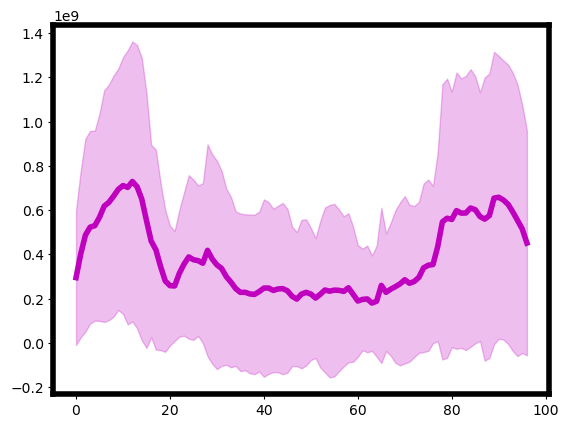

In [17]:
m = np.mean(line_dist_arr, axis=0)[1:-2]
s = np.std(line_dist_arr, axis=0)[1:-2]
lower = m - s
upper = m + s
bins = np.arange(0, len(m))
plt.figure()
plt.fill_between(bins, lower, upper, color='m', alpha=0.25)
plt.plot(bins, m, color='m', linewidth=4)

### plot mean and individual line dists, or as fraction of max

In [18]:
line_dist_arr = line_dist_arr.values

In [21]:
%matplotlib qt

In [195]:
plt.figure()
line_dist_max = np.expand_dims(np.max(line_dist_arr, axis=1), axis=1)
line_dist_max_rep = np.repeat(line_dist_max, line_dist_arr.shape[1], axis=1)
line_dist_arr = line_dist_arr / line_dist_max_rep
m = np.mean(line_dist_arr[partial_ids, :], axis=0)#[1:-2] 
s = np.std(line_dist_arr[partial_ids, :], axis=0)#[1:-2]
lower = m - s
upper = m + s
bins = np.arange(0, len(m))

#for line_dist in line_dist_arr:
#    plt.plot(bins, line_dist[1:-2] / np.max(line_dist[1:-2]),linewidth=2, alpha=1)

plt.fill_between(bins, lower, upper, color='g', alpha=0.25)
plt.plot(bins, m, color='g', linewidth=4)
plt.xlim([0, 100])
plt.xticks([0, 50, 100], labels=['0', '0.5', '1'], fontsize=16)
plt.xlabel('fraction of ap axis', fontsize=24)
#plt.ylim([-0.5e8, 8e8])
plt.yticks([0, 0.5, 1], fontsize=16)
plt.ylabel('dipt-gfp \n (fraction of max)', fontsize=24)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(16)
fontweight = 'bold'
fontsize=24
fontproperties = {'family':'sans-serif','sans-serif':['Arial'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [196]:
plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/partial_ap_dist_rescaled_v2.pdf')

### Bin ap a bit more

In [177]:
def decimate_line_dist(line_dist_arr):
    """line_dist_arr = 2d array, num_samples x num_bins"""
    if np.mod(line_dist_arr.shape[1], 2) != 0:
        raise ValueError('make an even number of bins')
    
    decimated_line_dist = np.zeros((line_dist_arr.shape[0], line_dist_arr.shape[1] // 2))
    for i in range(decimated_line_dist.shape[1]):
        decimated_line_dist[:, i] = np.sum(line_dist_arr[:, 2*i:(2*i+1)], axis=1)
    
    return decimated_line_dist
        


In [626]:
decimated_line_dist = decimate_line_dist(line_dist_arr)
decimated_line_dist = decimate_line_dist(decimated_line_dist)

plt.figure()
for i in range(len(decimated_line_dist)):
    if i in partial_ids:
        plt.plot(decimated_line_dist[i, 1:-2], color='m', alpha=0.25)

plt.plot(np.mean(decimated_line_dist[partial_ids], axis=0)[1:-2], color='m', linewidth=3)
plt.ylim([1e7, 1.5e9])
plt.yscale('log')

In [619]:
np.sum(decimated_line_dist==0)

13

In [615]:
decimated_line_dist.shape

(20, 50)

In [591]:
complete_ids = np.setdiff1d(np.linspace(0, 19, 20), partial_ids).astype('int')
complete_ids

array([ 4,  7,  9, 10, 12, 14, 15, 17])

In [593]:
plt.figure()
plt.plot(np.mean(line_dist_arr[partial_ids], axis=0))
plt.ylim([0, 1.3e9])
plt.figure()
plt.plot(np.mean(line_dist_arr[complete_ids], axis=0))
plt.ylim([0, 1.3e9])


(0.0, 1300000000.0)

In [597]:
line_dist_arr[8]

array([5.29186052e+09, 3.01587198e+08, 3.22292152e+08, 3.63896830e+08,
       3.69020367e+08, 3.90090802e+08, 3.64026571e+08, 3.77526240e+08,
       3.68189677e+08, 4.03910404e+08, 4.77948181e+08, 4.78269696e+08,
       5.21095713e+08, 4.67855908e+08, 3.49685478e+08, 2.11322675e+08,
       1.63046238e+08, 1.85924235e+08, 1.70190251e+08, 1.09008318e+08,
       5.68320200e+07, 7.75669130e+07, 7.00034030e+07, 7.96789630e+07,
       1.01444990e+08, 6.28746690e+07, 6.07944570e+07, 9.76617230e+07,
       8.08948060e+07, 5.15871310e+07, 3.87139510e+07, 3.49758830e+07,
       2.45464910e+07, 1.73944450e+07, 1.53912270e+07, 1.53907170e+07,
       1.16564770e+07, 9.60641000e+06, 2.19475960e+07, 2.51320830e+07,
       2.60893900e+07, 1.91910130e+07, 2.63180930e+07, 3.04744160e+07,
       3.28046770e+07, 4.94903140e+07, 2.26104920e+07, 2.74862830e+07,
       1.02692810e+07, 6.70860500e+06, 1.09768480e+07, 3.47323980e+07,
       3.41173260e+07, 3.74176660e+07, 9.03573680e+07, 1.18862197e+08,
      

In [573]:
line_dist_df = pd.DataFrame(line_dist_arr)

In [575]:
line_dist_df.to_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/emL3_24_line_dist.pkl')

In [544]:
line_dist_arr.shape

(20, 100)

In [550]:
mip_dir = r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_06_07-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_3/mips/mip_green_0.tif'
mip = np.array(Image.open(mip_dir))
plt.figure()
plt.hist(np.log10(mip.flatten() + 1), bins=100)

(array([1.602480e+07, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 2.200000e+01,
        2.394800e+04, 1.291860e+05, 8.32

In [552]:
all_larvae_dirs = []
for experiment_path in experiment_paths:
    larvae_dirs = glob(experiment_path + '/larvae*')
    for larvae_dir in larvae_dirs:
        if Path(larvae_dir + '/ap/ap.pkl').is_file():
            all_larvae_dirs.append(larvae_dir)

In [554]:
len(all_larvae_dirs)

20

In [556]:
df['larvae_dir'] = ''


In [558]:
for i in range(len(df)):
    df.loc[i, 'larvae_dir'] = all_larvae_dirs[df.loc[i, 'experiment_id']]

In [560]:
df.to_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/df_emL3_24_ap.pkl')

In [562]:
df.get(['experiment_id', 'larvae_dir'])

experiment_id                                         larvae_dir
0                0  /media/brandon/Data2/Brandon/fly_immune/Lights...
1                0  /media/brandon/Data2/Brandon/fly_immune/Lights...
2                0  /media/brandon/Data2/Brandon/fly_immune/Lights...
3                0  /media/brandon/Data2/Brandon/fly_immune/Lights...
4                0  /media/brandon/Data2/Brandon/fly_immune/Lights...
...            ...                                                ...
6126            19  /media/brandon/Data2/Brandon/fly_immune/Lights...
6127            19  /media/brandon/Data2/Brandon/fly_immune/Lights...
6128            19  /media/brandon/Data2/Brandon/fly_immune/Lights...
6129            19  /media/brandon/Data2/Brandon/fly_immune/Lights...
6130            19  /media/brandon/Data2/Brandon/fly_immune/Lights...

[6131 rows x 2 columns]

In [565]:
df.experiment_id.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19], dtype=object)

In [566]:
df.larvae_dir.unique()

array(['/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_05_03-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_4',
       '/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_05_03-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_1',
       '/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_05_03-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_5',
       '/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_05_03-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_2',
       '/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_05_03-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_3',
       '/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_05_03-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_6',
       '/media/brandon/Data2/Brandon/fly_immune/Lightsheet

In [567]:
bkgs = [700, 800, 700, 1000, 4500, 800, 1000, 4500, 1000, 3500, 3500, 2000, 6000, 1000, 4000, 4500, 1000, 2500, 1000, 2500]

In [568]:
bkg_df = pd.DataFrame({'background': bkgs, 'larvae_dir': all_larvae_dirs})

In [570]:
bkg_df.to_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/emL3_24_backgrounds.pkl')

In [571]:
bkg_df

background                                         larvae_dir
0          700  /media/brandon/Data2/Brandon/fly_immune/Lights...
1          800  /media/brandon/Data2/Brandon/fly_immune/Lights...
2          700  /media/brandon/Data2/Brandon/fly_immune/Lights...
3         1000  /media/brandon/Data2/Brandon/fly_immune/Lights...
4         4500  /media/brandon/Data2/Brandon/fly_immune/Lights...
5          800  /media/brandon/Data2/Brandon/fly_immune/Lights...
6         1000  /media/brandon/Data2/Brandon/fly_immune/Lights...
7         4500  /media/brandon/Data2/Brandon/fly_immune/Lights...
8         1000  /media/brandon/Data2/Brandon/fly_immune/Lights...
9         3500  /media/brandon/Data2/Brandon/fly_immune/Lights...
10        3500  /media/brandon/Data2/Brandon/fly_immune/Lights...
11        2000  /media/brandon/Data2/Brandon/fly_immune/Lights...
12        6000  /media/brandon/Data2/Brandon/fly_immune/Lights...
13        1000  /media/brandon/Data2/Brandon/fly_immune/Lights...
14        4000  /media/brandon/Data2/Brandon/fly_immune/Lights...
15        4500  /media/brandon/Data2/Brandon/fly_immune/Lights...
16        1000  /media/brandon/Data2/Brandon/fly_immune/Lights...
17        2500  /media/brandon/Data2/Brandon/fly_immune/Lights...
18        1000  /media/brandon/Data2/Brandon/fly_immune/Lights...
19        2500  /media/brandon/Data2/Brandon/fly_immune/Lights...

In [599]:
all_larvae_dirs[8]

'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_06_01-dpt-gfp_r4-gal4_uas-mcd8-mcherry_ecoli-hs-dtom_early-mid_24hrs_high_dose/larvae_5'

## EcR analysis

In [15]:
ecr_df = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_11-mNG-EcR_early_mid/larvae_3/manual_df.pkl')
path_to_zarr = r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_11-mNG-EcR_early_mid/larvae_3/im.ome.zarr/0'
rz = 10
rxy = 20

In [17]:
def quantify_ecr_inten(df, path_to_zarr, rz, rxy):
    func = partial(quantify_ecr_inten_1row, path_to_zarr=path_to_zarr, rz=rz, rxy=rxy)
    results = df.apply(func, axis=1).tolist()
    df['mng-ecr'] = results
    
    return df

def quantify_ecr_inten_1row(row, path_to_zarr, rz, rxy):
    z, y, x = row.get(['z', 'y', 'x']).astype('int').values
    im = zarr.open(path_to_zarr, 'r')[0, 0]
    try:
        this_voxel = im[z-rz:z+rz, y-rxy:y+rxy, x-rxy:x+rxy]
        this_inten = np.sum(this_voxel)
    except IndexError:
        this_inten = np.NaN
    
    return this_inten
    

    
    

In [18]:
ecr_df2 = quantify_ecr_inten(ecr_df, path_to_zarr, rz, rxy)

In [13]:
im = zarr.open(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_11-mNG-EcR_early_mid/larvae_3/im.ome.zarr/0', 'r')

In [24]:
ecr_df2.to_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_11-mNG-EcR_early_mid/larvae_3/manual_df_quant.pkl')

In [4]:
ecr_df2 = ecr_df2.rename({'mng-ecr': 'mng_ecr'})

In [2]:
ecr_df2 = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_11-mNG-EcR_early_mid/larvae_3/manual_df_quant.pkl')

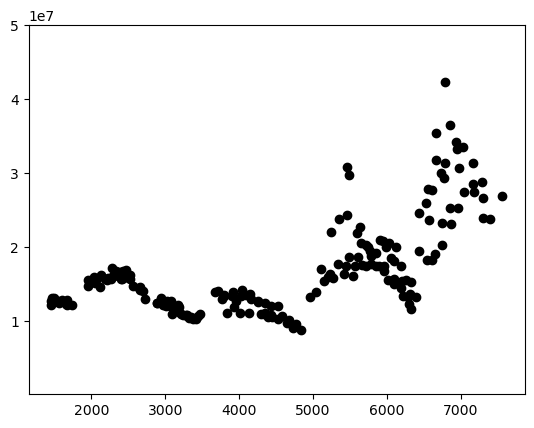

In [51]:
plt.figure()
plt.plot(ecr_df2.y, ecr_df2.get('mng-ecr'), 'ko')
plt.ylim([5e4, 5e7])
plt.yscale('linear')

In [22]:
def get_bin(df, column, bins):
    func = partial(get_this_bin, column=column, bins=bins)
    res = pd.DataFrame(df.apply(func, axis=1), columns=['y_bins'])
    
    df = pd.concat((df, res), axis=1)
    
    return df

def get_this_bin(row, column, bins):
    val = row.get(column)
    res = np.where(np.abs(val - bins) == np.min(np.abs(val - bins)))[0][0]
    
    return res

In [46]:
y_bins = np.linspace(ecr_df2.y.min(), ecr_df2.y.max(), 10)
column = 'y'
res = get_bin(ecr_df2, column, y_bins)

In [49]:
sig = res.groupby(by=['y_bins']).mean().get('mng-ecr')

In [41]:
sig.values

array([ 88833476,  49241260, 169929156, 257798758,  94699754, 179461832,
       105753433,  78535354, 141302054, 114136023,  71136059,  52847698,
       215547717, 296244231, 268030565, 219050133, 300760652, 371626900,
       190044234,  26833121])

(-0.1, 1.0)

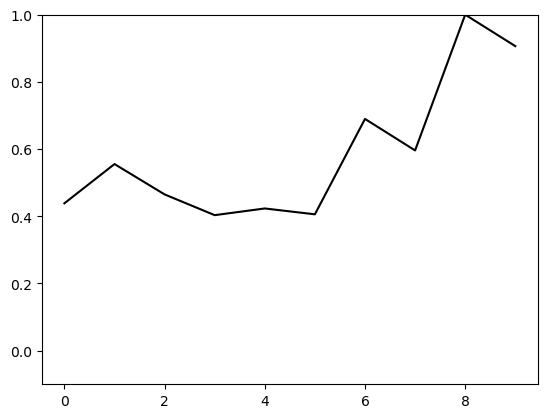

In [54]:
plt.figure()
plt.plot(sig.index, sig.values / np.max(sig.values), 'k-')
plt.ylim([-0.1, 1.0])
#plt.yscale('log')

In [27]:
ecr_df2

z            y            x   mng-ecr
0    151.0  1498.616928   948.932083  13061737
1    151.0  1464.777211  1034.903256  13023307
2    151.0  1455.631341  1120.874430  12678711
3    151.0  1553.492145  1042.219952  12667858
4    151.0  1599.221493   921.494474  12847858
..     ...          ...          ...       ...
190  260.0  7306.952430  1408.757053  26529103
191  260.0  7392.640963  1435.816590  23779573
192  252.0  6728.554835  1422.286821  29988675
193  264.0  6571.835018  1341.108211  23554954
194  238.0  7559.508105   859.673956  26833121

[195 rows x 4 columns]

/tmp/ipykernel_2009560/1449169006.py:4: RuntimeWarning: invalid value encountered in true_divide
  line_dist = np.sum(mip_culled, axis=1) / np.sum(mip_culled > 0, axis=1)


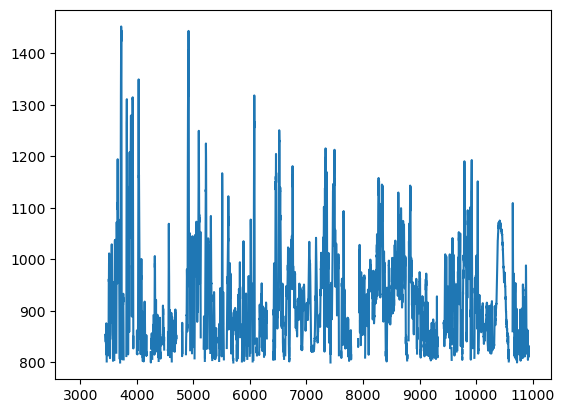

In [36]:
mip_culled = np.array(Image.open(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_11-mNG-EcR_early_mid/larvae_3/mips/mip_green_from_270.tif'))
bkg = 800
mip_culled[mip_culled < 800] = 0
line_dist = np.sum(mip_culled, axis=1) / np.sum(mip_culled > 0, axis=1)
plt.figure()
plt.plot(line_dist)

In [32]:
mip_culled.shape

(10932, 2029)

## dye analysis

In [37]:
im = np.array(Image.open('/media/brandon/Data2/Brandon/fly_immune/SwinburneScope/2023_07_12_dpt-gfp_rhodamine_early-mid/initial_test/dye/larvae_1.tif'))

(2000.0, 20000.0)

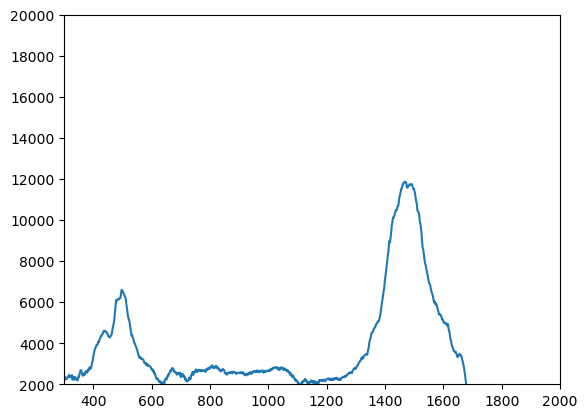

In [46]:
bkg = 7
im[im < bkg] = 0
line_dist = np.sum(im, axis=0)
plt.figure()
plt.plot(line_dist)
plt.yscale('linear')
plt.xscale("linear")
plt.xlim([300, 2000])
plt.ylim([2e3, 2e4])

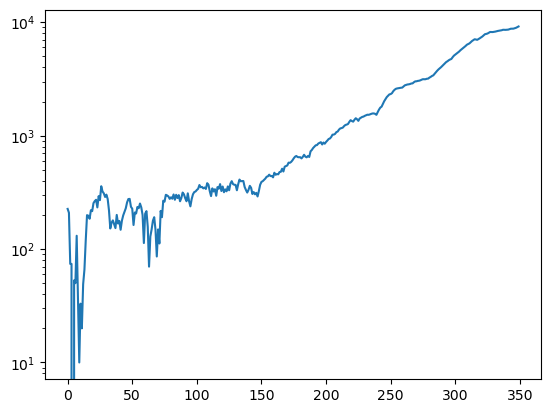

In [54]:
y = line_dist[1100:1450]
plt.figure()
plt.plot(y - np.min(y))
plt.yscale('log')
plt.xscale('linear')

## bacteria distribution analysis

In [105]:
mip = np.array(Image.open(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_07-dpt-gfp_ecoli-hs-dtom_early-mid_high_dose_bacteria_distribution/larvae_3/mips/mip_red_0_crop.tif'))

In [4]:
from skimage.filters import gaussian

In [5]:
sigma_low = 5
mip_dog = gaussian(mip, sigma=sigma_low) - gaussian(mip, sigma=1.6*sigma_low) 

In [23]:
import napari

In [65]:
viewer = napari.view_image(mip)

In [6]:
spot_thresh = 0.00007
spot_mask = mip_dog > spot_thresh

cluster_thresh = 1500
cluster_mask = mip > cluster_thresh

bacteria_mask = (spot_mask + cluster_mask) > 0

bacteria_signal = bacteria_mask.astype('uint16') * mip
bacteria_signal_1d = np.sum(bacteria_signal, axis=1)

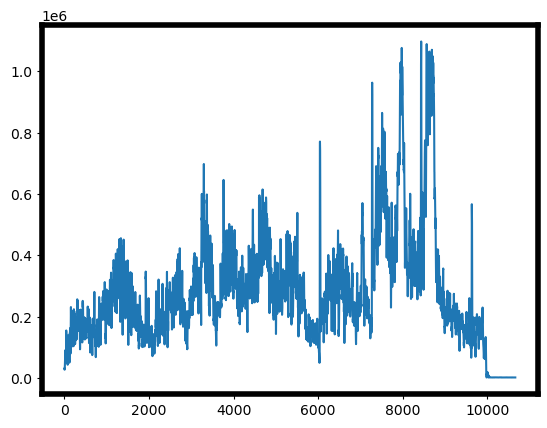

In [7]:
plt.figure()
plt.plot(bacteria_signal_1d)

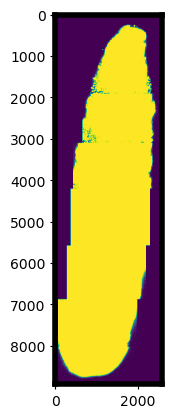

In [115]:
mip_raw = np.array(Image.open(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_07-dpt-gfp_ecoli-hs-dtom_early-mid_high_dose_bacteria_distribution/larvae_3/mips/mip_red_0.tif'))
larva_thresh = 248
larva_mask = mip_raw > larva_thresh
larva_width = np.sum(larva_mask, axis=1)
plt.imshow(larva_mask)
#bacteria_density = bacteria_signal_1d / larva_width / larva_width

#plt.figure()
#plt.plot(bacteria_density[:9900])

In [128]:
n_ap_bins = 50
y_max = 7900
ap_y = list(np.linspace(0, y_max, n_ap_bins).astype('int'))
ap_x = [int(mip.shape[1] / 2)] * n_ap_bins
ap = np.array([ap_y, ap_x], dtype='int')
ap = pd.DataFrame(ap.T, columns=['y', 'x'])

In [129]:
line_dist_bac = get_line_dist_from_mip(mip, ap, bkg=1000)

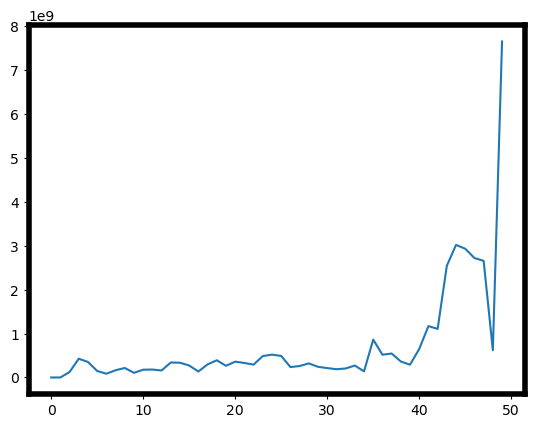

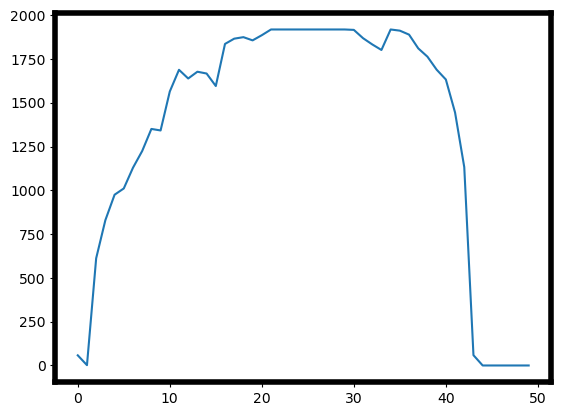

In [130]:
plt.figure()
plt.plot(line_dist_bac)
plt.figure()
plt.plot(binned_widths)

In [143]:
line_dist_bac_3_df = pd.DataFrame(line_dist_bac, columns=['bac'])

In [144]:
line_dist_bac_4_df.to_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_07-dpt-gfp_ecoli-hs-dtom_early-mid_high_dose_bacteria_distribution/larvae_3/line_dist_bac_df.pkl')

In [145]:
density_bac_3_df = pd.DataFrame(density_bac, columns=['bac'])

In [147]:
density_bac_3_df.to_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_07-dpt-gfp_ecoli-hs-dtom_early-mid_high_dose_bacteria_distribution/larvae_3/density_bac_df.pkl')

In [132]:
x = np.linspace(0, 10_000, n_ap_bins)
xp = np.arange(0, mip_raw.shape[0])
fp = larva_width
binned_widths = np.interp(x, xp, fp)


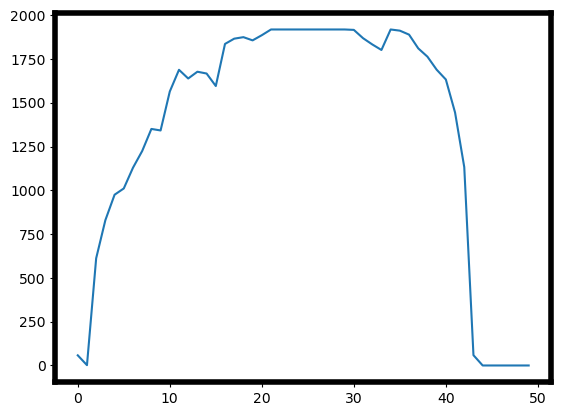

In [133]:
plt.figure()
plt.plot(binned_widths)

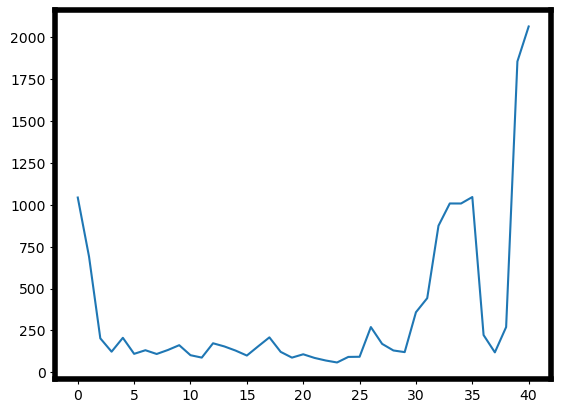

In [127]:
density_bac = density_bac[~np.isnan(density_bac)]
density_bac = density_bac[density_bac < 1e6]
density_bac = density_bac[density_bac > 0]
plt.figure()
plt.plot(density_bac)

In [157]:
line_dist_bac = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_07-dpt-gfp_ecoli-hs-dtom_early-mid_high_dose_bacteria_distribution/larvae_4/line_dist_bac_df.pkl')
mip_raw = np.array(Image.open(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_07-dpt-gfp_ecoli-hs-dtom_early-mid_high_dose_bacteria_distribution/larvae_4/mips/mip_red_0.tif'))
larva_thresh = 248
larva_mask = mip_raw > larva_thresh
larva_width = np.sum(larva_mask, axis=1)
n_ap_bins = 50
y_max = 10_000
x = np.linspace(0, y_max, n_ap_bins)
xp = np.arange(0, mip_raw.shape[0])
fp = larva_width
binned_widths = np.interp(x, xp, fp)
density_bac = line_dist_bac.bac.values / binned_widths/ binned_widths


In [160]:
density_bac_df = pd.DataFrame(density_bac, columns=['bac'])
density_bac_df.to_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_07-dpt-gfp_ecoli-hs-dtom_early-mid_high_dose_bacteria_distribution/larvae_4/density_bac_df.pkl')

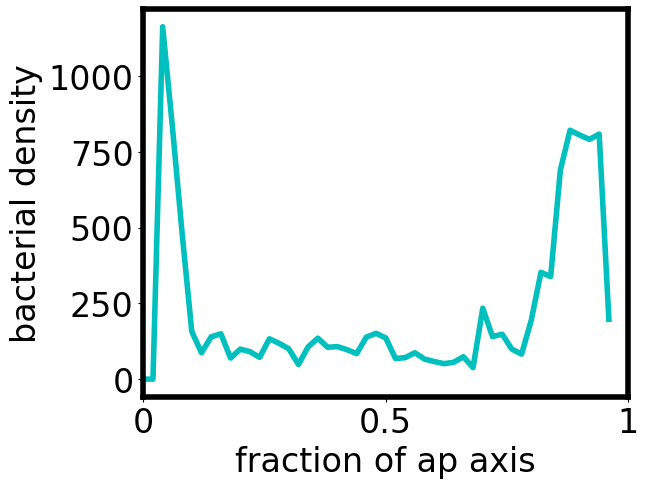

In [142]:
x = np.linspace(0, y_max, n_ap_bins)
xp = np.arange(0, mip_raw.shape[0])
fp = larva_width
binned_widths = np.interp(x, xp, fp)

density_bac = line_dist_bac / binned_widths/ binned_widths
l = (line_dist_bac - std_line_dist_bac) / binned_widths/ binned_widths
u = (line_dist_bac + std_line_dist_bac) / binned_widths/ binned_widths

plt.figure()
plt.plot(density_bac[:-1], color='c', linewidth=4)
plt.xlim([0, n_ap_bins])
plt.xticks([0, n_ap_bins // 2, n_ap_bins], labels=['0', '0.5', '1'], fontsize=16)
plt.xlabel('fraction of ap axis', fontsize=24)
#plt.ylim([-0.5e8, 8e8])
#plt.yticks([0, 0.5, 1], fontsize=16)
plt.ylabel('bacterial density', fontsize=24)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(16)
fontweight = 'bold'
fontsize=24
fontproperties = {'family':'sans-serif','sans-serif':['Arial'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [190]:
%matplotlib qt

In [193]:
"""plot bac density across two larvae"""
density_bac_3 = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_07-dpt-gfp_ecoli-hs-dtom_early-mid_high_dose_bacteria_distribution/larvae_3/density_bac_df.pkl').bac.values
density_bac_4 = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_07-dpt-gfp_ecoli-hs-dtom_early-mid_high_dose_bacteria_distribution/larvae_4/density_bac_df.pkl').bac.values

# rescale to max
density_bac_3 = density_bac_3 / np.max(density_bac_3)
density_bac_4 = density_bac_4 / np.max(density_bac_4)

# combine densities
density_bac = np.concatenate((np.expand_dims(density_bac_3, axis=0), np.expand_dims(density_bac_4, axis=0)), axis=0)

# compute mean and std. dev
mean_density = np.mean(density_bac, axis=0)
std_density = np.std(density_bac, axis=0)
l = mean_density - std_density
u = mean_density + std_density
x = np.arange(n_ap_bins - 1)
plt.figure()
plt.plot(x, mean_density[:-1], color='c', linewidth=4)
plt.fill_between(x, l[:-1], u[:-1], facecolor='c', alpha=0.5)
plt.xlim([0, n_ap_bins])
plt.xticks([0, n_ap_bins // 2, n_ap_bins], labels=['0', '0.5', '1'], fontsize=16)
plt.xlabel('fraction of ap axis', fontsize=24)
#plt.ylim([-0.5e8, 8e8])
plt.yticks([0, 0.5, 1], fontsize=16)
plt.ylabel('bacterial density \n (fraction of max)', fontsize=24)
ax = plt.gca() 
ax.yaxis.get_offset_text().set_fontsize(16)
fontweight = 'bold'
fontsize=24
fontproperties = {'family':'sans-serif','sans-serif':['Arial'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


In [194]:
plt.savefig(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_07-dpt-gfp_ecoli-hs-dtom_early-mid_high_dose_bacteria_distribution/bacteria_density_dists_3_4.pdf')

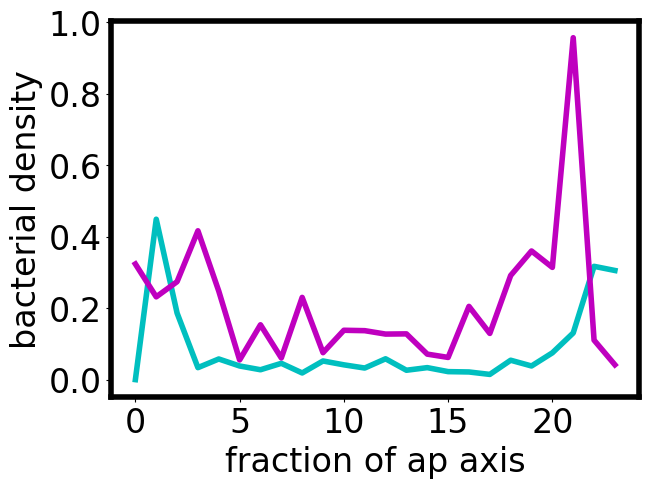

In [184]:
"""plot bac density across two larvae"""
density_bac_3 = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_07-dpt-gfp_ecoli-hs-dtom_early-mid_high_dose_bacteria_distribution/larvae_3/density_bac_df.pkl').bac.values
density_bac_4 = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_07-dpt-gfp_ecoli-hs-dtom_early-mid_high_dose_bacteria_distribution/larvae_4/density_bac_df.pkl').bac.values

# rescale to max
density_bac_3 = density_bac_3 / np.max(density_bac_3)
density_bac_4 = density_bac_4 / np.max(density_bac_4)

# decimate
density_bac_3_dec = decimate_line_dist(np.expand_dims(density_bac_3, axis=0))
density_bac_4_dec = decimate_line_dist(np.expand_dims(density_bac_4, axis=0))


x = np.arange(n_ap_bins - 1)
plt.figure()
plt.plot(density_bac_3_dec[0, :-1], color='c', linewidth=4)
plt.plot(density_bac_4_dec[0,:-1], color='m', linewidth=4)
#plt.xlim([0, n_ap_bins])
#plt.xticks([0, n_ap_bins // 2, n_ap_bins], labels=['0', '0.5', '1'], fontsize=16)
plt.xlabel('fraction of ap axis', fontsize=24)
#plt.ylim([-0.5e8, 8e8])
#plt.yticks([0, 0.5, 1], fontsize=16)
plt.ylabel('bacterial density', fontsize=24)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(16)
fontweight = 'bold'
fontsize=24
fontproperties = {'family':'sans-serif','sans-serif':['Arial'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


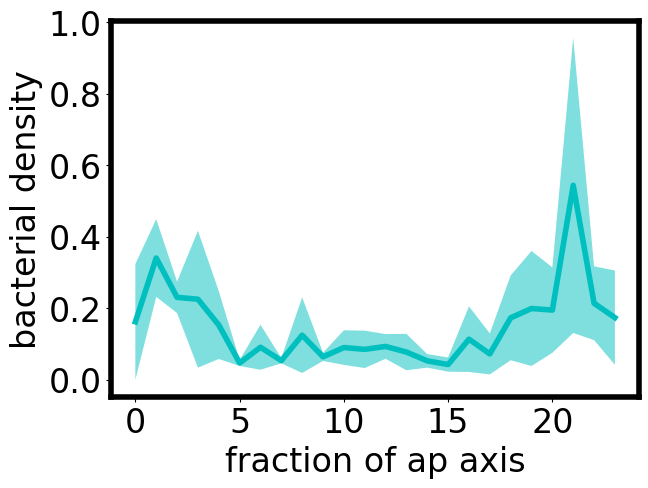

In [189]:
"""plot bac density across two larvae"""
density_bac_3 = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_07-dpt-gfp_ecoli-hs-dtom_early-mid_high_dose_bacteria_distribution/larvae_3/density_bac_df.pkl').bac.values
density_bac_4 = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2023_07_07-dpt-gfp_ecoli-hs-dtom_early-mid_high_dose_bacteria_distribution/larvae_4/density_bac_df.pkl').bac.values

# rescale to max
density_bac_3 = density_bac_3 / np.max(density_bac_3)
density_bac_4 = density_bac_4 / np.max(density_bac_4)

# decimate
density_bac_3_dec = decimate_line_dist(np.expand_dims(density_bac_3, axis=0))
density_bac_4_dec = decimate_line_dist(np.expand_dims(density_bac_4, axis=0))


# combine densities
density_bac = np.concatenate((density_bac_3_dec, density_bac_4_dec), axis=0)

# compute mean and std. dev
mean_density = np.mean(density_bac, axis=0)
std_density = np.std(density_bac, axis=0)
l = mean_density - std_density
u = mean_density + std_density
x = np.arange(len(mean_density) - 1)
plt.figure()
plt.plot(x, mean_density[:-1], color='c', linewidth=4)
plt.fill_between(x, l[:-1], u[:-1], facecolor='c', alpha=0.5)
#plt.xlim([0, n_ap_bins])
#plt.xticks([0, n_ap_bins // 2, n_ap_bins], labels=['0', '0.5', '1'], fontsize=16)
plt.xlabel('fraction of ap axis', fontsize=24)
#plt.ylim([-0.5e8, 8e8])
#plt.yticks([0, 0.5, 1], fontsize=16)
plt.ylabel('bacterial density', fontsize=24)
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(16)
fontweight = 'bold'
fontsize=24
fontproperties = {'family':'sans-serif','sans-serif':['Arial'],'weight' : fontweight, 'size' : fontsize}
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


In [183]:
density_bac_3_dec[0]

array([0.        , 0.44875488, 0.18622047, 0.03352914, 0.05773289,
       0.03817063, 0.02764884, 0.04561313, 0.01863834, 0.0521533 ,
       0.04138661, 0.03241644, 0.05829817, 0.02625285, 0.03354988,
       0.02237527, 0.02142707, 0.01460248, 0.05425982, 0.03818755,
       0.07495351, 0.13049098, 0.31691543, 0.30530524, 0.07612874])

In [181]:
density_bac_4_dec

array([[0.32345072, 0.23153607, 0.27400302, 0.41632313, 0.24753288,
        0.05508771, 0.15340834, 0.06065196, 0.23001255, 0.07541052,
        0.13807287, 0.13695458, 0.12740909, 0.12799924, 0.07131279,
        0.0621026 , 0.20487466, 0.12922923, 0.29131567, 0.35986389,
        0.31395842, 0.9564052 , 0.11046535, 0.04150655, 0.06619577]])

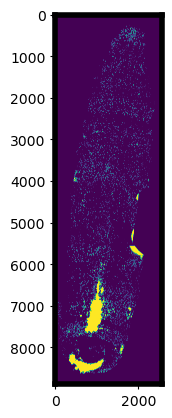

In [113]:
plt.imshow(larva_mask)

In [70]:
larva_width.shape

(10661,)

In [71]:
bacteria_signal_1d.shape

(10661,)

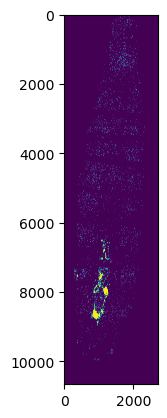

In [76]:
plt.figure()
plt.imshow(mip > 1500)